In [39]:
## Regress Altitude out if r squared with altitude is less than 0.1 and p value greater than 0.05

In [26]:
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import sys
import matplotlib.pyplot as plt

In [3]:
sys.path.append("../src")
import main

In [38]:
def regress_altitude(radius=300, season='year'):

    temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
    temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
    temp = temp[temp['variable']=='Ta_deg_C']
    #temp = temp[temp['datetime_UTC'].dt.date.isin(hid['datetime_UTC'].dt.date)]
    temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
    temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

    params = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    params = params.set_index('station_id')
    to_remove = ['station_no','station_name','station_long_name','station_type','station_lat','station_lon','mounting_structure','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF_3D']
    params = params.drop(to_remove, axis=1)
    params = params.drop('FREBNE',axis=0)
    vars = params.columns

    vars = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']
    vars = ['BuAre_sum']

    for var in vars:
        params_v = params[[var]]

        stats_dict = {}

        for time in temp.columns:

            print(f'Processing {var} for {time}')
            alt = params[['station_elevation']].merge(temp[time], left_on='station_id', right_on='station_id',how='inner')
            X1 = sm.add_constant(alt['station_elevation'])
            y1 = alt[time]
            model = sm.OLS(y1, X1).fit()
            alt[time] = model.resid

            params_t = params_v.merge(alt[time], left_on='station_id', right_on='station_id',how='inner')

            if model.rsquared < 0.1 or model.pvalues['station_elevation'] > 0.05:
                print(f'Low r-squared for {time}: {model.rsquared}. Skipping...')
                alt[time] = temp[time]  # Keep original values if model is not significant
            else:

                alt[time] = model.resid

            stats = main.calculate_statistics(params_t, time)
            stats.index = stats['Parameter']
            stats['Time'] = time
            stats['altitude r-squared'] = model.rsquared
            stats['altitude p-value'] = model.pvalues['station_elevation']
            stats['altitude gradient'] = model.params[1]
            stats['altitude intercept'] = model.params[0]
            stats_dict[time] = stats
        pd.concat(stats_dict).to_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/altitude_out/{season,var,radius}.csv')   

In [61]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
#temp = temp[temp['datetime_UTC'].dt.date.isin(hid['datetime_UTC'].dt.date)]
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

params = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
params = params.set_index('station_id')
to_remove = ['station_no','station_name','station_long_name','station_type','station_lat','station_lon','mounting_structure','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF_3D']
params = params.drop(to_remove, axis=1)
params = params.drop('FREBNE',axis=0)
vars = params.columns

vars = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode', 'StrClo400_median']
vars = ['BuAre_sum']

for var in vars:
    params_v = params[[var]]

    stats_dict = {}

    for time in temp.columns[227:228]:

        print(f'Processing {var} for {time}')
        alt = params[['station_elevation']].merge(temp[time], left_on='station_id', right_on='station_id',how='inner')
        X1 = sm.add_constant(alt['station_elevation'])
        y1 = alt[time]
        model = sm.OLS(y1, X1).fit()

        if model.rsquared < 0.1 or model.pvalues['station_elevation'] > 0.05:
            print(f'Low r-squared for {time}: {model.rsquared}. Skipping...')
            alt[time] = temp[time]  # Keep original values if model is not significant
        else:

            alt[time] = model.resid

        params_t = params_v.merge(alt[time], left_on='station_id', right_on='station_id',how='inner')


        stats = main.calculate_statistics(params_t, time)
        stats.index = stats['Parameter']
        stats['Time'] = time
        stats['altitude r-squared'] = model.rsquared
        stats['altitude p-value'] = model.pvalues['station_elevation']
        stats['altitude gradient'] = model.params[1]
        stats['altitude intercept'] = model.params[0]
        stats_dict[time] = stats

Processing BuAre_sum for 2022-09-10 11:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/1397012898.py:46: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/1397012898.py:47: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]


In [62]:
main.calculate_statistics(params[['station_elevation']].merge(temp['2022-09-10 11:00:00+00:00'], left_on='station_id', right_on='station_id',how='inner'), time)

Parameter  Pearson Correlation  Pearson p-value  \
0  station_elevation            -0.783857     5.880871e-09   

   Spearman Correlation  Spearman p-value  Mutual Information  
0             -0.747688      6.881525e-08            0.383806

In [80]:
params_v

BuAre_sum
station_id               
FRASHA       40553.346024
FRBETZ       41115.225311
FRBRUH       90730.577651
FRDIET        1030.516002
FRDREI       44578.789620
FRFRIE       15189.948458
FRGART       47188.835379
FRGLBA       26748.693973
FRGUNT       24986.687163
FRHAID       62196.655543
FRHBHF       82733.128659
FRHERD       76573.641168
FRHOCH        7577.719556
FRHOLZ       94638.081131
FRIHOC       59283.615670
FRINST       85686.660928
FRKART      131106.617878
FRLAND       35750.174456
FRLORE       44217.661339
FRMERZ       11399.197261
FRMESS       59114.710422
FROPFS                NaN
FROWIE       78691.202586
FRPDAS      128766.791451
FRRIES       66307.824212
FRSEEP       15986.223178
FRSTGA       49392.053054
FRSTGE       50416.141855
FRSTUH       68830.995503
FRTECH       39999.142997
FRTIEN        1313.508806
FRUNIK       62893.006617
FRUWIE       73623.159659
FRVAUB       58821.624257
FRWAHS        5533.248322
FRWEIN       46051.284140
FRWILD        3811.708052
FRWSEE       47102.444283
FRZAHR       38883.699540

In [63]:
main.calculate_statistics(params_v.merge(temp['2022-09-10 11:00:00+00:00'], left_on='station_id', right_on='station_id',how='inner'), time)

Parameter  Pearson Correlation  Pearson p-value  Spearman Correlation  \
0  BuAre_sum             0.129129          0.44624              0.061663   

   Spearman p-value  Mutual Information  
0          0.716941             0.22011

In [64]:
stats_dict['2022-09-10 11:00:00+00:00']

Parameter  Pearson Correlation  Pearson p-value  \
Parameter                                                    
BuAre_sum  BuAre_sum             0.223172         0.184268   

           Spearman Correlation  Spearman p-value  Mutual Information  \
Parameter                                                               
BuAre_sum              0.277857          0.095893            0.041934   

                                Time  altitude r-squared  altitude p-value  \
Parameter                                                                    
BuAre_sum  2022-09-10 11:00:00+00:00            0.614432      5.880871e-09   

           altitude gradient  altitude intercept  
Parameter                                         
BuAre_sum          -0.015593           20.986647

In [65]:
model.pvalues['station_elevation']

5.880870654134415e-09

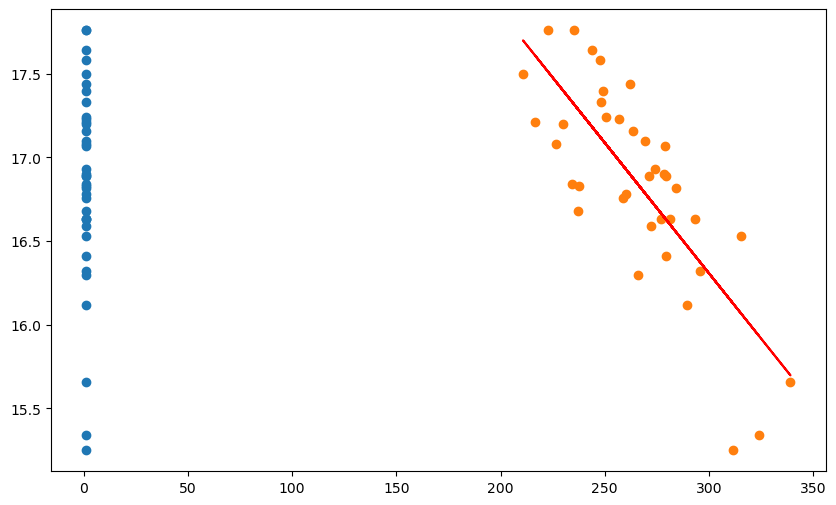

In [72]:
plt.figure(figsize=(10, 6))
plt.plot(X1, y1, 'o')
# plot model line
plt.plot(alt['station_elevation'], model.predict(X1), color='red')
plt.show()

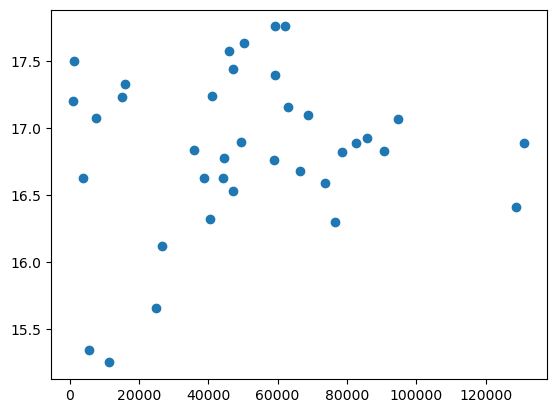

In [79]:
plt.plot(params_v.merge(temp['2022-09-10 11:00:00+00:00'], left_on='station_id', right_on='station_id',how='inner')[var], params_v.merge(temp['2022-09-10 11:00:00+00:00'], left_on='station_id', right_on='station_id',how='inner')[time], 'o')

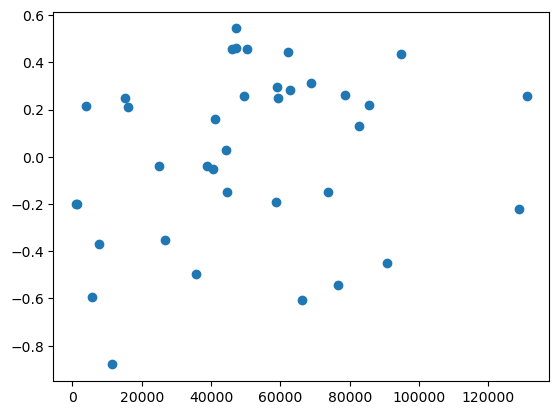

In [77]:
plt.plot(params_t[var], params_t[time], 'o')

In [23]:
stats_dict

{'2022-09-01 00:00:00+00:00':            Parameter  Pearson Correlation  Pearson p-value  \
 Parameter                                                    
 BuAre_sum  BuAre_sum             0.750891     8.638084e-08   
 
            Spearman Correlation  Spearman p-value  Mutual Information  \
 Parameter                                                               
 BuAre_sum              0.741584      1.512233e-07            0.394195   
 
                                 Time  altitude r-squared  altitude p-value  \
 Parameter                                                                    
 BuAre_sum  2022-09-01 00:00:00+00:00            0.030745               NaN   
 
            altitude gradient  altitude intercept  
 Parameter                                         
 BuAre_sum          -0.007073           17.460932  }

In [21]:
temp.columns[0]

'2022-09-01 00:00:00+00:00'

In [16]:
regress_altitude(radius=300, season='year')

Processing BuAre_sum for 2022-09-01 00:00:00+00:00
Processing BuAre_sum for 2022-09-01 01:00:00+00:00
Processing BuAre_sum for 2022-09-01 02:00:00+00:00
Processing BuAre_sum for 2022-09-01 03:00:00+00:00
Processing BuAre_sum for 2022-09-01 04:00:00+00:00
Processing BuAre_sum for 2022-09-01 05:00:00+00:00
Processing BuAre_sum for 2022-09-01 06:00:00+00:00
Processing BuAre_sum for 2022-09-01 07:00:00+00:00
Processing BuAre_sum for 2022-09-01 08:00:00+00:00
Processing BuAre_sum for 2022-09-01 09:00:00+00:00
Processing BuAre_sum for 2022-09-01 10:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-01 11:00:00+00:00
Processing BuAre_sum for 2022-09-01 12:00:00+00:00
Processing BuAre_sum for 2022-09-01 13:00:00+00:00
Processing BuAre_sum for 2022-09-01 14:00:00+00:00
Processing BuAre_sum for 2022-09-01 15:00:00+00:00
Processing BuAre_sum for 2022-09-01 16:00:00+00:00
Processing BuAre_sum for 2022-09-01 17:00:00+00:00
Processing BuAre_sum for 2022-09-01 18:00:00+00:00
Processing BuAre_sum for 2022-09-01 19:00:00+00:00
Processing BuAre_sum for 2022-09-01 20:00:00+00:00
Processing BuAre_sum for 2022-09-01 21:00:00+00:00
Processing BuAre_sum for 2022-09-01 22:00:00+00:00
Processing BuAre_sum for 2022-09-01 23:00:00+00:00
Processing BuAre_sum for 2022-09-02 00:00:00+00:00
Processing BuAre_sum for 2022-09-02 01:00:00+00:00
Processing BuAre_sum for 2022-09-02 02:00:00+00:00
Processing BuAre_sum for 2022-09-02 03:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-02 04:00:00+00:00
Processing BuAre_sum for 2022-09-02 05:00:00+00:00
Processing BuAre_sum for 2022-09-02 06:00:00+00:00
Processing BuAre_sum for 2022-09-02 07:00:00+00:00
Processing BuAre_sum for 2022-09-02 08:00:00+00:00
Processing BuAre_sum for 2022-09-02 09:00:00+00:00
Processing BuAre_sum for 2022-09-02 10:00:00+00:00
Processing BuAre_sum for 2022-09-02 11:00:00+00:00
Processing BuAre_sum for 2022-09-02 12:00:00+00:00
Processing BuAre_sum for 2022-09-02 13:00:00+00:00
Processing BuAre_sum for 2022-09-02 14:00:00+00:00
Processing BuAre_sum for 2022-09-02 15:00:00+00:00
Processing BuAre_sum for 2022-09-02 16:00:00+00:00
Processing BuAre_sum for 2022-09-02 17:00:00+00:00
Processing BuAre_sum for 2022-09-02 18:00:00+00:00
Processing BuAre_sum for 2022-09-02 19:00:00+00:00
Processing BuAre_sum for 2022-09-02 20:00:00+00:00
Processing BuAre_sum for 2022-09-02 21:00:00+00:00
Processing BuAre_sum for 2022-09-02 22:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-02 23:00:00+00:00
Processing BuAre_sum for 2022-09-03 00:00:00+00:00
Processing BuAre_sum for 2022-09-03 01:00:00+00:00
Processing BuAre_sum for 2022-09-03 02:00:00+00:00
Processing BuAre_sum for 2022-09-03 03:00:00+00:00
Processing BuAre_sum for 2022-09-03 04:00:00+00:00
Processing BuAre_sum for 2022-09-03 05:00:00+00:00
Processing BuAre_sum for 2022-09-03 06:00:00+00:00
Processing BuAre_sum for 2022-09-03 07:00:00+00:00
Processing BuAre_sum for 2022-09-03 08:00:00+00:00
Processing BuAre_sum for 2022-09-03 09:00:00+00:00
Processing BuAre_sum for 2022-09-03 10:00:00+00:00
Processing BuAre_sum for 2022-09-03 11:00:00+00:00
Processing BuAre_sum for 2022-09-03 12:00:00+00:00
Processing BuAre_sum for 2022-09-03 13:00:00+00:00
Processing BuAre_sum for 2022-09-03 14:00:00+00:00
Processing BuAre_sum for 2022-09-03 15:00:00+00:00
Processing BuAre_sum for 2022-09-03 16:00:00+00:00
Processing BuAre_sum for 2022-09-03 17:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-03 22:00:00+00:00
Processing BuAre_sum for 2022-09-03 23:00:00+00:00
Processing BuAre_sum for 2022-09-04 00:00:00+00:00
Processing BuAre_sum for 2022-09-04 01:00:00+00:00
Processing BuAre_sum for 2022-09-04 02:00:00+00:00
Processing BuAre_sum for 2022-09-04 03:00:00+00:00
Processing BuAre_sum for 2022-09-04 04:00:00+00:00
Processing BuAre_sum for 2022-09-04 05:00:00+00:00
Processing BuAre_sum for 2022-09-04 06:00:00+00:00
Processing BuAre_sum for 2022-09-04 07:00:00+00:00
Processing BuAre_sum for 2022-09-04 08:00:00+00:00
Processing BuAre_sum for 2022-09-04 09:00:00+00:00
Processing BuAre_sum for 2022-09-04 10:00:00+00:00
Processing BuAre_sum for 2022-09-04 11:00:00+00:00
Processing BuAre_sum for 2022-09-04 12:00:00+00:00
Processing BuAre_sum for 2022-09-04 13:00:00+00:00
Processing BuAre_sum for 2022-09-04 14:00:00+00:00
Processing BuAre_sum for 2022-09-04 15:00:00+00:00
Processing BuAre_sum for 2022-09-04 16:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-04 21:00:00+00:00
Processing BuAre_sum for 2022-09-04 22:00:00+00:00
Processing BuAre_sum for 2022-09-04 23:00:00+00:00
Processing BuAre_sum for 2022-09-05 00:00:00+00:00
Processing BuAre_sum for 2022-09-05 01:00:00+00:00
Processing BuAre_sum for 2022-09-05 02:00:00+00:00
Processing BuAre_sum for 2022-09-05 03:00:00+00:00
Processing BuAre_sum for 2022-09-05 04:00:00+00:00
Processing BuAre_sum for 2022-09-05 05:00:00+00:00
Processing BuAre_sum for 2022-09-05 06:00:00+00:00
Processing BuAre_sum for 2022-09-05 07:00:00+00:00
Processing BuAre_sum for 2022-09-05 08:00:00+00:00
Processing BuAre_sum for 2022-09-05 09:00:00+00:00
Processing BuAre_sum for 2022-09-05 10:00:00+00:00
Processing BuAre_sum for 2022-09-05 11:00:00+00:00
Processing BuAre_sum for 2022-09-05 12:00:00+00:00
Processing BuAre_sum for 2022-09-05 13:00:00+00:00
Processing BuAre_sum for 2022-09-05 14:00:00+00:00
Processing BuAre_sum for 2022-09-05 15:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-05 21:00:00+00:00
Processing BuAre_sum for 2022-09-05 22:00:00+00:00
Processing BuAre_sum for 2022-09-05 23:00:00+00:00
Processing BuAre_sum for 2022-09-06 00:00:00+00:00
Processing BuAre_sum for 2022-09-06 01:00:00+00:00
Processing BuAre_sum for 2022-09-06 02:00:00+00:00
Processing BuAre_sum for 2022-09-06 03:00:00+00:00
Processing BuAre_sum for 2022-09-06 04:00:00+00:00
Processing BuAre_sum for 2022-09-06 05:00:00+00:00
Processing BuAre_sum for 2022-09-06 06:00:00+00:00
Processing BuAre_sum for 2022-09-06 07:00:00+00:00
Processing BuAre_sum for 2022-09-06 08:00:00+00:00
Processing BuAre_sum for 2022-09-06 09:00:00+00:00
Processing BuAre_sum for 2022-09-06 10:00:00+00:00
Processing BuAre_sum for 2022-09-06 11:00:00+00:00
Processing BuAre_sum for 2022-09-06 12:00:00+00:00
Processing BuAre_sum for 2022-09-06 13:00:00+00:00
Processing BuAre_sum for 2022-09-06 14:00:00+00:00
Processing BuAre_sum for 2022-09-06 15:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-06 20:00:00+00:00
Processing BuAre_sum for 2022-09-06 21:00:00+00:00
Processing BuAre_sum for 2022-09-06 22:00:00+00:00
Processing BuAre_sum for 2022-09-06 23:00:00+00:00
Processing BuAre_sum for 2022-09-07 00:00:00+00:00
Processing BuAre_sum for 2022-09-07 01:00:00+00:00
Processing BuAre_sum for 2022-09-07 02:00:00+00:00
Processing BuAre_sum for 2022-09-07 03:00:00+00:00
Processing BuAre_sum for 2022-09-07 04:00:00+00:00
Processing BuAre_sum for 2022-09-07 05:00:00+00:00
Processing BuAre_sum for 2022-09-07 06:00:00+00:00
Processing BuAre_sum for 2022-09-07 07:00:00+00:00
Processing BuAre_sum for 2022-09-07 08:00:00+00:00
Processing BuAre_sum for 2022-09-07 09:00:00+00:00
Processing BuAre_sum for 2022-09-07 10:00:00+00:00
Processing BuAre_sum for 2022-09-07 11:00:00+00:00
Processing BuAre_sum for 2022-09-07 12:00:00+00:00
Processing BuAre_sum for 2022-09-07 13:00:00+00:00
Processing BuAre_sum for 2022-09-07 14:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-07 20:00:00+00:00
Processing BuAre_sum for 2022-09-07 21:00:00+00:00
Processing BuAre_sum for 2022-09-07 22:00:00+00:00
Processing BuAre_sum for 2022-09-07 23:00:00+00:00
Processing BuAre_sum for 2022-09-08 00:00:00+00:00
Processing BuAre_sum for 2022-09-08 01:00:00+00:00
Processing BuAre_sum for 2022-09-08 02:00:00+00:00
Processing BuAre_sum for 2022-09-08 03:00:00+00:00
Processing BuAre_sum for 2022-09-08 04:00:00+00:00
Processing BuAre_sum for 2022-09-08 05:00:00+00:00
Processing BuAre_sum for 2022-09-08 06:00:00+00:00
Processing BuAre_sum for 2022-09-08 07:00:00+00:00
Processing BuAre_sum for 2022-09-08 08:00:00+00:00
Processing BuAre_sum for 2022-09-08 09:00:00+00:00
Processing BuAre_sum for 2022-09-08 10:00:00+00:00
Processing BuAre_sum for 2022-09-08 11:00:00+00:00
Processing BuAre_sum for 2022-09-08 12:00:00+00:00
Processing BuAre_sum for 2022-09-08 13:00:00+00:00
Processing BuAre_sum for 2022-09-08 14:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-08 19:00:00+00:00
Processing BuAre_sum for 2022-09-08 20:00:00+00:00
Processing BuAre_sum for 2022-09-08 21:00:00+00:00
Processing BuAre_sum for 2022-09-08 22:00:00+00:00
Processing BuAre_sum for 2022-09-08 23:00:00+00:00
Processing BuAre_sum for 2022-09-09 00:00:00+00:00
Processing BuAre_sum for 2022-09-09 01:00:00+00:00
Processing BuAre_sum for 2022-09-09 02:00:00+00:00
Processing BuAre_sum for 2022-09-09 03:00:00+00:00
Processing BuAre_sum for 2022-09-09 04:00:00+00:00
Processing BuAre_sum for 2022-09-09 05:00:00+00:00
Processing BuAre_sum for 2022-09-09 06:00:00+00:00
Processing BuAre_sum for 2022-09-09 07:00:00+00:00
Processing BuAre_sum for 2022-09-09 08:00:00+00:00
Processing BuAre_sum for 2022-09-09 09:00:00+00:00
Processing BuAre_sum for 2022-09-09 10:00:00+00:00
Processing BuAre_sum for 2022-09-09 11:00:00+00:00
Processing BuAre_sum for 2022-09-09 12:00:00+00:00
Processing BuAre_sum for 2022-09-09 13:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-09 18:00:00+00:00
Processing BuAre_sum for 2022-09-09 19:00:00+00:00
Processing BuAre_sum for 2022-09-09 20:00:00+00:00
Processing BuAre_sum for 2022-09-09 21:00:00+00:00
Processing BuAre_sum for 2022-09-09 22:00:00+00:00
Processing BuAre_sum for 2022-09-09 23:00:00+00:00
Processing BuAre_sum for 2022-09-10 00:00:00+00:00
Processing BuAre_sum for 2022-09-10 01:00:00+00:00
Processing BuAre_sum for 2022-09-10 02:00:00+00:00
Processing BuAre_sum for 2022-09-10 03:00:00+00:00
Processing BuAre_sum for 2022-09-10 04:00:00+00:00
Processing BuAre_sum for 2022-09-10 05:00:00+00:00
Processing BuAre_sum for 2022-09-10 06:00:00+00:00
Processing BuAre_sum for 2022-09-10 07:00:00+00:00
Processing BuAre_sum for 2022-09-10 08:00:00+00:00
Processing BuAre_sum for 2022-09-10 09:00:00+00:00
Processing BuAre_sum for 2022-09-10 10:00:00+00:00
Processing BuAre_sum for 2022-09-10 11:00:00+00:00
Processing BuAre_sum for 2022-09-10 12:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-10 17:00:00+00:00
Processing BuAre_sum for 2022-09-10 18:00:00+00:00
Processing BuAre_sum for 2022-09-10 19:00:00+00:00
Processing BuAre_sum for 2022-09-10 20:00:00+00:00
Processing BuAre_sum for 2022-09-10 21:00:00+00:00
Processing BuAre_sum for 2022-09-10 22:00:00+00:00
Processing BuAre_sum for 2022-09-10 23:00:00+00:00
Processing BuAre_sum for 2022-09-11 00:00:00+00:00
Processing BuAre_sum for 2022-09-11 01:00:00+00:00
Processing BuAre_sum for 2022-09-11 02:00:00+00:00
Processing BuAre_sum for 2022-09-11 03:00:00+00:00
Processing BuAre_sum for 2022-09-11 04:00:00+00:00
Processing BuAre_sum for 2022-09-11 05:00:00+00:00
Processing BuAre_sum for 2022-09-11 06:00:00+00:00
Processing BuAre_sum for 2022-09-11 07:00:00+00:00
Processing BuAre_sum for 2022-09-11 08:00:00+00:00
Processing BuAre_sum for 2022-09-11 09:00:00+00:00
Processing BuAre_sum for 2022-09-11 10:00:00+00:00
Processing BuAre_sum for 2022-09-11 11:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-11 16:00:00+00:00
Processing BuAre_sum for 2022-09-11 17:00:00+00:00
Processing BuAre_sum for 2022-09-11 18:00:00+00:00
Processing BuAre_sum for 2022-09-11 19:00:00+00:00
Processing BuAre_sum for 2022-09-11 20:00:00+00:00
Processing BuAre_sum for 2022-09-11 21:00:00+00:00
Processing BuAre_sum for 2022-09-11 22:00:00+00:00
Processing BuAre_sum for 2022-09-11 23:00:00+00:00
Processing BuAre_sum for 2022-09-12 00:00:00+00:00
Processing BuAre_sum for 2022-09-12 01:00:00+00:00
Processing BuAre_sum for 2022-09-12 02:00:00+00:00
Processing BuAre_sum for 2022-09-12 03:00:00+00:00
Processing BuAre_sum for 2022-09-12 04:00:00+00:00
Processing BuAre_sum for 2022-09-12 05:00:00+00:00
Processing BuAre_sum for 2022-09-12 06:00:00+00:00
Processing BuAre_sum for 2022-09-12 07:00:00+00:00
Processing BuAre_sum for 2022-09-12 08:00:00+00:00
Processing BuAre_sum for 2022-09-12 09:00:00+00:00
Processing BuAre_sum for 2022-09-12 10:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-12 15:00:00+00:00
Processing BuAre_sum for 2022-09-12 16:00:00+00:00
Processing BuAre_sum for 2022-09-12 17:00:00+00:00
Processing BuAre_sum for 2022-09-12 18:00:00+00:00
Processing BuAre_sum for 2022-09-12 19:00:00+00:00
Processing BuAre_sum for 2022-09-12 20:00:00+00:00
Processing BuAre_sum for 2022-09-12 21:00:00+00:00
Processing BuAre_sum for 2022-09-12 22:00:00+00:00
Processing BuAre_sum for 2022-09-12 23:00:00+00:00
Processing BuAre_sum for 2022-09-13 00:00:00+00:00
Processing BuAre_sum for 2022-09-13 01:00:00+00:00
Processing BuAre_sum for 2022-09-13 02:00:00+00:00
Processing BuAre_sum for 2022-09-13 03:00:00+00:00
Processing BuAre_sum for 2022-09-13 04:00:00+00:00
Processing BuAre_sum for 2022-09-13 05:00:00+00:00
Processing BuAre_sum for 2022-09-13 06:00:00+00:00
Processing BuAre_sum for 2022-09-13 07:00:00+00:00
Processing BuAre_sum for 2022-09-13 08:00:00+00:00
Processing BuAre_sum for 2022-09-13 09:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-13 14:00:00+00:00
Processing BuAre_sum for 2022-09-13 15:00:00+00:00
Processing BuAre_sum for 2022-09-13 16:00:00+00:00
Processing BuAre_sum for 2022-09-13 17:00:00+00:00
Processing BuAre_sum for 2022-09-13 18:00:00+00:00
Processing BuAre_sum for 2022-09-13 19:00:00+00:00
Processing BuAre_sum for 2022-09-13 20:00:00+00:00
Processing BuAre_sum for 2022-09-13 21:00:00+00:00
Processing BuAre_sum for 2022-09-13 22:00:00+00:00
Processing BuAre_sum for 2022-09-13 23:00:00+00:00
Processing BuAre_sum for 2022-09-14 00:00:00+00:00
Processing BuAre_sum for 2022-09-14 01:00:00+00:00
Processing BuAre_sum for 2022-09-14 02:00:00+00:00
Processing BuAre_sum for 2022-09-14 03:00:00+00:00
Processing BuAre_sum for 2022-09-14 04:00:00+00:00
Processing BuAre_sum for 2022-09-14 05:00:00+00:00
Processing BuAre_sum for 2022-09-14 06:00:00+00:00
Processing BuAre_sum for 2022-09-14 07:00:00+00:00
Processing BuAre_sum for 2022-09-14 08:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-14 13:00:00+00:00
Processing BuAre_sum for 2022-09-14 14:00:00+00:00
Processing BuAre_sum for 2022-09-14 15:00:00+00:00
Processing BuAre_sum for 2022-09-14 16:00:00+00:00
Processing BuAre_sum for 2022-09-14 17:00:00+00:00
Processing BuAre_sum for 2022-09-14 18:00:00+00:00
Processing BuAre_sum for 2022-09-14 19:00:00+00:00
Processing BuAre_sum for 2022-09-14 20:00:00+00:00
Processing BuAre_sum for 2022-09-14 21:00:00+00:00
Processing BuAre_sum for 2022-09-14 22:00:00+00:00
Processing BuAre_sum for 2022-09-14 23:00:00+00:00
Processing BuAre_sum for 2022-09-15 00:00:00+00:00
Processing BuAre_sum for 2022-09-15 01:00:00+00:00
Processing BuAre_sum for 2022-09-15 02:00:00+00:00
Processing BuAre_sum for 2022-09-15 03:00:00+00:00
Processing BuAre_sum for 2022-09-15 04:00:00+00:00
Processing BuAre_sum for 2022-09-15 05:00:00+00:00
Processing BuAre_sum for 2022-09-15 06:00:00+00:00
Processing BuAre_sum for 2022-09-15 07:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-15 13:00:00+00:00
Processing BuAre_sum for 2022-09-15 14:00:00+00:00
Processing BuAre_sum for 2022-09-15 15:00:00+00:00
Processing BuAre_sum for 2022-09-15 16:00:00+00:00
Processing BuAre_sum for 2022-09-15 17:00:00+00:00
Processing BuAre_sum for 2022-09-15 18:00:00+00:00
Processing BuAre_sum for 2022-09-15 19:00:00+00:00
Processing BuAre_sum for 2022-09-15 20:00:00+00:00
Processing BuAre_sum for 2022-09-15 21:00:00+00:00
Processing BuAre_sum for 2022-09-15 22:00:00+00:00
Processing BuAre_sum for 2022-09-15 23:00:00+00:00
Processing BuAre_sum for 2022-09-16 00:00:00+00:00
Processing BuAre_sum for 2022-09-16 01:00:00+00:00
Processing BuAre_sum for 2022-09-16 02:00:00+00:00
Processing BuAre_sum for 2022-09-16 03:00:00+00:00
Processing BuAre_sum for 2022-09-16 04:00:00+00:00
Processing BuAre_sum for 2022-09-16 05:00:00+00:00
Processing BuAre_sum for 2022-09-16 06:00:00+00:00
Processing BuAre_sum for 2022-09-16 07:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-16 13:00:00+00:00
Processing BuAre_sum for 2022-09-16 14:00:00+00:00
Processing BuAre_sum for 2022-09-16 15:00:00+00:00
Processing BuAre_sum for 2022-09-16 16:00:00+00:00
Processing BuAre_sum for 2022-09-16 17:00:00+00:00
Processing BuAre_sum for 2022-09-16 18:00:00+00:00
Processing BuAre_sum for 2022-09-16 19:00:00+00:00
Processing BuAre_sum for 2022-09-16 20:00:00+00:00
Processing BuAre_sum for 2022-09-16 21:00:00+00:00
Processing BuAre_sum for 2022-09-16 22:00:00+00:00
Processing BuAre_sum for 2022-09-16 23:00:00+00:00
Processing BuAre_sum for 2022-09-17 00:00:00+00:00
Processing BuAre_sum for 2022-09-17 01:00:00+00:00
Processing BuAre_sum for 2022-09-17 02:00:00+00:00
Processing BuAre_sum for 2022-09-17 03:00:00+00:00
Processing BuAre_sum for 2022-09-17 04:00:00+00:00
Processing BuAre_sum for 2022-09-17 05:00:00+00:00
Processing BuAre_sum for 2022-09-17 06:00:00+00:00
Processing BuAre_sum for 2022-09-17 07:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-17 13:00:00+00:00
Processing BuAre_sum for 2022-09-17 14:00:00+00:00
Processing BuAre_sum for 2022-09-17 15:00:00+00:00
Processing BuAre_sum for 2022-09-17 16:00:00+00:00
Processing BuAre_sum for 2022-09-17 17:00:00+00:00
Processing BuAre_sum for 2022-09-17 18:00:00+00:00
Processing BuAre_sum for 2022-09-17 19:00:00+00:00
Processing BuAre_sum for 2022-09-17 20:00:00+00:00
Processing BuAre_sum for 2022-09-17 21:00:00+00:00
Processing BuAre_sum for 2022-09-17 22:00:00+00:00
Processing BuAre_sum for 2022-09-17 23:00:00+00:00
Processing BuAre_sum for 2022-09-18 00:00:00+00:00
Processing BuAre_sum for 2022-09-18 01:00:00+00:00
Processing BuAre_sum for 2022-09-18 02:00:00+00:00
Processing BuAre_sum for 2022-09-18 03:00:00+00:00
Processing BuAre_sum for 2022-09-18 04:00:00+00:00
Processing BuAre_sum for 2022-09-18 05:00:00+00:00
Processing BuAre_sum for 2022-09-18 06:00:00+00:00
Processing BuAre_sum for 2022-09-18 07:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-18 12:00:00+00:00
Processing BuAre_sum for 2022-09-18 13:00:00+00:00
Processing BuAre_sum for 2022-09-18 14:00:00+00:00
Processing BuAre_sum for 2022-09-18 15:00:00+00:00
Processing BuAre_sum for 2022-09-18 16:00:00+00:00
Processing BuAre_sum for 2022-09-18 17:00:00+00:00
Processing BuAre_sum for 2022-09-18 18:00:00+00:00
Processing BuAre_sum for 2022-09-18 19:00:00+00:00
Processing BuAre_sum for 2022-09-18 20:00:00+00:00
Processing BuAre_sum for 2022-09-18 21:00:00+00:00
Processing BuAre_sum for 2022-09-18 22:00:00+00:00
Processing BuAre_sum for 2022-09-18 23:00:00+00:00
Processing BuAre_sum for 2022-09-19 00:00:00+00:00
Processing BuAre_sum for 2022-09-19 01:00:00+00:00
Processing BuAre_sum for 2022-09-19 02:00:00+00:00
Processing BuAre_sum for 2022-09-19 03:00:00+00:00
Processing BuAre_sum for 2022-09-19 04:00:00+00:00
Processing BuAre_sum for 2022-09-19 05:00:00+00:00
Processing BuAre_sum for 2022-09-19 06:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-19 12:00:00+00:00
Processing BuAre_sum for 2022-09-19 13:00:00+00:00
Processing BuAre_sum for 2022-09-19 14:00:00+00:00
Processing BuAre_sum for 2022-09-19 15:00:00+00:00
Processing BuAre_sum for 2022-09-19 16:00:00+00:00
Processing BuAre_sum for 2022-09-19 17:00:00+00:00
Processing BuAre_sum for 2022-09-19 18:00:00+00:00
Processing BuAre_sum for 2022-09-19 19:00:00+00:00
Processing BuAre_sum for 2022-09-19 20:00:00+00:00
Processing BuAre_sum for 2022-09-19 21:00:00+00:00
Processing BuAre_sum for 2022-09-19 22:00:00+00:00
Processing BuAre_sum for 2022-09-19 23:00:00+00:00
Processing BuAre_sum for 2022-09-20 00:00:00+00:00
Processing BuAre_sum for 2022-09-20 01:00:00+00:00
Processing BuAre_sum for 2022-09-20 02:00:00+00:00
Processing BuAre_sum for 2022-09-20 03:00:00+00:00
Processing BuAre_sum for 2022-09-20 04:00:00+00:00
Processing BuAre_sum for 2022-09-20 05:00:00+00:00
Processing BuAre_sum for 2022-09-20 06:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-20 12:00:00+00:00
Processing BuAre_sum for 2022-09-20 13:00:00+00:00
Processing BuAre_sum for 2022-09-20 14:00:00+00:00
Processing BuAre_sum for 2022-09-20 15:00:00+00:00
Processing BuAre_sum for 2022-09-20 16:00:00+00:00
Processing BuAre_sum for 2022-09-20 17:00:00+00:00
Processing BuAre_sum for 2022-09-20 18:00:00+00:00
Processing BuAre_sum for 2022-09-20 19:00:00+00:00
Processing BuAre_sum for 2022-09-20 20:00:00+00:00
Processing BuAre_sum for 2022-09-20 21:00:00+00:00
Processing BuAre_sum for 2022-09-20 22:00:00+00:00
Processing BuAre_sum for 2022-09-20 23:00:00+00:00
Processing BuAre_sum for 2022-09-21 00:00:00+00:00
Processing BuAre_sum for 2022-09-21 01:00:00+00:00
Processing BuAre_sum for 2022-09-21 02:00:00+00:00
Processing BuAre_sum for 2022-09-21 03:00:00+00:00
Processing BuAre_sum for 2022-09-21 04:00:00+00:00
Processing BuAre_sum for 2022-09-21 05:00:00+00:00
Processing BuAre_sum for 2022-09-21 06:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-21 11:00:00+00:00
Processing BuAre_sum for 2022-09-21 12:00:00+00:00
Processing BuAre_sum for 2022-09-21 13:00:00+00:00
Processing BuAre_sum for 2022-09-21 14:00:00+00:00
Processing BuAre_sum for 2022-09-21 15:00:00+00:00
Processing BuAre_sum for 2022-09-21 16:00:00+00:00
Processing BuAre_sum for 2022-09-21 17:00:00+00:00
Processing BuAre_sum for 2022-09-21 18:00:00+00:00
Processing BuAre_sum for 2022-09-21 19:00:00+00:00
Processing BuAre_sum for 2022-09-21 20:00:00+00:00
Processing BuAre_sum for 2022-09-21 21:00:00+00:00
Processing BuAre_sum for 2022-09-21 22:00:00+00:00
Processing BuAre_sum for 2022-09-21 23:00:00+00:00
Processing BuAre_sum for 2022-09-22 00:00:00+00:00
Processing BuAre_sum for 2022-09-22 01:00:00+00:00
Processing BuAre_sum for 2022-09-22 02:00:00+00:00
Processing BuAre_sum for 2022-09-22 03:00:00+00:00
Processing BuAre_sum for 2022-09-22 04:00:00+00:00
Processing BuAre_sum for 2022-09-22 05:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-22 11:00:00+00:00
Processing BuAre_sum for 2022-09-22 12:00:00+00:00
Processing BuAre_sum for 2022-09-22 13:00:00+00:00
Processing BuAre_sum for 2022-09-22 14:00:00+00:00
Processing BuAre_sum for 2022-09-22 15:00:00+00:00
Processing BuAre_sum for 2022-09-22 16:00:00+00:00
Processing BuAre_sum for 2022-09-22 17:00:00+00:00
Processing BuAre_sum for 2022-09-22 18:00:00+00:00
Processing BuAre_sum for 2022-09-22 19:00:00+00:00
Processing BuAre_sum for 2022-09-22 20:00:00+00:00
Processing BuAre_sum for 2022-09-22 21:00:00+00:00
Processing BuAre_sum for 2022-09-22 22:00:00+00:00
Processing BuAre_sum for 2022-09-22 23:00:00+00:00
Processing BuAre_sum for 2022-09-23 00:00:00+00:00
Processing BuAre_sum for 2022-09-23 01:00:00+00:00
Processing BuAre_sum for 2022-09-23 02:00:00+00:00
Processing BuAre_sum for 2022-09-23 03:00:00+00:00
Processing BuAre_sum for 2022-09-23 04:00:00+00:00
Processing BuAre_sum for 2022-09-23 05:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-23 10:00:00+00:00
Processing BuAre_sum for 2022-09-23 11:00:00+00:00
Processing BuAre_sum for 2022-09-23 12:00:00+00:00
Processing BuAre_sum for 2022-09-23 13:00:00+00:00
Processing BuAre_sum for 2022-09-23 14:00:00+00:00
Processing BuAre_sum for 2022-09-23 15:00:00+00:00
Processing BuAre_sum for 2022-09-23 16:00:00+00:00
Processing BuAre_sum for 2022-09-23 17:00:00+00:00
Processing BuAre_sum for 2022-09-23 18:00:00+00:00
Processing BuAre_sum for 2022-09-23 19:00:00+00:00
Processing BuAre_sum for 2022-09-23 20:00:00+00:00
Processing BuAre_sum for 2022-09-23 21:00:00+00:00
Processing BuAre_sum for 2022-09-23 22:00:00+00:00
Processing BuAre_sum for 2022-09-23 23:00:00+00:00
Processing BuAre_sum for 2022-09-24 00:00:00+00:00
Processing BuAre_sum for 2022-09-24 01:00:00+00:00
Processing BuAre_sum for 2022-09-24 02:00:00+00:00
Processing BuAre_sum for 2022-09-24 03:00:00+00:00
Processing BuAre_sum for 2022-09-24 04:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-24 10:00:00+00:00
Processing BuAre_sum for 2022-09-24 11:00:00+00:00
Processing BuAre_sum for 2022-09-24 12:00:00+00:00
Processing BuAre_sum for 2022-09-24 13:00:00+00:00
Processing BuAre_sum for 2022-09-24 14:00:00+00:00
Processing BuAre_sum for 2022-09-24 15:00:00+00:00
Processing BuAre_sum for 2022-09-24 16:00:00+00:00
Processing BuAre_sum for 2022-09-24 17:00:00+00:00
Processing BuAre_sum for 2022-09-24 18:00:00+00:00
Processing BuAre_sum for 2022-09-24 19:00:00+00:00
Processing BuAre_sum for 2022-09-24 20:00:00+00:00
Processing BuAre_sum for 2022-09-24 21:00:00+00:00
Processing BuAre_sum for 2022-09-24 22:00:00+00:00
Processing BuAre_sum for 2022-09-24 23:00:00+00:00
Processing BuAre_sum for 2022-09-25 00:00:00+00:00
Processing BuAre_sum for 2022-09-25 01:00:00+00:00
Processing BuAre_sum for 2022-09-25 02:00:00+00:00
Processing BuAre_sum for 2022-09-25 03:00:00+00:00
Processing BuAre_sum for 2022-09-25 04:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-25 09:00:00+00:00
Processing BuAre_sum for 2022-09-25 10:00:00+00:00
Processing BuAre_sum for 2022-09-25 11:00:00+00:00
Processing BuAre_sum for 2022-09-25 12:00:00+00:00
Processing BuAre_sum for 2022-09-25 13:00:00+00:00
Processing BuAre_sum for 2022-09-25 14:00:00+00:00
Processing BuAre_sum for 2022-09-25 15:00:00+00:00
Processing BuAre_sum for 2022-09-25 16:00:00+00:00
Processing BuAre_sum for 2022-09-25 17:00:00+00:00
Processing BuAre_sum for 2022-09-25 18:00:00+00:00
Processing BuAre_sum for 2022-09-25 19:00:00+00:00
Processing BuAre_sum for 2022-09-25 20:00:00+00:00
Processing BuAre_sum for 2022-09-25 21:00:00+00:00
Processing BuAre_sum for 2022-09-25 22:00:00+00:00
Processing BuAre_sum for 2022-09-25 23:00:00+00:00
Processing BuAre_sum for 2022-09-26 00:00:00+00:00
Processing BuAre_sum for 2022-09-26 01:00:00+00:00
Processing BuAre_sum for 2022-09-26 02:00:00+00:00
Processing BuAre_sum for 2022-09-26 03:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-26 09:00:00+00:00
Processing BuAre_sum for 2022-09-26 10:00:00+00:00
Processing BuAre_sum for 2022-09-26 11:00:00+00:00
Processing BuAre_sum for 2022-09-26 12:00:00+00:00
Processing BuAre_sum for 2022-09-26 13:00:00+00:00
Processing BuAre_sum for 2022-09-26 14:00:00+00:00
Processing BuAre_sum for 2022-09-26 15:00:00+00:00
Processing BuAre_sum for 2022-09-26 16:00:00+00:00
Processing BuAre_sum for 2022-09-26 17:00:00+00:00
Processing BuAre_sum for 2022-09-26 18:00:00+00:00
Processing BuAre_sum for 2022-09-26 19:00:00+00:00
Processing BuAre_sum for 2022-09-26 20:00:00+00:00
Processing BuAre_sum for 2022-09-26 21:00:00+00:00
Processing BuAre_sum for 2022-09-26 22:00:00+00:00
Processing BuAre_sum for 2022-09-26 23:00:00+00:00
Processing BuAre_sum for 2022-09-27 00:00:00+00:00
Processing BuAre_sum for 2022-09-27 01:00:00+00:00
Processing BuAre_sum for 2022-09-27 02:00:00+00:00
Processing BuAre_sum for 2022-09-27 03:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-27 09:00:00+00:00
Processing BuAre_sum for 2022-09-27 10:00:00+00:00
Processing BuAre_sum for 2022-09-27 11:00:00+00:00
Processing BuAre_sum for 2022-09-27 12:00:00+00:00
Processing BuAre_sum for 2022-09-27 13:00:00+00:00
Processing BuAre_sum for 2022-09-27 14:00:00+00:00
Processing BuAre_sum for 2022-09-27 15:00:00+00:00
Processing BuAre_sum for 2022-09-27 16:00:00+00:00
Processing BuAre_sum for 2022-09-27 17:00:00+00:00
Processing BuAre_sum for 2022-09-27 18:00:00+00:00
Processing BuAre_sum for 2022-09-27 19:00:00+00:00
Processing BuAre_sum for 2022-09-27 20:00:00+00:00
Processing BuAre_sum for 2022-09-27 21:00:00+00:00
Processing BuAre_sum for 2022-09-27 22:00:00+00:00
Processing BuAre_sum for 2022-09-27 23:00:00+00:00
Processing BuAre_sum for 2022-09-28 00:00:00+00:00
Processing BuAre_sum for 2022-09-28 01:00:00+00:00
Processing BuAre_sum for 2022-09-28 02:00:00+00:00
Processing BuAre_sum for 2022-09-28 03:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-28 09:00:00+00:00
Processing BuAre_sum for 2022-09-28 10:00:00+00:00
Processing BuAre_sum for 2022-09-28 11:00:00+00:00
Processing BuAre_sum for 2022-09-28 12:00:00+00:00
Processing BuAre_sum for 2022-09-28 13:00:00+00:00
Processing BuAre_sum for 2022-09-28 14:00:00+00:00
Processing BuAre_sum for 2022-09-28 15:00:00+00:00
Processing BuAre_sum for 2022-09-28 16:00:00+00:00
Processing BuAre_sum for 2022-09-28 17:00:00+00:00
Processing BuAre_sum for 2022-09-28 18:00:00+00:00
Processing BuAre_sum for 2022-09-28 19:00:00+00:00
Processing BuAre_sum for 2022-09-28 20:00:00+00:00
Processing BuAre_sum for 2022-09-28 21:00:00+00:00
Processing BuAre_sum for 2022-09-28 22:00:00+00:00
Processing BuAre_sum for 2022-09-28 23:00:00+00:00
Processing BuAre_sum for 2022-09-29 00:00:00+00:00
Processing BuAre_sum for 2022-09-29 01:00:00+00:00
Processing BuAre_sum for 2022-09-29 02:00:00+00:00
Processing BuAre_sum for 2022-09-29 03:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-29 07:00:00+00:00
Processing BuAre_sum for 2022-09-29 08:00:00+00:00
Processing BuAre_sum for 2022-09-29 09:00:00+00:00
Processing BuAre_sum for 2022-09-29 10:00:00+00:00
Processing BuAre_sum for 2022-09-29 11:00:00+00:00
Processing BuAre_sum for 2022-09-29 12:00:00+00:00
Processing BuAre_sum for 2022-09-29 13:00:00+00:00
Processing BuAre_sum for 2022-09-29 14:00:00+00:00
Processing BuAre_sum for 2022-09-29 15:00:00+00:00
Processing BuAre_sum for 2022-09-29 16:00:00+00:00
Processing BuAre_sum for 2022-09-29 17:00:00+00:00
Processing BuAre_sum for 2022-09-29 18:00:00+00:00
Processing BuAre_sum for 2022-09-29 19:00:00+00:00
Processing BuAre_sum for 2022-09-29 20:00:00+00:00
Processing BuAre_sum for 2022-09-29 21:00:00+00:00
Processing BuAre_sum for 2022-09-29 22:00:00+00:00
Processing BuAre_sum for 2022-09-29 23:00:00+00:00
Processing BuAre_sum for 2022-09-30 00:00:00+00:00
Processing BuAre_sum for 2022-09-30 01:00:00+00:00
Processing BuAre_sum for 2022-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-09-30 05:00:00+00:00
Processing BuAre_sum for 2022-09-30 06:00:00+00:00
Processing BuAre_sum for 2022-09-30 07:00:00+00:00
Processing BuAre_sum for 2022-09-30 08:00:00+00:00
Processing BuAre_sum for 2022-09-30 09:00:00+00:00
Processing BuAre_sum for 2022-09-30 10:00:00+00:00
Processing BuAre_sum for 2022-09-30 11:00:00+00:00
Processing BuAre_sum for 2022-09-30 12:00:00+00:00
Processing BuAre_sum for 2022-09-30 13:00:00+00:00
Processing BuAre_sum for 2022-09-30 14:00:00+00:00
Processing BuAre_sum for 2022-09-30 15:00:00+00:00
Processing BuAre_sum for 2022-09-30 16:00:00+00:00
Processing BuAre_sum for 2022-09-30 17:00:00+00:00
Processing BuAre_sum for 2022-09-30 18:00:00+00:00
Processing BuAre_sum for 2022-09-30 19:00:00+00:00
Processing BuAre_sum for 2022-09-30 20:00:00+00:00
Processing BuAre_sum for 2022-09-30 21:00:00+00:00
Processing BuAre_sum for 2022-09-30 22:00:00+00:00
Processing BuAre_sum for 2022-09-30 23:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-01 04:00:00+00:00
Processing BuAre_sum for 2022-10-01 05:00:00+00:00
Processing BuAre_sum for 2022-10-01 06:00:00+00:00
Processing BuAre_sum for 2022-10-01 07:00:00+00:00
Processing BuAre_sum for 2022-10-01 08:00:00+00:00
Processing BuAre_sum for 2022-10-01 09:00:00+00:00
Processing BuAre_sum for 2022-10-01 10:00:00+00:00
Processing BuAre_sum for 2022-10-01 11:00:00+00:00
Processing BuAre_sum for 2022-10-01 12:00:00+00:00
Processing BuAre_sum for 2022-10-01 13:00:00+00:00
Processing BuAre_sum for 2022-10-01 14:00:00+00:00
Processing BuAre_sum for 2022-10-01 15:00:00+00:00
Processing BuAre_sum for 2022-10-01 16:00:00+00:00
Processing BuAre_sum for 2022-10-01 17:00:00+00:00
Processing BuAre_sum for 2022-10-01 18:00:00+00:00
Processing BuAre_sum for 2022-10-01 19:00:00+00:00
Processing BuAre_sum for 2022-10-01 20:00:00+00:00
Processing BuAre_sum for 2022-10-01 21:00:00+00:00
Processing BuAre_sum for 2022-10-01 22:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-02 03:00:00+00:00
Processing BuAre_sum for 2022-10-02 04:00:00+00:00
Processing BuAre_sum for 2022-10-02 05:00:00+00:00
Processing BuAre_sum for 2022-10-02 06:00:00+00:00
Processing BuAre_sum for 2022-10-02 07:00:00+00:00
Processing BuAre_sum for 2022-10-02 08:00:00+00:00
Processing BuAre_sum for 2022-10-02 09:00:00+00:00
Processing BuAre_sum for 2022-10-02 10:00:00+00:00
Processing BuAre_sum for 2022-10-02 11:00:00+00:00
Processing BuAre_sum for 2022-10-02 12:00:00+00:00
Processing BuAre_sum for 2022-10-02 13:00:00+00:00
Processing BuAre_sum for 2022-10-02 14:00:00+00:00
Processing BuAre_sum for 2022-10-02 15:00:00+00:00
Processing BuAre_sum for 2022-10-02 16:00:00+00:00
Processing BuAre_sum for 2022-10-02 17:00:00+00:00
Processing BuAre_sum for 2022-10-02 18:00:00+00:00
Processing BuAre_sum for 2022-10-02 19:00:00+00:00
Processing BuAre_sum for 2022-10-02 20:00:00+00:00
Processing BuAre_sum for 2022-10-02 21:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-03 03:00:00+00:00
Processing BuAre_sum for 2022-10-03 04:00:00+00:00
Processing BuAre_sum for 2022-10-03 05:00:00+00:00
Processing BuAre_sum for 2022-10-03 06:00:00+00:00
Processing BuAre_sum for 2022-10-03 07:00:00+00:00
Processing BuAre_sum for 2022-10-03 08:00:00+00:00
Processing BuAre_sum for 2022-10-03 09:00:00+00:00
Processing BuAre_sum for 2022-10-03 10:00:00+00:00
Processing BuAre_sum for 2022-10-03 11:00:00+00:00
Processing BuAre_sum for 2022-10-03 12:00:00+00:00
Processing BuAre_sum for 2022-10-03 13:00:00+00:00
Processing BuAre_sum for 2022-10-03 14:00:00+00:00
Processing BuAre_sum for 2022-10-03 15:00:00+00:00
Processing BuAre_sum for 2022-10-03 16:00:00+00:00
Processing BuAre_sum for 2022-10-03 17:00:00+00:00
Processing BuAre_sum for 2022-10-03 18:00:00+00:00
Processing BuAre_sum for 2022-10-03 19:00:00+00:00
Processing BuAre_sum for 2022-10-03 20:00:00+00:00
Processing BuAre_sum for 2022-10-03 21:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-03 23:00:00+00:00
Processing BuAre_sum for 2022-10-04 00:00:00+00:00
Processing BuAre_sum for 2022-10-04 01:00:00+00:00
Processing BuAre_sum for 2022-10-04 02:00:00+00:00
Processing BuAre_sum for 2022-10-04 03:00:00+00:00
Processing BuAre_sum for 2022-10-04 04:00:00+00:00
Processing BuAre_sum for 2022-10-04 05:00:00+00:00
Processing BuAre_sum for 2022-10-04 06:00:00+00:00
Processing BuAre_sum for 2022-10-04 07:00:00+00:00
Processing BuAre_sum for 2022-10-04 08:00:00+00:00
Processing BuAre_sum for 2022-10-04 09:00:00+00:00
Processing BuAre_sum for 2022-10-04 10:00:00+00:00
Processing BuAre_sum for 2022-10-04 11:00:00+00:00
Processing BuAre_sum for 2022-10-04 12:00:00+00:00
Processing BuAre_sum for 2022-10-04 13:00:00+00:00
Processing BuAre_sum for 2022-10-04 14:00:00+00:00
Processing BuAre_sum for 2022-10-04 15:00:00+00:00
Processing BuAre_sum for 2022-10-04 16:00:00+00:00
Processing BuAre_sum for 2022-10-04 17:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-04 18:00:00+00:00
Processing BuAre_sum for 2022-10-04 19:00:00+00:00
Processing BuAre_sum for 2022-10-04 20:00:00+00:00
Processing BuAre_sum for 2022-10-04 21:00:00+00:00
Processing BuAre_sum for 2022-10-04 22:00:00+00:00
Processing BuAre_sum for 2022-10-04 23:00:00+00:00
Processing BuAre_sum for 2022-10-05 00:00:00+00:00
Processing BuAre_sum for 2022-10-05 01:00:00+00:00
Processing BuAre_sum for 2022-10-05 02:00:00+00:00
Processing BuAre_sum for 2022-10-05 03:00:00+00:00
Processing BuAre_sum for 2022-10-05 04:00:00+00:00
Processing BuAre_sum for 2022-10-05 05:00:00+00:00
Processing BuAre_sum for 2022-10-05 06:00:00+00:00
Processing BuAre_sum for 2022-10-05 07:00:00+00:00
Processing BuAre_sum for 2022-10-05 08:00:00+00:00
Processing BuAre_sum for 2022-10-05 09:00:00+00:00
Processing BuAre_sum for 2022-10-05 10:00:00+00:00
Processing BuAre_sum for 2022-10-05 11:00:00+00:00
Processing BuAre_sum for 2022-10-05 12:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-05 16:00:00+00:00
Processing BuAre_sum for 2022-10-05 17:00:00+00:00
Processing BuAre_sum for 2022-10-05 18:00:00+00:00
Processing BuAre_sum for 2022-10-05 19:00:00+00:00
Processing BuAre_sum for 2022-10-05 20:00:00+00:00
Processing BuAre_sum for 2022-10-05 21:00:00+00:00
Processing BuAre_sum for 2022-10-05 22:00:00+00:00
Processing BuAre_sum for 2022-10-05 23:00:00+00:00
Processing BuAre_sum for 2022-10-06 00:00:00+00:00
Processing BuAre_sum for 2022-10-06 01:00:00+00:00
Processing BuAre_sum for 2022-10-06 02:00:00+00:00
Processing BuAre_sum for 2022-10-06 03:00:00+00:00
Processing BuAre_sum for 2022-10-06 04:00:00+00:00
Processing BuAre_sum for 2022-10-06 05:00:00+00:00
Processing BuAre_sum for 2022-10-06 06:00:00+00:00
Processing BuAre_sum for 2022-10-06 07:00:00+00:00
Processing BuAre_sum for 2022-10-06 08:00:00+00:00
Processing BuAre_sum for 2022-10-06 09:00:00+00:00
Processing BuAre_sum for 2022-10-06 10:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-06 15:00:00+00:00
Processing BuAre_sum for 2022-10-06 16:00:00+00:00
Processing BuAre_sum for 2022-10-06 17:00:00+00:00
Processing BuAre_sum for 2022-10-06 18:00:00+00:00
Processing BuAre_sum for 2022-10-06 19:00:00+00:00
Processing BuAre_sum for 2022-10-06 20:00:00+00:00
Processing BuAre_sum for 2022-10-06 21:00:00+00:00
Processing BuAre_sum for 2022-10-06 22:00:00+00:00
Processing BuAre_sum for 2022-10-06 23:00:00+00:00
Processing BuAre_sum for 2022-10-07 00:00:00+00:00
Processing BuAre_sum for 2022-10-07 01:00:00+00:00
Processing BuAre_sum for 2022-10-07 02:00:00+00:00
Processing BuAre_sum for 2022-10-07 03:00:00+00:00
Processing BuAre_sum for 2022-10-07 04:00:00+00:00
Processing BuAre_sum for 2022-10-07 05:00:00+00:00
Processing BuAre_sum for 2022-10-07 06:00:00+00:00
Processing BuAre_sum for 2022-10-07 07:00:00+00:00
Processing BuAre_sum for 2022-10-07 08:00:00+00:00
Processing BuAre_sum for 2022-10-07 09:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-07 14:00:00+00:00
Processing BuAre_sum for 2022-10-07 15:00:00+00:00
Processing BuAre_sum for 2022-10-07 16:00:00+00:00
Processing BuAre_sum for 2022-10-07 17:00:00+00:00
Processing BuAre_sum for 2022-10-07 18:00:00+00:00
Processing BuAre_sum for 2022-10-07 19:00:00+00:00
Processing BuAre_sum for 2022-10-07 20:00:00+00:00
Processing BuAre_sum for 2022-10-07 21:00:00+00:00
Processing BuAre_sum for 2022-10-07 22:00:00+00:00
Processing BuAre_sum for 2022-10-07 23:00:00+00:00
Processing BuAre_sum for 2022-10-08 00:00:00+00:00
Processing BuAre_sum for 2022-10-08 01:00:00+00:00
Processing BuAre_sum for 2022-10-08 02:00:00+00:00
Processing BuAre_sum for 2022-10-08 03:00:00+00:00
Processing BuAre_sum for 2022-10-08 04:00:00+00:00
Processing BuAre_sum for 2022-10-08 05:00:00+00:00
Processing BuAre_sum for 2022-10-08 06:00:00+00:00
Processing BuAre_sum for 2022-10-08 07:00:00+00:00
Processing BuAre_sum for 2022-10-08 08:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-08 12:00:00+00:00
Processing BuAre_sum for 2022-10-08 13:00:00+00:00
Processing BuAre_sum for 2022-10-08 14:00:00+00:00
Processing BuAre_sum for 2022-10-08 15:00:00+00:00
Processing BuAre_sum for 2022-10-08 16:00:00+00:00
Processing BuAre_sum for 2022-10-08 17:00:00+00:00
Processing BuAre_sum for 2022-10-08 18:00:00+00:00
Processing BuAre_sum for 2022-10-08 19:00:00+00:00
Processing BuAre_sum for 2022-10-08 20:00:00+00:00
Processing BuAre_sum for 2022-10-08 21:00:00+00:00
Processing BuAre_sum for 2022-10-08 22:00:00+00:00
Processing BuAre_sum for 2022-10-08 23:00:00+00:00
Processing BuAre_sum for 2022-10-09 00:00:00+00:00
Processing BuAre_sum for 2022-10-09 01:00:00+00:00
Processing BuAre_sum for 2022-10-09 02:00:00+00:00
Processing BuAre_sum for 2022-10-09 03:00:00+00:00
Processing BuAre_sum for 2022-10-09 04:00:00+00:00
Processing BuAre_sum for 2022-10-09 05:00:00+00:00
Processing BuAre_sum for 2022-10-09 06:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-09 10:00:00+00:00
Processing BuAre_sum for 2022-10-09 11:00:00+00:00
Processing BuAre_sum for 2022-10-09 12:00:00+00:00
Processing BuAre_sum for 2022-10-09 13:00:00+00:00
Processing BuAre_sum for 2022-10-09 14:00:00+00:00
Processing BuAre_sum for 2022-10-09 15:00:00+00:00
Processing BuAre_sum for 2022-10-09 16:00:00+00:00
Processing BuAre_sum for 2022-10-09 17:00:00+00:00
Processing BuAre_sum for 2022-10-09 18:00:00+00:00
Processing BuAre_sum for 2022-10-09 19:00:00+00:00
Processing BuAre_sum for 2022-10-09 20:00:00+00:00
Processing BuAre_sum for 2022-10-09 21:00:00+00:00
Processing BuAre_sum for 2022-10-09 22:00:00+00:00
Processing BuAre_sum for 2022-10-09 23:00:00+00:00
Processing BuAre_sum for 2022-10-10 00:00:00+00:00
Processing BuAre_sum for 2022-10-10 01:00:00+00:00
Processing BuAre_sum for 2022-10-10 02:00:00+00:00
Processing BuAre_sum for 2022-10-10 03:00:00+00:00
Processing BuAre_sum for 2022-10-10 04:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-10 08:00:00+00:00
Processing BuAre_sum for 2022-10-10 09:00:00+00:00
Processing BuAre_sum for 2022-10-10 10:00:00+00:00
Processing BuAre_sum for 2022-10-10 11:00:00+00:00
Processing BuAre_sum for 2022-10-10 12:00:00+00:00
Processing BuAre_sum for 2022-10-10 13:00:00+00:00
Processing BuAre_sum for 2022-10-10 14:00:00+00:00
Processing BuAre_sum for 2022-10-10 15:00:00+00:00
Processing BuAre_sum for 2022-10-10 16:00:00+00:00
Processing BuAre_sum for 2022-10-10 17:00:00+00:00
Processing BuAre_sum for 2022-10-10 18:00:00+00:00
Processing BuAre_sum for 2022-10-10 19:00:00+00:00
Processing BuAre_sum for 2022-10-10 20:00:00+00:00
Processing BuAre_sum for 2022-10-10 21:00:00+00:00
Processing BuAre_sum for 2022-10-10 22:00:00+00:00
Processing BuAre_sum for 2022-10-10 23:00:00+00:00
Processing BuAre_sum for 2022-10-11 00:00:00+00:00
Processing BuAre_sum for 2022-10-11 01:00:00+00:00
Processing BuAre_sum for 2022-10-11 02:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-11 07:00:00+00:00
Processing BuAre_sum for 2022-10-11 08:00:00+00:00
Processing BuAre_sum for 2022-10-11 09:00:00+00:00
Processing BuAre_sum for 2022-10-11 10:00:00+00:00
Processing BuAre_sum for 2022-10-11 11:00:00+00:00
Processing BuAre_sum for 2022-10-11 12:00:00+00:00
Processing BuAre_sum for 2022-10-11 13:00:00+00:00
Processing BuAre_sum for 2022-10-11 14:00:00+00:00
Processing BuAre_sum for 2022-10-11 15:00:00+00:00
Processing BuAre_sum for 2022-10-11 16:00:00+00:00
Processing BuAre_sum for 2022-10-11 17:00:00+00:00
Processing BuAre_sum for 2022-10-11 18:00:00+00:00
Processing BuAre_sum for 2022-10-11 19:00:00+00:00
Processing BuAre_sum for 2022-10-11 20:00:00+00:00
Processing BuAre_sum for 2022-10-11 21:00:00+00:00
Processing BuAre_sum for 2022-10-11 22:00:00+00:00
Processing BuAre_sum for 2022-10-11 23:00:00+00:00
Processing BuAre_sum for 2022-10-12 00:00:00+00:00
Processing BuAre_sum for 2022-10-12 01:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-12 06:00:00+00:00
Processing BuAre_sum for 2022-10-12 07:00:00+00:00
Processing BuAre_sum for 2022-10-12 08:00:00+00:00
Processing BuAre_sum for 2022-10-12 09:00:00+00:00
Processing BuAre_sum for 2022-10-12 10:00:00+00:00
Processing BuAre_sum for 2022-10-12 11:00:00+00:00
Processing BuAre_sum for 2022-10-12 12:00:00+00:00
Processing BuAre_sum for 2022-10-12 13:00:00+00:00
Processing BuAre_sum for 2022-10-12 14:00:00+00:00
Processing BuAre_sum for 2022-10-12 15:00:00+00:00
Processing BuAre_sum for 2022-10-12 16:00:00+00:00
Processing BuAre_sum for 2022-10-12 17:00:00+00:00
Processing BuAre_sum for 2022-10-12 18:00:00+00:00
Processing BuAre_sum for 2022-10-12 19:00:00+00:00
Processing BuAre_sum for 2022-10-12 20:00:00+00:00
Processing BuAre_sum for 2022-10-12 21:00:00+00:00
Processing BuAre_sum for 2022-10-12 22:00:00+00:00
Processing BuAre_sum for 2022-10-12 23:00:00+00:00
Processing BuAre_sum for 2022-10-13 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-13 05:00:00+00:00
Processing BuAre_sum for 2022-10-13 06:00:00+00:00
Processing BuAre_sum for 2022-10-13 07:00:00+00:00
Processing BuAre_sum for 2022-10-13 08:00:00+00:00
Processing BuAre_sum for 2022-10-13 09:00:00+00:00
Processing BuAre_sum for 2022-10-13 10:00:00+00:00
Processing BuAre_sum for 2022-10-13 11:00:00+00:00
Processing BuAre_sum for 2022-10-13 12:00:00+00:00
Processing BuAre_sum for 2022-10-13 13:00:00+00:00
Processing BuAre_sum for 2022-10-13 14:00:00+00:00
Processing BuAre_sum for 2022-10-13 15:00:00+00:00
Processing BuAre_sum for 2022-10-13 16:00:00+00:00
Processing BuAre_sum for 2022-10-13 17:00:00+00:00
Processing BuAre_sum for 2022-10-13 18:00:00+00:00
Processing BuAre_sum for 2022-10-13 19:00:00+00:00
Processing BuAre_sum for 2022-10-13 20:00:00+00:00
Processing BuAre_sum for 2022-10-13 21:00:00+00:00
Processing BuAre_sum for 2022-10-13 22:00:00+00:00
Processing BuAre_sum for 2022-10-13 23:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-14 04:00:00+00:00
Processing BuAre_sum for 2022-10-14 05:00:00+00:00
Processing BuAre_sum for 2022-10-14 06:00:00+00:00
Processing BuAre_sum for 2022-10-14 07:00:00+00:00
Processing BuAre_sum for 2022-10-14 08:00:00+00:00
Processing BuAre_sum for 2022-10-14 09:00:00+00:00
Processing BuAre_sum for 2022-10-14 10:00:00+00:00
Processing BuAre_sum for 2022-10-14 11:00:00+00:00
Processing BuAre_sum for 2022-10-14 12:00:00+00:00
Processing BuAre_sum for 2022-10-14 13:00:00+00:00
Processing BuAre_sum for 2022-10-14 14:00:00+00:00
Processing BuAre_sum for 2022-10-14 15:00:00+00:00
Processing BuAre_sum for 2022-10-14 16:00:00+00:00
Processing BuAre_sum for 2022-10-14 17:00:00+00:00
Processing BuAre_sum for 2022-10-14 18:00:00+00:00
Processing BuAre_sum for 2022-10-14 19:00:00+00:00
Processing BuAre_sum for 2022-10-14 20:00:00+00:00
Processing BuAre_sum for 2022-10-14 21:00:00+00:00
Processing BuAre_sum for 2022-10-14 22:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-15 03:00:00+00:00
Processing BuAre_sum for 2022-10-15 04:00:00+00:00
Processing BuAre_sum for 2022-10-15 05:00:00+00:00
Processing BuAre_sum for 2022-10-15 06:00:00+00:00
Processing BuAre_sum for 2022-10-15 07:00:00+00:00
Processing BuAre_sum for 2022-10-15 08:00:00+00:00
Processing BuAre_sum for 2022-10-15 09:00:00+00:00
Processing BuAre_sum for 2022-10-15 10:00:00+00:00
Processing BuAre_sum for 2022-10-15 11:00:00+00:00
Processing BuAre_sum for 2022-10-15 12:00:00+00:00
Processing BuAre_sum for 2022-10-15 13:00:00+00:00
Processing BuAre_sum for 2022-10-15 14:00:00+00:00
Processing BuAre_sum for 2022-10-15 15:00:00+00:00
Processing BuAre_sum for 2022-10-15 16:00:00+00:00
Processing BuAre_sum for 2022-10-15 17:00:00+00:00
Processing BuAre_sum for 2022-10-15 18:00:00+00:00
Processing BuAre_sum for 2022-10-15 19:00:00+00:00
Processing BuAre_sum for 2022-10-15 20:00:00+00:00
Processing BuAre_sum for 2022-10-15 21:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-16 02:00:00+00:00
Processing BuAre_sum for 2022-10-16 03:00:00+00:00
Processing BuAre_sum for 2022-10-16 04:00:00+00:00
Processing BuAre_sum for 2022-10-16 05:00:00+00:00
Processing BuAre_sum for 2022-10-16 06:00:00+00:00
Processing BuAre_sum for 2022-10-16 07:00:00+00:00
Processing BuAre_sum for 2022-10-16 08:00:00+00:00
Processing BuAre_sum for 2022-10-16 09:00:00+00:00
Processing BuAre_sum for 2022-10-16 10:00:00+00:00
Processing BuAre_sum for 2022-10-16 11:00:00+00:00
Processing BuAre_sum for 2022-10-16 12:00:00+00:00
Processing BuAre_sum for 2022-10-16 13:00:00+00:00
Processing BuAre_sum for 2022-10-16 14:00:00+00:00
Processing BuAre_sum for 2022-10-16 15:00:00+00:00
Processing BuAre_sum for 2022-10-16 16:00:00+00:00
Processing BuAre_sum for 2022-10-16 17:00:00+00:00
Processing BuAre_sum for 2022-10-16 18:00:00+00:00
Processing BuAre_sum for 2022-10-16 19:00:00+00:00
Processing BuAre_sum for 2022-10-16 20:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-17 01:00:00+00:00
Processing BuAre_sum for 2022-10-17 02:00:00+00:00
Processing BuAre_sum for 2022-10-17 03:00:00+00:00
Processing BuAre_sum for 2022-10-17 04:00:00+00:00
Processing BuAre_sum for 2022-10-17 05:00:00+00:00
Processing BuAre_sum for 2022-10-17 06:00:00+00:00
Processing BuAre_sum for 2022-10-17 07:00:00+00:00
Processing BuAre_sum for 2022-10-17 08:00:00+00:00
Processing BuAre_sum for 2022-10-17 09:00:00+00:00
Processing BuAre_sum for 2022-10-17 10:00:00+00:00
Processing BuAre_sum for 2022-10-17 11:00:00+00:00
Processing BuAre_sum for 2022-10-17 12:00:00+00:00
Processing BuAre_sum for 2022-10-17 13:00:00+00:00
Processing BuAre_sum for 2022-10-17 14:00:00+00:00
Processing BuAre_sum for 2022-10-17 15:00:00+00:00
Processing BuAre_sum for 2022-10-17 16:00:00+00:00
Processing BuAre_sum for 2022-10-17 17:00:00+00:00
Processing BuAre_sum for 2022-10-17 18:00:00+00:00
Processing BuAre_sum for 2022-10-17 19:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-18 00:00:00+00:00
Processing BuAre_sum for 2022-10-18 01:00:00+00:00
Processing BuAre_sum for 2022-10-18 02:00:00+00:00
Processing BuAre_sum for 2022-10-18 03:00:00+00:00
Processing BuAre_sum for 2022-10-18 04:00:00+00:00
Processing BuAre_sum for 2022-10-18 05:00:00+00:00
Processing BuAre_sum for 2022-10-18 06:00:00+00:00
Processing BuAre_sum for 2022-10-18 07:00:00+00:00
Processing BuAre_sum for 2022-10-18 08:00:00+00:00
Processing BuAre_sum for 2022-10-18 09:00:00+00:00
Processing BuAre_sum for 2022-10-18 10:00:00+00:00
Processing BuAre_sum for 2022-10-18 11:00:00+00:00
Processing BuAre_sum for 2022-10-18 12:00:00+00:00
Processing BuAre_sum for 2022-10-18 13:00:00+00:00
Processing BuAre_sum for 2022-10-18 14:00:00+00:00
Processing BuAre_sum for 2022-10-18 15:00:00+00:00
Processing BuAre_sum for 2022-10-18 16:00:00+00:00
Processing BuAre_sum for 2022-10-18 17:00:00+00:00
Processing BuAre_sum for 2022-10-18 18:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-18 23:00:00+00:00
Processing BuAre_sum for 2022-10-19 00:00:00+00:00
Processing BuAre_sum for 2022-10-19 01:00:00+00:00
Processing BuAre_sum for 2022-10-19 02:00:00+00:00
Processing BuAre_sum for 2022-10-19 03:00:00+00:00
Processing BuAre_sum for 2022-10-19 04:00:00+00:00
Processing BuAre_sum for 2022-10-19 05:00:00+00:00
Processing BuAre_sum for 2022-10-19 06:00:00+00:00
Processing BuAre_sum for 2022-10-19 07:00:00+00:00
Processing BuAre_sum for 2022-10-19 08:00:00+00:00
Processing BuAre_sum for 2022-10-19 09:00:00+00:00
Processing BuAre_sum for 2022-10-19 10:00:00+00:00
Processing BuAre_sum for 2022-10-19 11:00:00+00:00
Processing BuAre_sum for 2022-10-19 12:00:00+00:00
Processing BuAre_sum for 2022-10-19 13:00:00+00:00
Processing BuAre_sum for 2022-10-19 14:00:00+00:00
Processing BuAre_sum for 2022-10-19 15:00:00+00:00
Processing BuAre_sum for 2022-10-19 16:00:00+00:00
Processing BuAre_sum for 2022-10-19 17:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-19 22:00:00+00:00
Processing BuAre_sum for 2022-10-19 23:00:00+00:00
Processing BuAre_sum for 2022-10-20 00:00:00+00:00
Processing BuAre_sum for 2022-10-20 01:00:00+00:00
Processing BuAre_sum for 2022-10-20 02:00:00+00:00
Processing BuAre_sum for 2022-10-20 03:00:00+00:00
Processing BuAre_sum for 2022-10-20 04:00:00+00:00
Processing BuAre_sum for 2022-10-20 05:00:00+00:00
Processing BuAre_sum for 2022-10-20 06:00:00+00:00
Processing BuAre_sum for 2022-10-20 07:00:00+00:00
Processing BuAre_sum for 2022-10-20 08:00:00+00:00
Processing BuAre_sum for 2022-10-20 09:00:00+00:00
Processing BuAre_sum for 2022-10-20 10:00:00+00:00
Processing BuAre_sum for 2022-10-20 11:00:00+00:00
Processing BuAre_sum for 2022-10-20 12:00:00+00:00
Processing BuAre_sum for 2022-10-20 13:00:00+00:00
Processing BuAre_sum for 2022-10-20 14:00:00+00:00
Processing BuAre_sum for 2022-10-20 15:00:00+00:00
Processing BuAre_sum for 2022-10-20 16:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-20 22:00:00+00:00
Processing BuAre_sum for 2022-10-20 23:00:00+00:00
Processing BuAre_sum for 2022-10-21 00:00:00+00:00
Processing BuAre_sum for 2022-10-21 01:00:00+00:00
Processing BuAre_sum for 2022-10-21 02:00:00+00:00
Processing BuAre_sum for 2022-10-21 03:00:00+00:00
Processing BuAre_sum for 2022-10-21 04:00:00+00:00
Processing BuAre_sum for 2022-10-21 05:00:00+00:00
Processing BuAre_sum for 2022-10-21 06:00:00+00:00
Processing BuAre_sum for 2022-10-21 07:00:00+00:00
Processing BuAre_sum for 2022-10-21 08:00:00+00:00
Processing BuAre_sum for 2022-10-21 09:00:00+00:00
Processing BuAre_sum for 2022-10-21 10:00:00+00:00
Processing BuAre_sum for 2022-10-21 11:00:00+00:00
Processing BuAre_sum for 2022-10-21 12:00:00+00:00
Processing BuAre_sum for 2022-10-21 13:00:00+00:00
Processing BuAre_sum for 2022-10-21 14:00:00+00:00
Processing BuAre_sum for 2022-10-21 15:00:00+00:00
Processing BuAre_sum for 2022-10-21 16:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-21 21:00:00+00:00
Processing BuAre_sum for 2022-10-21 22:00:00+00:00
Processing BuAre_sum for 2022-10-21 23:00:00+00:00
Processing BuAre_sum for 2022-10-22 00:00:00+00:00
Processing BuAre_sum for 2022-10-22 01:00:00+00:00
Processing BuAre_sum for 2022-10-22 02:00:00+00:00
Processing BuAre_sum for 2022-10-22 03:00:00+00:00
Processing BuAre_sum for 2022-10-22 04:00:00+00:00
Processing BuAre_sum for 2022-10-22 05:00:00+00:00
Processing BuAre_sum for 2022-10-22 06:00:00+00:00
Processing BuAre_sum for 2022-10-22 07:00:00+00:00
Processing BuAre_sum for 2022-10-22 08:00:00+00:00
Processing BuAre_sum for 2022-10-22 09:00:00+00:00
Processing BuAre_sum for 2022-10-22 10:00:00+00:00
Processing BuAre_sum for 2022-10-22 11:00:00+00:00
Processing BuAre_sum for 2022-10-22 12:00:00+00:00
Processing BuAre_sum for 2022-10-22 13:00:00+00:00
Processing BuAre_sum for 2022-10-22 14:00:00+00:00
Processing BuAre_sum for 2022-10-22 15:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-22 20:00:00+00:00
Processing BuAre_sum for 2022-10-22 21:00:00+00:00
Processing BuAre_sum for 2022-10-22 22:00:00+00:00
Processing BuAre_sum for 2022-10-22 23:00:00+00:00
Processing BuAre_sum for 2022-10-23 00:00:00+00:00
Processing BuAre_sum for 2022-10-23 01:00:00+00:00
Processing BuAre_sum for 2022-10-23 02:00:00+00:00
Processing BuAre_sum for 2022-10-23 03:00:00+00:00
Processing BuAre_sum for 2022-10-23 04:00:00+00:00
Processing BuAre_sum for 2022-10-23 05:00:00+00:00
Processing BuAre_sum for 2022-10-23 06:00:00+00:00
Processing BuAre_sum for 2022-10-23 07:00:00+00:00
Processing BuAre_sum for 2022-10-23 08:00:00+00:00
Processing BuAre_sum for 2022-10-23 09:00:00+00:00
Processing BuAre_sum for 2022-10-23 10:00:00+00:00
Processing BuAre_sum for 2022-10-23 11:00:00+00:00
Processing BuAre_sum for 2022-10-23 12:00:00+00:00
Processing BuAre_sum for 2022-10-23 13:00:00+00:00
Processing BuAre_sum for 2022-10-23 14:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-23 20:00:00+00:00
Processing BuAre_sum for 2022-10-23 21:00:00+00:00
Processing BuAre_sum for 2022-10-23 22:00:00+00:00
Processing BuAre_sum for 2022-10-23 23:00:00+00:00
Processing BuAre_sum for 2022-10-24 00:00:00+00:00
Processing BuAre_sum for 2022-10-24 01:00:00+00:00
Processing BuAre_sum for 2022-10-24 02:00:00+00:00
Processing BuAre_sum for 2022-10-24 03:00:00+00:00
Processing BuAre_sum for 2022-10-24 04:00:00+00:00
Processing BuAre_sum for 2022-10-24 05:00:00+00:00
Processing BuAre_sum for 2022-10-24 06:00:00+00:00
Processing BuAre_sum for 2022-10-24 07:00:00+00:00
Processing BuAre_sum for 2022-10-24 08:00:00+00:00
Processing BuAre_sum for 2022-10-24 09:00:00+00:00
Processing BuAre_sum for 2022-10-24 10:00:00+00:00
Processing BuAre_sum for 2022-10-24 11:00:00+00:00
Processing BuAre_sum for 2022-10-24 12:00:00+00:00
Processing BuAre_sum for 2022-10-24 13:00:00+00:00
Processing BuAre_sum for 2022-10-24 14:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-24 20:00:00+00:00
Processing BuAre_sum for 2022-10-24 21:00:00+00:00
Processing BuAre_sum for 2022-10-24 22:00:00+00:00
Processing BuAre_sum for 2022-10-24 23:00:00+00:00
Processing BuAre_sum for 2022-10-25 00:00:00+00:00
Processing BuAre_sum for 2022-10-25 01:00:00+00:00
Processing BuAre_sum for 2022-10-25 02:00:00+00:00
Processing BuAre_sum for 2022-10-25 03:00:00+00:00
Processing BuAre_sum for 2022-10-25 04:00:00+00:00
Processing BuAre_sum for 2022-10-25 05:00:00+00:00
Processing BuAre_sum for 2022-10-25 06:00:00+00:00
Processing BuAre_sum for 2022-10-25 07:00:00+00:00
Processing BuAre_sum for 2022-10-25 08:00:00+00:00
Processing BuAre_sum for 2022-10-25 09:00:00+00:00
Processing BuAre_sum for 2022-10-25 10:00:00+00:00
Processing BuAre_sum for 2022-10-25 11:00:00+00:00
Processing BuAre_sum for 2022-10-25 12:00:00+00:00
Processing BuAre_sum for 2022-10-25 13:00:00+00:00
Processing BuAre_sum for 2022-10-25 14:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-25 19:00:00+00:00
Processing BuAre_sum for 2022-10-25 20:00:00+00:00
Processing BuAre_sum for 2022-10-25 21:00:00+00:00
Processing BuAre_sum for 2022-10-25 22:00:00+00:00
Processing BuAre_sum for 2022-10-25 23:00:00+00:00
Processing BuAre_sum for 2022-10-26 00:00:00+00:00
Processing BuAre_sum for 2022-10-26 01:00:00+00:00
Processing BuAre_sum for 2022-10-26 02:00:00+00:00
Processing BuAre_sum for 2022-10-26 03:00:00+00:00
Processing BuAre_sum for 2022-10-26 04:00:00+00:00
Processing BuAre_sum for 2022-10-26 05:00:00+00:00
Processing BuAre_sum for 2022-10-26 06:00:00+00:00
Processing BuAre_sum for 2022-10-26 07:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-26 08:00:00+00:00
Processing BuAre_sum for 2022-10-26 09:00:00+00:00
Processing BuAre_sum for 2022-10-26 10:00:00+00:00
Processing BuAre_sum for 2022-10-26 11:00:00+00:00
Processing BuAre_sum for 2022-10-26 12:00:00+00:00
Processing BuAre_sum for 2022-10-26 13:00:00+00:00
Processing BuAre_sum for 2022-10-26 14:00:00+00:00
Processing BuAre_sum for 2022-10-26 15:00:00+00:00
Processing BuAre_sum for 2022-10-26 16:00:00+00:00
Processing BuAre_sum for 2022-10-26 17:00:00+00:00
Processing BuAre_sum for 2022-10-26 18:00:00+00:00
Processing BuAre_sum for 2022-10-26 19:00:00+00:00
Processing BuAre_sum for 2022-10-26 20:00:00+00:00
Processing BuAre_sum for 2022-10-26 21:00:00+00:00
Processing BuAre_sum for 2022-10-26 22:00:00+00:00
Processing BuAre_sum for 2022-10-26 23:00:00+00:00
Processing BuAre_sum for 2022-10-27 00:00:00+00:00
Processing BuAre_sum for 2022-10-27 01:00:00+00:00
Processing BuAre_sum for 2022-10-27 02:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-27 03:00:00+00:00
Processing BuAre_sum for 2022-10-27 04:00:00+00:00
Processing BuAre_sum for 2022-10-27 05:00:00+00:00
Processing BuAre_sum for 2022-10-27 06:00:00+00:00
Processing BuAre_sum for 2022-10-27 07:00:00+00:00
Processing BuAre_sum for 2022-10-27 08:00:00+00:00
Processing BuAre_sum for 2022-10-27 09:00:00+00:00
Processing BuAre_sum for 2022-10-27 10:00:00+00:00
Processing BuAre_sum for 2022-10-27 11:00:00+00:00
Processing BuAre_sum for 2022-10-27 12:00:00+00:00
Processing BuAre_sum for 2022-10-27 13:00:00+00:00
Processing BuAre_sum for 2022-10-27 14:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-27 15:00:00+00:00
Processing BuAre_sum for 2022-10-27 16:00:00+00:00
Processing BuAre_sum for 2022-10-27 17:00:00+00:00
Processing BuAre_sum for 2022-10-27 18:00:00+00:00
Processing BuAre_sum for 2022-10-27 19:00:00+00:00
Processing BuAre_sum for 2022-10-27 20:00:00+00:00
Processing BuAre_sum for 2022-10-27 21:00:00+00:00
Processing BuAre_sum for 2022-10-27 22:00:00+00:00
Processing BuAre_sum for 2022-10-27 23:00:00+00:00
Processing BuAre_sum for 2022-10-28 00:00:00+00:00
Processing BuAre_sum for 2022-10-28 01:00:00+00:00
Processing BuAre_sum for 2022-10-28 02:00:00+00:00
Processing BuAre_sum for 2022-10-28 03:00:00+00:00
Processing BuAre_sum for 2022-10-28 04:00:00+00:00
Processing BuAre_sum for 2022-10-28 05:00:00+00:00
Processing BuAre_sum for 2022-10-28 06:00:00+00:00
Processing BuAre_sum for 2022-10-28 07:00:00+00:00
Processing BuAre_sum for 2022-10-28 08:00:00+00:00
Processing BuAre_sum for 2022-10-28 09:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-28 13:00:00+00:00
Processing BuAre_sum for 2022-10-28 14:00:00+00:00
Processing BuAre_sum for 2022-10-28 15:00:00+00:00
Processing BuAre_sum for 2022-10-28 16:00:00+00:00
Processing BuAre_sum for 2022-10-28 17:00:00+00:00
Processing BuAre_sum for 2022-10-28 18:00:00+00:00
Processing BuAre_sum for 2022-10-28 19:00:00+00:00
Processing BuAre_sum for 2022-10-28 20:00:00+00:00
Processing BuAre_sum for 2022-10-28 21:00:00+00:00
Processing BuAre_sum for 2022-10-28 22:00:00+00:00
Processing BuAre_sum for 2022-10-28 23:00:00+00:00
Processing BuAre_sum for 2022-10-29 00:00:00+00:00
Processing BuAre_sum for 2022-10-29 01:00:00+00:00
Processing BuAre_sum for 2022-10-29 02:00:00+00:00
Processing BuAre_sum for 2022-10-29 03:00:00+00:00
Processing BuAre_sum for 2022-10-29 04:00:00+00:00
Processing BuAre_sum for 2022-10-29 05:00:00+00:00
Processing BuAre_sum for 2022-10-29 06:00:00+00:00
Processing BuAre_sum for 2022-10-29 07:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-29 13:00:00+00:00
Processing BuAre_sum for 2022-10-29 14:00:00+00:00
Processing BuAre_sum for 2022-10-29 15:00:00+00:00
Processing BuAre_sum for 2022-10-29 16:00:00+00:00
Processing BuAre_sum for 2022-10-29 17:00:00+00:00
Processing BuAre_sum for 2022-10-29 18:00:00+00:00
Processing BuAre_sum for 2022-10-29 19:00:00+00:00
Processing BuAre_sum for 2022-10-29 20:00:00+00:00
Processing BuAre_sum for 2022-10-29 21:00:00+00:00
Processing BuAre_sum for 2022-10-29 22:00:00+00:00
Processing BuAre_sum for 2022-10-29 23:00:00+00:00
Processing BuAre_sum for 2022-10-30 00:00:00+00:00
Processing BuAre_sum for 2022-10-30 01:00:00+00:00
Processing BuAre_sum for 2022-10-30 02:00:00+00:00
Processing BuAre_sum for 2022-10-30 03:00:00+00:00
Processing BuAre_sum for 2022-10-30 04:00:00+00:00
Processing BuAre_sum for 2022-10-30 05:00:00+00:00
Processing BuAre_sum for 2022-10-30 06:00:00+00:00
Processing BuAre_sum for 2022-10-30 07:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-30 13:00:00+00:00
Processing BuAre_sum for 2022-10-30 14:00:00+00:00
Processing BuAre_sum for 2022-10-30 15:00:00+00:00
Processing BuAre_sum for 2022-10-30 16:00:00+00:00
Processing BuAre_sum for 2022-10-30 17:00:00+00:00
Processing BuAre_sum for 2022-10-30 18:00:00+00:00
Processing BuAre_sum for 2022-10-30 19:00:00+00:00
Processing BuAre_sum for 2022-10-30 20:00:00+00:00
Processing BuAre_sum for 2022-10-30 21:00:00+00:00
Processing BuAre_sum for 2022-10-30 22:00:00+00:00
Processing BuAre_sum for 2022-10-30 23:00:00+00:00
Processing BuAre_sum for 2022-10-31 00:00:00+00:00
Processing BuAre_sum for 2022-10-31 01:00:00+00:00
Processing BuAre_sum for 2022-10-31 02:00:00+00:00
Processing BuAre_sum for 2022-10-31 03:00:00+00:00
Processing BuAre_sum for 2022-10-31 04:00:00+00:00
Processing BuAre_sum for 2022-10-31 05:00:00+00:00
Processing BuAre_sum for 2022-10-31 06:00:00+00:00
Processing BuAre_sum for 2022-10-31 07:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-10-31 12:00:00+00:00
Processing BuAre_sum for 2022-10-31 13:00:00+00:00
Processing BuAre_sum for 2022-10-31 14:00:00+00:00
Processing BuAre_sum for 2022-10-31 15:00:00+00:00
Processing BuAre_sum for 2022-10-31 16:00:00+00:00
Processing BuAre_sum for 2022-10-31 17:00:00+00:00
Processing BuAre_sum for 2022-10-31 18:00:00+00:00
Processing BuAre_sum for 2022-10-31 19:00:00+00:00
Processing BuAre_sum for 2022-10-31 20:00:00+00:00
Processing BuAre_sum for 2022-10-31 21:00:00+00:00
Processing BuAre_sum for 2022-10-31 22:00:00+00:00
Processing BuAre_sum for 2022-10-31 23:00:00+00:00
Processing BuAre_sum for 2022-11-01 00:00:00+00:00
Processing BuAre_sum for 2022-11-01 01:00:00+00:00
Processing BuAre_sum for 2022-11-01 02:00:00+00:00
Processing BuAre_sum for 2022-11-01 03:00:00+00:00
Processing BuAre_sum for 2022-11-01 04:00:00+00:00
Processing BuAre_sum for 2022-11-01 05:00:00+00:00
Processing BuAre_sum for 2022-11-01 06:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-01 12:00:00+00:00
Processing BuAre_sum for 2022-11-01 13:00:00+00:00
Processing BuAre_sum for 2022-11-01 14:00:00+00:00
Processing BuAre_sum for 2022-11-01 15:00:00+00:00
Processing BuAre_sum for 2022-11-01 16:00:00+00:00
Processing BuAre_sum for 2022-11-01 17:00:00+00:00
Processing BuAre_sum for 2022-11-01 18:00:00+00:00
Processing BuAre_sum for 2022-11-01 19:00:00+00:00
Processing BuAre_sum for 2022-11-01 20:00:00+00:00
Processing BuAre_sum for 2022-11-01 21:00:00+00:00
Processing BuAre_sum for 2022-11-01 22:00:00+00:00
Processing BuAre_sum for 2022-11-01 23:00:00+00:00
Processing BuAre_sum for 2022-11-02 00:00:00+00:00
Processing BuAre_sum for 2022-11-02 01:00:00+00:00
Processing BuAre_sum for 2022-11-02 02:00:00+00:00
Processing BuAre_sum for 2022-11-02 03:00:00+00:00
Processing BuAre_sum for 2022-11-02 04:00:00+00:00
Processing BuAre_sum for 2022-11-02 05:00:00+00:00
Processing BuAre_sum for 2022-11-02 06:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-02 11:00:00+00:00
Processing BuAre_sum for 2022-11-02 12:00:00+00:00
Processing BuAre_sum for 2022-11-02 13:00:00+00:00
Processing BuAre_sum for 2022-11-02 14:00:00+00:00
Processing BuAre_sum for 2022-11-02 15:00:00+00:00
Processing BuAre_sum for 2022-11-02 16:00:00+00:00
Processing BuAre_sum for 2022-11-02 17:00:00+00:00
Processing BuAre_sum for 2022-11-02 18:00:00+00:00
Processing BuAre_sum for 2022-11-02 19:00:00+00:00
Processing BuAre_sum for 2022-11-02 20:00:00+00:00
Processing BuAre_sum for 2022-11-02 21:00:00+00:00
Processing BuAre_sum for 2022-11-02 22:00:00+00:00
Processing BuAre_sum for 2022-11-02 23:00:00+00:00
Processing BuAre_sum for 2022-11-03 00:00:00+00:00
Processing BuAre_sum for 2022-11-03 01:00:00+00:00
Processing BuAre_sum for 2022-11-03 02:00:00+00:00
Processing BuAre_sum for 2022-11-03 03:00:00+00:00
Processing BuAre_sum for 2022-11-03 04:00:00+00:00
Processing BuAre_sum for 2022-11-03 05:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-03 11:00:00+00:00
Processing BuAre_sum for 2022-11-03 12:00:00+00:00
Processing BuAre_sum for 2022-11-03 13:00:00+00:00
Processing BuAre_sum for 2022-11-03 14:00:00+00:00
Processing BuAre_sum for 2022-11-03 15:00:00+00:00
Processing BuAre_sum for 2022-11-03 16:00:00+00:00
Processing BuAre_sum for 2022-11-03 17:00:00+00:00
Processing BuAre_sum for 2022-11-03 18:00:00+00:00
Processing BuAre_sum for 2022-11-03 19:00:00+00:00
Processing BuAre_sum for 2022-11-03 20:00:00+00:00
Processing BuAre_sum for 2022-11-03 21:00:00+00:00
Processing BuAre_sum for 2022-11-03 22:00:00+00:00
Processing BuAre_sum for 2022-11-03 23:00:00+00:00
Processing BuAre_sum for 2022-11-04 00:00:00+00:00
Processing BuAre_sum for 2022-11-04 01:00:00+00:00
Processing BuAre_sum for 2022-11-04 02:00:00+00:00
Processing BuAre_sum for 2022-11-04 03:00:00+00:00
Processing BuAre_sum for 2022-11-04 04:00:00+00:00
Processing BuAre_sum for 2022-11-04 05:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-04 10:00:00+00:00
Processing BuAre_sum for 2022-11-04 11:00:00+00:00
Processing BuAre_sum for 2022-11-04 12:00:00+00:00
Processing BuAre_sum for 2022-11-04 13:00:00+00:00
Processing BuAre_sum for 2022-11-04 14:00:00+00:00
Processing BuAre_sum for 2022-11-04 15:00:00+00:00
Processing BuAre_sum for 2022-11-04 16:00:00+00:00
Processing BuAre_sum for 2022-11-04 17:00:00+00:00
Processing BuAre_sum for 2022-11-04 18:00:00+00:00
Processing BuAre_sum for 2022-11-04 19:00:00+00:00
Processing BuAre_sum for 2022-11-04 20:00:00+00:00
Processing BuAre_sum for 2022-11-04 21:00:00+00:00
Processing BuAre_sum for 2022-11-04 22:00:00+00:00
Processing BuAre_sum for 2022-11-04 23:00:00+00:00
Processing BuAre_sum for 2022-11-05 00:00:00+00:00
Processing BuAre_sum for 2022-11-05 01:00:00+00:00
Processing BuAre_sum for 2022-11-05 02:00:00+00:00
Processing BuAre_sum for 2022-11-05 03:00:00+00:00
Processing BuAre_sum for 2022-11-05 04:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-05 09:00:00+00:00
Processing BuAre_sum for 2022-11-05 10:00:00+00:00
Processing BuAre_sum for 2022-11-05 11:00:00+00:00
Processing BuAre_sum for 2022-11-05 12:00:00+00:00
Processing BuAre_sum for 2022-11-05 13:00:00+00:00
Processing BuAre_sum for 2022-11-05 14:00:00+00:00
Processing BuAre_sum for 2022-11-05 15:00:00+00:00
Processing BuAre_sum for 2022-11-05 16:00:00+00:00
Processing BuAre_sum for 2022-11-05 17:00:00+00:00
Processing BuAre_sum for 2022-11-05 18:00:00+00:00
Processing BuAre_sum for 2022-11-05 19:00:00+00:00
Processing BuAre_sum for 2022-11-05 20:00:00+00:00
Processing BuAre_sum for 2022-11-05 21:00:00+00:00
Processing BuAre_sum for 2022-11-05 22:00:00+00:00
Processing BuAre_sum for 2022-11-05 23:00:00+00:00
Processing BuAre_sum for 2022-11-06 00:00:00+00:00
Processing BuAre_sum for 2022-11-06 01:00:00+00:00
Processing BuAre_sum for 2022-11-06 02:00:00+00:00
Processing BuAre_sum for 2022-11-06 03:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-06 08:00:00+00:00
Processing BuAre_sum for 2022-11-06 09:00:00+00:00
Processing BuAre_sum for 2022-11-06 10:00:00+00:00
Processing BuAre_sum for 2022-11-06 11:00:00+00:00
Processing BuAre_sum for 2022-11-06 12:00:00+00:00
Processing BuAre_sum for 2022-11-06 13:00:00+00:00
Processing BuAre_sum for 2022-11-06 14:00:00+00:00
Processing BuAre_sum for 2022-11-06 15:00:00+00:00
Processing BuAre_sum for 2022-11-06 16:00:00+00:00
Processing BuAre_sum for 2022-11-06 17:00:00+00:00
Processing BuAre_sum for 2022-11-06 18:00:00+00:00
Processing BuAre_sum for 2022-11-06 19:00:00+00:00
Processing BuAre_sum for 2022-11-06 20:00:00+00:00
Processing BuAre_sum for 2022-11-06 21:00:00+00:00
Processing BuAre_sum for 2022-11-06 22:00:00+00:00
Processing BuAre_sum for 2022-11-06 23:00:00+00:00
Processing BuAre_sum for 2022-11-07 00:00:00+00:00
Processing BuAre_sum for 2022-11-07 01:00:00+00:00
Processing BuAre_sum for 2022-11-07 02:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-07 07:00:00+00:00
Processing BuAre_sum for 2022-11-07 08:00:00+00:00
Processing BuAre_sum for 2022-11-07 09:00:00+00:00
Processing BuAre_sum for 2022-11-07 10:00:00+00:00
Processing BuAre_sum for 2022-11-07 11:00:00+00:00
Processing BuAre_sum for 2022-11-07 12:00:00+00:00
Processing BuAre_sum for 2022-11-07 13:00:00+00:00
Processing BuAre_sum for 2022-11-07 14:00:00+00:00
Processing BuAre_sum for 2022-11-07 15:00:00+00:00
Processing BuAre_sum for 2022-11-07 16:00:00+00:00
Processing BuAre_sum for 2022-11-07 17:00:00+00:00
Processing BuAre_sum for 2022-11-07 18:00:00+00:00
Processing BuAre_sum for 2022-11-07 19:00:00+00:00
Processing BuAre_sum for 2022-11-07 20:00:00+00:00
Processing BuAre_sum for 2022-11-07 21:00:00+00:00
Processing BuAre_sum for 2022-11-07 22:00:00+00:00
Processing BuAre_sum for 2022-11-07 23:00:00+00:00
Processing BuAre_sum for 2022-11-08 00:00:00+00:00
Processing BuAre_sum for 2022-11-08 01:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-08 07:00:00+00:00
Processing BuAre_sum for 2022-11-08 08:00:00+00:00
Processing BuAre_sum for 2022-11-08 09:00:00+00:00
Processing BuAre_sum for 2022-11-08 10:00:00+00:00
Processing BuAre_sum for 2022-11-08 11:00:00+00:00
Processing BuAre_sum for 2022-11-08 12:00:00+00:00
Processing BuAre_sum for 2022-11-08 13:00:00+00:00
Processing BuAre_sum for 2022-11-08 14:00:00+00:00
Processing BuAre_sum for 2022-11-08 15:00:00+00:00
Processing BuAre_sum for 2022-11-08 16:00:00+00:00
Processing BuAre_sum for 2022-11-08 17:00:00+00:00
Processing BuAre_sum for 2022-11-08 18:00:00+00:00
Processing BuAre_sum for 2022-11-08 19:00:00+00:00
Processing BuAre_sum for 2022-11-08 20:00:00+00:00
Processing BuAre_sum for 2022-11-08 21:00:00+00:00
Processing BuAre_sum for 2022-11-08 22:00:00+00:00
Processing BuAre_sum for 2022-11-08 23:00:00+00:00
Processing BuAre_sum for 2022-11-09 00:00:00+00:00
Processing BuAre_sum for 2022-11-09 01:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-09 06:00:00+00:00
Processing BuAre_sum for 2022-11-09 07:00:00+00:00
Processing BuAre_sum for 2022-11-09 08:00:00+00:00
Processing BuAre_sum for 2022-11-09 09:00:00+00:00
Processing BuAre_sum for 2022-11-09 10:00:00+00:00
Processing BuAre_sum for 2022-11-09 11:00:00+00:00
Processing BuAre_sum for 2022-11-09 12:00:00+00:00
Processing BuAre_sum for 2022-11-09 13:00:00+00:00
Processing BuAre_sum for 2022-11-09 14:00:00+00:00
Processing BuAre_sum for 2022-11-09 15:00:00+00:00
Processing BuAre_sum for 2022-11-09 16:00:00+00:00
Processing BuAre_sum for 2022-11-09 17:00:00+00:00
Processing BuAre_sum for 2022-11-09 18:00:00+00:00
Processing BuAre_sum for 2022-11-09 19:00:00+00:00
Processing BuAre_sum for 2022-11-09 20:00:00+00:00
Processing BuAre_sum for 2022-11-09 21:00:00+00:00
Processing BuAre_sum for 2022-11-09 22:00:00+00:00
Processing BuAre_sum for 2022-11-09 23:00:00+00:00
Processing BuAre_sum for 2022-11-10 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-10 06:00:00+00:00
Processing BuAre_sum for 2022-11-10 07:00:00+00:00
Processing BuAre_sum for 2022-11-10 08:00:00+00:00
Processing BuAre_sum for 2022-11-10 09:00:00+00:00
Processing BuAre_sum for 2022-11-10 10:00:00+00:00
Processing BuAre_sum for 2022-11-10 11:00:00+00:00
Processing BuAre_sum for 2022-11-10 12:00:00+00:00
Processing BuAre_sum for 2022-11-10 13:00:00+00:00
Processing BuAre_sum for 2022-11-10 14:00:00+00:00
Processing BuAre_sum for 2022-11-10 15:00:00+00:00
Processing BuAre_sum for 2022-11-10 16:00:00+00:00
Processing BuAre_sum for 2022-11-10 17:00:00+00:00
Processing BuAre_sum for 2022-11-10 18:00:00+00:00
Processing BuAre_sum for 2022-11-10 19:00:00+00:00
Processing BuAre_sum for 2022-11-10 20:00:00+00:00
Processing BuAre_sum for 2022-11-10 21:00:00+00:00
Processing BuAre_sum for 2022-11-10 22:00:00+00:00
Processing BuAre_sum for 2022-11-10 23:00:00+00:00
Processing BuAre_sum for 2022-11-11 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-11 06:00:00+00:00
Processing BuAre_sum for 2022-11-11 07:00:00+00:00
Processing BuAre_sum for 2022-11-11 08:00:00+00:00
Processing BuAre_sum for 2022-11-11 09:00:00+00:00
Processing BuAre_sum for 2022-11-11 10:00:00+00:00
Processing BuAre_sum for 2022-11-11 11:00:00+00:00
Processing BuAre_sum for 2022-11-11 12:00:00+00:00
Processing BuAre_sum for 2022-11-11 13:00:00+00:00
Processing BuAre_sum for 2022-11-11 14:00:00+00:00
Processing BuAre_sum for 2022-11-11 15:00:00+00:00
Processing BuAre_sum for 2022-11-11 16:00:00+00:00
Processing BuAre_sum for 2022-11-11 17:00:00+00:00
Processing BuAre_sum for 2022-11-11 18:00:00+00:00
Processing BuAre_sum for 2022-11-11 19:00:00+00:00
Processing BuAre_sum for 2022-11-11 20:00:00+00:00
Processing BuAre_sum for 2022-11-11 21:00:00+00:00
Processing BuAre_sum for 2022-11-11 22:00:00+00:00
Processing BuAre_sum for 2022-11-11 23:00:00+00:00
Processing BuAre_sum for 2022-11-12 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-12 04:00:00+00:00
Processing BuAre_sum for 2022-11-12 05:00:00+00:00
Processing BuAre_sum for 2022-11-12 06:00:00+00:00
Processing BuAre_sum for 2022-11-12 07:00:00+00:00
Processing BuAre_sum for 2022-11-12 08:00:00+00:00
Processing BuAre_sum for 2022-11-12 09:00:00+00:00
Processing BuAre_sum for 2022-11-12 10:00:00+00:00
Processing BuAre_sum for 2022-11-12 11:00:00+00:00
Processing BuAre_sum for 2022-11-12 12:00:00+00:00
Processing BuAre_sum for 2022-11-12 13:00:00+00:00
Processing BuAre_sum for 2022-11-12 14:00:00+00:00
Processing BuAre_sum for 2022-11-12 15:00:00+00:00
Processing BuAre_sum for 2022-11-12 16:00:00+00:00
Processing BuAre_sum for 2022-11-12 17:00:00+00:00
Processing BuAre_sum for 2022-11-12 18:00:00+00:00
Processing BuAre_sum for 2022-11-12 19:00:00+00:00
Processing BuAre_sum for 2022-11-12 20:00:00+00:00
Processing BuAre_sum for 2022-11-12 21:00:00+00:00
Processing BuAre_sum for 2022-11-12 22:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-13 02:00:00+00:00
Processing BuAre_sum for 2022-11-13 03:00:00+00:00
Processing BuAre_sum for 2022-11-13 04:00:00+00:00
Processing BuAre_sum for 2022-11-13 05:00:00+00:00
Processing BuAre_sum for 2022-11-13 06:00:00+00:00
Processing BuAre_sum for 2022-11-13 07:00:00+00:00
Processing BuAre_sum for 2022-11-13 08:00:00+00:00
Processing BuAre_sum for 2022-11-13 09:00:00+00:00
Processing BuAre_sum for 2022-11-13 10:00:00+00:00
Processing BuAre_sum for 2022-11-13 11:00:00+00:00
Processing BuAre_sum for 2022-11-13 12:00:00+00:00
Processing BuAre_sum for 2022-11-13 13:00:00+00:00
Processing BuAre_sum for 2022-11-13 14:00:00+00:00
Processing BuAre_sum for 2022-11-13 15:00:00+00:00
Processing BuAre_sum for 2022-11-13 16:00:00+00:00
Processing BuAre_sum for 2022-11-13 17:00:00+00:00
Processing BuAre_sum for 2022-11-13 18:00:00+00:00
Processing BuAre_sum for 2022-11-13 19:00:00+00:00
Processing BuAre_sum for 2022-11-13 20:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-14 00:00:00+00:00
Processing BuAre_sum for 2022-11-14 01:00:00+00:00
Processing BuAre_sum for 2022-11-14 02:00:00+00:00
Processing BuAre_sum for 2022-11-14 03:00:00+00:00
Processing BuAre_sum for 2022-11-14 04:00:00+00:00
Processing BuAre_sum for 2022-11-14 05:00:00+00:00
Processing BuAre_sum for 2022-11-14 06:00:00+00:00
Processing BuAre_sum for 2022-11-14 07:00:00+00:00
Processing BuAre_sum for 2022-11-14 08:00:00+00:00
Processing BuAre_sum for 2022-11-14 09:00:00+00:00
Processing BuAre_sum for 2022-11-14 10:00:00+00:00
Processing BuAre_sum for 2022-11-14 11:00:00+00:00
Processing BuAre_sum for 2022-11-14 12:00:00+00:00
Processing BuAre_sum for 2022-11-14 13:00:00+00:00
Processing BuAre_sum for 2022-11-14 14:00:00+00:00
Processing BuAre_sum for 2022-11-14 15:00:00+00:00
Processing BuAre_sum for 2022-11-14 16:00:00+00:00
Processing BuAre_sum for 2022-11-14 17:00:00+00:00
Processing BuAre_sum for 2022-11-14 18:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-14 22:00:00+00:00
Processing BuAre_sum for 2022-11-14 23:00:00+00:00
Processing BuAre_sum for 2022-11-15 00:00:00+00:00
Processing BuAre_sum for 2022-11-15 01:00:00+00:00
Processing BuAre_sum for 2022-11-15 02:00:00+00:00
Processing BuAre_sum for 2022-11-15 03:00:00+00:00
Processing BuAre_sum for 2022-11-15 04:00:00+00:00
Processing BuAre_sum for 2022-11-15 05:00:00+00:00
Processing BuAre_sum for 2022-11-15 06:00:00+00:00
Processing BuAre_sum for 2022-11-15 07:00:00+00:00
Processing BuAre_sum for 2022-11-15 08:00:00+00:00
Processing BuAre_sum for 2022-11-15 09:00:00+00:00
Processing BuAre_sum for 2022-11-15 10:00:00+00:00
Processing BuAre_sum for 2022-11-15 11:00:00+00:00
Processing BuAre_sum for 2022-11-15 12:00:00+00:00
Processing BuAre_sum for 2022-11-15 13:00:00+00:00
Processing BuAre_sum for 2022-11-15 14:00:00+00:00
Processing BuAre_sum for 2022-11-15 15:00:00+00:00
Processing BuAre_sum for 2022-11-15 16:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-15 20:00:00+00:00
Processing BuAre_sum for 2022-11-15 21:00:00+00:00
Processing BuAre_sum for 2022-11-15 22:00:00+00:00
Processing BuAre_sum for 2022-11-15 23:00:00+00:00
Processing BuAre_sum for 2022-11-16 00:00:00+00:00
Processing BuAre_sum for 2022-11-16 01:00:00+00:00
Processing BuAre_sum for 2022-11-16 02:00:00+00:00
Processing BuAre_sum for 2022-11-16 03:00:00+00:00
Processing BuAre_sum for 2022-11-16 04:00:00+00:00
Processing BuAre_sum for 2022-11-16 05:00:00+00:00
Processing BuAre_sum for 2022-11-16 06:00:00+00:00
Processing BuAre_sum for 2022-11-16 07:00:00+00:00
Processing BuAre_sum for 2022-11-16 08:00:00+00:00
Processing BuAre_sum for 2022-11-16 09:00:00+00:00
Processing BuAre_sum for 2022-11-16 10:00:00+00:00
Processing BuAre_sum for 2022-11-16 11:00:00+00:00
Processing BuAre_sum for 2022-11-16 12:00:00+00:00
Processing BuAre_sum for 2022-11-16 13:00:00+00:00
Processing BuAre_sum for 2022-11-16 14:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-16 19:00:00+00:00
Processing BuAre_sum for 2022-11-16 20:00:00+00:00
Processing BuAre_sum for 2022-11-16 21:00:00+00:00
Processing BuAre_sum for 2022-11-16 22:00:00+00:00
Processing BuAre_sum for 2022-11-16 23:00:00+00:00
Processing BuAre_sum for 2022-11-17 00:00:00+00:00
Processing BuAre_sum for 2022-11-17 01:00:00+00:00
Processing BuAre_sum for 2022-11-17 02:00:00+00:00
Processing BuAre_sum for 2022-11-17 03:00:00+00:00
Processing BuAre_sum for 2022-11-17 04:00:00+00:00
Processing BuAre_sum for 2022-11-17 05:00:00+00:00
Processing BuAre_sum for 2022-11-17 06:00:00+00:00
Processing BuAre_sum for 2022-11-17 07:00:00+00:00
Processing BuAre_sum for 2022-11-17 08:00:00+00:00
Processing BuAre_sum for 2022-11-17 09:00:00+00:00
Processing BuAre_sum for 2022-11-17 10:00:00+00:00
Processing BuAre_sum for 2022-11-17 11:00:00+00:00
Processing BuAre_sum for 2022-11-17 12:00:00+00:00
Processing BuAre_sum for 2022-11-17 13:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-17 17:00:00+00:00
Processing BuAre_sum for 2022-11-17 18:00:00+00:00
Processing BuAre_sum for 2022-11-17 19:00:00+00:00
Processing BuAre_sum for 2022-11-17 20:00:00+00:00
Processing BuAre_sum for 2022-11-17 21:00:00+00:00
Processing BuAre_sum for 2022-11-17 22:00:00+00:00
Processing BuAre_sum for 2022-11-17 23:00:00+00:00
Processing BuAre_sum for 2022-11-18 00:00:00+00:00
Processing BuAre_sum for 2022-11-18 01:00:00+00:00
Processing BuAre_sum for 2022-11-18 02:00:00+00:00
Processing BuAre_sum for 2022-11-18 03:00:00+00:00
Processing BuAre_sum for 2022-11-18 04:00:00+00:00
Processing BuAre_sum for 2022-11-18 05:00:00+00:00
Processing BuAre_sum for 2022-11-18 06:00:00+00:00
Processing BuAre_sum for 2022-11-18 07:00:00+00:00
Processing BuAre_sum for 2022-11-18 08:00:00+00:00
Processing BuAre_sum for 2022-11-18 09:00:00+00:00
Processing BuAre_sum for 2022-11-18 10:00:00+00:00
Processing BuAre_sum for 2022-11-18 11:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-18 15:00:00+00:00
Processing BuAre_sum for 2022-11-18 16:00:00+00:00
Processing BuAre_sum for 2022-11-18 17:00:00+00:00
Processing BuAre_sum for 2022-11-18 18:00:00+00:00
Processing BuAre_sum for 2022-11-18 19:00:00+00:00
Processing BuAre_sum for 2022-11-18 20:00:00+00:00
Processing BuAre_sum for 2022-11-18 21:00:00+00:00
Processing BuAre_sum for 2022-11-18 22:00:00+00:00
Processing BuAre_sum for 2022-11-18 23:00:00+00:00
Processing BuAre_sum for 2022-11-19 00:00:00+00:00
Processing BuAre_sum for 2022-11-19 01:00:00+00:00
Processing BuAre_sum for 2022-11-19 02:00:00+00:00
Processing BuAre_sum for 2022-11-19 03:00:00+00:00
Processing BuAre_sum for 2022-11-19 04:00:00+00:00
Processing BuAre_sum for 2022-11-19 05:00:00+00:00
Processing BuAre_sum for 2022-11-19 06:00:00+00:00
Processing BuAre_sum for 2022-11-19 07:00:00+00:00
Processing BuAre_sum for 2022-11-19 08:00:00+00:00
Processing BuAre_sum for 2022-11-19 09:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-19 14:00:00+00:00
Processing BuAre_sum for 2022-11-19 15:00:00+00:00
Processing BuAre_sum for 2022-11-19 16:00:00+00:00
Processing BuAre_sum for 2022-11-19 17:00:00+00:00
Processing BuAre_sum for 2022-11-19 18:00:00+00:00
Processing BuAre_sum for 2022-11-19 19:00:00+00:00
Processing BuAre_sum for 2022-11-19 20:00:00+00:00
Processing BuAre_sum for 2022-11-19 21:00:00+00:00
Processing BuAre_sum for 2022-11-19 22:00:00+00:00
Processing BuAre_sum for 2022-11-19 23:00:00+00:00
Processing BuAre_sum for 2022-11-20 00:00:00+00:00
Processing BuAre_sum for 2022-11-20 01:00:00+00:00
Processing BuAre_sum for 2022-11-20 02:00:00+00:00
Processing BuAre_sum for 2022-11-20 03:00:00+00:00
Processing BuAre_sum for 2022-11-20 04:00:00+00:00
Processing BuAre_sum for 2022-11-20 05:00:00+00:00
Processing BuAre_sum for 2022-11-20 06:00:00+00:00
Processing BuAre_sum for 2022-11-20 07:00:00+00:00
Processing BuAre_sum for 2022-11-20 08:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-20 11:00:00+00:00
Processing BuAre_sum for 2022-11-20 12:00:00+00:00
Processing BuAre_sum for 2022-11-20 13:00:00+00:00
Processing BuAre_sum for 2022-11-20 14:00:00+00:00
Processing BuAre_sum for 2022-11-20 15:00:00+00:00
Processing BuAre_sum for 2022-11-20 16:00:00+00:00
Processing BuAre_sum for 2022-11-20 17:00:00+00:00
Processing BuAre_sum for 2022-11-20 18:00:00+00:00
Processing BuAre_sum for 2022-11-20 19:00:00+00:00
Processing BuAre_sum for 2022-11-20 20:00:00+00:00
Processing BuAre_sum for 2022-11-20 21:00:00+00:00
Processing BuAre_sum for 2022-11-20 22:00:00+00:00
Processing BuAre_sum for 2022-11-20 23:00:00+00:00
Processing BuAre_sum for 2022-11-21 00:00:00+00:00
Processing BuAre_sum for 2022-11-21 01:00:00+00:00
Processing BuAre_sum for 2022-11-21 02:00:00+00:00
Processing BuAre_sum for 2022-11-21 03:00:00+00:00
Processing BuAre_sum for 2022-11-21 04:00:00+00:00
Processing BuAre_sum for 2022-11-21 05:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-21 08:00:00+00:00
Processing BuAre_sum for 2022-11-21 09:00:00+00:00
Processing BuAre_sum for 2022-11-21 10:00:00+00:00
Processing BuAre_sum for 2022-11-21 11:00:00+00:00
Processing BuAre_sum for 2022-11-21 12:00:00+00:00
Processing BuAre_sum for 2022-11-21 13:00:00+00:00
Processing BuAre_sum for 2022-11-21 14:00:00+00:00
Processing BuAre_sum for 2022-11-21 15:00:00+00:00
Processing BuAre_sum for 2022-11-21 16:00:00+00:00
Processing BuAre_sum for 2022-11-21 17:00:00+00:00
Processing BuAre_sum for 2022-11-21 18:00:00+00:00
Processing BuAre_sum for 2022-11-21 19:00:00+00:00
Processing BuAre_sum for 2022-11-21 20:00:00+00:00
Processing BuAre_sum for 2022-11-21 21:00:00+00:00
Processing BuAre_sum for 2022-11-21 22:00:00+00:00
Processing BuAre_sum for 2022-11-21 23:00:00+00:00
Processing BuAre_sum for 2022-11-22 00:00:00+00:00
Processing BuAre_sum for 2022-11-22 01:00:00+00:00
Processing BuAre_sum for 2022-11-22 02:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-22 06:00:00+00:00
Processing BuAre_sum for 2022-11-22 07:00:00+00:00
Processing BuAre_sum for 2022-11-22 08:00:00+00:00
Processing BuAre_sum for 2022-11-22 09:00:00+00:00
Processing BuAre_sum for 2022-11-22 10:00:00+00:00
Processing BuAre_sum for 2022-11-22 11:00:00+00:00
Processing BuAre_sum for 2022-11-22 12:00:00+00:00
Processing BuAre_sum for 2022-11-22 13:00:00+00:00
Processing BuAre_sum for 2022-11-22 14:00:00+00:00
Processing BuAre_sum for 2022-11-22 15:00:00+00:00
Processing BuAre_sum for 2022-11-22 16:00:00+00:00
Processing BuAre_sum for 2022-11-22 17:00:00+00:00
Processing BuAre_sum for 2022-11-22 18:00:00+00:00
Processing BuAre_sum for 2022-11-22 19:00:00+00:00
Processing BuAre_sum for 2022-11-22 20:00:00+00:00
Processing BuAre_sum for 2022-11-22 21:00:00+00:00
Processing BuAre_sum for 2022-11-22 22:00:00+00:00
Processing BuAre_sum for 2022-11-22 23:00:00+00:00
Processing BuAre_sum for 2022-11-23 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-23 04:00:00+00:00
Processing BuAre_sum for 2022-11-23 05:00:00+00:00
Processing BuAre_sum for 2022-11-23 06:00:00+00:00
Processing BuAre_sum for 2022-11-23 07:00:00+00:00
Processing BuAre_sum for 2022-11-23 08:00:00+00:00
Processing BuAre_sum for 2022-11-23 09:00:00+00:00
Processing BuAre_sum for 2022-11-23 10:00:00+00:00
Processing BuAre_sum for 2022-11-23 11:00:00+00:00
Processing BuAre_sum for 2022-11-23 12:00:00+00:00
Processing BuAre_sum for 2022-11-23 13:00:00+00:00
Processing BuAre_sum for 2022-11-23 14:00:00+00:00
Processing BuAre_sum for 2022-11-23 15:00:00+00:00
Processing BuAre_sum for 2022-11-23 16:00:00+00:00
Processing BuAre_sum for 2022-11-23 17:00:00+00:00
Processing BuAre_sum for 2022-11-23 18:00:00+00:00
Processing BuAre_sum for 2022-11-23 19:00:00+00:00
Processing BuAre_sum for 2022-11-23 20:00:00+00:00
Processing BuAre_sum for 2022-11-23 21:00:00+00:00
Processing BuAre_sum for 2022-11-23 22:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-24 02:00:00+00:00
Processing BuAre_sum for 2022-11-24 03:00:00+00:00
Processing BuAre_sum for 2022-11-24 04:00:00+00:00
Processing BuAre_sum for 2022-11-24 05:00:00+00:00
Processing BuAre_sum for 2022-11-24 06:00:00+00:00
Processing BuAre_sum for 2022-11-24 07:00:00+00:00
Processing BuAre_sum for 2022-11-24 08:00:00+00:00
Processing BuAre_sum for 2022-11-24 09:00:00+00:00
Processing BuAre_sum for 2022-11-24 10:00:00+00:00
Processing BuAre_sum for 2022-11-24 11:00:00+00:00
Processing BuAre_sum for 2022-11-24 12:00:00+00:00
Processing BuAre_sum for 2022-11-24 13:00:00+00:00
Processing BuAre_sum for 2022-11-24 14:00:00+00:00
Processing BuAre_sum for 2022-11-24 15:00:00+00:00
Processing BuAre_sum for 2022-11-24 16:00:00+00:00
Processing BuAre_sum for 2022-11-24 17:00:00+00:00
Processing BuAre_sum for 2022-11-24 18:00:00+00:00
Processing BuAre_sum for 2022-11-24 19:00:00+00:00
Processing BuAre_sum for 2022-11-24 20:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-25 01:00:00+00:00
Processing BuAre_sum for 2022-11-25 02:00:00+00:00
Processing BuAre_sum for 2022-11-25 03:00:00+00:00
Processing BuAre_sum for 2022-11-25 04:00:00+00:00
Processing BuAre_sum for 2022-11-25 05:00:00+00:00
Processing BuAre_sum for 2022-11-25 06:00:00+00:00
Processing BuAre_sum for 2022-11-25 07:00:00+00:00
Processing BuAre_sum for 2022-11-25 08:00:00+00:00
Processing BuAre_sum for 2022-11-25 09:00:00+00:00
Processing BuAre_sum for 2022-11-25 10:00:00+00:00
Processing BuAre_sum for 2022-11-25 11:00:00+00:00
Processing BuAre_sum for 2022-11-25 12:00:00+00:00
Processing BuAre_sum for 2022-11-25 13:00:00+00:00
Processing BuAre_sum for 2022-11-25 14:00:00+00:00
Processing BuAre_sum for 2022-11-25 15:00:00+00:00
Processing BuAre_sum for 2022-11-25 16:00:00+00:00
Processing BuAre_sum for 2022-11-25 17:00:00+00:00
Processing BuAre_sum for 2022-11-25 18:00:00+00:00
Processing BuAre_sum for 2022-11-25 19:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-26 00:00:00+00:00
Processing BuAre_sum for 2022-11-26 01:00:00+00:00
Processing BuAre_sum for 2022-11-26 02:00:00+00:00
Processing BuAre_sum for 2022-11-26 03:00:00+00:00
Processing BuAre_sum for 2022-11-26 04:00:00+00:00
Processing BuAre_sum for 2022-11-26 05:00:00+00:00
Processing BuAre_sum for 2022-11-26 06:00:00+00:00
Processing BuAre_sum for 2022-11-26 07:00:00+00:00
Processing BuAre_sum for 2022-11-26 08:00:00+00:00
Processing BuAre_sum for 2022-11-26 09:00:00+00:00
Processing BuAre_sum for 2022-11-26 10:00:00+00:00
Processing BuAre_sum for 2022-11-26 11:00:00+00:00
Processing BuAre_sum for 2022-11-26 12:00:00+00:00
Processing BuAre_sum for 2022-11-26 13:00:00+00:00
Processing BuAre_sum for 2022-11-26 14:00:00+00:00
Processing BuAre_sum for 2022-11-26 15:00:00+00:00
Processing BuAre_sum for 2022-11-26 16:00:00+00:00
Processing BuAre_sum for 2022-11-26 17:00:00+00:00
Processing BuAre_sum for 2022-11-26 18:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-26 21:00:00+00:00
Processing BuAre_sum for 2022-11-26 22:00:00+00:00
Processing BuAre_sum for 2022-11-26 23:00:00+00:00
Processing BuAre_sum for 2022-11-27 00:00:00+00:00
Processing BuAre_sum for 2022-11-27 01:00:00+00:00
Processing BuAre_sum for 2022-11-27 02:00:00+00:00
Processing BuAre_sum for 2022-11-27 03:00:00+00:00
Processing BuAre_sum for 2022-11-27 04:00:00+00:00
Processing BuAre_sum for 2022-11-27 05:00:00+00:00
Processing BuAre_sum for 2022-11-27 06:00:00+00:00
Processing BuAre_sum for 2022-11-27 07:00:00+00:00
Processing BuAre_sum for 2022-11-27 08:00:00+00:00
Processing BuAre_sum for 2022-11-27 09:00:00+00:00
Processing BuAre_sum for 2022-11-27 10:00:00+00:00
Processing BuAre_sum for 2022-11-27 11:00:00+00:00
Processing BuAre_sum for 2022-11-27 12:00:00+00:00
Processing BuAre_sum for 2022-11-27 13:00:00+00:00
Processing BuAre_sum for 2022-11-27 14:00:00+00:00
Processing BuAre_sum for 2022-11-27 15:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-27 19:00:00+00:00
Processing BuAre_sum for 2022-11-27 20:00:00+00:00
Processing BuAre_sum for 2022-11-27 21:00:00+00:00
Processing BuAre_sum for 2022-11-27 22:00:00+00:00
Processing BuAre_sum for 2022-11-27 23:00:00+00:00
Processing BuAre_sum for 2022-11-28 00:00:00+00:00
Processing BuAre_sum for 2022-11-28 01:00:00+00:00
Processing BuAre_sum for 2022-11-28 02:00:00+00:00
Processing BuAre_sum for 2022-11-28 03:00:00+00:00
Processing BuAre_sum for 2022-11-28 04:00:00+00:00
Processing BuAre_sum for 2022-11-28 05:00:00+00:00
Processing BuAre_sum for 2022-11-28 06:00:00+00:00
Processing BuAre_sum for 2022-11-28 07:00:00+00:00
Processing BuAre_sum for 2022-11-28 08:00:00+00:00
Processing BuAre_sum for 2022-11-28 09:00:00+00:00
Processing BuAre_sum for 2022-11-28 10:00:00+00:00
Processing BuAre_sum for 2022-11-28 11:00:00+00:00
Processing BuAre_sum for 2022-11-28 12:00:00+00:00
Processing BuAre_sum for 2022-11-28 13:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-28 16:00:00+00:00
Processing BuAre_sum for 2022-11-28 17:00:00+00:00
Processing BuAre_sum for 2022-11-28 18:00:00+00:00
Processing BuAre_sum for 2022-11-28 19:00:00+00:00
Processing BuAre_sum for 2022-11-28 20:00:00+00:00
Processing BuAre_sum for 2022-11-28 21:00:00+00:00
Processing BuAre_sum for 2022-11-28 22:00:00+00:00
Processing BuAre_sum for 2022-11-28 23:00:00+00:00
Processing BuAre_sum for 2022-11-29 00:00:00+00:00
Processing BuAre_sum for 2022-11-29 01:00:00+00:00
Processing BuAre_sum for 2022-11-29 02:00:00+00:00
Processing BuAre_sum for 2022-11-29 03:00:00+00:00
Processing BuAre_sum for 2022-11-29 04:00:00+00:00
Processing BuAre_sum for 2022-11-29 05:00:00+00:00
Processing BuAre_sum for 2022-11-29 06:00:00+00:00
Processing BuAre_sum for 2022-11-29 07:00:00+00:00
Processing BuAre_sum for 2022-11-29 08:00:00+00:00
Processing BuAre_sum for 2022-11-29 09:00:00+00:00
Processing BuAre_sum for 2022-11-29 10:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-29 13:00:00+00:00
Processing BuAre_sum for 2022-11-29 14:00:00+00:00
Processing BuAre_sum for 2022-11-29 15:00:00+00:00
Processing BuAre_sum for 2022-11-29 16:00:00+00:00
Processing BuAre_sum for 2022-11-29 17:00:00+00:00
Processing BuAre_sum for 2022-11-29 18:00:00+00:00
Processing BuAre_sum for 2022-11-29 19:00:00+00:00
Processing BuAre_sum for 2022-11-29 20:00:00+00:00
Processing BuAre_sum for 2022-11-29 21:00:00+00:00
Processing BuAre_sum for 2022-11-29 22:00:00+00:00
Processing BuAre_sum for 2022-11-29 23:00:00+00:00
Processing BuAre_sum for 2022-11-30 00:00:00+00:00
Processing BuAre_sum for 2022-11-30 01:00:00+00:00
Processing BuAre_sum for 2022-11-30 02:00:00+00:00
Processing BuAre_sum for 2022-11-30 03:00:00+00:00
Processing BuAre_sum for 2022-11-30 04:00:00+00:00
Processing BuAre_sum for 2022-11-30 05:00:00+00:00
Processing BuAre_sum for 2022-11-30 06:00:00+00:00
Processing BuAre_sum for 2022-11-30 07:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-11-30 11:00:00+00:00
Processing BuAre_sum for 2022-11-30 12:00:00+00:00
Processing BuAre_sum for 2022-11-30 13:00:00+00:00
Processing BuAre_sum for 2022-11-30 14:00:00+00:00
Processing BuAre_sum for 2022-11-30 15:00:00+00:00
Processing BuAre_sum for 2022-11-30 16:00:00+00:00
Processing BuAre_sum for 2022-11-30 17:00:00+00:00
Processing BuAre_sum for 2022-11-30 18:00:00+00:00
Processing BuAre_sum for 2022-11-30 19:00:00+00:00
Processing BuAre_sum for 2022-11-30 20:00:00+00:00
Processing BuAre_sum for 2022-11-30 21:00:00+00:00
Processing BuAre_sum for 2022-11-30 22:00:00+00:00
Processing BuAre_sum for 2022-11-30 23:00:00+00:00
Processing BuAre_sum for 2022-12-01 00:00:00+00:00
Processing BuAre_sum for 2022-12-01 01:00:00+00:00
Processing BuAre_sum for 2022-12-01 02:00:00+00:00
Processing BuAre_sum for 2022-12-01 03:00:00+00:00
Processing BuAre_sum for 2022-12-01 04:00:00+00:00
Processing BuAre_sum for 2022-12-01 05:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-01 09:00:00+00:00
Processing BuAre_sum for 2022-12-01 10:00:00+00:00
Processing BuAre_sum for 2022-12-01 11:00:00+00:00
Processing BuAre_sum for 2022-12-01 12:00:00+00:00
Processing BuAre_sum for 2022-12-01 13:00:00+00:00
Processing BuAre_sum for 2022-12-01 14:00:00+00:00
Processing BuAre_sum for 2022-12-01 15:00:00+00:00
Processing BuAre_sum for 2022-12-01 16:00:00+00:00
Processing BuAre_sum for 2022-12-01 17:00:00+00:00
Processing BuAre_sum for 2022-12-01 18:00:00+00:00
Processing BuAre_sum for 2022-12-01 19:00:00+00:00
Processing BuAre_sum for 2022-12-01 20:00:00+00:00
Processing BuAre_sum for 2022-12-01 21:00:00+00:00
Processing BuAre_sum for 2022-12-01 22:00:00+00:00
Processing BuAre_sum for 2022-12-01 23:00:00+00:00
Processing BuAre_sum for 2022-12-02 00:00:00+00:00
Processing BuAre_sum for 2022-12-02 01:00:00+00:00
Processing BuAre_sum for 2022-12-02 02:00:00+00:00
Processing BuAre_sum for 2022-12-02 03:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-02 07:00:00+00:00
Processing BuAre_sum for 2022-12-02 08:00:00+00:00
Processing BuAre_sum for 2022-12-02 09:00:00+00:00
Processing BuAre_sum for 2022-12-02 10:00:00+00:00
Processing BuAre_sum for 2022-12-02 11:00:00+00:00
Processing BuAre_sum for 2022-12-02 12:00:00+00:00
Processing BuAre_sum for 2022-12-02 13:00:00+00:00
Processing BuAre_sum for 2022-12-02 14:00:00+00:00
Processing BuAre_sum for 2022-12-02 15:00:00+00:00
Processing BuAre_sum for 2022-12-02 16:00:00+00:00
Processing BuAre_sum for 2022-12-02 17:00:00+00:00
Processing BuAre_sum for 2022-12-02 18:00:00+00:00
Processing BuAre_sum for 2022-12-02 19:00:00+00:00
Processing BuAre_sum for 2022-12-02 20:00:00+00:00
Processing BuAre_sum for 2022-12-02 21:00:00+00:00
Processing BuAre_sum for 2022-12-02 22:00:00+00:00
Processing BuAre_sum for 2022-12-02 23:00:00+00:00
Processing BuAre_sum for 2022-12-03 00:00:00+00:00
Processing BuAre_sum for 2022-12-03 01:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-03 05:00:00+00:00
Processing BuAre_sum for 2022-12-03 06:00:00+00:00
Processing BuAre_sum for 2022-12-03 07:00:00+00:00
Processing BuAre_sum for 2022-12-03 08:00:00+00:00
Processing BuAre_sum for 2022-12-03 09:00:00+00:00
Processing BuAre_sum for 2022-12-03 10:00:00+00:00
Processing BuAre_sum for 2022-12-03 11:00:00+00:00
Processing BuAre_sum for 2022-12-03 12:00:00+00:00
Processing BuAre_sum for 2022-12-03 13:00:00+00:00
Processing BuAre_sum for 2022-12-03 14:00:00+00:00
Processing BuAre_sum for 2022-12-03 15:00:00+00:00
Processing BuAre_sum for 2022-12-03 16:00:00+00:00
Processing BuAre_sum for 2022-12-03 17:00:00+00:00
Processing BuAre_sum for 2022-12-03 18:00:00+00:00
Processing BuAre_sum for 2022-12-03 19:00:00+00:00
Processing BuAre_sum for 2022-12-03 20:00:00+00:00
Processing BuAre_sum for 2022-12-03 21:00:00+00:00
Processing BuAre_sum for 2022-12-03 22:00:00+00:00
Processing BuAre_sum for 2022-12-03 23:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-04 04:00:00+00:00
Processing BuAre_sum for 2022-12-04 05:00:00+00:00
Processing BuAre_sum for 2022-12-04 06:00:00+00:00
Processing BuAre_sum for 2022-12-04 07:00:00+00:00
Processing BuAre_sum for 2022-12-04 08:00:00+00:00
Processing BuAre_sum for 2022-12-04 09:00:00+00:00
Processing BuAre_sum for 2022-12-04 10:00:00+00:00
Processing BuAre_sum for 2022-12-04 11:00:00+00:00
Processing BuAre_sum for 2022-12-04 12:00:00+00:00
Processing BuAre_sum for 2022-12-04 13:00:00+00:00
Processing BuAre_sum for 2022-12-04 14:00:00+00:00
Processing BuAre_sum for 2022-12-04 15:00:00+00:00
Processing BuAre_sum for 2022-12-04 16:00:00+00:00
Processing BuAre_sum for 2022-12-04 17:00:00+00:00
Processing BuAre_sum for 2022-12-04 18:00:00+00:00
Processing BuAre_sum for 2022-12-04 19:00:00+00:00
Processing BuAre_sum for 2022-12-04 20:00:00+00:00
Processing BuAre_sum for 2022-12-04 21:00:00+00:00
Processing BuAre_sum for 2022-12-04 22:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-05 02:00:00+00:00
Processing BuAre_sum for 2022-12-05 03:00:00+00:00
Processing BuAre_sum for 2022-12-05 04:00:00+00:00
Processing BuAre_sum for 2022-12-05 05:00:00+00:00
Processing BuAre_sum for 2022-12-05 06:00:00+00:00
Processing BuAre_sum for 2022-12-05 07:00:00+00:00
Processing BuAre_sum for 2022-12-05 08:00:00+00:00
Processing BuAre_sum for 2022-12-05 09:00:00+00:00
Processing BuAre_sum for 2022-12-05 10:00:00+00:00
Processing BuAre_sum for 2022-12-05 11:00:00+00:00
Processing BuAre_sum for 2022-12-05 12:00:00+00:00
Processing BuAre_sum for 2022-12-05 13:00:00+00:00
Processing BuAre_sum for 2022-12-05 14:00:00+00:00
Processing BuAre_sum for 2022-12-05 15:00:00+00:00
Processing BuAre_sum for 2022-12-05 16:00:00+00:00
Processing BuAre_sum for 2022-12-05 17:00:00+00:00
Processing BuAre_sum for 2022-12-05 18:00:00+00:00
Processing BuAre_sum for 2022-12-05 19:00:00+00:00
Processing BuAre_sum for 2022-12-05 20:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-06 02:00:00+00:00
Processing BuAre_sum for 2022-12-06 03:00:00+00:00
Processing BuAre_sum for 2022-12-06 04:00:00+00:00
Processing BuAre_sum for 2022-12-06 05:00:00+00:00
Processing BuAre_sum for 2022-12-06 06:00:00+00:00
Processing BuAre_sum for 2022-12-06 07:00:00+00:00
Processing BuAre_sum for 2022-12-06 08:00:00+00:00
Processing BuAre_sum for 2022-12-06 09:00:00+00:00
Processing BuAre_sum for 2022-12-06 10:00:00+00:00
Processing BuAre_sum for 2022-12-06 11:00:00+00:00
Processing BuAre_sum for 2022-12-06 12:00:00+00:00
Processing BuAre_sum for 2022-12-06 13:00:00+00:00
Processing BuAre_sum for 2022-12-06 14:00:00+00:00
Processing BuAre_sum for 2022-12-06 15:00:00+00:00
Processing BuAre_sum for 2022-12-06 16:00:00+00:00
Processing BuAre_sum for 2022-12-06 17:00:00+00:00
Processing BuAre_sum for 2022-12-06 18:00:00+00:00
Processing BuAre_sum for 2022-12-06 19:00:00+00:00
Processing BuAre_sum for 2022-12-06 20:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-07 01:00:00+00:00
Processing BuAre_sum for 2022-12-07 02:00:00+00:00
Processing BuAre_sum for 2022-12-07 03:00:00+00:00
Processing BuAre_sum for 2022-12-07 04:00:00+00:00
Processing BuAre_sum for 2022-12-07 05:00:00+00:00
Processing BuAre_sum for 2022-12-07 06:00:00+00:00
Processing BuAre_sum for 2022-12-07 07:00:00+00:00
Processing BuAre_sum for 2022-12-07 08:00:00+00:00
Processing BuAre_sum for 2022-12-07 09:00:00+00:00
Processing BuAre_sum for 2022-12-07 10:00:00+00:00
Processing BuAre_sum for 2022-12-07 11:00:00+00:00
Processing BuAre_sum for 2022-12-07 12:00:00+00:00
Processing BuAre_sum for 2022-12-07 13:00:00+00:00
Processing BuAre_sum for 2022-12-07 14:00:00+00:00
Processing BuAre_sum for 2022-12-07 15:00:00+00:00
Processing BuAre_sum for 2022-12-07 16:00:00+00:00
Processing BuAre_sum for 2022-12-07 17:00:00+00:00
Processing BuAre_sum for 2022-12-07 18:00:00+00:00
Processing BuAre_sum for 2022-12-07 19:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-08 01:00:00+00:00
Processing BuAre_sum for 2022-12-08 02:00:00+00:00
Processing BuAre_sum for 2022-12-08 03:00:00+00:00
Processing BuAre_sum for 2022-12-08 04:00:00+00:00
Processing BuAre_sum for 2022-12-08 05:00:00+00:00
Processing BuAre_sum for 2022-12-08 06:00:00+00:00
Processing BuAre_sum for 2022-12-08 07:00:00+00:00
Processing BuAre_sum for 2022-12-08 08:00:00+00:00
Processing BuAre_sum for 2022-12-08 09:00:00+00:00
Processing BuAre_sum for 2022-12-08 10:00:00+00:00
Processing BuAre_sum for 2022-12-08 11:00:00+00:00
Processing BuAre_sum for 2022-12-08 12:00:00+00:00
Processing BuAre_sum for 2022-12-08 13:00:00+00:00
Processing BuAre_sum for 2022-12-08 14:00:00+00:00
Processing BuAre_sum for 2022-12-08 15:00:00+00:00
Processing BuAre_sum for 2022-12-08 16:00:00+00:00
Processing BuAre_sum for 2022-12-08 17:00:00+00:00
Processing BuAre_sum for 2022-12-08 18:00:00+00:00
Processing BuAre_sum for 2022-12-08 19:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-09 00:00:00+00:00
Processing BuAre_sum for 2022-12-09 01:00:00+00:00
Processing BuAre_sum for 2022-12-09 02:00:00+00:00
Processing BuAre_sum for 2022-12-09 03:00:00+00:00
Processing BuAre_sum for 2022-12-09 04:00:00+00:00
Processing BuAre_sum for 2022-12-09 05:00:00+00:00
Processing BuAre_sum for 2022-12-09 06:00:00+00:00
Processing BuAre_sum for 2022-12-09 07:00:00+00:00
Processing BuAre_sum for 2022-12-09 08:00:00+00:00
Processing BuAre_sum for 2022-12-09 09:00:00+00:00
Processing BuAre_sum for 2022-12-09 10:00:00+00:00
Processing BuAre_sum for 2022-12-09 11:00:00+00:00
Processing BuAre_sum for 2022-12-09 12:00:00+00:00
Processing BuAre_sum for 2022-12-09 13:00:00+00:00
Processing BuAre_sum for 2022-12-09 14:00:00+00:00
Processing BuAre_sum for 2022-12-09 15:00:00+00:00
Processing BuAre_sum for 2022-12-09 16:00:00+00:00
Processing BuAre_sum for 2022-12-09 17:00:00+00:00
Processing BuAre_sum for 2022-12-09 18:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-09 23:00:00+00:00
Processing BuAre_sum for 2022-12-10 00:00:00+00:00
Processing BuAre_sum for 2022-12-10 01:00:00+00:00
Processing BuAre_sum for 2022-12-10 02:00:00+00:00
Processing BuAre_sum for 2022-12-10 03:00:00+00:00
Processing BuAre_sum for 2022-12-10 04:00:00+00:00
Processing BuAre_sum for 2022-12-10 05:00:00+00:00
Processing BuAre_sum for 2022-12-10 06:00:00+00:00
Processing BuAre_sum for 2022-12-10 07:00:00+00:00
Processing BuAre_sum for 2022-12-10 08:00:00+00:00
Processing BuAre_sum for 2022-12-10 09:00:00+00:00
Processing BuAre_sum for 2022-12-10 10:00:00+00:00
Processing BuAre_sum for 2022-12-10 11:00:00+00:00
Processing BuAre_sum for 2022-12-10 12:00:00+00:00
Processing BuAre_sum for 2022-12-10 13:00:00+00:00
Processing BuAre_sum for 2022-12-10 14:00:00+00:00
Processing BuAre_sum for 2022-12-10 15:00:00+00:00
Processing BuAre_sum for 2022-12-10 16:00:00+00:00
Processing BuAre_sum for 2022-12-10 17:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-10 22:00:00+00:00
Processing BuAre_sum for 2022-12-10 23:00:00+00:00
Processing BuAre_sum for 2022-12-11 00:00:00+00:00
Processing BuAre_sum for 2022-12-11 01:00:00+00:00
Processing BuAre_sum for 2022-12-11 02:00:00+00:00
Processing BuAre_sum for 2022-12-11 03:00:00+00:00
Processing BuAre_sum for 2022-12-11 04:00:00+00:00
Processing BuAre_sum for 2022-12-11 05:00:00+00:00
Processing BuAre_sum for 2022-12-11 06:00:00+00:00
Processing BuAre_sum for 2022-12-11 07:00:00+00:00
Processing BuAre_sum for 2022-12-11 08:00:00+00:00
Processing BuAre_sum for 2022-12-11 09:00:00+00:00
Processing BuAre_sum for 2022-12-11 10:00:00+00:00
Processing BuAre_sum for 2022-12-11 11:00:00+00:00
Processing BuAre_sum for 2022-12-11 12:00:00+00:00
Processing BuAre_sum for 2022-12-11 13:00:00+00:00
Processing BuAre_sum for 2022-12-11 14:00:00+00:00
Processing BuAre_sum for 2022-12-11 15:00:00+00:00
Processing BuAre_sum for 2022-12-11 16:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-11 21:00:00+00:00
Processing BuAre_sum for 2022-12-11 22:00:00+00:00
Processing BuAre_sum for 2022-12-11 23:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-12 00:00:00+00:00
Processing BuAre_sum for 2022-12-12 01:00:00+00:00
Processing BuAre_sum for 2022-12-12 02:00:00+00:00
Processing BuAre_sum for 2022-12-12 03:00:00+00:00
Processing BuAre_sum for 2022-12-12 04:00:00+00:00
Processing BuAre_sum for 2022-12-12 05:00:00+00:00
Processing BuAre_sum for 2022-12-12 06:00:00+00:00
Processing BuAre_sum for 2022-12-12 07:00:00+00:00
Processing BuAre_sum for 2022-12-12 08:00:00+00:00
Processing BuAre_sum for 2022-12-12 09:00:00+00:00
Processing BuAre_sum for 2022-12-12 10:00:00+00:00
Processing BuAre_sum for 2022-12-12 11:00:00+00:00
Processing BuAre_sum for 2022-12-12 12:00:00+00:00
Processing BuAre_sum for 2022-12-12 13:00:00+00:00
Processing BuAre_sum for 2022-12-12 14:00:00+00:00
Processing BuAre_sum for 2022-12-12 15:00:00+00:00
Processing BuAre_sum for 2022-12-12 16:00:00+00:00
Processing BuAre_sum for 2022-12-12 17:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-12 18:00:00+00:00
Processing BuAre_sum for 2022-12-12 19:00:00+00:00
Processing BuAre_sum for 2022-12-12 20:00:00+00:00
Processing BuAre_sum for 2022-12-12 21:00:00+00:00
Processing BuAre_sum for 2022-12-12 22:00:00+00:00
Processing BuAre_sum for 2022-12-12 23:00:00+00:00
Processing BuAre_sum for 2022-12-13 00:00:00+00:00
Processing BuAre_sum for 2022-12-13 01:00:00+00:00
Processing BuAre_sum for 2022-12-13 02:00:00+00:00
Processing BuAre_sum for 2022-12-13 03:00:00+00:00
Processing BuAre_sum for 2022-12-13 04:00:00+00:00
Processing BuAre_sum for 2022-12-13 05:00:00+00:00
Processing BuAre_sum for 2022-12-13 06:00:00+00:00
Processing BuAre_sum for 2022-12-13 07:00:00+00:00
Processing BuAre_sum for 2022-12-13 08:00:00+00:00
Processing BuAre_sum for 2022-12-13 09:00:00+00:00
Processing BuAre_sum for 2022-12-13 10:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-13 11:00:00+00:00
Processing BuAre_sum for 2022-12-13 12:00:00+00:00
Processing BuAre_sum for 2022-12-13 13:00:00+00:00
Processing BuAre_sum for 2022-12-13 14:00:00+00:00
Processing BuAre_sum for 2022-12-13 15:00:00+00:00
Processing BuAre_sum for 2022-12-13 16:00:00+00:00
Processing BuAre_sum for 2022-12-13 17:00:00+00:00
Processing BuAre_sum for 2022-12-13 18:00:00+00:00
Processing BuAre_sum for 2022-12-13 19:00:00+00:00
Processing BuAre_sum for 2022-12-13 20:00:00+00:00
Processing BuAre_sum for 2022-12-13 21:00:00+00:00
Processing BuAre_sum for 2022-12-13 22:00:00+00:00
Processing BuAre_sum for 2022-12-13 23:00:00+00:00
Processing BuAre_sum for 2022-12-14 00:00:00+00:00
Processing BuAre_sum for 2022-12-14 01:00:00+00:00
Processing BuAre_sum for 2022-12-14 02:00:00+00:00
Processing BuAre_sum for 2022-12-14 03:00:00+00:00
Processing BuAre_sum for 2022-12-14 04:00:00+00:00
Processing BuAre_sum for 2022-12-14 05:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-14 06:00:00+00:00
Processing BuAre_sum for 2022-12-14 07:00:00+00:00
Processing BuAre_sum for 2022-12-14 08:00:00+00:00
Processing BuAre_sum for 2022-12-14 09:00:00+00:00
Processing BuAre_sum for 2022-12-14 10:00:00+00:00
Processing BuAre_sum for 2022-12-14 11:00:00+00:00
Processing BuAre_sum for 2022-12-14 12:00:00+00:00
Processing BuAre_sum for 2022-12-14 13:00:00+00:00
Processing BuAre_sum for 2022-12-14 14:00:00+00:00
Processing BuAre_sum for 2022-12-14 15:00:00+00:00
Processing BuAre_sum for 2022-12-14 16:00:00+00:00
Processing BuAre_sum for 2022-12-14 17:00:00+00:00
Processing BuAre_sum for 2022-12-14 18:00:00+00:00
Processing BuAre_sum for 2022-12-14 19:00:00+00:00
Processing BuAre_sum for 2022-12-14 20:00:00+00:00
Processing BuAre_sum for 2022-12-14 21:00:00+00:00
Processing BuAre_sum for 2022-12-14 22:00:00+00:00
Processing BuAre_sum for 2022-12-14 23:00:00+00:00
Processing BuAre_sum for 2022-12-15 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-15 03:00:00+00:00
Processing BuAre_sum for 2022-12-15 04:00:00+00:00
Processing BuAre_sum for 2022-12-15 05:00:00+00:00
Processing BuAre_sum for 2022-12-15 06:00:00+00:00
Processing BuAre_sum for 2022-12-15 07:00:00+00:00
Processing BuAre_sum for 2022-12-15 08:00:00+00:00
Processing BuAre_sum for 2022-12-15 09:00:00+00:00
Processing BuAre_sum for 2022-12-15 10:00:00+00:00
Processing BuAre_sum for 2022-12-15 11:00:00+00:00
Processing BuAre_sum for 2022-12-15 12:00:00+00:00
Processing BuAre_sum for 2022-12-15 13:00:00+00:00
Processing BuAre_sum for 2022-12-15 14:00:00+00:00
Processing BuAre_sum for 2022-12-15 15:00:00+00:00
Processing BuAre_sum for 2022-12-15 16:00:00+00:00
Processing BuAre_sum for 2022-12-15 17:00:00+00:00
Processing BuAre_sum for 2022-12-15 18:00:00+00:00
Processing BuAre_sum for 2022-12-15 19:00:00+00:00
Processing BuAre_sum for 2022-12-15 20:00:00+00:00
Processing BuAre_sum for 2022-12-15 21:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-15 23:00:00+00:00
Processing BuAre_sum for 2022-12-16 00:00:00+00:00
Processing BuAre_sum for 2022-12-16 01:00:00+00:00
Processing BuAre_sum for 2022-12-16 02:00:00+00:00
Processing BuAre_sum for 2022-12-16 03:00:00+00:00
Processing BuAre_sum for 2022-12-16 04:00:00+00:00
Processing BuAre_sum for 2022-12-16 05:00:00+00:00
Processing BuAre_sum for 2022-12-16 06:00:00+00:00
Processing BuAre_sum for 2022-12-16 07:00:00+00:00
Processing BuAre_sum for 2022-12-16 08:00:00+00:00
Processing BuAre_sum for 2022-12-16 09:00:00+00:00
Processing BuAre_sum for 2022-12-16 10:00:00+00:00
Processing BuAre_sum for 2022-12-16 11:00:00+00:00
Processing BuAre_sum for 2022-12-16 12:00:00+00:00
Processing BuAre_sum for 2022-12-16 13:00:00+00:00
Processing BuAre_sum for 2022-12-16 14:00:00+00:00
Processing BuAre_sum for 2022-12-16 15:00:00+00:00
Processing BuAre_sum for 2022-12-16 16:00:00+00:00
Processing BuAre_sum for 2022-12-16 17:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-16 21:00:00+00:00
Processing BuAre_sum for 2022-12-16 22:00:00+00:00
Processing BuAre_sum for 2022-12-16 23:00:00+00:00
Processing BuAre_sum for 2022-12-17 00:00:00+00:00
Processing BuAre_sum for 2022-12-17 01:00:00+00:00
Processing BuAre_sum for 2022-12-17 02:00:00+00:00
Processing BuAre_sum for 2022-12-17 03:00:00+00:00
Processing BuAre_sum for 2022-12-17 04:00:00+00:00
Processing BuAre_sum for 2022-12-17 05:00:00+00:00
Processing BuAre_sum for 2022-12-17 06:00:00+00:00
Processing BuAre_sum for 2022-12-17 07:00:00+00:00
Processing BuAre_sum for 2022-12-17 08:00:00+00:00
Processing BuAre_sum for 2022-12-17 09:00:00+00:00
Processing BuAre_sum for 2022-12-17 10:00:00+00:00
Processing BuAre_sum for 2022-12-17 11:00:00+00:00
Processing BuAre_sum for 2022-12-17 12:00:00+00:00
Processing BuAre_sum for 2022-12-17 13:00:00+00:00
Processing BuAre_sum for 2022-12-17 14:00:00+00:00
Processing BuAre_sum for 2022-12-17 15:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-17 19:00:00+00:00
Processing BuAre_sum for 2022-12-17 20:00:00+00:00
Processing BuAre_sum for 2022-12-17 21:00:00+00:00
Processing BuAre_sum for 2022-12-17 22:00:00+00:00
Processing BuAre_sum for 2022-12-17 23:00:00+00:00
Processing BuAre_sum for 2022-12-18 00:00:00+00:00
Processing BuAre_sum for 2022-12-18 01:00:00+00:00
Processing BuAre_sum for 2022-12-18 02:00:00+00:00
Processing BuAre_sum for 2022-12-18 03:00:00+00:00
Processing BuAre_sum for 2022-12-18 04:00:00+00:00
Processing BuAre_sum for 2022-12-18 05:00:00+00:00
Processing BuAre_sum for 2022-12-18 06:00:00+00:00
Processing BuAre_sum for 2022-12-18 07:00:00+00:00
Processing BuAre_sum for 2022-12-18 08:00:00+00:00
Processing BuAre_sum for 2022-12-18 09:00:00+00:00
Processing BuAre_sum for 2022-12-18 10:00:00+00:00
Processing BuAre_sum for 2022-12-18 11:00:00+00:00
Processing BuAre_sum for 2022-12-18 12:00:00+00:00
Processing BuAre_sum for 2022-12-18 13:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-18 18:00:00+00:00
Processing BuAre_sum for 2022-12-18 19:00:00+00:00
Processing BuAre_sum for 2022-12-18 20:00:00+00:00
Processing BuAre_sum for 2022-12-18 21:00:00+00:00
Processing BuAre_sum for 2022-12-18 22:00:00+00:00
Processing BuAre_sum for 2022-12-18 23:00:00+00:00
Processing BuAre_sum for 2022-12-19 00:00:00+00:00
Processing BuAre_sum for 2022-12-19 01:00:00+00:00
Processing BuAre_sum for 2022-12-19 02:00:00+00:00
Processing BuAre_sum for 2022-12-19 03:00:00+00:00
Processing BuAre_sum for 2022-12-19 04:00:00+00:00
Processing BuAre_sum for 2022-12-19 05:00:00+00:00
Processing BuAre_sum for 2022-12-19 06:00:00+00:00
Processing BuAre_sum for 2022-12-19 07:00:00+00:00
Processing BuAre_sum for 2022-12-19 08:00:00+00:00
Processing BuAre_sum for 2022-12-19 09:00:00+00:00
Processing BuAre_sum for 2022-12-19 10:00:00+00:00
Processing BuAre_sum for 2022-12-19 11:00:00+00:00
Processing BuAre_sum for 2022-12-19 12:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-19 16:00:00+00:00
Processing BuAre_sum for 2022-12-19 17:00:00+00:00
Processing BuAre_sum for 2022-12-19 18:00:00+00:00
Processing BuAre_sum for 2022-12-19 19:00:00+00:00
Processing BuAre_sum for 2022-12-19 20:00:00+00:00
Processing BuAre_sum for 2022-12-19 21:00:00+00:00
Processing BuAre_sum for 2022-12-19 22:00:00+00:00
Processing BuAre_sum for 2022-12-19 23:00:00+00:00
Processing BuAre_sum for 2022-12-20 00:00:00+00:00
Processing BuAre_sum for 2022-12-20 01:00:00+00:00
Processing BuAre_sum for 2022-12-20 02:00:00+00:00
Processing BuAre_sum for 2022-12-20 03:00:00+00:00
Processing BuAre_sum for 2022-12-20 04:00:00+00:00
Processing BuAre_sum for 2022-12-20 05:00:00+00:00
Processing BuAre_sum for 2022-12-20 06:00:00+00:00
Processing BuAre_sum for 2022-12-20 07:00:00+00:00
Processing BuAre_sum for 2022-12-20 08:00:00+00:00
Processing BuAre_sum for 2022-12-20 09:00:00+00:00
Processing BuAre_sum for 2022-12-20 10:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-20 15:00:00+00:00
Processing BuAre_sum for 2022-12-20 16:00:00+00:00
Processing BuAre_sum for 2022-12-20 17:00:00+00:00
Processing BuAre_sum for 2022-12-20 18:00:00+00:00
Processing BuAre_sum for 2022-12-20 19:00:00+00:00
Processing BuAre_sum for 2022-12-20 20:00:00+00:00
Processing BuAre_sum for 2022-12-20 21:00:00+00:00
Processing BuAre_sum for 2022-12-20 22:00:00+00:00
Processing BuAre_sum for 2022-12-20 23:00:00+00:00
Processing BuAre_sum for 2022-12-21 00:00:00+00:00
Processing BuAre_sum for 2022-12-21 01:00:00+00:00
Processing BuAre_sum for 2022-12-21 02:00:00+00:00
Processing BuAre_sum for 2022-12-21 03:00:00+00:00
Processing BuAre_sum for 2022-12-21 04:00:00+00:00
Processing BuAre_sum for 2022-12-21 05:00:00+00:00
Processing BuAre_sum for 2022-12-21 06:00:00+00:00
Processing BuAre_sum for 2022-12-21 07:00:00+00:00
Processing BuAre_sum for 2022-12-21 08:00:00+00:00
Processing BuAre_sum for 2022-12-21 09:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-21 13:00:00+00:00
Processing BuAre_sum for 2022-12-21 14:00:00+00:00
Processing BuAre_sum for 2022-12-21 15:00:00+00:00
Processing BuAre_sum for 2022-12-21 16:00:00+00:00
Processing BuAre_sum for 2022-12-21 17:00:00+00:00
Processing BuAre_sum for 2022-12-21 18:00:00+00:00
Processing BuAre_sum for 2022-12-21 19:00:00+00:00
Processing BuAre_sum for 2022-12-21 20:00:00+00:00
Processing BuAre_sum for 2022-12-21 21:00:00+00:00
Processing BuAre_sum for 2022-12-21 22:00:00+00:00
Processing BuAre_sum for 2022-12-21 23:00:00+00:00
Processing BuAre_sum for 2022-12-22 00:00:00+00:00
Processing BuAre_sum for 2022-12-22 01:00:00+00:00
Processing BuAre_sum for 2022-12-22 02:00:00+00:00
Processing BuAre_sum for 2022-12-22 03:00:00+00:00
Processing BuAre_sum for 2022-12-22 04:00:00+00:00
Processing BuAre_sum for 2022-12-22 05:00:00+00:00
Processing BuAre_sum for 2022-12-22 06:00:00+00:00
Processing BuAre_sum for 2022-12-22 07:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-22 12:00:00+00:00
Processing BuAre_sum for 2022-12-22 13:00:00+00:00
Processing BuAre_sum for 2022-12-22 14:00:00+00:00
Processing BuAre_sum for 2022-12-22 15:00:00+00:00
Processing BuAre_sum for 2022-12-22 16:00:00+00:00
Processing BuAre_sum for 2022-12-22 17:00:00+00:00
Processing BuAre_sum for 2022-12-22 18:00:00+00:00
Processing BuAre_sum for 2022-12-22 19:00:00+00:00
Processing BuAre_sum for 2022-12-22 20:00:00+00:00
Processing BuAre_sum for 2022-12-22 21:00:00+00:00
Processing BuAre_sum for 2022-12-22 22:00:00+00:00
Processing BuAre_sum for 2022-12-22 23:00:00+00:00
Processing BuAre_sum for 2022-12-23 00:00:00+00:00
Processing BuAre_sum for 2022-12-23 01:00:00+00:00
Processing BuAre_sum for 2022-12-23 02:00:00+00:00
Processing BuAre_sum for 2022-12-23 03:00:00+00:00
Processing BuAre_sum for 2022-12-23 04:00:00+00:00
Processing BuAre_sum for 2022-12-23 05:00:00+00:00
Processing BuAre_sum for 2022-12-23 06:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-23 10:00:00+00:00
Processing BuAre_sum for 2022-12-23 11:00:00+00:00
Processing BuAre_sum for 2022-12-23 12:00:00+00:00
Processing BuAre_sum for 2022-12-23 13:00:00+00:00
Processing BuAre_sum for 2022-12-23 14:00:00+00:00
Processing BuAre_sum for 2022-12-23 15:00:00+00:00
Processing BuAre_sum for 2022-12-23 16:00:00+00:00
Processing BuAre_sum for 2022-12-23 17:00:00+00:00
Processing BuAre_sum for 2022-12-23 18:00:00+00:00
Processing BuAre_sum for 2022-12-23 19:00:00+00:00
Processing BuAre_sum for 2022-12-23 20:00:00+00:00
Processing BuAre_sum for 2022-12-23 21:00:00+00:00
Processing BuAre_sum for 2022-12-23 22:00:00+00:00
Processing BuAre_sum for 2022-12-23 23:00:00+00:00
Processing BuAre_sum for 2022-12-24 00:00:00+00:00
Processing BuAre_sum for 2022-12-24 01:00:00+00:00
Processing BuAre_sum for 2022-12-24 02:00:00+00:00
Processing BuAre_sum for 2022-12-24 03:00:00+00:00
Processing BuAre_sum for 2022-12-24 04:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-24 09:00:00+00:00
Processing BuAre_sum for 2022-12-24 10:00:00+00:00
Processing BuAre_sum for 2022-12-24 11:00:00+00:00
Processing BuAre_sum for 2022-12-24 12:00:00+00:00
Processing BuAre_sum for 2022-12-24 13:00:00+00:00
Processing BuAre_sum for 2022-12-24 14:00:00+00:00
Processing BuAre_sum for 2022-12-24 15:00:00+00:00
Processing BuAre_sum for 2022-12-24 16:00:00+00:00
Processing BuAre_sum for 2022-12-24 17:00:00+00:00
Processing BuAre_sum for 2022-12-24 18:00:00+00:00
Processing BuAre_sum for 2022-12-24 19:00:00+00:00
Processing BuAre_sum for 2022-12-24 20:00:00+00:00
Processing BuAre_sum for 2022-12-24 21:00:00+00:00
Processing BuAre_sum for 2022-12-24 22:00:00+00:00
Processing BuAre_sum for 2022-12-24 23:00:00+00:00
Processing BuAre_sum for 2022-12-25 00:00:00+00:00
Processing BuAre_sum for 2022-12-25 01:00:00+00:00
Processing BuAre_sum for 2022-12-25 02:00:00+00:00
Processing BuAre_sum for 2022-12-25 03:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-25 08:00:00+00:00
Processing BuAre_sum for 2022-12-25 09:00:00+00:00
Processing BuAre_sum for 2022-12-25 10:00:00+00:00
Processing BuAre_sum for 2022-12-25 11:00:00+00:00
Processing BuAre_sum for 2022-12-25 12:00:00+00:00
Processing BuAre_sum for 2022-12-25 13:00:00+00:00
Processing BuAre_sum for 2022-12-25 14:00:00+00:00
Processing BuAre_sum for 2022-12-25 15:00:00+00:00
Processing BuAre_sum for 2022-12-25 16:00:00+00:00
Processing BuAre_sum for 2022-12-25 17:00:00+00:00
Processing BuAre_sum for 2022-12-25 18:00:00+00:00
Processing BuAre_sum for 2022-12-25 19:00:00+00:00
Processing BuAre_sum for 2022-12-25 20:00:00+00:00
Processing BuAre_sum for 2022-12-25 21:00:00+00:00
Processing BuAre_sum for 2022-12-25 22:00:00+00:00
Processing BuAre_sum for 2022-12-25 23:00:00+00:00
Processing BuAre_sum for 2022-12-26 00:00:00+00:00
Processing BuAre_sum for 2022-12-26 01:00:00+00:00
Processing BuAre_sum for 2022-12-26 02:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-26 06:00:00+00:00
Processing BuAre_sum for 2022-12-26 07:00:00+00:00
Processing BuAre_sum for 2022-12-26 08:00:00+00:00
Processing BuAre_sum for 2022-12-26 09:00:00+00:00
Processing BuAre_sum for 2022-12-26 10:00:00+00:00
Processing BuAre_sum for 2022-12-26 11:00:00+00:00
Processing BuAre_sum for 2022-12-26 12:00:00+00:00
Processing BuAre_sum for 2022-12-26 13:00:00+00:00
Processing BuAre_sum for 2022-12-26 14:00:00+00:00
Processing BuAre_sum for 2022-12-26 15:00:00+00:00
Processing BuAre_sum for 2022-12-26 16:00:00+00:00
Processing BuAre_sum for 2022-12-26 17:00:00+00:00
Processing BuAre_sum for 2022-12-26 18:00:00+00:00
Processing BuAre_sum for 2022-12-26 19:00:00+00:00
Processing BuAre_sum for 2022-12-26 20:00:00+00:00
Processing BuAre_sum for 2022-12-26 21:00:00+00:00
Processing BuAre_sum for 2022-12-26 22:00:00+00:00
Processing BuAre_sum for 2022-12-26 23:00:00+00:00
Processing BuAre_sum for 2022-12-27 00:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-27 05:00:00+00:00
Processing BuAre_sum for 2022-12-27 06:00:00+00:00
Processing BuAre_sum for 2022-12-27 07:00:00+00:00
Processing BuAre_sum for 2022-12-27 08:00:00+00:00
Processing BuAre_sum for 2022-12-27 09:00:00+00:00
Processing BuAre_sum for 2022-12-27 10:00:00+00:00
Processing BuAre_sum for 2022-12-27 11:00:00+00:00
Processing BuAre_sum for 2022-12-27 12:00:00+00:00
Processing BuAre_sum for 2022-12-27 13:00:00+00:00
Processing BuAre_sum for 2022-12-27 14:00:00+00:00
Processing BuAre_sum for 2022-12-27 15:00:00+00:00
Processing BuAre_sum for 2022-12-27 16:00:00+00:00
Processing BuAre_sum for 2022-12-27 17:00:00+00:00
Processing BuAre_sum for 2022-12-27 18:00:00+00:00
Processing BuAre_sum for 2022-12-27 19:00:00+00:00
Processing BuAre_sum for 2022-12-27 20:00:00+00:00
Processing BuAre_sum for 2022-12-27 21:00:00+00:00
Processing BuAre_sum for 2022-12-27 22:00:00+00:00
Processing BuAre_sum for 2022-12-27 23:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-28 04:00:00+00:00
Processing BuAre_sum for 2022-12-28 05:00:00+00:00
Processing BuAre_sum for 2022-12-28 06:00:00+00:00
Processing BuAre_sum for 2022-12-28 07:00:00+00:00
Processing BuAre_sum for 2022-12-28 08:00:00+00:00
Processing BuAre_sum for 2022-12-28 09:00:00+00:00
Processing BuAre_sum for 2022-12-28 10:00:00+00:00
Processing BuAre_sum for 2022-12-28 11:00:00+00:00
Processing BuAre_sum for 2022-12-28 12:00:00+00:00
Processing BuAre_sum for 2022-12-28 13:00:00+00:00
Processing BuAre_sum for 2022-12-28 14:00:00+00:00
Processing BuAre_sum for 2022-12-28 15:00:00+00:00
Processing BuAre_sum for 2022-12-28 16:00:00+00:00
Processing BuAre_sum for 2022-12-28 17:00:00+00:00
Processing BuAre_sum for 2022-12-28 18:00:00+00:00
Processing BuAre_sum for 2022-12-28 19:00:00+00:00
Processing BuAre_sum for 2022-12-28 20:00:00+00:00
Processing BuAre_sum for 2022-12-28 21:00:00+00:00
Processing BuAre_sum for 2022-12-28 22:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-29 02:00:00+00:00
Processing BuAre_sum for 2022-12-29 03:00:00+00:00
Processing BuAre_sum for 2022-12-29 04:00:00+00:00
Processing BuAre_sum for 2022-12-29 05:00:00+00:00
Processing BuAre_sum for 2022-12-29 06:00:00+00:00
Processing BuAre_sum for 2022-12-29 07:00:00+00:00
Processing BuAre_sum for 2022-12-29 08:00:00+00:00
Processing BuAre_sum for 2022-12-29 09:00:00+00:00
Processing BuAre_sum for 2022-12-29 10:00:00+00:00
Processing BuAre_sum for 2022-12-29 11:00:00+00:00
Processing BuAre_sum for 2022-12-29 12:00:00+00:00
Processing BuAre_sum for 2022-12-29 13:00:00+00:00
Processing BuAre_sum for 2022-12-29 14:00:00+00:00
Processing BuAre_sum for 2022-12-29 15:00:00+00:00
Processing BuAre_sum for 2022-12-29 16:00:00+00:00
Processing BuAre_sum for 2022-12-29 17:00:00+00:00
Processing BuAre_sum for 2022-12-29 18:00:00+00:00
Processing BuAre_sum for 2022-12-29 19:00:00+00:00
Processing BuAre_sum for 2022-12-29 20:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-30 01:00:00+00:00
Processing BuAre_sum for 2022-12-30 02:00:00+00:00
Processing BuAre_sum for 2022-12-30 03:00:00+00:00
Processing BuAre_sum for 2022-12-30 04:00:00+00:00
Processing BuAre_sum for 2022-12-30 05:00:00+00:00
Processing BuAre_sum for 2022-12-30 06:00:00+00:00
Processing BuAre_sum for 2022-12-30 07:00:00+00:00
Processing BuAre_sum for 2022-12-30 08:00:00+00:00
Processing BuAre_sum for 2022-12-30 09:00:00+00:00
Processing BuAre_sum for 2022-12-30 10:00:00+00:00
Processing BuAre_sum for 2022-12-30 11:00:00+00:00
Processing BuAre_sum for 2022-12-30 12:00:00+00:00
Processing BuAre_sum for 2022-12-30 13:00:00+00:00
Processing BuAre_sum for 2022-12-30 14:00:00+00:00
Processing BuAre_sum for 2022-12-30 15:00:00+00:00
Processing BuAre_sum for 2022-12-30 16:00:00+00:00
Processing BuAre_sum for 2022-12-30 17:00:00+00:00
Processing BuAre_sum for 2022-12-30 18:00:00+00:00
Processing BuAre_sum for 2022-12-30 19:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-30 22:00:00+00:00
Processing BuAre_sum for 2022-12-30 23:00:00+00:00
Processing BuAre_sum for 2022-12-31 00:00:00+00:00
Processing BuAre_sum for 2022-12-31 01:00:00+00:00
Processing BuAre_sum for 2022-12-31 02:00:00+00:00
Processing BuAre_sum for 2022-12-31 03:00:00+00:00
Processing BuAre_sum for 2022-12-31 04:00:00+00:00
Processing BuAre_sum for 2022-12-31 05:00:00+00:00
Processing BuAre_sum for 2022-12-31 06:00:00+00:00
Processing BuAre_sum for 2022-12-31 07:00:00+00:00
Processing BuAre_sum for 2022-12-31 08:00:00+00:00
Processing BuAre_sum for 2022-12-31 09:00:00+00:00
Processing BuAre_sum for 2022-12-31 10:00:00+00:00
Processing BuAre_sum for 2022-12-31 11:00:00+00:00
Processing BuAre_sum for 2022-12-31 12:00:00+00:00
Processing BuAre_sum for 2022-12-31 13:00:00+00:00
Processing BuAre_sum for 2022-12-31 14:00:00+00:00
Processing BuAre_sum for 2022-12-31 15:00:00+00:00
Processing BuAre_sum for 2022-12-31 16:00:00+00:00
Processing BuAre_sum for 2022-1

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2022-12-31 21:00:00+00:00
Processing BuAre_sum for 2022-12-31 22:00:00+00:00
Processing BuAre_sum for 2022-12-31 23:00:00+00:00
Processing BuAre_sum for 2023-01-01 00:00:00+00:00
Processing BuAre_sum for 2023-01-01 01:00:00+00:00
Processing BuAre_sum for 2023-01-01 02:00:00+00:00
Processing BuAre_sum for 2023-01-01 03:00:00+00:00
Processing BuAre_sum for 2023-01-01 04:00:00+00:00
Processing BuAre_sum for 2023-01-01 05:00:00+00:00
Processing BuAre_sum for 2023-01-01 06:00:00+00:00
Processing BuAre_sum for 2023-01-01 07:00:00+00:00
Processing BuAre_sum for 2023-01-01 08:00:00+00:00
Processing BuAre_sum for 2023-01-01 09:00:00+00:00
Processing BuAre_sum for 2023-01-01 10:00:00+00:00
Processing BuAre_sum for 2023-01-01 11:00:00+00:00
Processing BuAre_sum for 2023-01-01 12:00:00+00:00
Processing BuAre_sum for 2023-01-01 13:00:00+00:00
Processing BuAre_sum for 2023-01-01 14:00:00+00:00
Processing BuAre_sum for 2023-01-01 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-01 19:00:00+00:00
Processing BuAre_sum for 2023-01-01 20:00:00+00:00
Processing BuAre_sum for 2023-01-01 21:00:00+00:00
Processing BuAre_sum for 2023-01-01 22:00:00+00:00
Processing BuAre_sum for 2023-01-01 23:00:00+00:00
Processing BuAre_sum for 2023-01-02 00:00:00+00:00
Processing BuAre_sum for 2023-01-02 01:00:00+00:00
Processing BuAre_sum for 2023-01-02 02:00:00+00:00
Processing BuAre_sum for 2023-01-02 03:00:00+00:00
Processing BuAre_sum for 2023-01-02 04:00:00+00:00
Processing BuAre_sum for 2023-01-02 05:00:00+00:00
Processing BuAre_sum for 2023-01-02 06:00:00+00:00
Processing BuAre_sum for 2023-01-02 07:00:00+00:00
Processing BuAre_sum for 2023-01-02 08:00:00+00:00
Processing BuAre_sum for 2023-01-02 09:00:00+00:00
Processing BuAre_sum for 2023-01-02 10:00:00+00:00
Processing BuAre_sum for 2023-01-02 11:00:00+00:00
Processing BuAre_sum for 2023-01-02 12:00:00+00:00
Processing BuAre_sum for 2023-01-02 13:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-02 17:00:00+00:00
Processing BuAre_sum for 2023-01-02 18:00:00+00:00
Processing BuAre_sum for 2023-01-02 19:00:00+00:00
Processing BuAre_sum for 2023-01-02 20:00:00+00:00
Processing BuAre_sum for 2023-01-02 21:00:00+00:00
Processing BuAre_sum for 2023-01-02 22:00:00+00:00
Processing BuAre_sum for 2023-01-02 23:00:00+00:00
Processing BuAre_sum for 2023-01-03 00:00:00+00:00
Processing BuAre_sum for 2023-01-03 01:00:00+00:00
Processing BuAre_sum for 2023-01-03 02:00:00+00:00
Processing BuAre_sum for 2023-01-03 03:00:00+00:00
Processing BuAre_sum for 2023-01-03 04:00:00+00:00
Processing BuAre_sum for 2023-01-03 05:00:00+00:00
Processing BuAre_sum for 2023-01-03 06:00:00+00:00
Processing BuAre_sum for 2023-01-03 07:00:00+00:00
Processing BuAre_sum for 2023-01-03 08:00:00+00:00
Processing BuAre_sum for 2023-01-03 09:00:00+00:00
Processing BuAre_sum for 2023-01-03 10:00:00+00:00
Processing BuAre_sum for 2023-01-03 11:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-03 17:00:00+00:00
Processing BuAre_sum for 2023-01-03 18:00:00+00:00
Processing BuAre_sum for 2023-01-03 19:00:00+00:00
Processing BuAre_sum for 2023-01-03 20:00:00+00:00
Processing BuAre_sum for 2023-01-03 21:00:00+00:00
Processing BuAre_sum for 2023-01-03 22:00:00+00:00
Processing BuAre_sum for 2023-01-03 23:00:00+00:00
Processing BuAre_sum for 2023-01-04 00:00:00+00:00
Processing BuAre_sum for 2023-01-04 01:00:00+00:00
Processing BuAre_sum for 2023-01-04 02:00:00+00:00
Processing BuAre_sum for 2023-01-04 03:00:00+00:00
Processing BuAre_sum for 2023-01-04 04:00:00+00:00
Processing BuAre_sum for 2023-01-04 05:00:00+00:00
Processing BuAre_sum for 2023-01-04 06:00:00+00:00
Processing BuAre_sum for 2023-01-04 07:00:00+00:00
Processing BuAre_sum for 2023-01-04 08:00:00+00:00
Processing BuAre_sum for 2023-01-04 09:00:00+00:00
Processing BuAre_sum for 2023-01-04 10:00:00+00:00
Processing BuAre_sum for 2023-01-04 11:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-04 15:00:00+00:00
Processing BuAre_sum for 2023-01-04 16:00:00+00:00
Processing BuAre_sum for 2023-01-04 17:00:00+00:00
Processing BuAre_sum for 2023-01-04 18:00:00+00:00
Processing BuAre_sum for 2023-01-04 19:00:00+00:00
Processing BuAre_sum for 2023-01-04 20:00:00+00:00
Processing BuAre_sum for 2023-01-04 21:00:00+00:00
Processing BuAre_sum for 2023-01-04 22:00:00+00:00
Processing BuAre_sum for 2023-01-04 23:00:00+00:00
Processing BuAre_sum for 2023-01-05 00:00:00+00:00
Processing BuAre_sum for 2023-01-05 01:00:00+00:00
Processing BuAre_sum for 2023-01-05 02:00:00+00:00
Processing BuAre_sum for 2023-01-05 03:00:00+00:00
Processing BuAre_sum for 2023-01-05 04:00:00+00:00
Processing BuAre_sum for 2023-01-05 05:00:00+00:00
Processing BuAre_sum for 2023-01-05 06:00:00+00:00
Processing BuAre_sum for 2023-01-05 07:00:00+00:00
Processing BuAre_sum for 2023-01-05 08:00:00+00:00
Processing BuAre_sum for 2023-01-05 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-05 13:00:00+00:00
Processing BuAre_sum for 2023-01-05 14:00:00+00:00
Processing BuAre_sum for 2023-01-05 15:00:00+00:00
Processing BuAre_sum for 2023-01-05 16:00:00+00:00
Processing BuAre_sum for 2023-01-05 17:00:00+00:00
Processing BuAre_sum for 2023-01-05 18:00:00+00:00
Processing BuAre_sum for 2023-01-05 19:00:00+00:00
Processing BuAre_sum for 2023-01-05 20:00:00+00:00
Processing BuAre_sum for 2023-01-05 21:00:00+00:00
Processing BuAre_sum for 2023-01-05 22:00:00+00:00
Processing BuAre_sum for 2023-01-05 23:00:00+00:00
Processing BuAre_sum for 2023-01-06 00:00:00+00:00
Processing BuAre_sum for 2023-01-06 01:00:00+00:00
Processing BuAre_sum for 2023-01-06 02:00:00+00:00
Processing BuAre_sum for 2023-01-06 03:00:00+00:00
Processing BuAre_sum for 2023-01-06 04:00:00+00:00
Processing BuAre_sum for 2023-01-06 05:00:00+00:00
Processing BuAre_sum for 2023-01-06 06:00:00+00:00
Processing BuAre_sum for 2023-01-06 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-06 12:00:00+00:00
Processing BuAre_sum for 2023-01-06 13:00:00+00:00
Processing BuAre_sum for 2023-01-06 14:00:00+00:00
Processing BuAre_sum for 2023-01-06 15:00:00+00:00
Processing BuAre_sum for 2023-01-06 16:00:00+00:00
Processing BuAre_sum for 2023-01-06 17:00:00+00:00
Processing BuAre_sum for 2023-01-06 18:00:00+00:00
Processing BuAre_sum for 2023-01-06 19:00:00+00:00
Processing BuAre_sum for 2023-01-06 20:00:00+00:00
Processing BuAre_sum for 2023-01-06 21:00:00+00:00
Processing BuAre_sum for 2023-01-06 22:00:00+00:00
Processing BuAre_sum for 2023-01-06 23:00:00+00:00
Processing BuAre_sum for 2023-01-07 00:00:00+00:00
Processing BuAre_sum for 2023-01-07 01:00:00+00:00
Processing BuAre_sum for 2023-01-07 02:00:00+00:00
Processing BuAre_sum for 2023-01-07 03:00:00+00:00
Processing BuAre_sum for 2023-01-07 04:00:00+00:00
Processing BuAre_sum for 2023-01-07 05:00:00+00:00
Processing BuAre_sum for 2023-01-07 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-07 09:00:00+00:00
Processing BuAre_sum for 2023-01-07 10:00:00+00:00
Processing BuAre_sum for 2023-01-07 11:00:00+00:00
Processing BuAre_sum for 2023-01-07 12:00:00+00:00
Processing BuAre_sum for 2023-01-07 13:00:00+00:00
Processing BuAre_sum for 2023-01-07 14:00:00+00:00
Processing BuAre_sum for 2023-01-07 15:00:00+00:00
Processing BuAre_sum for 2023-01-07 16:00:00+00:00
Processing BuAre_sum for 2023-01-07 17:00:00+00:00
Processing BuAre_sum for 2023-01-07 18:00:00+00:00
Processing BuAre_sum for 2023-01-07 19:00:00+00:00
Processing BuAre_sum for 2023-01-07 20:00:00+00:00
Processing BuAre_sum for 2023-01-07 21:00:00+00:00
Processing BuAre_sum for 2023-01-07 22:00:00+00:00
Processing BuAre_sum for 2023-01-07 23:00:00+00:00
Processing BuAre_sum for 2023-01-08 00:00:00+00:00
Processing BuAre_sum for 2023-01-08 01:00:00+00:00
Processing BuAre_sum for 2023-01-08 02:00:00+00:00
Processing BuAre_sum for 2023-01-08 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-08 07:00:00+00:00
Processing BuAre_sum for 2023-01-08 08:00:00+00:00
Processing BuAre_sum for 2023-01-08 09:00:00+00:00
Processing BuAre_sum for 2023-01-08 10:00:00+00:00
Processing BuAre_sum for 2023-01-08 11:00:00+00:00
Processing BuAre_sum for 2023-01-08 12:00:00+00:00
Processing BuAre_sum for 2023-01-08 13:00:00+00:00
Processing BuAre_sum for 2023-01-08 14:00:00+00:00
Processing BuAre_sum for 2023-01-08 15:00:00+00:00
Processing BuAre_sum for 2023-01-08 16:00:00+00:00
Processing BuAre_sum for 2023-01-08 17:00:00+00:00
Processing BuAre_sum for 2023-01-08 18:00:00+00:00
Processing BuAre_sum for 2023-01-08 19:00:00+00:00
Processing BuAre_sum for 2023-01-08 20:00:00+00:00
Processing BuAre_sum for 2023-01-08 21:00:00+00:00
Processing BuAre_sum for 2023-01-08 22:00:00+00:00
Processing BuAre_sum for 2023-01-08 23:00:00+00:00
Processing BuAre_sum for 2023-01-09 00:00:00+00:00
Processing BuAre_sum for 2023-01-09 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-09 06:00:00+00:00
Processing BuAre_sum for 2023-01-09 07:00:00+00:00
Processing BuAre_sum for 2023-01-09 08:00:00+00:00
Processing BuAre_sum for 2023-01-09 09:00:00+00:00
Processing BuAre_sum for 2023-01-09 10:00:00+00:00
Processing BuAre_sum for 2023-01-09 11:00:00+00:00
Processing BuAre_sum for 2023-01-09 12:00:00+00:00
Processing BuAre_sum for 2023-01-09 13:00:00+00:00
Processing BuAre_sum for 2023-01-09 14:00:00+00:00
Processing BuAre_sum for 2023-01-09 15:00:00+00:00
Processing BuAre_sum for 2023-01-09 16:00:00+00:00
Processing BuAre_sum for 2023-01-09 17:00:00+00:00
Processing BuAre_sum for 2023-01-09 18:00:00+00:00
Processing BuAre_sum for 2023-01-09 19:00:00+00:00
Processing BuAre_sum for 2023-01-09 20:00:00+00:00
Processing BuAre_sum for 2023-01-09 21:00:00+00:00
Processing BuAre_sum for 2023-01-09 22:00:00+00:00
Processing BuAre_sum for 2023-01-09 23:00:00+00:00
Processing BuAre_sum for 2023-01-10 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-10 05:00:00+00:00
Processing BuAre_sum for 2023-01-10 06:00:00+00:00
Processing BuAre_sum for 2023-01-10 07:00:00+00:00
Processing BuAre_sum for 2023-01-10 08:00:00+00:00
Processing BuAre_sum for 2023-01-10 09:00:00+00:00
Processing BuAre_sum for 2023-01-10 10:00:00+00:00
Processing BuAre_sum for 2023-01-10 11:00:00+00:00
Processing BuAre_sum for 2023-01-10 12:00:00+00:00
Processing BuAre_sum for 2023-01-10 13:00:00+00:00
Processing BuAre_sum for 2023-01-10 14:00:00+00:00
Processing BuAre_sum for 2023-01-10 15:00:00+00:00
Processing BuAre_sum for 2023-01-10 16:00:00+00:00
Processing BuAre_sum for 2023-01-10 17:00:00+00:00
Processing BuAre_sum for 2023-01-10 18:00:00+00:00
Processing BuAre_sum for 2023-01-10 19:00:00+00:00
Processing BuAre_sum for 2023-01-10 20:00:00+00:00
Processing BuAre_sum for 2023-01-10 21:00:00+00:00
Processing BuAre_sum for 2023-01-10 22:00:00+00:00
Processing BuAre_sum for 2023-01-10 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-11 04:00:00+00:00
Processing BuAre_sum for 2023-01-11 05:00:00+00:00
Processing BuAre_sum for 2023-01-11 06:00:00+00:00
Processing BuAre_sum for 2023-01-11 07:00:00+00:00
Processing BuAre_sum for 2023-01-11 08:00:00+00:00
Processing BuAre_sum for 2023-01-11 09:00:00+00:00
Processing BuAre_sum for 2023-01-11 10:00:00+00:00
Processing BuAre_sum for 2023-01-11 11:00:00+00:00
Processing BuAre_sum for 2023-01-11 12:00:00+00:00
Processing BuAre_sum for 2023-01-11 13:00:00+00:00
Processing BuAre_sum for 2023-01-11 14:00:00+00:00
Processing BuAre_sum for 2023-01-11 15:00:00+00:00
Processing BuAre_sum for 2023-01-11 16:00:00+00:00
Processing BuAre_sum for 2023-01-11 17:00:00+00:00
Processing BuAre_sum for 2023-01-11 18:00:00+00:00
Processing BuAre_sum for 2023-01-11 19:00:00+00:00
Processing BuAre_sum for 2023-01-11 20:00:00+00:00
Processing BuAre_sum for 2023-01-11 21:00:00+00:00
Processing BuAre_sum for 2023-01-11 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-12 03:00:00+00:00
Processing BuAre_sum for 2023-01-12 04:00:00+00:00
Processing BuAre_sum for 2023-01-12 05:00:00+00:00
Processing BuAre_sum for 2023-01-12 06:00:00+00:00
Processing BuAre_sum for 2023-01-12 07:00:00+00:00
Processing BuAre_sum for 2023-01-12 08:00:00+00:00
Processing BuAre_sum for 2023-01-12 09:00:00+00:00
Processing BuAre_sum for 2023-01-12 10:00:00+00:00
Processing BuAre_sum for 2023-01-12 11:00:00+00:00
Processing BuAre_sum for 2023-01-12 12:00:00+00:00
Processing BuAre_sum for 2023-01-12 13:00:00+00:00
Processing BuAre_sum for 2023-01-12 14:00:00+00:00
Processing BuAre_sum for 2023-01-12 15:00:00+00:00
Processing BuAre_sum for 2023-01-12 16:00:00+00:00
Processing BuAre_sum for 2023-01-12 17:00:00+00:00
Processing BuAre_sum for 2023-01-12 18:00:00+00:00
Processing BuAre_sum for 2023-01-12 19:00:00+00:00
Processing BuAre_sum for 2023-01-12 20:00:00+00:00
Processing BuAre_sum for 2023-01-12 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-13 01:00:00+00:00
Processing BuAre_sum for 2023-01-13 02:00:00+00:00
Processing BuAre_sum for 2023-01-13 03:00:00+00:00
Processing BuAre_sum for 2023-01-13 04:00:00+00:00
Processing BuAre_sum for 2023-01-13 05:00:00+00:00
Processing BuAre_sum for 2023-01-13 06:00:00+00:00
Processing BuAre_sum for 2023-01-13 07:00:00+00:00
Processing BuAre_sum for 2023-01-13 08:00:00+00:00
Processing BuAre_sum for 2023-01-13 09:00:00+00:00
Processing BuAre_sum for 2023-01-13 10:00:00+00:00
Processing BuAre_sum for 2023-01-13 11:00:00+00:00
Processing BuAre_sum for 2023-01-13 12:00:00+00:00
Processing BuAre_sum for 2023-01-13 13:00:00+00:00
Processing BuAre_sum for 2023-01-13 14:00:00+00:00
Processing BuAre_sum for 2023-01-13 15:00:00+00:00
Processing BuAre_sum for 2023-01-13 16:00:00+00:00
Processing BuAre_sum for 2023-01-13 17:00:00+00:00
Processing BuAre_sum for 2023-01-13 18:00:00+00:00
Processing BuAre_sum for 2023-01-13 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-14 00:00:00+00:00
Processing BuAre_sum for 2023-01-14 01:00:00+00:00
Processing BuAre_sum for 2023-01-14 02:00:00+00:00
Processing BuAre_sum for 2023-01-14 03:00:00+00:00
Processing BuAre_sum for 2023-01-14 04:00:00+00:00
Processing BuAre_sum for 2023-01-14 05:00:00+00:00
Processing BuAre_sum for 2023-01-14 06:00:00+00:00
Processing BuAre_sum for 2023-01-14 07:00:00+00:00
Processing BuAre_sum for 2023-01-14 08:00:00+00:00
Processing BuAre_sum for 2023-01-14 09:00:00+00:00
Processing BuAre_sum for 2023-01-14 10:00:00+00:00
Processing BuAre_sum for 2023-01-14 11:00:00+00:00
Processing BuAre_sum for 2023-01-14 12:00:00+00:00
Processing BuAre_sum for 2023-01-14 13:00:00+00:00
Processing BuAre_sum for 2023-01-14 14:00:00+00:00
Processing BuAre_sum for 2023-01-14 15:00:00+00:00
Processing BuAre_sum for 2023-01-14 16:00:00+00:00
Processing BuAre_sum for 2023-01-14 17:00:00+00:00
Processing BuAre_sum for 2023-01-14 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-14 22:00:00+00:00
Processing BuAre_sum for 2023-01-14 23:00:00+00:00
Processing BuAre_sum for 2023-01-15 00:00:00+00:00
Processing BuAre_sum for 2023-01-15 01:00:00+00:00
Processing BuAre_sum for 2023-01-15 02:00:00+00:00
Processing BuAre_sum for 2023-01-15 03:00:00+00:00
Processing BuAre_sum for 2023-01-15 04:00:00+00:00
Processing BuAre_sum for 2023-01-15 05:00:00+00:00
Processing BuAre_sum for 2023-01-15 06:00:00+00:00
Processing BuAre_sum for 2023-01-15 07:00:00+00:00
Processing BuAre_sum for 2023-01-15 08:00:00+00:00
Processing BuAre_sum for 2023-01-15 09:00:00+00:00
Processing BuAre_sum for 2023-01-15 10:00:00+00:00
Processing BuAre_sum for 2023-01-15 11:00:00+00:00
Processing BuAre_sum for 2023-01-15 12:00:00+00:00
Processing BuAre_sum for 2023-01-15 13:00:00+00:00
Processing BuAre_sum for 2023-01-15 14:00:00+00:00
Processing BuAre_sum for 2023-01-15 15:00:00+00:00
Processing BuAre_sum for 2023-01-15 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-15 21:00:00+00:00
Processing BuAre_sum for 2023-01-15 22:00:00+00:00
Processing BuAre_sum for 2023-01-15 23:00:00+00:00
Processing BuAre_sum for 2023-01-16 00:00:00+00:00
Processing BuAre_sum for 2023-01-16 01:00:00+00:00
Processing BuAre_sum for 2023-01-16 02:00:00+00:00
Processing BuAre_sum for 2023-01-16 03:00:00+00:00
Processing BuAre_sum for 2023-01-16 04:00:00+00:00
Processing BuAre_sum for 2023-01-16 05:00:00+00:00
Processing BuAre_sum for 2023-01-16 06:00:00+00:00
Processing BuAre_sum for 2023-01-16 07:00:00+00:00
Processing BuAre_sum for 2023-01-16 08:00:00+00:00
Processing BuAre_sum for 2023-01-16 09:00:00+00:00
Processing BuAre_sum for 2023-01-16 10:00:00+00:00
Processing BuAre_sum for 2023-01-16 11:00:00+00:00
Processing BuAre_sum for 2023-01-16 12:00:00+00:00
Processing BuAre_sum for 2023-01-16 13:00:00+00:00
Processing BuAre_sum for 2023-01-16 14:00:00+00:00
Processing BuAre_sum for 2023-01-16 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-16 18:00:00+00:00
Processing BuAre_sum for 2023-01-16 19:00:00+00:00
Processing BuAre_sum for 2023-01-16 20:00:00+00:00
Processing BuAre_sum for 2023-01-16 21:00:00+00:00
Processing BuAre_sum for 2023-01-16 22:00:00+00:00
Processing BuAre_sum for 2023-01-16 23:00:00+00:00
Processing BuAre_sum for 2023-01-17 00:00:00+00:00
Processing BuAre_sum for 2023-01-17 01:00:00+00:00
Processing BuAre_sum for 2023-01-17 02:00:00+00:00
Processing BuAre_sum for 2023-01-17 03:00:00+00:00
Processing BuAre_sum for 2023-01-17 04:00:00+00:00
Processing BuAre_sum for 2023-01-17 05:00:00+00:00
Processing BuAre_sum for 2023-01-17 06:00:00+00:00
Processing BuAre_sum for 2023-01-17 07:00:00+00:00
Processing BuAre_sum for 2023-01-17 08:00:00+00:00
Processing BuAre_sum for 2023-01-17 09:00:00+00:00
Processing BuAre_sum for 2023-01-17 10:00:00+00:00
Processing BuAre_sum for 2023-01-17 11:00:00+00:00
Processing BuAre_sum for 2023-01-17 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-17 16:00:00+00:00
Processing BuAre_sum for 2023-01-17 17:00:00+00:00
Processing BuAre_sum for 2023-01-17 18:00:00+00:00
Processing BuAre_sum for 2023-01-17 19:00:00+00:00
Processing BuAre_sum for 2023-01-17 20:00:00+00:00
Processing BuAre_sum for 2023-01-17 21:00:00+00:00
Processing BuAre_sum for 2023-01-17 22:00:00+00:00
Processing BuAre_sum for 2023-01-17 23:00:00+00:00
Processing BuAre_sum for 2023-01-18 00:00:00+00:00
Processing BuAre_sum for 2023-01-18 01:00:00+00:00
Processing BuAre_sum for 2023-01-18 02:00:00+00:00
Processing BuAre_sum for 2023-01-18 03:00:00+00:00
Processing BuAre_sum for 2023-01-18 04:00:00+00:00
Processing BuAre_sum for 2023-01-18 05:00:00+00:00
Processing BuAre_sum for 2023-01-18 06:00:00+00:00
Processing BuAre_sum for 2023-01-18 07:00:00+00:00
Processing BuAre_sum for 2023-01-18 08:00:00+00:00
Processing BuAre_sum for 2023-01-18 09:00:00+00:00
Processing BuAre_sum for 2023-01-18 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-18 14:00:00+00:00
Processing BuAre_sum for 2023-01-18 15:00:00+00:00
Processing BuAre_sum for 2023-01-18 16:00:00+00:00
Processing BuAre_sum for 2023-01-18 17:00:00+00:00
Processing BuAre_sum for 2023-01-18 18:00:00+00:00
Processing BuAre_sum for 2023-01-18 19:00:00+00:00
Processing BuAre_sum for 2023-01-18 20:00:00+00:00
Processing BuAre_sum for 2023-01-18 21:00:00+00:00
Processing BuAre_sum for 2023-01-18 22:00:00+00:00
Processing BuAre_sum for 2023-01-18 23:00:00+00:00
Processing BuAre_sum for 2023-01-19 00:00:00+00:00
Processing BuAre_sum for 2023-01-19 01:00:00+00:00
Processing BuAre_sum for 2023-01-19 02:00:00+00:00
Processing BuAre_sum for 2023-01-19 03:00:00+00:00
Processing BuAre_sum for 2023-01-19 04:00:00+00:00
Processing BuAre_sum for 2023-01-19 05:00:00+00:00
Processing BuAre_sum for 2023-01-19 06:00:00+00:00
Processing BuAre_sum for 2023-01-19 07:00:00+00:00
Processing BuAre_sum for 2023-01-19 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-19 12:00:00+00:00
Processing BuAre_sum for 2023-01-19 13:00:00+00:00
Processing BuAre_sum for 2023-01-19 14:00:00+00:00
Processing BuAre_sum for 2023-01-19 15:00:00+00:00
Processing BuAre_sum for 2023-01-19 16:00:00+00:00
Processing BuAre_sum for 2023-01-19 17:00:00+00:00
Processing BuAre_sum for 2023-01-19 18:00:00+00:00
Processing BuAre_sum for 2023-01-19 19:00:00+00:00
Processing BuAre_sum for 2023-01-19 20:00:00+00:00
Processing BuAre_sum for 2023-01-19 21:00:00+00:00
Processing BuAre_sum for 2023-01-19 22:00:00+00:00
Processing BuAre_sum for 2023-01-19 23:00:00+00:00
Processing BuAre_sum for 2023-01-20 00:00:00+00:00
Processing BuAre_sum for 2023-01-20 01:00:00+00:00
Processing BuAre_sum for 2023-01-20 02:00:00+00:00
Processing BuAre_sum for 2023-01-20 03:00:00+00:00
Processing BuAre_sum for 2023-01-20 04:00:00+00:00
Processing BuAre_sum for 2023-01-20 05:00:00+00:00
Processing BuAre_sum for 2023-01-20 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-20 11:00:00+00:00
Processing BuAre_sum for 2023-01-20 12:00:00+00:00
Processing BuAre_sum for 2023-01-20 13:00:00+00:00
Processing BuAre_sum for 2023-01-20 14:00:00+00:00
Processing BuAre_sum for 2023-01-20 15:00:00+00:00
Processing BuAre_sum for 2023-01-20 16:00:00+00:00
Processing BuAre_sum for 2023-01-20 17:00:00+00:00
Processing BuAre_sum for 2023-01-20 18:00:00+00:00
Processing BuAre_sum for 2023-01-20 19:00:00+00:00
Processing BuAre_sum for 2023-01-20 20:00:00+00:00
Processing BuAre_sum for 2023-01-20 21:00:00+00:00
Processing BuAre_sum for 2023-01-20 22:00:00+00:00
Processing BuAre_sum for 2023-01-20 23:00:00+00:00
Processing BuAre_sum for 2023-01-21 00:00:00+00:00
Processing BuAre_sum for 2023-01-21 01:00:00+00:00
Processing BuAre_sum for 2023-01-21 02:00:00+00:00
Processing BuAre_sum for 2023-01-21 03:00:00+00:00
Processing BuAre_sum for 2023-01-21 04:00:00+00:00
Processing BuAre_sum for 2023-01-21 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-21 08:00:00+00:00
Processing BuAre_sum for 2023-01-21 09:00:00+00:00
Processing BuAre_sum for 2023-01-21 10:00:00+00:00
Processing BuAre_sum for 2023-01-21 11:00:00+00:00
Processing BuAre_sum for 2023-01-21 12:00:00+00:00
Processing BuAre_sum for 2023-01-21 13:00:00+00:00
Processing BuAre_sum for 2023-01-21 14:00:00+00:00
Processing BuAre_sum for 2023-01-21 15:00:00+00:00
Processing BuAre_sum for 2023-01-21 16:00:00+00:00
Processing BuAre_sum for 2023-01-21 17:00:00+00:00
Processing BuAre_sum for 2023-01-21 18:00:00+00:00
Processing BuAre_sum for 2023-01-21 19:00:00+00:00
Processing BuAre_sum for 2023-01-21 20:00:00+00:00
Processing BuAre_sum for 2023-01-21 21:00:00+00:00
Processing BuAre_sum for 2023-01-21 22:00:00+00:00
Processing BuAre_sum for 2023-01-21 23:00:00+00:00
Processing BuAre_sum for 2023-01-22 00:00:00+00:00
Processing BuAre_sum for 2023-01-22 01:00:00+00:00
Processing BuAre_sum for 2023-01-22 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-22 05:00:00+00:00
Processing BuAre_sum for 2023-01-22 06:00:00+00:00
Processing BuAre_sum for 2023-01-22 07:00:00+00:00
Processing BuAre_sum for 2023-01-22 08:00:00+00:00
Processing BuAre_sum for 2023-01-22 09:00:00+00:00
Processing BuAre_sum for 2023-01-22 10:00:00+00:00
Processing BuAre_sum for 2023-01-22 11:00:00+00:00
Processing BuAre_sum for 2023-01-22 12:00:00+00:00
Processing BuAre_sum for 2023-01-22 13:00:00+00:00
Processing BuAre_sum for 2023-01-22 14:00:00+00:00
Processing BuAre_sum for 2023-01-22 15:00:00+00:00
Processing BuAre_sum for 2023-01-22 16:00:00+00:00
Processing BuAre_sum for 2023-01-22 17:00:00+00:00
Processing BuAre_sum for 2023-01-22 18:00:00+00:00
Processing BuAre_sum for 2023-01-22 19:00:00+00:00
Processing BuAre_sum for 2023-01-22 20:00:00+00:00
Processing BuAre_sum for 2023-01-22 21:00:00+00:00
Processing BuAre_sum for 2023-01-22 22:00:00+00:00
Processing BuAre_sum for 2023-01-22 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-23 03:00:00+00:00
Processing BuAre_sum for 2023-01-23 04:00:00+00:00
Processing BuAre_sum for 2023-01-23 05:00:00+00:00
Processing BuAre_sum for 2023-01-23 06:00:00+00:00
Processing BuAre_sum for 2023-01-23 07:00:00+00:00
Processing BuAre_sum for 2023-01-23 08:00:00+00:00
Processing BuAre_sum for 2023-01-23 09:00:00+00:00
Processing BuAre_sum for 2023-01-23 10:00:00+00:00
Processing BuAre_sum for 2023-01-23 11:00:00+00:00
Processing BuAre_sum for 2023-01-23 12:00:00+00:00
Processing BuAre_sum for 2023-01-23 13:00:00+00:00
Processing BuAre_sum for 2023-01-23 14:00:00+00:00
Processing BuAre_sum for 2023-01-23 15:00:00+00:00
Processing BuAre_sum for 2023-01-23 16:00:00+00:00
Processing BuAre_sum for 2023-01-23 17:00:00+00:00
Processing BuAre_sum for 2023-01-23 18:00:00+00:00
Processing BuAre_sum for 2023-01-23 19:00:00+00:00
Processing BuAre_sum for 2023-01-23 20:00:00+00:00
Processing BuAre_sum for 2023-01-23 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-24 00:00:00+00:00
Processing BuAre_sum for 2023-01-24 01:00:00+00:00
Processing BuAre_sum for 2023-01-24 02:00:00+00:00
Processing BuAre_sum for 2023-01-24 03:00:00+00:00
Processing BuAre_sum for 2023-01-24 04:00:00+00:00
Processing BuAre_sum for 2023-01-24 05:00:00+00:00
Processing BuAre_sum for 2023-01-24 06:00:00+00:00
Processing BuAre_sum for 2023-01-24 07:00:00+00:00
Processing BuAre_sum for 2023-01-24 08:00:00+00:00
Processing BuAre_sum for 2023-01-24 09:00:00+00:00
Processing BuAre_sum for 2023-01-24 10:00:00+00:00
Processing BuAre_sum for 2023-01-24 11:00:00+00:00
Processing BuAre_sum for 2023-01-24 12:00:00+00:00
Processing BuAre_sum for 2023-01-24 13:00:00+00:00
Processing BuAre_sum for 2023-01-24 14:00:00+00:00
Processing BuAre_sum for 2023-01-24 15:00:00+00:00
Processing BuAre_sum for 2023-01-24 16:00:00+00:00
Processing BuAre_sum for 2023-01-24 17:00:00+00:00
Processing BuAre_sum for 2023-01-24 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-24 22:00:00+00:00
Processing BuAre_sum for 2023-01-24 23:00:00+00:00
Processing BuAre_sum for 2023-01-25 00:00:00+00:00
Processing BuAre_sum for 2023-01-25 01:00:00+00:00
Processing BuAre_sum for 2023-01-25 02:00:00+00:00
Processing BuAre_sum for 2023-01-25 03:00:00+00:00
Processing BuAre_sum for 2023-01-25 04:00:00+00:00
Processing BuAre_sum for 2023-01-25 05:00:00+00:00
Processing BuAre_sum for 2023-01-25 06:00:00+00:00
Processing BuAre_sum for 2023-01-25 07:00:00+00:00
Processing BuAre_sum for 2023-01-25 08:00:00+00:00
Processing BuAre_sum for 2023-01-25 09:00:00+00:00
Processing BuAre_sum for 2023-01-25 10:00:00+00:00
Processing BuAre_sum for 2023-01-25 11:00:00+00:00
Processing BuAre_sum for 2023-01-25 12:00:00+00:00
Processing BuAre_sum for 2023-01-25 13:00:00+00:00
Processing BuAre_sum for 2023-01-25 14:00:00+00:00
Processing BuAre_sum for 2023-01-25 15:00:00+00:00
Processing BuAre_sum for 2023-01-25 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-25 20:00:00+00:00
Processing BuAre_sum for 2023-01-25 21:00:00+00:00
Processing BuAre_sum for 2023-01-25 22:00:00+00:00
Processing BuAre_sum for 2023-01-25 23:00:00+00:00
Processing BuAre_sum for 2023-01-26 00:00:00+00:00
Processing BuAre_sum for 2023-01-26 01:00:00+00:00
Processing BuAre_sum for 2023-01-26 02:00:00+00:00
Processing BuAre_sum for 2023-01-26 03:00:00+00:00
Processing BuAre_sum for 2023-01-26 04:00:00+00:00
Processing BuAre_sum for 2023-01-26 05:00:00+00:00
Processing BuAre_sum for 2023-01-26 06:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-26 07:00:00+00:00
Processing BuAre_sum for 2023-01-26 08:00:00+00:00
Processing BuAre_sum for 2023-01-26 09:00:00+00:00
Processing BuAre_sum for 2023-01-26 10:00:00+00:00
Processing BuAre_sum for 2023-01-26 11:00:00+00:00
Processing BuAre_sum for 2023-01-26 12:00:00+00:00
Processing BuAre_sum for 2023-01-26 13:00:00+00:00
Processing BuAre_sum for 2023-01-26 14:00:00+00:00
Processing BuAre_sum for 2023-01-26 15:00:00+00:00
Processing BuAre_sum for 2023-01-26 16:00:00+00:00
Processing BuAre_sum for 2023-01-26 17:00:00+00:00
Processing BuAre_sum for 2023-01-26 18:00:00+00:00
Processing BuAre_sum for 2023-01-26 19:00:00+00:00
Processing BuAre_sum for 2023-01-26 20:00:00+00:00
Processing BuAre_sum for 2023-01-26 21:00:00+00:00
Processing BuAre_sum for 2023-01-26 22:00:00+00:00
Processing BuAre_sum for 2023-01-26 23:00:00+00:00
Processing BuAre_sum for 2023-01-27 00:00:00+00:00
Processing BuAre_sum for 2023-01-27 01:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-27 02:00:00+00:00
Processing BuAre_sum for 2023-01-27 03:00:00+00:00
Processing BuAre_sum for 2023-01-27 04:00:00+00:00
Processing BuAre_sum for 2023-01-27 05:00:00+00:00
Processing BuAre_sum for 2023-01-27 06:00:00+00:00
Processing BuAre_sum for 2023-01-27 07:00:00+00:00
Processing BuAre_sum for 2023-01-27 08:00:00+00:00
Processing BuAre_sum for 2023-01-27 09:00:00+00:00
Processing BuAre_sum for 2023-01-27 10:00:00+00:00
Processing BuAre_sum for 2023-01-27 11:00:00+00:00
Processing BuAre_sum for 2023-01-27 12:00:00+00:00
Processing BuAre_sum for 2023-01-27 13:00:00+00:00
Processing BuAre_sum for 2023-01-27 14:00:00+00:00
Processing BuAre_sum for 2023-01-27 15:00:00+00:00
Processing BuAre_sum for 2023-01-27 16:00:00+00:00
Processing BuAre_sum for 2023-01-27 17:00:00+00:00
Processing BuAre_sum for 2023-01-27 18:00:00+00:00
Processing BuAre_sum for 2023-01-27 19:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-27 20:00:00+00:00
Processing BuAre_sum for 2023-01-27 21:00:00+00:00
Processing BuAre_sum for 2023-01-27 22:00:00+00:00
Processing BuAre_sum for 2023-01-27 23:00:00+00:00
Processing BuAre_sum for 2023-01-28 00:00:00+00:00
Processing BuAre_sum for 2023-01-28 01:00:00+00:00
Processing BuAre_sum for 2023-01-28 02:00:00+00:00
Processing BuAre_sum for 2023-01-28 03:00:00+00:00
Processing BuAre_sum for 2023-01-28 04:00:00+00:00
Processing BuAre_sum for 2023-01-28 05:00:00+00:00
Processing BuAre_sum for 2023-01-28 06:00:00+00:00
Processing BuAre_sum for 2023-01-28 07:00:00+00:00
Processing BuAre_sum for 2023-01-28 08:00:00+00:00
Processing BuAre_sum for 2023-01-28 09:00:00+00:00
Processing BuAre_sum for 2023-01-28 10:00:00+00:00
Processing BuAre_sum for 2023-01-28 11:00:00+00:00
Processing BuAre_sum for 2023-01-28 12:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-28 13:00:00+00:00
Processing BuAre_sum for 2023-01-28 14:00:00+00:00
Processing BuAre_sum for 2023-01-28 15:00:00+00:00
Processing BuAre_sum for 2023-01-28 16:00:00+00:00
Processing BuAre_sum for 2023-01-28 17:00:00+00:00
Processing BuAre_sum for 2023-01-28 18:00:00+00:00
Processing BuAre_sum for 2023-01-28 19:00:00+00:00
Processing BuAre_sum for 2023-01-28 20:00:00+00:00
Processing BuAre_sum for 2023-01-28 21:00:00+00:00
Processing BuAre_sum for 2023-01-28 22:00:00+00:00
Processing BuAre_sum for 2023-01-28 23:00:00+00:00
Processing BuAre_sum for 2023-01-29 00:00:00+00:00
Processing BuAre_sum for 2023-01-29 01:00:00+00:00
Processing BuAre_sum for 2023-01-29 02:00:00+00:00
Processing BuAre_sum for 2023-01-29 03:00:00+00:00
Processing BuAre_sum for 2023-01-29 04:00:00+00:00
Processing BuAre_sum for 2023-01-29 05:00:00+00:00
Processing BuAre_sum for 2023-01-29 06:00:00+00:00
Processing BuAre_sum for 2023-01-29 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-29 12:00:00+00:00
Processing BuAre_sum for 2023-01-29 13:00:00+00:00
Processing BuAre_sum for 2023-01-29 14:00:00+00:00
Processing BuAre_sum for 2023-01-29 15:00:00+00:00
Processing BuAre_sum for 2023-01-29 16:00:00+00:00
Processing BuAre_sum for 2023-01-29 17:00:00+00:00
Processing BuAre_sum for 2023-01-29 18:00:00+00:00
Processing BuAre_sum for 2023-01-29 19:00:00+00:00
Processing BuAre_sum for 2023-01-29 20:00:00+00:00
Processing BuAre_sum for 2023-01-29 21:00:00+00:00
Processing BuAre_sum for 2023-01-29 22:00:00+00:00
Processing BuAre_sum for 2023-01-29 23:00:00+00:00
Processing BuAre_sum for 2023-01-30 00:00:00+00:00
Processing BuAre_sum for 2023-01-30 01:00:00+00:00
Processing BuAre_sum for 2023-01-30 02:00:00+00:00
Processing BuAre_sum for 2023-01-30 03:00:00+00:00
Processing BuAre_sum for 2023-01-30 04:00:00+00:00
Processing BuAre_sum for 2023-01-30 05:00:00+00:00
Processing BuAre_sum for 2023-01-30 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-30 10:00:00+00:00
Processing BuAre_sum for 2023-01-30 11:00:00+00:00
Processing BuAre_sum for 2023-01-30 12:00:00+00:00
Processing BuAre_sum for 2023-01-30 13:00:00+00:00
Processing BuAre_sum for 2023-01-30 14:00:00+00:00
Processing BuAre_sum for 2023-01-30 15:00:00+00:00
Processing BuAre_sum for 2023-01-30 16:00:00+00:00
Processing BuAre_sum for 2023-01-30 17:00:00+00:00
Processing BuAre_sum for 2023-01-30 18:00:00+00:00
Processing BuAre_sum for 2023-01-30 19:00:00+00:00
Processing BuAre_sum for 2023-01-30 20:00:00+00:00
Processing BuAre_sum for 2023-01-30 21:00:00+00:00
Processing BuAre_sum for 2023-01-30 22:00:00+00:00
Processing BuAre_sum for 2023-01-30 23:00:00+00:00
Processing BuAre_sum for 2023-01-31 00:00:00+00:00
Processing BuAre_sum for 2023-01-31 01:00:00+00:00
Processing BuAre_sum for 2023-01-31 02:00:00+00:00
Processing BuAre_sum for 2023-01-31 03:00:00+00:00
Processing BuAre_sum for 2023-01-31 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-01-31 09:00:00+00:00
Processing BuAre_sum for 2023-01-31 10:00:00+00:00
Processing BuAre_sum for 2023-01-31 11:00:00+00:00
Processing BuAre_sum for 2023-01-31 12:00:00+00:00
Processing BuAre_sum for 2023-01-31 13:00:00+00:00
Processing BuAre_sum for 2023-01-31 14:00:00+00:00
Processing BuAre_sum for 2023-01-31 15:00:00+00:00
Processing BuAre_sum for 2023-01-31 16:00:00+00:00
Processing BuAre_sum for 2023-01-31 17:00:00+00:00
Processing BuAre_sum for 2023-01-31 18:00:00+00:00
Processing BuAre_sum for 2023-01-31 19:00:00+00:00
Processing BuAre_sum for 2023-01-31 20:00:00+00:00
Processing BuAre_sum for 2023-01-31 21:00:00+00:00
Processing BuAre_sum for 2023-01-31 22:00:00+00:00
Processing BuAre_sum for 2023-01-31 23:00:00+00:00
Processing BuAre_sum for 2023-02-01 00:00:00+00:00
Processing BuAre_sum for 2023-02-01 01:00:00+00:00
Processing BuAre_sum for 2023-02-01 02:00:00+00:00
Processing BuAre_sum for 2023-02-01 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-01 09:00:00+00:00
Processing BuAre_sum for 2023-02-01 10:00:00+00:00
Processing BuAre_sum for 2023-02-01 11:00:00+00:00
Processing BuAre_sum for 2023-02-01 12:00:00+00:00
Processing BuAre_sum for 2023-02-01 13:00:00+00:00
Processing BuAre_sum for 2023-02-01 14:00:00+00:00
Processing BuAre_sum for 2023-02-01 15:00:00+00:00
Processing BuAre_sum for 2023-02-01 16:00:00+00:00
Processing BuAre_sum for 2023-02-01 17:00:00+00:00
Processing BuAre_sum for 2023-02-01 18:00:00+00:00
Processing BuAre_sum for 2023-02-01 19:00:00+00:00
Processing BuAre_sum for 2023-02-01 20:00:00+00:00
Processing BuAre_sum for 2023-02-01 21:00:00+00:00
Processing BuAre_sum for 2023-02-01 22:00:00+00:00
Processing BuAre_sum for 2023-02-01 23:00:00+00:00
Processing BuAre_sum for 2023-02-02 00:00:00+00:00
Processing BuAre_sum for 2023-02-02 01:00:00+00:00
Processing BuAre_sum for 2023-02-02 02:00:00+00:00
Processing BuAre_sum for 2023-02-02 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-02 08:00:00+00:00
Processing BuAre_sum for 2023-02-02 09:00:00+00:00
Processing BuAre_sum for 2023-02-02 10:00:00+00:00
Processing BuAre_sum for 2023-02-02 11:00:00+00:00
Processing BuAre_sum for 2023-02-02 12:00:00+00:00
Processing BuAre_sum for 2023-02-02 13:00:00+00:00
Processing BuAre_sum for 2023-02-02 14:00:00+00:00
Processing BuAre_sum for 2023-02-02 15:00:00+00:00
Processing BuAre_sum for 2023-02-02 16:00:00+00:00
Processing BuAre_sum for 2023-02-02 17:00:00+00:00
Processing BuAre_sum for 2023-02-02 18:00:00+00:00
Processing BuAre_sum for 2023-02-02 19:00:00+00:00
Processing BuAre_sum for 2023-02-02 20:00:00+00:00
Processing BuAre_sum for 2023-02-02 21:00:00+00:00
Processing BuAre_sum for 2023-02-02 22:00:00+00:00
Processing BuAre_sum for 2023-02-02 23:00:00+00:00
Processing BuAre_sum for 2023-02-03 00:00:00+00:00
Processing BuAre_sum for 2023-02-03 01:00:00+00:00
Processing BuAre_sum for 2023-02-03 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-03 07:00:00+00:00
Processing BuAre_sum for 2023-02-03 08:00:00+00:00
Processing BuAre_sum for 2023-02-03 09:00:00+00:00
Processing BuAre_sum for 2023-02-03 10:00:00+00:00
Processing BuAre_sum for 2023-02-03 11:00:00+00:00
Processing BuAre_sum for 2023-02-03 12:00:00+00:00
Processing BuAre_sum for 2023-02-03 13:00:00+00:00
Processing BuAre_sum for 2023-02-03 14:00:00+00:00
Processing BuAre_sum for 2023-02-03 15:00:00+00:00
Processing BuAre_sum for 2023-02-03 16:00:00+00:00
Processing BuAre_sum for 2023-02-03 17:00:00+00:00
Processing BuAre_sum for 2023-02-03 18:00:00+00:00
Processing BuAre_sum for 2023-02-03 19:00:00+00:00
Processing BuAre_sum for 2023-02-03 20:00:00+00:00
Processing BuAre_sum for 2023-02-03 21:00:00+00:00
Processing BuAre_sum for 2023-02-03 22:00:00+00:00
Processing BuAre_sum for 2023-02-03 23:00:00+00:00
Processing BuAre_sum for 2023-02-04 00:00:00+00:00
Processing BuAre_sum for 2023-02-04 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-04 06:00:00+00:00
Processing BuAre_sum for 2023-02-04 07:00:00+00:00
Processing BuAre_sum for 2023-02-04 08:00:00+00:00
Processing BuAre_sum for 2023-02-04 09:00:00+00:00
Processing BuAre_sum for 2023-02-04 10:00:00+00:00
Processing BuAre_sum for 2023-02-04 11:00:00+00:00
Processing BuAre_sum for 2023-02-04 12:00:00+00:00
Processing BuAre_sum for 2023-02-04 13:00:00+00:00
Processing BuAre_sum for 2023-02-04 14:00:00+00:00
Processing BuAre_sum for 2023-02-04 15:00:00+00:00
Processing BuAre_sum for 2023-02-04 16:00:00+00:00
Processing BuAre_sum for 2023-02-04 17:00:00+00:00
Processing BuAre_sum for 2023-02-04 18:00:00+00:00
Processing BuAre_sum for 2023-02-04 19:00:00+00:00
Processing BuAre_sum for 2023-02-04 20:00:00+00:00
Processing BuAre_sum for 2023-02-04 21:00:00+00:00
Processing BuAre_sum for 2023-02-04 22:00:00+00:00
Processing BuAre_sum for 2023-02-04 23:00:00+00:00
Processing BuAre_sum for 2023-02-05 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-05 05:00:00+00:00
Processing BuAre_sum for 2023-02-05 06:00:00+00:00
Processing BuAre_sum for 2023-02-05 07:00:00+00:00
Processing BuAre_sum for 2023-02-05 08:00:00+00:00
Processing BuAre_sum for 2023-02-05 09:00:00+00:00
Processing BuAre_sum for 2023-02-05 10:00:00+00:00
Processing BuAre_sum for 2023-02-05 11:00:00+00:00
Processing BuAre_sum for 2023-02-05 12:00:00+00:00
Processing BuAre_sum for 2023-02-05 13:00:00+00:00
Processing BuAre_sum for 2023-02-05 14:00:00+00:00
Processing BuAre_sum for 2023-02-05 15:00:00+00:00
Processing BuAre_sum for 2023-02-05 16:00:00+00:00
Processing BuAre_sum for 2023-02-05 17:00:00+00:00
Processing BuAre_sum for 2023-02-05 18:00:00+00:00
Processing BuAre_sum for 2023-02-05 19:00:00+00:00
Processing BuAre_sum for 2023-02-05 20:00:00+00:00
Processing BuAre_sum for 2023-02-05 21:00:00+00:00
Processing BuAre_sum for 2023-02-05 22:00:00+00:00
Processing BuAre_sum for 2023-02-05 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-06 04:00:00+00:00
Processing BuAre_sum for 2023-02-06 05:00:00+00:00
Processing BuAre_sum for 2023-02-06 06:00:00+00:00
Processing BuAre_sum for 2023-02-06 07:00:00+00:00
Processing BuAre_sum for 2023-02-06 08:00:00+00:00
Processing BuAre_sum for 2023-02-06 09:00:00+00:00
Processing BuAre_sum for 2023-02-06 10:00:00+00:00
Processing BuAre_sum for 2023-02-06 11:00:00+00:00
Processing BuAre_sum for 2023-02-06 12:00:00+00:00
Processing BuAre_sum for 2023-02-06 13:00:00+00:00
Processing BuAre_sum for 2023-02-06 14:00:00+00:00
Processing BuAre_sum for 2023-02-06 15:00:00+00:00
Processing BuAre_sum for 2023-02-06 16:00:00+00:00
Processing BuAre_sum for 2023-02-06 17:00:00+00:00
Processing BuAre_sum for 2023-02-06 18:00:00+00:00
Processing BuAre_sum for 2023-02-06 19:00:00+00:00
Processing BuAre_sum for 2023-02-06 20:00:00+00:00
Processing BuAre_sum for 2023-02-06 21:00:00+00:00
Processing BuAre_sum for 2023-02-06 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-07 03:00:00+00:00
Processing BuAre_sum for 2023-02-07 04:00:00+00:00
Processing BuAre_sum for 2023-02-07 05:00:00+00:00
Processing BuAre_sum for 2023-02-07 06:00:00+00:00
Processing BuAre_sum for 2023-02-07 07:00:00+00:00
Processing BuAre_sum for 2023-02-07 08:00:00+00:00
Processing BuAre_sum for 2023-02-07 09:00:00+00:00
Processing BuAre_sum for 2023-02-07 10:00:00+00:00
Processing BuAre_sum for 2023-02-07 11:00:00+00:00
Processing BuAre_sum for 2023-02-07 12:00:00+00:00
Processing BuAre_sum for 2023-02-07 13:00:00+00:00
Processing BuAre_sum for 2023-02-07 14:00:00+00:00
Processing BuAre_sum for 2023-02-07 15:00:00+00:00
Processing BuAre_sum for 2023-02-07 16:00:00+00:00
Processing BuAre_sum for 2023-02-07 17:00:00+00:00
Processing BuAre_sum for 2023-02-07 18:00:00+00:00
Processing BuAre_sum for 2023-02-07 19:00:00+00:00
Processing BuAre_sum for 2023-02-07 20:00:00+00:00
Processing BuAre_sum for 2023-02-07 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-08 02:00:00+00:00
Processing BuAre_sum for 2023-02-08 03:00:00+00:00
Processing BuAre_sum for 2023-02-08 04:00:00+00:00
Processing BuAre_sum for 2023-02-08 05:00:00+00:00
Processing BuAre_sum for 2023-02-08 06:00:00+00:00
Processing BuAre_sum for 2023-02-08 07:00:00+00:00
Processing BuAre_sum for 2023-02-08 08:00:00+00:00
Processing BuAre_sum for 2023-02-08 09:00:00+00:00
Processing BuAre_sum for 2023-02-08 10:00:00+00:00
Processing BuAre_sum for 2023-02-08 11:00:00+00:00
Processing BuAre_sum for 2023-02-08 12:00:00+00:00
Processing BuAre_sum for 2023-02-08 13:00:00+00:00
Processing BuAre_sum for 2023-02-08 14:00:00+00:00
Processing BuAre_sum for 2023-02-08 15:00:00+00:00
Processing BuAre_sum for 2023-02-08 16:00:00+00:00
Processing BuAre_sum for 2023-02-08 17:00:00+00:00
Processing BuAre_sum for 2023-02-08 18:00:00+00:00
Processing BuAre_sum for 2023-02-08 19:00:00+00:00
Processing BuAre_sum for 2023-02-08 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-09 01:00:00+00:00
Processing BuAre_sum for 2023-02-09 02:00:00+00:00
Processing BuAre_sum for 2023-02-09 03:00:00+00:00
Processing BuAre_sum for 2023-02-09 04:00:00+00:00
Processing BuAre_sum for 2023-02-09 05:00:00+00:00
Processing BuAre_sum for 2023-02-09 06:00:00+00:00
Processing BuAre_sum for 2023-02-09 07:00:00+00:00
Processing BuAre_sum for 2023-02-09 08:00:00+00:00
Processing BuAre_sum for 2023-02-09 09:00:00+00:00
Processing BuAre_sum for 2023-02-09 10:00:00+00:00
Processing BuAre_sum for 2023-02-09 11:00:00+00:00
Processing BuAre_sum for 2023-02-09 12:00:00+00:00
Processing BuAre_sum for 2023-02-09 13:00:00+00:00
Processing BuAre_sum for 2023-02-09 14:00:00+00:00
Processing BuAre_sum for 2023-02-09 15:00:00+00:00
Processing BuAre_sum for 2023-02-09 16:00:00+00:00
Processing BuAre_sum for 2023-02-09 17:00:00+00:00
Processing BuAre_sum for 2023-02-09 18:00:00+00:00
Processing BuAre_sum for 2023-02-09 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-09 23:00:00+00:00
Processing BuAre_sum for 2023-02-10 00:00:00+00:00
Processing BuAre_sum for 2023-02-10 01:00:00+00:00
Processing BuAre_sum for 2023-02-10 02:00:00+00:00
Processing BuAre_sum for 2023-02-10 03:00:00+00:00
Processing BuAre_sum for 2023-02-10 04:00:00+00:00
Processing BuAre_sum for 2023-02-10 05:00:00+00:00
Processing BuAre_sum for 2023-02-10 06:00:00+00:00
Processing BuAre_sum for 2023-02-10 07:00:00+00:00
Processing BuAre_sum for 2023-02-10 08:00:00+00:00
Processing BuAre_sum for 2023-02-10 09:00:00+00:00
Processing BuAre_sum for 2023-02-10 10:00:00+00:00
Processing BuAre_sum for 2023-02-10 11:00:00+00:00
Processing BuAre_sum for 2023-02-10 12:00:00+00:00
Processing BuAre_sum for 2023-02-10 13:00:00+00:00
Processing BuAre_sum for 2023-02-10 14:00:00+00:00
Processing BuAre_sum for 2023-02-10 15:00:00+00:00
Processing BuAre_sum for 2023-02-10 16:00:00+00:00
Processing BuAre_sum for 2023-02-10 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-10 21:00:00+00:00
Processing BuAre_sum for 2023-02-10 22:00:00+00:00
Processing BuAre_sum for 2023-02-10 23:00:00+00:00
Processing BuAre_sum for 2023-02-11 00:00:00+00:00
Processing BuAre_sum for 2023-02-11 01:00:00+00:00
Processing BuAre_sum for 2023-02-11 02:00:00+00:00
Processing BuAre_sum for 2023-02-11 03:00:00+00:00
Processing BuAre_sum for 2023-02-11 04:00:00+00:00
Processing BuAre_sum for 2023-02-11 05:00:00+00:00
Processing BuAre_sum for 2023-02-11 06:00:00+00:00
Processing BuAre_sum for 2023-02-11 07:00:00+00:00
Processing BuAre_sum for 2023-02-11 08:00:00+00:00
Processing BuAre_sum for 2023-02-11 09:00:00+00:00
Processing BuAre_sum for 2023-02-11 10:00:00+00:00
Processing BuAre_sum for 2023-02-11 11:00:00+00:00
Processing BuAre_sum for 2023-02-11 12:00:00+00:00
Processing BuAre_sum for 2023-02-11 13:00:00+00:00
Processing BuAre_sum for 2023-02-11 14:00:00+00:00
Processing BuAre_sum for 2023-02-11 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-11 19:00:00+00:00
Processing BuAre_sum for 2023-02-11 20:00:00+00:00
Processing BuAre_sum for 2023-02-11 21:00:00+00:00
Processing BuAre_sum for 2023-02-11 22:00:00+00:00
Processing BuAre_sum for 2023-02-11 23:00:00+00:00
Processing BuAre_sum for 2023-02-12 00:00:00+00:00
Processing BuAre_sum for 2023-02-12 01:00:00+00:00
Processing BuAre_sum for 2023-02-12 02:00:00+00:00
Processing BuAre_sum for 2023-02-12 03:00:00+00:00
Processing BuAre_sum for 2023-02-12 04:00:00+00:00
Processing BuAre_sum for 2023-02-12 05:00:00+00:00
Processing BuAre_sum for 2023-02-12 06:00:00+00:00
Processing BuAre_sum for 2023-02-12 07:00:00+00:00
Processing BuAre_sum for 2023-02-12 08:00:00+00:00
Processing BuAre_sum for 2023-02-12 09:00:00+00:00
Processing BuAre_sum for 2023-02-12 10:00:00+00:00
Processing BuAre_sum for 2023-02-12 11:00:00+00:00
Processing BuAre_sum for 2023-02-12 12:00:00+00:00
Processing BuAre_sum for 2023-02-12 13:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-12 16:00:00+00:00
Processing BuAre_sum for 2023-02-12 17:00:00+00:00
Processing BuAre_sum for 2023-02-12 18:00:00+00:00
Processing BuAre_sum for 2023-02-12 19:00:00+00:00
Processing BuAre_sum for 2023-02-12 20:00:00+00:00
Processing BuAre_sum for 2023-02-12 21:00:00+00:00
Processing BuAre_sum for 2023-02-12 22:00:00+00:00
Processing BuAre_sum for 2023-02-12 23:00:00+00:00
Processing BuAre_sum for 2023-02-13 00:00:00+00:00
Processing BuAre_sum for 2023-02-13 01:00:00+00:00
Processing BuAre_sum for 2023-02-13 02:00:00+00:00
Processing BuAre_sum for 2023-02-13 03:00:00+00:00
Processing BuAre_sum for 2023-02-13 04:00:00+00:00
Processing BuAre_sum for 2023-02-13 05:00:00+00:00
Processing BuAre_sum for 2023-02-13 06:00:00+00:00
Processing BuAre_sum for 2023-02-13 07:00:00+00:00
Processing BuAre_sum for 2023-02-13 08:00:00+00:00
Processing BuAre_sum for 2023-02-13 09:00:00+00:00
Processing BuAre_sum for 2023-02-13 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-13 13:00:00+00:00
Processing BuAre_sum for 2023-02-13 14:00:00+00:00
Processing BuAre_sum for 2023-02-13 15:00:00+00:00
Processing BuAre_sum for 2023-02-13 16:00:00+00:00
Processing BuAre_sum for 2023-02-13 17:00:00+00:00
Processing BuAre_sum for 2023-02-13 18:00:00+00:00
Processing BuAre_sum for 2023-02-13 19:00:00+00:00
Processing BuAre_sum for 2023-02-13 20:00:00+00:00
Processing BuAre_sum for 2023-02-13 21:00:00+00:00
Processing BuAre_sum for 2023-02-13 22:00:00+00:00
Processing BuAre_sum for 2023-02-13 23:00:00+00:00
Processing BuAre_sum for 2023-02-14 00:00:00+00:00
Processing BuAre_sum for 2023-02-14 01:00:00+00:00
Processing BuAre_sum for 2023-02-14 02:00:00+00:00
Processing BuAre_sum for 2023-02-14 03:00:00+00:00
Processing BuAre_sum for 2023-02-14 04:00:00+00:00
Processing BuAre_sum for 2023-02-14 05:00:00+00:00
Processing BuAre_sum for 2023-02-14 06:00:00+00:00
Processing BuAre_sum for 2023-02-14 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-14 09:00:00+00:00
Processing BuAre_sum for 2023-02-14 10:00:00+00:00
Processing BuAre_sum for 2023-02-14 11:00:00+00:00
Processing BuAre_sum for 2023-02-14 12:00:00+00:00
Processing BuAre_sum for 2023-02-14 13:00:00+00:00
Processing BuAre_sum for 2023-02-14 14:00:00+00:00
Processing BuAre_sum for 2023-02-14 15:00:00+00:00
Processing BuAre_sum for 2023-02-14 16:00:00+00:00
Processing BuAre_sum for 2023-02-14 17:00:00+00:00
Processing BuAre_sum for 2023-02-14 18:00:00+00:00
Processing BuAre_sum for 2023-02-14 19:00:00+00:00
Processing BuAre_sum for 2023-02-14 20:00:00+00:00
Processing BuAre_sum for 2023-02-14 21:00:00+00:00
Processing BuAre_sum for 2023-02-14 22:00:00+00:00
Processing BuAre_sum for 2023-02-14 23:00:00+00:00
Processing BuAre_sum for 2023-02-15 00:00:00+00:00
Processing BuAre_sum for 2023-02-15 01:00:00+00:00
Processing BuAre_sum for 2023-02-15 02:00:00+00:00
Processing BuAre_sum for 2023-02-15 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-15 05:00:00+00:00
Processing BuAre_sum for 2023-02-15 06:00:00+00:00
Processing BuAre_sum for 2023-02-15 07:00:00+00:00
Processing BuAre_sum for 2023-02-15 08:00:00+00:00
Processing BuAre_sum for 2023-02-15 09:00:00+00:00
Processing BuAre_sum for 2023-02-15 10:00:00+00:00
Processing BuAre_sum for 2023-02-15 11:00:00+00:00
Processing BuAre_sum for 2023-02-15 12:00:00+00:00
Processing BuAre_sum for 2023-02-15 13:00:00+00:00
Processing BuAre_sum for 2023-02-15 14:00:00+00:00
Processing BuAre_sum for 2023-02-15 15:00:00+00:00
Processing BuAre_sum for 2023-02-15 16:00:00+00:00
Processing BuAre_sum for 2023-02-15 17:00:00+00:00
Processing BuAre_sum for 2023-02-15 18:00:00+00:00
Processing BuAre_sum for 2023-02-15 19:00:00+00:00
Processing BuAre_sum for 2023-02-15 20:00:00+00:00
Processing BuAre_sum for 2023-02-15 21:00:00+00:00
Processing BuAre_sum for 2023-02-15 22:00:00+00:00
Processing BuAre_sum for 2023-02-15 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-16 02:00:00+00:00
Processing BuAre_sum for 2023-02-16 03:00:00+00:00
Processing BuAre_sum for 2023-02-16 04:00:00+00:00
Processing BuAre_sum for 2023-02-16 05:00:00+00:00
Processing BuAre_sum for 2023-02-16 06:00:00+00:00
Processing BuAre_sum for 2023-02-16 07:00:00+00:00
Processing BuAre_sum for 2023-02-16 08:00:00+00:00
Processing BuAre_sum for 2023-02-16 09:00:00+00:00
Processing BuAre_sum for 2023-02-16 10:00:00+00:00
Processing BuAre_sum for 2023-02-16 11:00:00+00:00
Processing BuAre_sum for 2023-02-16 12:00:00+00:00
Processing BuAre_sum for 2023-02-16 13:00:00+00:00
Processing BuAre_sum for 2023-02-16 14:00:00+00:00
Processing BuAre_sum for 2023-02-16 15:00:00+00:00
Processing BuAre_sum for 2023-02-16 16:00:00+00:00
Processing BuAre_sum for 2023-02-16 17:00:00+00:00
Processing BuAre_sum for 2023-02-16 18:00:00+00:00
Processing BuAre_sum for 2023-02-16 19:00:00+00:00
Processing BuAre_sum for 2023-02-16 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-16 22:00:00+00:00
Processing BuAre_sum for 2023-02-16 23:00:00+00:00
Processing BuAre_sum for 2023-02-17 00:00:00+00:00
Processing BuAre_sum for 2023-02-17 01:00:00+00:00
Processing BuAre_sum for 2023-02-17 02:00:00+00:00
Processing BuAre_sum for 2023-02-17 03:00:00+00:00
Processing BuAre_sum for 2023-02-17 04:00:00+00:00
Processing BuAre_sum for 2023-02-17 05:00:00+00:00
Processing BuAre_sum for 2023-02-17 06:00:00+00:00
Processing BuAre_sum for 2023-02-17 07:00:00+00:00
Processing BuAre_sum for 2023-02-17 08:00:00+00:00
Processing BuAre_sum for 2023-02-17 09:00:00+00:00
Processing BuAre_sum for 2023-02-17 10:00:00+00:00
Processing BuAre_sum for 2023-02-17 11:00:00+00:00
Processing BuAre_sum for 2023-02-17 12:00:00+00:00
Processing BuAre_sum for 2023-02-17 13:00:00+00:00
Processing BuAre_sum for 2023-02-17 14:00:00+00:00
Processing BuAre_sum for 2023-02-17 15:00:00+00:00
Processing BuAre_sum for 2023-02-17 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-17 21:00:00+00:00
Processing BuAre_sum for 2023-02-17 22:00:00+00:00
Processing BuAre_sum for 2023-02-17 23:00:00+00:00
Processing BuAre_sum for 2023-02-18 00:00:00+00:00
Processing BuAre_sum for 2023-02-18 01:00:00+00:00
Processing BuAre_sum for 2023-02-18 02:00:00+00:00
Processing BuAre_sum for 2023-02-18 03:00:00+00:00
Processing BuAre_sum for 2023-02-18 04:00:00+00:00
Processing BuAre_sum for 2023-02-18 05:00:00+00:00
Processing BuAre_sum for 2023-02-18 06:00:00+00:00
Processing BuAre_sum for 2023-02-18 07:00:00+00:00
Processing BuAre_sum for 2023-02-18 08:00:00+00:00
Processing BuAre_sum for 2023-02-18 09:00:00+00:00
Processing BuAre_sum for 2023-02-18 10:00:00+00:00
Processing BuAre_sum for 2023-02-18 11:00:00+00:00
Processing BuAre_sum for 2023-02-18 12:00:00+00:00
Processing BuAre_sum for 2023-02-18 13:00:00+00:00
Processing BuAre_sum for 2023-02-18 14:00:00+00:00
Processing BuAre_sum for 2023-02-18 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-18 20:00:00+00:00
Processing BuAre_sum for 2023-02-18 21:00:00+00:00
Processing BuAre_sum for 2023-02-18 22:00:00+00:00
Processing BuAre_sum for 2023-02-18 23:00:00+00:00
Processing BuAre_sum for 2023-02-19 00:00:00+00:00
Processing BuAre_sum for 2023-02-19 01:00:00+00:00
Processing BuAre_sum for 2023-02-19 02:00:00+00:00
Processing BuAre_sum for 2023-02-19 03:00:00+00:00
Processing BuAre_sum for 2023-02-19 04:00:00+00:00
Processing BuAre_sum for 2023-02-19 05:00:00+00:00
Processing BuAre_sum for 2023-02-19 06:00:00+00:00
Processing BuAre_sum for 2023-02-19 07:00:00+00:00
Processing BuAre_sum for 2023-02-19 08:00:00+00:00
Processing BuAre_sum for 2023-02-19 09:00:00+00:00
Processing BuAre_sum for 2023-02-19 10:00:00+00:00
Processing BuAre_sum for 2023-02-19 11:00:00+00:00
Processing BuAre_sum for 2023-02-19 12:00:00+00:00
Processing BuAre_sum for 2023-02-19 13:00:00+00:00
Processing BuAre_sum for 2023-02-19 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-19 18:00:00+00:00
Processing BuAre_sum for 2023-02-19 19:00:00+00:00
Processing BuAre_sum for 2023-02-19 20:00:00+00:00
Processing BuAre_sum for 2023-02-19 21:00:00+00:00
Processing BuAre_sum for 2023-02-19 22:00:00+00:00
Processing BuAre_sum for 2023-02-19 23:00:00+00:00
Processing BuAre_sum for 2023-02-20 00:00:00+00:00
Processing BuAre_sum for 2023-02-20 01:00:00+00:00
Processing BuAre_sum for 2023-02-20 02:00:00+00:00
Processing BuAre_sum for 2023-02-20 03:00:00+00:00
Processing BuAre_sum for 2023-02-20 04:00:00+00:00
Processing BuAre_sum for 2023-02-20 05:00:00+00:00
Processing BuAre_sum for 2023-02-20 06:00:00+00:00
Processing BuAre_sum for 2023-02-20 07:00:00+00:00
Processing BuAre_sum for 2023-02-20 08:00:00+00:00
Processing BuAre_sum for 2023-02-20 09:00:00+00:00
Processing BuAre_sum for 2023-02-20 10:00:00+00:00
Processing BuAre_sum for 2023-02-20 11:00:00+00:00
Processing BuAre_sum for 2023-02-20 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-20 16:00:00+00:00
Processing BuAre_sum for 2023-02-20 17:00:00+00:00
Processing BuAre_sum for 2023-02-20 18:00:00+00:00
Processing BuAre_sum for 2023-02-20 19:00:00+00:00
Processing BuAre_sum for 2023-02-20 20:00:00+00:00
Processing BuAre_sum for 2023-02-20 21:00:00+00:00
Processing BuAre_sum for 2023-02-20 22:00:00+00:00
Processing BuAre_sum for 2023-02-20 23:00:00+00:00
Processing BuAre_sum for 2023-02-21 00:00:00+00:00
Processing BuAre_sum for 2023-02-21 01:00:00+00:00
Processing BuAre_sum for 2023-02-21 02:00:00+00:00
Processing BuAre_sum for 2023-02-21 03:00:00+00:00
Processing BuAre_sum for 2023-02-21 04:00:00+00:00
Processing BuAre_sum for 2023-02-21 05:00:00+00:00
Processing BuAre_sum for 2023-02-21 06:00:00+00:00
Processing BuAre_sum for 2023-02-21 07:00:00+00:00
Processing BuAre_sum for 2023-02-21 08:00:00+00:00
Processing BuAre_sum for 2023-02-21 09:00:00+00:00
Processing BuAre_sum for 2023-02-21 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-21 15:00:00+00:00
Processing BuAre_sum for 2023-02-21 16:00:00+00:00
Processing BuAre_sum for 2023-02-21 17:00:00+00:00
Processing BuAre_sum for 2023-02-21 18:00:00+00:00
Processing BuAre_sum for 2023-02-21 19:00:00+00:00
Processing BuAre_sum for 2023-02-21 20:00:00+00:00
Processing BuAre_sum for 2023-02-21 21:00:00+00:00
Processing BuAre_sum for 2023-02-21 22:00:00+00:00
Processing BuAre_sum for 2023-02-21 23:00:00+00:00
Processing BuAre_sum for 2023-02-22 00:00:00+00:00
Processing BuAre_sum for 2023-02-22 01:00:00+00:00
Processing BuAre_sum for 2023-02-22 02:00:00+00:00
Processing BuAre_sum for 2023-02-22 03:00:00+00:00
Processing BuAre_sum for 2023-02-22 04:00:00+00:00
Processing BuAre_sum for 2023-02-22 05:00:00+00:00
Processing BuAre_sum for 2023-02-22 06:00:00+00:00
Processing BuAre_sum for 2023-02-22 07:00:00+00:00
Processing BuAre_sum for 2023-02-22 08:00:00+00:00
Processing BuAre_sum for 2023-02-22 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-22 13:00:00+00:00
Processing BuAre_sum for 2023-02-22 14:00:00+00:00
Processing BuAre_sum for 2023-02-22 15:00:00+00:00
Processing BuAre_sum for 2023-02-22 16:00:00+00:00
Processing BuAre_sum for 2023-02-22 17:00:00+00:00
Processing BuAre_sum for 2023-02-22 18:00:00+00:00
Processing BuAre_sum for 2023-02-22 19:00:00+00:00
Processing BuAre_sum for 2023-02-22 20:00:00+00:00
Processing BuAre_sum for 2023-02-22 21:00:00+00:00
Processing BuAre_sum for 2023-02-22 22:00:00+00:00
Processing BuAre_sum for 2023-02-22 23:00:00+00:00
Processing BuAre_sum for 2023-02-23 00:00:00+00:00
Processing BuAre_sum for 2023-02-23 01:00:00+00:00
Processing BuAre_sum for 2023-02-23 02:00:00+00:00
Processing BuAre_sum for 2023-02-23 03:00:00+00:00
Processing BuAre_sum for 2023-02-23 04:00:00+00:00
Processing BuAre_sum for 2023-02-23 05:00:00+00:00
Processing BuAre_sum for 2023-02-23 06:00:00+00:00
Processing BuAre_sum for 2023-02-23 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-23 12:00:00+00:00
Processing BuAre_sum for 2023-02-23 13:00:00+00:00
Processing BuAre_sum for 2023-02-23 14:00:00+00:00
Processing BuAre_sum for 2023-02-23 15:00:00+00:00
Processing BuAre_sum for 2023-02-23 16:00:00+00:00
Processing BuAre_sum for 2023-02-23 17:00:00+00:00
Processing BuAre_sum for 2023-02-23 18:00:00+00:00
Processing BuAre_sum for 2023-02-23 19:00:00+00:00
Processing BuAre_sum for 2023-02-23 20:00:00+00:00
Processing BuAre_sum for 2023-02-23 21:00:00+00:00
Processing BuAre_sum for 2023-02-23 22:00:00+00:00
Processing BuAre_sum for 2023-02-23 23:00:00+00:00
Processing BuAre_sum for 2023-02-24 00:00:00+00:00
Processing BuAre_sum for 2023-02-24 01:00:00+00:00
Processing BuAre_sum for 2023-02-24 02:00:00+00:00
Processing BuAre_sum for 2023-02-24 03:00:00+00:00
Processing BuAre_sum for 2023-02-24 04:00:00+00:00
Processing BuAre_sum for 2023-02-24 05:00:00+00:00
Processing BuAre_sum for 2023-02-24 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-24 11:00:00+00:00
Processing BuAre_sum for 2023-02-24 12:00:00+00:00
Processing BuAre_sum for 2023-02-24 13:00:00+00:00
Processing BuAre_sum for 2023-02-24 14:00:00+00:00
Processing BuAre_sum for 2023-02-24 15:00:00+00:00
Processing BuAre_sum for 2023-02-24 16:00:00+00:00
Processing BuAre_sum for 2023-02-24 17:00:00+00:00
Processing BuAre_sum for 2023-02-24 18:00:00+00:00
Processing BuAre_sum for 2023-02-24 19:00:00+00:00
Processing BuAre_sum for 2023-02-24 20:00:00+00:00
Processing BuAre_sum for 2023-02-24 21:00:00+00:00
Processing BuAre_sum for 2023-02-24 22:00:00+00:00
Processing BuAre_sum for 2023-02-24 23:00:00+00:00
Processing BuAre_sum for 2023-02-25 00:00:00+00:00
Processing BuAre_sum for 2023-02-25 01:00:00+00:00
Processing BuAre_sum for 2023-02-25 02:00:00+00:00
Processing BuAre_sum for 2023-02-25 03:00:00+00:00
Processing BuAre_sum for 2023-02-25 04:00:00+00:00
Processing BuAre_sum for 2023-02-25 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-25 11:00:00+00:00
Processing BuAre_sum for 2023-02-25 12:00:00+00:00
Processing BuAre_sum for 2023-02-25 13:00:00+00:00
Processing BuAre_sum for 2023-02-25 14:00:00+00:00
Processing BuAre_sum for 2023-02-25 15:00:00+00:00
Processing BuAre_sum for 2023-02-25 16:00:00+00:00
Processing BuAre_sum for 2023-02-25 17:00:00+00:00
Processing BuAre_sum for 2023-02-25 18:00:00+00:00
Processing BuAre_sum for 2023-02-25 19:00:00+00:00
Processing BuAre_sum for 2023-02-25 20:00:00+00:00
Processing BuAre_sum for 2023-02-25 21:00:00+00:00
Processing BuAre_sum for 2023-02-25 22:00:00+00:00
Processing BuAre_sum for 2023-02-25 23:00:00+00:00
Processing BuAre_sum for 2023-02-26 00:00:00+00:00
Processing BuAre_sum for 2023-02-26 01:00:00+00:00
Processing BuAre_sum for 2023-02-26 02:00:00+00:00
Processing BuAre_sum for 2023-02-26 03:00:00+00:00
Processing BuAre_sum for 2023-02-26 04:00:00+00:00
Processing BuAre_sum for 2023-02-26 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-26 09:00:00+00:00
Processing BuAre_sum for 2023-02-26 10:00:00+00:00
Processing BuAre_sum for 2023-02-26 11:00:00+00:00
Processing BuAre_sum for 2023-02-26 12:00:00+00:00
Processing BuAre_sum for 2023-02-26 13:00:00+00:00
Processing BuAre_sum for 2023-02-26 14:00:00+00:00
Processing BuAre_sum for 2023-02-26 15:00:00+00:00
Processing BuAre_sum for 2023-02-26 16:00:00+00:00
Processing BuAre_sum for 2023-02-26 17:00:00+00:00
Processing BuAre_sum for 2023-02-26 18:00:00+00:00
Processing BuAre_sum for 2023-02-26 19:00:00+00:00
Processing BuAre_sum for 2023-02-26 20:00:00+00:00
Processing BuAre_sum for 2023-02-26 21:00:00+00:00
Processing BuAre_sum for 2023-02-26 22:00:00+00:00
Processing BuAre_sum for 2023-02-26 23:00:00+00:00
Processing BuAre_sum for 2023-02-27 00:00:00+00:00
Processing BuAre_sum for 2023-02-27 01:00:00+00:00
Processing BuAre_sum for 2023-02-27 02:00:00+00:00
Processing BuAre_sum for 2023-02-27 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-27 08:00:00+00:00
Processing BuAre_sum for 2023-02-27 09:00:00+00:00
Processing BuAre_sum for 2023-02-27 10:00:00+00:00
Processing BuAre_sum for 2023-02-27 11:00:00+00:00
Processing BuAre_sum for 2023-02-27 12:00:00+00:00
Processing BuAre_sum for 2023-02-27 13:00:00+00:00
Processing BuAre_sum for 2023-02-27 14:00:00+00:00
Processing BuAre_sum for 2023-02-27 15:00:00+00:00
Processing BuAre_sum for 2023-02-27 16:00:00+00:00
Processing BuAre_sum for 2023-02-27 17:00:00+00:00
Processing BuAre_sum for 2023-02-27 18:00:00+00:00
Processing BuAre_sum for 2023-02-27 19:00:00+00:00
Processing BuAre_sum for 2023-02-27 20:00:00+00:00
Processing BuAre_sum for 2023-02-27 21:00:00+00:00
Processing BuAre_sum for 2023-02-27 22:00:00+00:00
Processing BuAre_sum for 2023-02-27 23:00:00+00:00
Processing BuAre_sum for 2023-02-28 00:00:00+00:00
Processing BuAre_sum for 2023-02-28 01:00:00+00:00
Processing BuAre_sum for 2023-02-28 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-02-28 07:00:00+00:00
Processing BuAre_sum for 2023-02-28 08:00:00+00:00
Processing BuAre_sum for 2023-02-28 09:00:00+00:00
Processing BuAre_sum for 2023-02-28 10:00:00+00:00
Processing BuAre_sum for 2023-02-28 11:00:00+00:00
Processing BuAre_sum for 2023-02-28 12:00:00+00:00
Processing BuAre_sum for 2023-02-28 13:00:00+00:00
Processing BuAre_sum for 2023-02-28 14:00:00+00:00
Processing BuAre_sum for 2023-02-28 15:00:00+00:00
Processing BuAre_sum for 2023-02-28 16:00:00+00:00
Processing BuAre_sum for 2023-02-28 17:00:00+00:00
Processing BuAre_sum for 2023-02-28 18:00:00+00:00
Processing BuAre_sum for 2023-02-28 19:00:00+00:00
Processing BuAre_sum for 2023-02-28 20:00:00+00:00
Processing BuAre_sum for 2023-02-28 21:00:00+00:00
Processing BuAre_sum for 2023-02-28 22:00:00+00:00
Processing BuAre_sum for 2023-02-28 23:00:00+00:00
Processing BuAre_sum for 2023-03-01 00:00:00+00:00
Processing BuAre_sum for 2023-03-01 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-01 07:00:00+00:00
Processing BuAre_sum for 2023-03-01 08:00:00+00:00
Processing BuAre_sum for 2023-03-01 09:00:00+00:00
Processing BuAre_sum for 2023-03-01 10:00:00+00:00
Processing BuAre_sum for 2023-03-01 11:00:00+00:00
Processing BuAre_sum for 2023-03-01 12:00:00+00:00
Processing BuAre_sum for 2023-03-01 13:00:00+00:00
Processing BuAre_sum for 2023-03-01 14:00:00+00:00
Processing BuAre_sum for 2023-03-01 15:00:00+00:00
Processing BuAre_sum for 2023-03-01 16:00:00+00:00
Processing BuAre_sum for 2023-03-01 17:00:00+00:00
Processing BuAre_sum for 2023-03-01 18:00:00+00:00
Processing BuAre_sum for 2023-03-01 19:00:00+00:00
Processing BuAre_sum for 2023-03-01 20:00:00+00:00
Processing BuAre_sum for 2023-03-01 21:00:00+00:00
Processing BuAre_sum for 2023-03-01 22:00:00+00:00
Processing BuAre_sum for 2023-03-01 23:00:00+00:00
Processing BuAre_sum for 2023-03-02 00:00:00+00:00
Processing BuAre_sum for 2023-03-02 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-02 06:00:00+00:00
Processing BuAre_sum for 2023-03-02 07:00:00+00:00
Processing BuAre_sum for 2023-03-02 08:00:00+00:00
Processing BuAre_sum for 2023-03-02 09:00:00+00:00
Processing BuAre_sum for 2023-03-02 10:00:00+00:00
Processing BuAre_sum for 2023-03-02 11:00:00+00:00
Processing BuAre_sum for 2023-03-02 12:00:00+00:00
Processing BuAre_sum for 2023-03-02 13:00:00+00:00
Processing BuAre_sum for 2023-03-02 14:00:00+00:00
Processing BuAre_sum for 2023-03-02 15:00:00+00:00
Processing BuAre_sum for 2023-03-02 16:00:00+00:00
Processing BuAre_sum for 2023-03-02 17:00:00+00:00
Processing BuAre_sum for 2023-03-02 18:00:00+00:00
Processing BuAre_sum for 2023-03-02 19:00:00+00:00
Processing BuAre_sum for 2023-03-02 20:00:00+00:00
Processing BuAre_sum for 2023-03-02 21:00:00+00:00
Processing BuAre_sum for 2023-03-02 22:00:00+00:00
Processing BuAre_sum for 2023-03-02 23:00:00+00:00
Processing BuAre_sum for 2023-03-03 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-03 04:00:00+00:00
Processing BuAre_sum for 2023-03-03 05:00:00+00:00
Processing BuAre_sum for 2023-03-03 06:00:00+00:00
Processing BuAre_sum for 2023-03-03 07:00:00+00:00
Processing BuAre_sum for 2023-03-03 08:00:00+00:00
Processing BuAre_sum for 2023-03-03 09:00:00+00:00
Processing BuAre_sum for 2023-03-03 10:00:00+00:00
Processing BuAre_sum for 2023-03-03 11:00:00+00:00
Processing BuAre_sum for 2023-03-03 12:00:00+00:00
Processing BuAre_sum for 2023-03-03 13:00:00+00:00
Processing BuAre_sum for 2023-03-03 14:00:00+00:00
Processing BuAre_sum for 2023-03-03 15:00:00+00:00
Processing BuAre_sum for 2023-03-03 16:00:00+00:00
Processing BuAre_sum for 2023-03-03 17:00:00+00:00
Processing BuAre_sum for 2023-03-03 18:00:00+00:00
Processing BuAre_sum for 2023-03-03 19:00:00+00:00
Processing BuAre_sum for 2023-03-03 20:00:00+00:00
Processing BuAre_sum for 2023-03-03 21:00:00+00:00
Processing BuAre_sum for 2023-03-03 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-04 02:00:00+00:00
Processing BuAre_sum for 2023-03-04 03:00:00+00:00
Processing BuAre_sum for 2023-03-04 04:00:00+00:00
Processing BuAre_sum for 2023-03-04 05:00:00+00:00
Processing BuAre_sum for 2023-03-04 06:00:00+00:00
Processing BuAre_sum for 2023-03-04 07:00:00+00:00
Processing BuAre_sum for 2023-03-04 08:00:00+00:00
Processing BuAre_sum for 2023-03-04 09:00:00+00:00
Processing BuAre_sum for 2023-03-04 10:00:00+00:00
Processing BuAre_sum for 2023-03-04 11:00:00+00:00
Processing BuAre_sum for 2023-03-04 12:00:00+00:00
Processing BuAre_sum for 2023-03-04 13:00:00+00:00
Processing BuAre_sum for 2023-03-04 14:00:00+00:00
Processing BuAre_sum for 2023-03-04 15:00:00+00:00
Processing BuAre_sum for 2023-03-04 16:00:00+00:00
Processing BuAre_sum for 2023-03-04 17:00:00+00:00
Processing BuAre_sum for 2023-03-04 18:00:00+00:00
Processing BuAre_sum for 2023-03-04 19:00:00+00:00
Processing BuAre_sum for 2023-03-04 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-05 01:00:00+00:00
Processing BuAre_sum for 2023-03-05 02:00:00+00:00
Processing BuAre_sum for 2023-03-05 03:00:00+00:00
Processing BuAre_sum for 2023-03-05 04:00:00+00:00
Processing BuAre_sum for 2023-03-05 05:00:00+00:00
Processing BuAre_sum for 2023-03-05 06:00:00+00:00
Processing BuAre_sum for 2023-03-05 07:00:00+00:00
Processing BuAre_sum for 2023-03-05 08:00:00+00:00
Processing BuAre_sum for 2023-03-05 09:00:00+00:00
Processing BuAre_sum for 2023-03-05 10:00:00+00:00
Processing BuAre_sum for 2023-03-05 11:00:00+00:00
Processing BuAre_sum for 2023-03-05 12:00:00+00:00
Processing BuAre_sum for 2023-03-05 13:00:00+00:00
Processing BuAre_sum for 2023-03-05 14:00:00+00:00
Processing BuAre_sum for 2023-03-05 15:00:00+00:00
Processing BuAre_sum for 2023-03-05 16:00:00+00:00
Processing BuAre_sum for 2023-03-05 17:00:00+00:00
Processing BuAre_sum for 2023-03-05 18:00:00+00:00
Processing BuAre_sum for 2023-03-05 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-06 00:00:00+00:00
Processing BuAre_sum for 2023-03-06 01:00:00+00:00
Processing BuAre_sum for 2023-03-06 02:00:00+00:00
Processing BuAre_sum for 2023-03-06 03:00:00+00:00
Processing BuAre_sum for 2023-03-06 04:00:00+00:00
Processing BuAre_sum for 2023-03-06 05:00:00+00:00
Processing BuAre_sum for 2023-03-06 06:00:00+00:00
Processing BuAre_sum for 2023-03-06 07:00:00+00:00
Processing BuAre_sum for 2023-03-06 08:00:00+00:00
Processing BuAre_sum for 2023-03-06 09:00:00+00:00
Processing BuAre_sum for 2023-03-06 10:00:00+00:00
Processing BuAre_sum for 2023-03-06 11:00:00+00:00
Processing BuAre_sum for 2023-03-06 12:00:00+00:00
Processing BuAre_sum for 2023-03-06 13:00:00+00:00
Processing BuAre_sum for 2023-03-06 14:00:00+00:00
Processing BuAre_sum for 2023-03-06 15:00:00+00:00
Processing BuAre_sum for 2023-03-06 16:00:00+00:00
Processing BuAre_sum for 2023-03-06 17:00:00+00:00
Processing BuAre_sum for 2023-03-06 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-06 23:00:00+00:00
Processing BuAre_sum for 2023-03-07 00:00:00+00:00
Processing BuAre_sum for 2023-03-07 01:00:00+00:00
Processing BuAre_sum for 2023-03-07 02:00:00+00:00
Processing BuAre_sum for 2023-03-07 03:00:00+00:00
Processing BuAre_sum for 2023-03-07 04:00:00+00:00
Processing BuAre_sum for 2023-03-07 05:00:00+00:00
Processing BuAre_sum for 2023-03-07 06:00:00+00:00
Processing BuAre_sum for 2023-03-07 07:00:00+00:00
Processing BuAre_sum for 2023-03-07 08:00:00+00:00
Processing BuAre_sum for 2023-03-07 09:00:00+00:00
Processing BuAre_sum for 2023-03-07 10:00:00+00:00
Processing BuAre_sum for 2023-03-07 11:00:00+00:00
Processing BuAre_sum for 2023-03-07 12:00:00+00:00
Processing BuAre_sum for 2023-03-07 13:00:00+00:00
Processing BuAre_sum for 2023-03-07 14:00:00+00:00
Processing BuAre_sum for 2023-03-07 15:00:00+00:00
Processing BuAre_sum for 2023-03-07 16:00:00+00:00
Processing BuAre_sum for 2023-03-07 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-07 23:00:00+00:00
Processing BuAre_sum for 2023-03-08 00:00:00+00:00
Processing BuAre_sum for 2023-03-08 01:00:00+00:00
Processing BuAre_sum for 2023-03-08 02:00:00+00:00
Processing BuAre_sum for 2023-03-08 03:00:00+00:00
Processing BuAre_sum for 2023-03-08 04:00:00+00:00
Processing BuAre_sum for 2023-03-08 05:00:00+00:00
Processing BuAre_sum for 2023-03-08 06:00:00+00:00
Processing BuAre_sum for 2023-03-08 07:00:00+00:00
Processing BuAre_sum for 2023-03-08 08:00:00+00:00
Processing BuAre_sum for 2023-03-08 09:00:00+00:00
Processing BuAre_sum for 2023-03-08 10:00:00+00:00
Processing BuAre_sum for 2023-03-08 11:00:00+00:00
Processing BuAre_sum for 2023-03-08 12:00:00+00:00
Processing BuAre_sum for 2023-03-08 13:00:00+00:00
Processing BuAre_sum for 2023-03-08 14:00:00+00:00
Processing BuAre_sum for 2023-03-08 15:00:00+00:00
Processing BuAre_sum for 2023-03-08 16:00:00+00:00
Processing BuAre_sum for 2023-03-08 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-08 22:00:00+00:00
Processing BuAre_sum for 2023-03-08 23:00:00+00:00
Processing BuAre_sum for 2023-03-09 00:00:00+00:00
Processing BuAre_sum for 2023-03-09 01:00:00+00:00
Processing BuAre_sum for 2023-03-09 02:00:00+00:00
Processing BuAre_sum for 2023-03-09 03:00:00+00:00
Processing BuAre_sum for 2023-03-09 04:00:00+00:00
Processing BuAre_sum for 2023-03-09 05:00:00+00:00
Processing BuAre_sum for 2023-03-09 06:00:00+00:00
Processing BuAre_sum for 2023-03-09 07:00:00+00:00
Processing BuAre_sum for 2023-03-09 08:00:00+00:00
Processing BuAre_sum for 2023-03-09 09:00:00+00:00
Processing BuAre_sum for 2023-03-09 10:00:00+00:00
Processing BuAre_sum for 2023-03-09 11:00:00+00:00
Processing BuAre_sum for 2023-03-09 12:00:00+00:00
Processing BuAre_sum for 2023-03-09 13:00:00+00:00
Processing BuAre_sum for 2023-03-09 14:00:00+00:00
Processing BuAre_sum for 2023-03-09 15:00:00+00:00
Processing BuAre_sum for 2023-03-09 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-09 22:00:00+00:00
Processing BuAre_sum for 2023-03-09 23:00:00+00:00
Processing BuAre_sum for 2023-03-10 00:00:00+00:00
Processing BuAre_sum for 2023-03-10 01:00:00+00:00
Processing BuAre_sum for 2023-03-10 02:00:00+00:00
Processing BuAre_sum for 2023-03-10 03:00:00+00:00
Processing BuAre_sum for 2023-03-10 04:00:00+00:00
Processing BuAre_sum for 2023-03-10 05:00:00+00:00
Processing BuAre_sum for 2023-03-10 06:00:00+00:00
Processing BuAre_sum for 2023-03-10 07:00:00+00:00
Processing BuAre_sum for 2023-03-10 08:00:00+00:00
Processing BuAre_sum for 2023-03-10 09:00:00+00:00
Processing BuAre_sum for 2023-03-10 10:00:00+00:00
Processing BuAre_sum for 2023-03-10 11:00:00+00:00
Processing BuAre_sum for 2023-03-10 12:00:00+00:00
Processing BuAre_sum for 2023-03-10 13:00:00+00:00
Processing BuAre_sum for 2023-03-10 14:00:00+00:00
Processing BuAre_sum for 2023-03-10 15:00:00+00:00
Processing BuAre_sum for 2023-03-10 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-10 21:00:00+00:00
Processing BuAre_sum for 2023-03-10 22:00:00+00:00
Processing BuAre_sum for 2023-03-10 23:00:00+00:00
Processing BuAre_sum for 2023-03-11 00:00:00+00:00
Processing BuAre_sum for 2023-03-11 01:00:00+00:00
Processing BuAre_sum for 2023-03-11 02:00:00+00:00
Processing BuAre_sum for 2023-03-11 03:00:00+00:00
Processing BuAre_sum for 2023-03-11 04:00:00+00:00
Processing BuAre_sum for 2023-03-11 05:00:00+00:00
Processing BuAre_sum for 2023-03-11 06:00:00+00:00
Processing BuAre_sum for 2023-03-11 07:00:00+00:00
Processing BuAre_sum for 2023-03-11 08:00:00+00:00
Processing BuAre_sum for 2023-03-11 09:00:00+00:00
Processing BuAre_sum for 2023-03-11 10:00:00+00:00
Processing BuAre_sum for 2023-03-11 11:00:00+00:00
Processing BuAre_sum for 2023-03-11 12:00:00+00:00
Processing BuAre_sum for 2023-03-11 13:00:00+00:00
Processing BuAre_sum for 2023-03-11 14:00:00+00:00
Processing BuAre_sum for 2023-03-11 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-11 19:00:00+00:00
Processing BuAre_sum for 2023-03-11 20:00:00+00:00
Processing BuAre_sum for 2023-03-11 21:00:00+00:00
Processing BuAre_sum for 2023-03-11 22:00:00+00:00
Processing BuAre_sum for 2023-03-11 23:00:00+00:00
Processing BuAre_sum for 2023-03-12 00:00:00+00:00
Processing BuAre_sum for 2023-03-12 01:00:00+00:00
Processing BuAre_sum for 2023-03-12 02:00:00+00:00
Processing BuAre_sum for 2023-03-12 03:00:00+00:00
Processing BuAre_sum for 2023-03-12 04:00:00+00:00
Processing BuAre_sum for 2023-03-12 05:00:00+00:00
Processing BuAre_sum for 2023-03-12 06:00:00+00:00
Processing BuAre_sum for 2023-03-12 07:00:00+00:00
Processing BuAre_sum for 2023-03-12 08:00:00+00:00
Processing BuAre_sum for 2023-03-12 09:00:00+00:00
Processing BuAre_sum for 2023-03-12 10:00:00+00:00
Processing BuAre_sum for 2023-03-12 11:00:00+00:00
Processing BuAre_sum for 2023-03-12 12:00:00+00:00
Processing BuAre_sum for 2023-03-12 13:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-12 15:00:00+00:00
Processing BuAre_sum for 2023-03-12 16:00:00+00:00
Processing BuAre_sum for 2023-03-12 17:00:00+00:00
Processing BuAre_sum for 2023-03-12 18:00:00+00:00
Processing BuAre_sum for 2023-03-12 19:00:00+00:00
Processing BuAre_sum for 2023-03-12 20:00:00+00:00
Processing BuAre_sum for 2023-03-12 21:00:00+00:00
Processing BuAre_sum for 2023-03-12 22:00:00+00:00
Processing BuAre_sum for 2023-03-12 23:00:00+00:00
Processing BuAre_sum for 2023-03-13 00:00:00+00:00
Processing BuAre_sum for 2023-03-13 01:00:00+00:00
Processing BuAre_sum for 2023-03-13 02:00:00+00:00
Processing BuAre_sum for 2023-03-13 03:00:00+00:00
Processing BuAre_sum for 2023-03-13 04:00:00+00:00
Processing BuAre_sum for 2023-03-13 05:00:00+00:00
Processing BuAre_sum for 2023-03-13 06:00:00+00:00
Processing BuAre_sum for 2023-03-13 07:00:00+00:00
Processing BuAre_sum for 2023-03-13 08:00:00+00:00
Processing BuAre_sum for 2023-03-13 09:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-13 10:00:00+00:00
Processing BuAre_sum for 2023-03-13 11:00:00+00:00
Processing BuAre_sum for 2023-03-13 12:00:00+00:00
Processing BuAre_sum for 2023-03-13 13:00:00+00:00
Processing BuAre_sum for 2023-03-13 14:00:00+00:00
Processing BuAre_sum for 2023-03-13 15:00:00+00:00
Processing BuAre_sum for 2023-03-13 16:00:00+00:00
Processing BuAre_sum for 2023-03-13 17:00:00+00:00
Processing BuAre_sum for 2023-03-13 18:00:00+00:00
Processing BuAre_sum for 2023-03-13 19:00:00+00:00
Processing BuAre_sum for 2023-03-13 20:00:00+00:00
Processing BuAre_sum for 2023-03-13 21:00:00+00:00
Processing BuAre_sum for 2023-03-13 22:00:00+00:00
Processing BuAre_sum for 2023-03-13 23:00:00+00:00
Processing BuAre_sum for 2023-03-14 00:00:00+00:00
Processing BuAre_sum for 2023-03-14 01:00:00+00:00
Processing BuAre_sum for 2023-03-14 02:00:00+00:00
Processing BuAre_sum for 2023-03-14 03:00:00+00:00
Processing BuAre_sum for 2023-03-14 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-14 09:00:00+00:00
Processing BuAre_sum for 2023-03-14 10:00:00+00:00
Processing BuAre_sum for 2023-03-14 11:00:00+00:00
Processing BuAre_sum for 2023-03-14 12:00:00+00:00
Processing BuAre_sum for 2023-03-14 13:00:00+00:00
Processing BuAre_sum for 2023-03-14 14:00:00+00:00
Processing BuAre_sum for 2023-03-14 15:00:00+00:00
Processing BuAre_sum for 2023-03-14 16:00:00+00:00
Processing BuAre_sum for 2023-03-14 17:00:00+00:00
Processing BuAre_sum for 2023-03-14 18:00:00+00:00
Processing BuAre_sum for 2023-03-14 19:00:00+00:00
Processing BuAre_sum for 2023-03-14 20:00:00+00:00
Processing BuAre_sum for 2023-03-14 21:00:00+00:00
Processing BuAre_sum for 2023-03-14 22:00:00+00:00
Processing BuAre_sum for 2023-03-14 23:00:00+00:00
Processing BuAre_sum for 2023-03-15 00:00:00+00:00
Processing BuAre_sum for 2023-03-15 01:00:00+00:00
Processing BuAre_sum for 2023-03-15 02:00:00+00:00
Processing BuAre_sum for 2023-03-15 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-15 07:00:00+00:00
Processing BuAre_sum for 2023-03-15 08:00:00+00:00
Processing BuAre_sum for 2023-03-15 09:00:00+00:00
Processing BuAre_sum for 2023-03-15 10:00:00+00:00
Processing BuAre_sum for 2023-03-15 11:00:00+00:00
Processing BuAre_sum for 2023-03-15 12:00:00+00:00
Processing BuAre_sum for 2023-03-15 13:00:00+00:00
Processing BuAre_sum for 2023-03-15 14:00:00+00:00
Processing BuAre_sum for 2023-03-15 15:00:00+00:00
Processing BuAre_sum for 2023-03-15 16:00:00+00:00
Processing BuAre_sum for 2023-03-15 17:00:00+00:00
Processing BuAre_sum for 2023-03-15 18:00:00+00:00
Processing BuAre_sum for 2023-03-15 19:00:00+00:00
Processing BuAre_sum for 2023-03-15 20:00:00+00:00
Processing BuAre_sum for 2023-03-15 21:00:00+00:00
Processing BuAre_sum for 2023-03-15 22:00:00+00:00
Processing BuAre_sum for 2023-03-15 23:00:00+00:00
Processing BuAre_sum for 2023-03-16 00:00:00+00:00
Processing BuAre_sum for 2023-03-16 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-16 04:00:00+00:00
Processing BuAre_sum for 2023-03-16 05:00:00+00:00
Processing BuAre_sum for 2023-03-16 06:00:00+00:00
Processing BuAre_sum for 2023-03-16 07:00:00+00:00
Processing BuAre_sum for 2023-03-16 08:00:00+00:00
Processing BuAre_sum for 2023-03-16 09:00:00+00:00
Processing BuAre_sum for 2023-03-16 10:00:00+00:00
Processing BuAre_sum for 2023-03-16 11:00:00+00:00
Processing BuAre_sum for 2023-03-16 12:00:00+00:00
Processing BuAre_sum for 2023-03-16 13:00:00+00:00
Processing BuAre_sum for 2023-03-16 14:00:00+00:00
Processing BuAre_sum for 2023-03-16 15:00:00+00:00
Processing BuAre_sum for 2023-03-16 16:00:00+00:00
Processing BuAre_sum for 2023-03-16 17:00:00+00:00
Processing BuAre_sum for 2023-03-16 18:00:00+00:00
Processing BuAre_sum for 2023-03-16 19:00:00+00:00
Processing BuAre_sum for 2023-03-16 20:00:00+00:00
Processing BuAre_sum for 2023-03-16 21:00:00+00:00
Processing BuAre_sum for 2023-03-16 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-17 02:00:00+00:00
Processing BuAre_sum for 2023-03-17 03:00:00+00:00
Processing BuAre_sum for 2023-03-17 04:00:00+00:00
Processing BuAre_sum for 2023-03-17 05:00:00+00:00
Processing BuAre_sum for 2023-03-17 06:00:00+00:00
Processing BuAre_sum for 2023-03-17 07:00:00+00:00
Processing BuAre_sum for 2023-03-17 08:00:00+00:00
Processing BuAre_sum for 2023-03-17 09:00:00+00:00
Processing BuAre_sum for 2023-03-17 10:00:00+00:00
Processing BuAre_sum for 2023-03-17 11:00:00+00:00
Processing BuAre_sum for 2023-03-17 12:00:00+00:00
Processing BuAre_sum for 2023-03-17 13:00:00+00:00
Processing BuAre_sum for 2023-03-17 14:00:00+00:00
Processing BuAre_sum for 2023-03-17 15:00:00+00:00
Processing BuAre_sum for 2023-03-17 16:00:00+00:00
Processing BuAre_sum for 2023-03-17 17:00:00+00:00
Processing BuAre_sum for 2023-03-17 18:00:00+00:00
Processing BuAre_sum for 2023-03-17 19:00:00+00:00
Processing BuAre_sum for 2023-03-17 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-18 00:00:00+00:00
Processing BuAre_sum for 2023-03-18 01:00:00+00:00
Processing BuAre_sum for 2023-03-18 02:00:00+00:00
Processing BuAre_sum for 2023-03-18 03:00:00+00:00
Processing BuAre_sum for 2023-03-18 04:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-18 05:00:00+00:00
Processing BuAre_sum for 2023-03-18 06:00:00+00:00
Processing BuAre_sum for 2023-03-18 07:00:00+00:00
Processing BuAre_sum for 2023-03-18 08:00:00+00:00
Processing BuAre_sum for 2023-03-18 09:00:00+00:00
Processing BuAre_sum for 2023-03-18 10:00:00+00:00
Processing BuAre_sum for 2023-03-18 11:00:00+00:00
Processing BuAre_sum for 2023-03-18 12:00:00+00:00
Processing BuAre_sum for 2023-03-18 13:00:00+00:00
Processing BuAre_sum for 2023-03-18 14:00:00+00:00
Processing BuAre_sum for 2023-03-18 15:00:00+00:00
Processing BuAre_sum for 2023-03-18 16:00:00+00:00
Processing BuAre_sum for 2023-03-18 17:00:00+00:00
Processing BuAre_sum for 2023-03-18 18:00:00+00:00
Processing BuAre_sum for 2023-03-18 19:00:00+00:00
Processing BuAre_sum for 2023-03-18 20:00:00+00:00
Processing BuAre_sum for 2023-03-18 21:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-18 22:00:00+00:00
Processing BuAre_sum for 2023-03-18 23:00:00+00:00
Processing BuAre_sum for 2023-03-19 00:00:00+00:00
Processing BuAre_sum for 2023-03-19 01:00:00+00:00
Processing BuAre_sum for 2023-03-19 02:00:00+00:00
Processing BuAre_sum for 2023-03-19 03:00:00+00:00
Processing BuAre_sum for 2023-03-19 04:00:00+00:00
Processing BuAre_sum for 2023-03-19 05:00:00+00:00
Processing BuAre_sum for 2023-03-19 06:00:00+00:00
Processing BuAre_sum for 2023-03-19 07:00:00+00:00
Processing BuAre_sum for 2023-03-19 08:00:00+00:00
Processing BuAre_sum for 2023-03-19 09:00:00+00:00
Processing BuAre_sum for 2023-03-19 10:00:00+00:00
Processing BuAre_sum for 2023-03-19 11:00:00+00:00
Processing BuAre_sum for 2023-03-19 12:00:00+00:00
Processing BuAre_sum for 2023-03-19 13:00:00+00:00
Processing BuAre_sum for 2023-03-19 14:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-19 15:00:00+00:00
Processing BuAre_sum for 2023-03-19 16:00:00+00:00
Processing BuAre_sum for 2023-03-19 17:00:00+00:00
Processing BuAre_sum for 2023-03-19 18:00:00+00:00
Processing BuAre_sum for 2023-03-19 19:00:00+00:00
Processing BuAre_sum for 2023-03-19 20:00:00+00:00
Processing BuAre_sum for 2023-03-19 21:00:00+00:00
Processing BuAre_sum for 2023-03-19 22:00:00+00:00
Processing BuAre_sum for 2023-03-19 23:00:00+00:00
Processing BuAre_sum for 2023-03-20 00:00:00+00:00
Processing BuAre_sum for 2023-03-20 01:00:00+00:00
Processing BuAre_sum for 2023-03-20 02:00:00+00:00
Processing BuAre_sum for 2023-03-20 03:00:00+00:00
Processing BuAre_sum for 2023-03-20 04:00:00+00:00
Processing BuAre_sum for 2023-03-20 05:00:00+00:00
Processing BuAre_sum for 2023-03-20 06:00:00+00:00
Processing BuAre_sum for 2023-03-20 07:00:00+00:00
Processing BuAre_sum for 2023-03-20 08:00:00+00:00
Processing BuAre_sum for 2023-03-20 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-20 11:00:00+00:00
Processing BuAre_sum for 2023-03-20 12:00:00+00:00
Processing BuAre_sum for 2023-03-20 13:00:00+00:00
Processing BuAre_sum for 2023-03-20 14:00:00+00:00
Processing BuAre_sum for 2023-03-20 15:00:00+00:00
Processing BuAre_sum for 2023-03-20 16:00:00+00:00
Processing BuAre_sum for 2023-03-20 17:00:00+00:00
Processing BuAre_sum for 2023-03-20 18:00:00+00:00
Processing BuAre_sum for 2023-03-20 19:00:00+00:00
Processing BuAre_sum for 2023-03-20 20:00:00+00:00
Processing BuAre_sum for 2023-03-20 21:00:00+00:00
Processing BuAre_sum for 2023-03-20 22:00:00+00:00
Processing BuAre_sum for 2023-03-20 23:00:00+00:00
Processing BuAre_sum for 2023-03-21 00:00:00+00:00
Processing BuAre_sum for 2023-03-21 01:00:00+00:00
Processing BuAre_sum for 2023-03-21 02:00:00+00:00
Processing BuAre_sum for 2023-03-21 03:00:00+00:00
Processing BuAre_sum for 2023-03-21 04:00:00+00:00
Processing BuAre_sum for 2023-03-21 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-21 10:00:00+00:00
Processing BuAre_sum for 2023-03-21 11:00:00+00:00
Processing BuAre_sum for 2023-03-21 12:00:00+00:00
Processing BuAre_sum for 2023-03-21 13:00:00+00:00
Processing BuAre_sum for 2023-03-21 14:00:00+00:00
Processing BuAre_sum for 2023-03-21 15:00:00+00:00
Processing BuAre_sum for 2023-03-21 16:00:00+00:00
Processing BuAre_sum for 2023-03-21 17:00:00+00:00
Processing BuAre_sum for 2023-03-21 18:00:00+00:00
Processing BuAre_sum for 2023-03-21 19:00:00+00:00
Processing BuAre_sum for 2023-03-21 20:00:00+00:00
Processing BuAre_sum for 2023-03-21 21:00:00+00:00
Processing BuAre_sum for 2023-03-21 22:00:00+00:00
Processing BuAre_sum for 2023-03-21 23:00:00+00:00
Processing BuAre_sum for 2023-03-22 00:00:00+00:00
Processing BuAre_sum for 2023-03-22 01:00:00+00:00
Processing BuAre_sum for 2023-03-22 02:00:00+00:00
Processing BuAre_sum for 2023-03-22 03:00:00+00:00
Processing BuAre_sum for 2023-03-22 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-22 09:00:00+00:00
Processing BuAre_sum for 2023-03-22 10:00:00+00:00
Processing BuAre_sum for 2023-03-22 11:00:00+00:00
Processing BuAre_sum for 2023-03-22 12:00:00+00:00
Processing BuAre_sum for 2023-03-22 13:00:00+00:00
Processing BuAre_sum for 2023-03-22 14:00:00+00:00
Processing BuAre_sum for 2023-03-22 15:00:00+00:00
Processing BuAre_sum for 2023-03-22 16:00:00+00:00
Processing BuAre_sum for 2023-03-22 17:00:00+00:00
Processing BuAre_sum for 2023-03-22 18:00:00+00:00
Processing BuAre_sum for 2023-03-22 19:00:00+00:00
Processing BuAre_sum for 2023-03-22 20:00:00+00:00
Processing BuAre_sum for 2023-03-22 21:00:00+00:00
Processing BuAre_sum for 2023-03-22 22:00:00+00:00
Processing BuAre_sum for 2023-03-22 23:00:00+00:00
Processing BuAre_sum for 2023-03-23 00:00:00+00:00
Processing BuAre_sum for 2023-03-23 01:00:00+00:00
Processing BuAre_sum for 2023-03-23 02:00:00+00:00
Processing BuAre_sum for 2023-03-23 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-23 06:00:00+00:00
Processing BuAre_sum for 2023-03-23 07:00:00+00:00
Processing BuAre_sum for 2023-03-23 08:00:00+00:00
Processing BuAre_sum for 2023-03-23 09:00:00+00:00
Processing BuAre_sum for 2023-03-23 10:00:00+00:00
Processing BuAre_sum for 2023-03-23 11:00:00+00:00
Processing BuAre_sum for 2023-03-23 12:00:00+00:00
Processing BuAre_sum for 2023-03-23 13:00:00+00:00
Processing BuAre_sum for 2023-03-23 14:00:00+00:00
Processing BuAre_sum for 2023-03-23 15:00:00+00:00
Processing BuAre_sum for 2023-03-23 16:00:00+00:00
Processing BuAre_sum for 2023-03-23 17:00:00+00:00
Processing BuAre_sum for 2023-03-23 18:00:00+00:00
Processing BuAre_sum for 2023-03-23 19:00:00+00:00
Processing BuAre_sum for 2023-03-23 20:00:00+00:00
Processing BuAre_sum for 2023-03-23 21:00:00+00:00
Processing BuAre_sum for 2023-03-23 22:00:00+00:00
Processing BuAre_sum for 2023-03-23 23:00:00+00:00
Processing BuAre_sum for 2023-03-24 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-24 05:00:00+00:00
Processing BuAre_sum for 2023-03-24 06:00:00+00:00
Processing BuAre_sum for 2023-03-24 07:00:00+00:00
Processing BuAre_sum for 2023-03-24 08:00:00+00:00
Processing BuAre_sum for 2023-03-24 09:00:00+00:00
Processing BuAre_sum for 2023-03-24 10:00:00+00:00
Processing BuAre_sum for 2023-03-24 11:00:00+00:00
Processing BuAre_sum for 2023-03-24 12:00:00+00:00
Processing BuAre_sum for 2023-03-24 13:00:00+00:00
Processing BuAre_sum for 2023-03-24 14:00:00+00:00
Processing BuAre_sum for 2023-03-24 15:00:00+00:00
Processing BuAre_sum for 2023-03-24 16:00:00+00:00
Processing BuAre_sum for 2023-03-24 17:00:00+00:00
Processing BuAre_sum for 2023-03-24 18:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-24 19:00:00+00:00
Processing BuAre_sum for 2023-03-24 20:00:00+00:00
Processing BuAre_sum for 2023-03-24 21:00:00+00:00
Processing BuAre_sum for 2023-03-24 22:00:00+00:00
Processing BuAre_sum for 2023-03-24 23:00:00+00:00
Processing BuAre_sum for 2023-03-25 00:00:00+00:00
Processing BuAre_sum for 2023-03-25 01:00:00+00:00
Processing BuAre_sum for 2023-03-25 02:00:00+00:00
Processing BuAre_sum for 2023-03-25 03:00:00+00:00
Processing BuAre_sum for 2023-03-25 04:00:00+00:00
Processing BuAre_sum for 2023-03-25 05:00:00+00:00
Processing BuAre_sum for 2023-03-25 06:00:00+00:00
Processing BuAre_sum for 2023-03-25 07:00:00+00:00
Processing BuAre_sum for 2023-03-25 08:00:00+00:00
Processing BuAre_sum for 2023-03-25 09:00:00+00:00
Processing BuAre_sum for 2023-03-25 10:00:00+00:00
Processing BuAre_sum for 2023-03-25 11:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-25 12:00:00+00:00
Processing BuAre_sum for 2023-03-25 13:00:00+00:00
Processing BuAre_sum for 2023-03-25 14:00:00+00:00
Processing BuAre_sum for 2023-03-25 15:00:00+00:00
Processing BuAre_sum for 2023-03-25 16:00:00+00:00
Processing BuAre_sum for 2023-03-25 17:00:00+00:00
Processing BuAre_sum for 2023-03-25 18:00:00+00:00
Processing BuAre_sum for 2023-03-25 19:00:00+00:00
Processing BuAre_sum for 2023-03-25 20:00:00+00:00
Processing BuAre_sum for 2023-03-25 21:00:00+00:00
Processing BuAre_sum for 2023-03-25 22:00:00+00:00
Processing BuAre_sum for 2023-03-25 23:00:00+00:00
Processing BuAre_sum for 2023-03-26 00:00:00+00:00
Processing BuAre_sum for 2023-03-26 01:00:00+00:00
Processing BuAre_sum for 2023-03-26 02:00:00+00:00
Processing BuAre_sum for 2023-03-26 03:00:00+00:00
Processing BuAre_sum for 2023-03-26 04:00:00+00:00
Processing BuAre_sum for 2023-03-26 05:00:00+00:00
Processing BuAre_sum for 2023-03-26 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-26 09:00:00+00:00
Processing BuAre_sum for 2023-03-26 10:00:00+00:00
Processing BuAre_sum for 2023-03-26 11:00:00+00:00
Processing BuAre_sum for 2023-03-26 12:00:00+00:00
Processing BuAre_sum for 2023-03-26 13:00:00+00:00
Processing BuAre_sum for 2023-03-26 14:00:00+00:00
Processing BuAre_sum for 2023-03-26 15:00:00+00:00
Processing BuAre_sum for 2023-03-26 16:00:00+00:00
Processing BuAre_sum for 2023-03-26 17:00:00+00:00
Processing BuAre_sum for 2023-03-26 18:00:00+00:00
Processing BuAre_sum for 2023-03-26 19:00:00+00:00
Processing BuAre_sum for 2023-03-26 20:00:00+00:00
Processing BuAre_sum for 2023-03-26 21:00:00+00:00
Processing BuAre_sum for 2023-03-26 22:00:00+00:00
Processing BuAre_sum for 2023-03-26 23:00:00+00:00
Processing BuAre_sum for 2023-03-27 00:00:00+00:00
Processing BuAre_sum for 2023-03-27 01:00:00+00:00
Processing BuAre_sum for 2023-03-27 02:00:00+00:00
Processing BuAre_sum for 2023-03-27 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-27 07:00:00+00:00
Processing BuAre_sum for 2023-03-27 08:00:00+00:00
Processing BuAre_sum for 2023-03-27 09:00:00+00:00
Processing BuAre_sum for 2023-03-27 10:00:00+00:00
Processing BuAre_sum for 2023-03-27 11:00:00+00:00
Processing BuAre_sum for 2023-03-27 12:00:00+00:00
Processing BuAre_sum for 2023-03-27 13:00:00+00:00
Processing BuAre_sum for 2023-03-27 14:00:00+00:00
Processing BuAre_sum for 2023-03-27 15:00:00+00:00
Processing BuAre_sum for 2023-03-27 16:00:00+00:00
Processing BuAre_sum for 2023-03-27 17:00:00+00:00
Processing BuAre_sum for 2023-03-27 18:00:00+00:00
Processing BuAre_sum for 2023-03-27 19:00:00+00:00
Processing BuAre_sum for 2023-03-27 20:00:00+00:00
Processing BuAre_sum for 2023-03-27 21:00:00+00:00
Processing BuAre_sum for 2023-03-27 22:00:00+00:00
Processing BuAre_sum for 2023-03-27 23:00:00+00:00
Processing BuAre_sum for 2023-03-28 00:00:00+00:00
Processing BuAre_sum for 2023-03-28 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-28 05:00:00+00:00
Processing BuAre_sum for 2023-03-28 06:00:00+00:00
Processing BuAre_sum for 2023-03-28 07:00:00+00:00
Processing BuAre_sum for 2023-03-28 08:00:00+00:00
Processing BuAre_sum for 2023-03-28 09:00:00+00:00
Processing BuAre_sum for 2023-03-28 10:00:00+00:00
Processing BuAre_sum for 2023-03-28 11:00:00+00:00
Processing BuAre_sum for 2023-03-28 12:00:00+00:00
Processing BuAre_sum for 2023-03-28 13:00:00+00:00
Processing BuAre_sum for 2023-03-28 14:00:00+00:00
Processing BuAre_sum for 2023-03-28 15:00:00+00:00
Processing BuAre_sum for 2023-03-28 16:00:00+00:00
Processing BuAre_sum for 2023-03-28 17:00:00+00:00
Processing BuAre_sum for 2023-03-28 18:00:00+00:00
Processing BuAre_sum for 2023-03-28 19:00:00+00:00
Processing BuAre_sum for 2023-03-28 20:00:00+00:00
Processing BuAre_sum for 2023-03-28 21:00:00+00:00
Processing BuAre_sum for 2023-03-28 22:00:00+00:00
Processing BuAre_sum for 2023-03-28 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-29 03:00:00+00:00
Processing BuAre_sum for 2023-03-29 04:00:00+00:00
Processing BuAre_sum for 2023-03-29 05:00:00+00:00
Processing BuAre_sum for 2023-03-29 06:00:00+00:00
Processing BuAre_sum for 2023-03-29 07:00:00+00:00
Processing BuAre_sum for 2023-03-29 08:00:00+00:00
Processing BuAre_sum for 2023-03-29 09:00:00+00:00
Processing BuAre_sum for 2023-03-29 10:00:00+00:00
Processing BuAre_sum for 2023-03-29 11:00:00+00:00
Processing BuAre_sum for 2023-03-29 12:00:00+00:00
Processing BuAre_sum for 2023-03-29 13:00:00+00:00
Processing BuAre_sum for 2023-03-29 14:00:00+00:00
Processing BuAre_sum for 2023-03-29 15:00:00+00:00
Processing BuAre_sum for 2023-03-29 16:00:00+00:00
Processing BuAre_sum for 2023-03-29 17:00:00+00:00
Processing BuAre_sum for 2023-03-29 18:00:00+00:00
Processing BuAre_sum for 2023-03-29 19:00:00+00:00
Processing BuAre_sum for 2023-03-29 20:00:00+00:00
Processing BuAre_sum for 2023-03-29 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-30 01:00:00+00:00
Processing BuAre_sum for 2023-03-30 02:00:00+00:00
Processing BuAre_sum for 2023-03-30 03:00:00+00:00
Processing BuAre_sum for 2023-03-30 04:00:00+00:00
Processing BuAre_sum for 2023-03-30 05:00:00+00:00
Processing BuAre_sum for 2023-03-30 06:00:00+00:00
Processing BuAre_sum for 2023-03-30 07:00:00+00:00
Processing BuAre_sum for 2023-03-30 08:00:00+00:00
Processing BuAre_sum for 2023-03-30 09:00:00+00:00
Processing BuAre_sum for 2023-03-30 10:00:00+00:00
Processing BuAre_sum for 2023-03-30 11:00:00+00:00
Processing BuAre_sum for 2023-03-30 12:00:00+00:00
Processing BuAre_sum for 2023-03-30 13:00:00+00:00
Processing BuAre_sum for 2023-03-30 14:00:00+00:00
Processing BuAre_sum for 2023-03-30 15:00:00+00:00
Processing BuAre_sum for 2023-03-30 16:00:00+00:00
Processing BuAre_sum for 2023-03-30 17:00:00+00:00
Processing BuAre_sum for 2023-03-30 18:00:00+00:00
Processing BuAre_sum for 2023-03-30 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-31 00:00:00+00:00
Processing BuAre_sum for 2023-03-31 01:00:00+00:00
Processing BuAre_sum for 2023-03-31 02:00:00+00:00
Processing BuAre_sum for 2023-03-31 03:00:00+00:00
Processing BuAre_sum for 2023-03-31 04:00:00+00:00
Processing BuAre_sum for 2023-03-31 05:00:00+00:00
Processing BuAre_sum for 2023-03-31 06:00:00+00:00
Processing BuAre_sum for 2023-03-31 07:00:00+00:00
Processing BuAre_sum for 2023-03-31 08:00:00+00:00
Processing BuAre_sum for 2023-03-31 09:00:00+00:00
Processing BuAre_sum for 2023-03-31 10:00:00+00:00
Processing BuAre_sum for 2023-03-31 11:00:00+00:00
Processing BuAre_sum for 2023-03-31 12:00:00+00:00
Processing BuAre_sum for 2023-03-31 13:00:00+00:00
Processing BuAre_sum for 2023-03-31 14:00:00+00:00
Processing BuAre_sum for 2023-03-31 15:00:00+00:00
Processing BuAre_sum for 2023-03-31 16:00:00+00:00
Processing BuAre_sum for 2023-03-31 17:00:00+00:00
Processing BuAre_sum for 2023-03-31 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-03-31 21:00:00+00:00
Processing BuAre_sum for 2023-03-31 22:00:00+00:00
Processing BuAre_sum for 2023-03-31 23:00:00+00:00
Processing BuAre_sum for 2023-04-01 00:00:00+00:00
Processing BuAre_sum for 2023-04-01 01:00:00+00:00
Processing BuAre_sum for 2023-04-01 02:00:00+00:00
Processing BuAre_sum for 2023-04-01 03:00:00+00:00
Processing BuAre_sum for 2023-04-01 04:00:00+00:00
Processing BuAre_sum for 2023-04-01 05:00:00+00:00
Processing BuAre_sum for 2023-04-01 06:00:00+00:00
Processing BuAre_sum for 2023-04-01 07:00:00+00:00
Processing BuAre_sum for 2023-04-01 08:00:00+00:00
Processing BuAre_sum for 2023-04-01 09:00:00+00:00
Processing BuAre_sum for 2023-04-01 10:00:00+00:00
Processing BuAre_sum for 2023-04-01 11:00:00+00:00
Processing BuAre_sum for 2023-04-01 12:00:00+00:00
Processing BuAre_sum for 2023-04-01 13:00:00+00:00
Processing BuAre_sum for 2023-04-01 14:00:00+00:00
Processing BuAre_sum for 2023-04-01 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-01 18:00:00+00:00
Processing BuAre_sum for 2023-04-01 19:00:00+00:00
Processing BuAre_sum for 2023-04-01 20:00:00+00:00
Processing BuAre_sum for 2023-04-01 21:00:00+00:00
Processing BuAre_sum for 2023-04-01 22:00:00+00:00
Processing BuAre_sum for 2023-04-01 23:00:00+00:00
Processing BuAre_sum for 2023-04-02 00:00:00+00:00
Processing BuAre_sum for 2023-04-02 01:00:00+00:00
Processing BuAre_sum for 2023-04-02 02:00:00+00:00
Processing BuAre_sum for 2023-04-02 03:00:00+00:00
Processing BuAre_sum for 2023-04-02 04:00:00+00:00
Processing BuAre_sum for 2023-04-02 05:00:00+00:00
Processing BuAre_sum for 2023-04-02 06:00:00+00:00
Processing BuAre_sum for 2023-04-02 07:00:00+00:00
Processing BuAre_sum for 2023-04-02 08:00:00+00:00
Processing BuAre_sum for 2023-04-02 09:00:00+00:00
Processing BuAre_sum for 2023-04-02 10:00:00+00:00
Processing BuAre_sum for 2023-04-02 11:00:00+00:00
Processing BuAre_sum for 2023-04-02 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-02 16:00:00+00:00
Processing BuAre_sum for 2023-04-02 17:00:00+00:00
Processing BuAre_sum for 2023-04-02 18:00:00+00:00
Processing BuAre_sum for 2023-04-02 19:00:00+00:00
Processing BuAre_sum for 2023-04-02 20:00:00+00:00
Processing BuAre_sum for 2023-04-02 21:00:00+00:00
Processing BuAre_sum for 2023-04-02 22:00:00+00:00
Processing BuAre_sum for 2023-04-02 23:00:00+00:00
Processing BuAre_sum for 2023-04-03 00:00:00+00:00
Processing BuAre_sum for 2023-04-03 01:00:00+00:00
Processing BuAre_sum for 2023-04-03 02:00:00+00:00
Processing BuAre_sum for 2023-04-03 03:00:00+00:00
Processing BuAre_sum for 2023-04-03 04:00:00+00:00
Processing BuAre_sum for 2023-04-03 05:00:00+00:00
Processing BuAre_sum for 2023-04-03 06:00:00+00:00
Processing BuAre_sum for 2023-04-03 07:00:00+00:00
Processing BuAre_sum for 2023-04-03 08:00:00+00:00
Processing BuAre_sum for 2023-04-03 09:00:00+00:00
Processing BuAre_sum for 2023-04-03 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-03 15:00:00+00:00
Processing BuAre_sum for 2023-04-03 16:00:00+00:00
Processing BuAre_sum for 2023-04-03 17:00:00+00:00
Processing BuAre_sum for 2023-04-03 18:00:00+00:00
Processing BuAre_sum for 2023-04-03 19:00:00+00:00
Processing BuAre_sum for 2023-04-03 20:00:00+00:00
Processing BuAre_sum for 2023-04-03 21:00:00+00:00
Processing BuAre_sum for 2023-04-03 22:00:00+00:00
Processing BuAre_sum for 2023-04-03 23:00:00+00:00
Processing BuAre_sum for 2023-04-04 00:00:00+00:00
Processing BuAre_sum for 2023-04-04 01:00:00+00:00
Processing BuAre_sum for 2023-04-04 02:00:00+00:00
Processing BuAre_sum for 2023-04-04 03:00:00+00:00
Processing BuAre_sum for 2023-04-04 04:00:00+00:00
Processing BuAre_sum for 2023-04-04 05:00:00+00:00
Processing BuAre_sum for 2023-04-04 06:00:00+00:00
Processing BuAre_sum for 2023-04-04 07:00:00+00:00
Processing BuAre_sum for 2023-04-04 08:00:00+00:00
Processing BuAre_sum for 2023-04-04 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-04 13:00:00+00:00
Processing BuAre_sum for 2023-04-04 14:00:00+00:00
Processing BuAre_sum for 2023-04-04 15:00:00+00:00
Processing BuAre_sum for 2023-04-04 16:00:00+00:00
Processing BuAre_sum for 2023-04-04 17:00:00+00:00
Processing BuAre_sum for 2023-04-04 18:00:00+00:00
Processing BuAre_sum for 2023-04-04 19:00:00+00:00
Processing BuAre_sum for 2023-04-04 20:00:00+00:00
Processing BuAre_sum for 2023-04-04 21:00:00+00:00
Processing BuAre_sum for 2023-04-04 22:00:00+00:00
Processing BuAre_sum for 2023-04-04 23:00:00+00:00
Processing BuAre_sum for 2023-04-05 00:00:00+00:00
Processing BuAre_sum for 2023-04-05 01:00:00+00:00
Processing BuAre_sum for 2023-04-05 02:00:00+00:00
Processing BuAre_sum for 2023-04-05 03:00:00+00:00
Processing BuAre_sum for 2023-04-05 04:00:00+00:00
Processing BuAre_sum for 2023-04-05 05:00:00+00:00
Processing BuAre_sum for 2023-04-05 06:00:00+00:00
Processing BuAre_sum for 2023-04-05 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-05 12:00:00+00:00
Processing BuAre_sum for 2023-04-05 13:00:00+00:00
Processing BuAre_sum for 2023-04-05 14:00:00+00:00
Processing BuAre_sum for 2023-04-05 15:00:00+00:00
Processing BuAre_sum for 2023-04-05 16:00:00+00:00
Processing BuAre_sum for 2023-04-05 17:00:00+00:00
Processing BuAre_sum for 2023-04-05 18:00:00+00:00
Processing BuAre_sum for 2023-04-05 19:00:00+00:00
Processing BuAre_sum for 2023-04-05 20:00:00+00:00
Processing BuAre_sum for 2023-04-05 21:00:00+00:00
Processing BuAre_sum for 2023-04-05 22:00:00+00:00
Processing BuAre_sum for 2023-04-05 23:00:00+00:00
Processing BuAre_sum for 2023-04-06 00:00:00+00:00
Processing BuAre_sum for 2023-04-06 01:00:00+00:00
Processing BuAre_sum for 2023-04-06 02:00:00+00:00
Processing BuAre_sum for 2023-04-06 03:00:00+00:00
Processing BuAre_sum for 2023-04-06 04:00:00+00:00
Processing BuAre_sum for 2023-04-06 05:00:00+00:00
Processing BuAre_sum for 2023-04-06 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-06 10:00:00+00:00
Processing BuAre_sum for 2023-04-06 11:00:00+00:00
Processing BuAre_sum for 2023-04-06 12:00:00+00:00
Processing BuAre_sum for 2023-04-06 13:00:00+00:00
Processing BuAre_sum for 2023-04-06 14:00:00+00:00
Processing BuAre_sum for 2023-04-06 15:00:00+00:00
Processing BuAre_sum for 2023-04-06 16:00:00+00:00
Processing BuAre_sum for 2023-04-06 17:00:00+00:00
Processing BuAre_sum for 2023-04-06 18:00:00+00:00
Processing BuAre_sum for 2023-04-06 19:00:00+00:00
Processing BuAre_sum for 2023-04-06 20:00:00+00:00
Processing BuAre_sum for 2023-04-06 21:00:00+00:00
Processing BuAre_sum for 2023-04-06 22:00:00+00:00
Processing BuAre_sum for 2023-04-06 23:00:00+00:00
Processing BuAre_sum for 2023-04-07 00:00:00+00:00
Processing BuAre_sum for 2023-04-07 01:00:00+00:00
Processing BuAre_sum for 2023-04-07 02:00:00+00:00
Processing BuAre_sum for 2023-04-07 03:00:00+00:00
Processing BuAre_sum for 2023-04-07 04:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-07 05:00:00+00:00
Processing BuAre_sum for 2023-04-07 06:00:00+00:00
Processing BuAre_sum for 2023-04-07 07:00:00+00:00
Processing BuAre_sum for 2023-04-07 08:00:00+00:00
Processing BuAre_sum for 2023-04-07 09:00:00+00:00
Processing BuAre_sum for 2023-04-07 10:00:00+00:00
Processing BuAre_sum for 2023-04-07 11:00:00+00:00
Processing BuAre_sum for 2023-04-07 12:00:00+00:00
Processing BuAre_sum for 2023-04-07 13:00:00+00:00
Processing BuAre_sum for 2023-04-07 14:00:00+00:00
Processing BuAre_sum for 2023-04-07 15:00:00+00:00
Processing BuAre_sum for 2023-04-07 16:00:00+00:00
Processing BuAre_sum for 2023-04-07 17:00:00+00:00
Processing BuAre_sum for 2023-04-07 18:00:00+00:00
Processing BuAre_sum for 2023-04-07 19:00:00+00:00
Processing BuAre_sum for 2023-04-07 20:00:00+00:00
Processing BuAre_sum for 2023-04-07 21:00:00+00:00
Processing BuAre_sum for 2023-04-07 22:00:00+00:00
Processing BuAre_sum for 2023-04-07 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-08 03:00:00+00:00
Processing BuAre_sum for 2023-04-08 04:00:00+00:00
Processing BuAre_sum for 2023-04-08 05:00:00+00:00
Processing BuAre_sum for 2023-04-08 06:00:00+00:00
Processing BuAre_sum for 2023-04-08 07:00:00+00:00
Processing BuAre_sum for 2023-04-08 08:00:00+00:00
Processing BuAre_sum for 2023-04-08 09:00:00+00:00
Processing BuAre_sum for 2023-04-08 10:00:00+00:00
Processing BuAre_sum for 2023-04-08 11:00:00+00:00
Processing BuAre_sum for 2023-04-08 12:00:00+00:00
Processing BuAre_sum for 2023-04-08 13:00:00+00:00
Processing BuAre_sum for 2023-04-08 14:00:00+00:00
Processing BuAre_sum for 2023-04-08 15:00:00+00:00
Processing BuAre_sum for 2023-04-08 16:00:00+00:00
Processing BuAre_sum for 2023-04-08 17:00:00+00:00
Processing BuAre_sum for 2023-04-08 18:00:00+00:00
Processing BuAre_sum for 2023-04-08 19:00:00+00:00
Processing BuAre_sum for 2023-04-08 20:00:00+00:00
Processing BuAre_sum for 2023-04-08 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-09 02:00:00+00:00
Processing BuAre_sum for 2023-04-09 03:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-09 04:00:00+00:00
Processing BuAre_sum for 2023-04-09 05:00:00+00:00
Processing BuAre_sum for 2023-04-09 06:00:00+00:00
Processing BuAre_sum for 2023-04-09 07:00:00+00:00
Processing BuAre_sum for 2023-04-09 08:00:00+00:00
Processing BuAre_sum for 2023-04-09 09:00:00+00:00
Processing BuAre_sum for 2023-04-09 10:00:00+00:00
Processing BuAre_sum for 2023-04-09 11:00:00+00:00
Processing BuAre_sum for 2023-04-09 12:00:00+00:00
Processing BuAre_sum for 2023-04-09 13:00:00+00:00
Processing BuAre_sum for 2023-04-09 14:00:00+00:00
Processing BuAre_sum for 2023-04-09 15:00:00+00:00
Processing BuAre_sum for 2023-04-09 16:00:00+00:00
Processing BuAre_sum for 2023-04-09 17:00:00+00:00
Processing BuAre_sum for 2023-04-09 18:00:00+00:00
Processing BuAre_sum for 2023-04-09 19:00:00+00:00
Processing BuAre_sum for 2023-04-09 20:00:00+00:00
Processing BuAre_sum for 2023-04-09 21:00:00+00:00
Processing BuAre_sum for 2023-04-09 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-10 02:00:00+00:00
Processing BuAre_sum for 2023-04-10 03:00:00+00:00
Processing BuAre_sum for 2023-04-10 04:00:00+00:00
Processing BuAre_sum for 2023-04-10 05:00:00+00:00
Processing BuAre_sum for 2023-04-10 06:00:00+00:00
Processing BuAre_sum for 2023-04-10 07:00:00+00:00
Processing BuAre_sum for 2023-04-10 08:00:00+00:00
Processing BuAre_sum for 2023-04-10 09:00:00+00:00
Processing BuAre_sum for 2023-04-10 10:00:00+00:00
Processing BuAre_sum for 2023-04-10 11:00:00+00:00
Processing BuAre_sum for 2023-04-10 12:00:00+00:00
Processing BuAre_sum for 2023-04-10 13:00:00+00:00
Processing BuAre_sum for 2023-04-10 14:00:00+00:00
Processing BuAre_sum for 2023-04-10 15:00:00+00:00
Processing BuAre_sum for 2023-04-10 16:00:00+00:00
Processing BuAre_sum for 2023-04-10 17:00:00+00:00
Processing BuAre_sum for 2023-04-10 18:00:00+00:00
Processing BuAre_sum for 2023-04-10 19:00:00+00:00
Processing BuAre_sum for 2023-04-10 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-10 23:00:00+00:00
Processing BuAre_sum for 2023-04-11 00:00:00+00:00
Processing BuAre_sum for 2023-04-11 01:00:00+00:00
Processing BuAre_sum for 2023-04-11 02:00:00+00:00
Processing BuAre_sum for 2023-04-11 03:00:00+00:00
Processing BuAre_sum for 2023-04-11 04:00:00+00:00
Processing BuAre_sum for 2023-04-11 05:00:00+00:00
Processing BuAre_sum for 2023-04-11 06:00:00+00:00
Processing BuAre_sum for 2023-04-11 07:00:00+00:00
Processing BuAre_sum for 2023-04-11 08:00:00+00:00
Processing BuAre_sum for 2023-04-11 09:00:00+00:00
Processing BuAre_sum for 2023-04-11 10:00:00+00:00
Processing BuAre_sum for 2023-04-11 11:00:00+00:00
Processing BuAre_sum for 2023-04-11 12:00:00+00:00
Processing BuAre_sum for 2023-04-11 13:00:00+00:00
Processing BuAre_sum for 2023-04-11 14:00:00+00:00
Processing BuAre_sum for 2023-04-11 15:00:00+00:00
Processing BuAre_sum for 2023-04-11 16:00:00+00:00
Processing BuAre_sum for 2023-04-11 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-11 20:00:00+00:00
Processing BuAre_sum for 2023-04-11 21:00:00+00:00
Processing BuAre_sum for 2023-04-11 22:00:00+00:00
Processing BuAre_sum for 2023-04-11 23:00:00+00:00
Processing BuAre_sum for 2023-04-12 00:00:00+00:00
Processing BuAre_sum for 2023-04-12 01:00:00+00:00
Processing BuAre_sum for 2023-04-12 02:00:00+00:00
Processing BuAre_sum for 2023-04-12 03:00:00+00:00
Processing BuAre_sum for 2023-04-12 04:00:00+00:00
Processing BuAre_sum for 2023-04-12 05:00:00+00:00
Processing BuAre_sum for 2023-04-12 06:00:00+00:00
Processing BuAre_sum for 2023-04-12 07:00:00+00:00
Processing BuAre_sum for 2023-04-12 08:00:00+00:00
Processing BuAre_sum for 2023-04-12 09:00:00+00:00
Processing BuAre_sum for 2023-04-12 10:00:00+00:00
Processing BuAre_sum for 2023-04-12 11:00:00+00:00
Processing BuAre_sum for 2023-04-12 12:00:00+00:00
Processing BuAre_sum for 2023-04-12 13:00:00+00:00
Processing BuAre_sum for 2023-04-12 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-12 18:00:00+00:00
Processing BuAre_sum for 2023-04-12 19:00:00+00:00
Processing BuAre_sum for 2023-04-12 20:00:00+00:00
Processing BuAre_sum for 2023-04-12 21:00:00+00:00
Processing BuAre_sum for 2023-04-12 22:00:00+00:00
Processing BuAre_sum for 2023-04-12 23:00:00+00:00
Processing BuAre_sum for 2023-04-13 00:00:00+00:00
Processing BuAre_sum for 2023-04-13 01:00:00+00:00
Processing BuAre_sum for 2023-04-13 02:00:00+00:00
Processing BuAre_sum for 2023-04-13 03:00:00+00:00
Processing BuAre_sum for 2023-04-13 04:00:00+00:00
Processing BuAre_sum for 2023-04-13 05:00:00+00:00
Processing BuAre_sum for 2023-04-13 06:00:00+00:00
Processing BuAre_sum for 2023-04-13 07:00:00+00:00
Processing BuAre_sum for 2023-04-13 08:00:00+00:00
Processing BuAre_sum for 2023-04-13 09:00:00+00:00
Processing BuAre_sum for 2023-04-13 10:00:00+00:00
Processing BuAre_sum for 2023-04-13 11:00:00+00:00
Processing BuAre_sum for 2023-04-13 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-13 16:00:00+00:00
Processing BuAre_sum for 2023-04-13 17:00:00+00:00
Processing BuAre_sum for 2023-04-13 18:00:00+00:00
Processing BuAre_sum for 2023-04-13 19:00:00+00:00
Processing BuAre_sum for 2023-04-13 20:00:00+00:00
Processing BuAre_sum for 2023-04-13 21:00:00+00:00
Processing BuAre_sum for 2023-04-13 22:00:00+00:00
Processing BuAre_sum for 2023-04-13 23:00:00+00:00
Processing BuAre_sum for 2023-04-14 00:00:00+00:00
Processing BuAre_sum for 2023-04-14 01:00:00+00:00
Processing BuAre_sum for 2023-04-14 02:00:00+00:00
Processing BuAre_sum for 2023-04-14 03:00:00+00:00
Processing BuAre_sum for 2023-04-14 04:00:00+00:00
Processing BuAre_sum for 2023-04-14 05:00:00+00:00
Processing BuAre_sum for 2023-04-14 06:00:00+00:00
Processing BuAre_sum for 2023-04-14 07:00:00+00:00
Processing BuAre_sum for 2023-04-14 08:00:00+00:00
Processing BuAre_sum for 2023-04-14 09:00:00+00:00
Processing BuAre_sum for 2023-04-14 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-14 15:00:00+00:00
Processing BuAre_sum for 2023-04-14 16:00:00+00:00
Processing BuAre_sum for 2023-04-14 17:00:00+00:00
Processing BuAre_sum for 2023-04-14 18:00:00+00:00
Processing BuAre_sum for 2023-04-14 19:00:00+00:00
Processing BuAre_sum for 2023-04-14 20:00:00+00:00
Processing BuAre_sum for 2023-04-14 21:00:00+00:00
Processing BuAre_sum for 2023-04-14 22:00:00+00:00
Processing BuAre_sum for 2023-04-14 23:00:00+00:00
Processing BuAre_sum for 2023-04-15 00:00:00+00:00
Processing BuAre_sum for 2023-04-15 01:00:00+00:00
Processing BuAre_sum for 2023-04-15 02:00:00+00:00
Processing BuAre_sum for 2023-04-15 03:00:00+00:00
Processing BuAre_sum for 2023-04-15 04:00:00+00:00
Processing BuAre_sum for 2023-04-15 05:00:00+00:00
Processing BuAre_sum for 2023-04-15 06:00:00+00:00
Processing BuAre_sum for 2023-04-15 07:00:00+00:00
Processing BuAre_sum for 2023-04-15 08:00:00+00:00
Processing BuAre_sum for 2023-04-15 09:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-15 10:00:00+00:00
Processing BuAre_sum for 2023-04-15 11:00:00+00:00
Processing BuAre_sum for 2023-04-15 12:00:00+00:00
Processing BuAre_sum for 2023-04-15 13:00:00+00:00
Processing BuAre_sum for 2023-04-15 14:00:00+00:00
Processing BuAre_sum for 2023-04-15 15:00:00+00:00
Processing BuAre_sum for 2023-04-15 16:00:00+00:00
Processing BuAre_sum for 2023-04-15 17:00:00+00:00
Processing BuAre_sum for 2023-04-15 18:00:00+00:00
Processing BuAre_sum for 2023-04-15 19:00:00+00:00
Processing BuAre_sum for 2023-04-15 20:00:00+00:00
Processing BuAre_sum for 2023-04-15 21:00:00+00:00
Processing BuAre_sum for 2023-04-15 22:00:00+00:00
Processing BuAre_sum for 2023-04-15 23:00:00+00:00
Processing BuAre_sum for 2023-04-16 00:00:00+00:00
Processing BuAre_sum for 2023-04-16 01:00:00+00:00
Processing BuAre_sum for 2023-04-16 02:00:00+00:00
Processing BuAre_sum for 2023-04-16 03:00:00+00:00
Processing BuAre_sum for 2023-04-16 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-16 08:00:00+00:00
Processing BuAre_sum for 2023-04-16 09:00:00+00:00
Processing BuAre_sum for 2023-04-16 10:00:00+00:00
Processing BuAre_sum for 2023-04-16 11:00:00+00:00
Processing BuAre_sum for 2023-04-16 12:00:00+00:00
Processing BuAre_sum for 2023-04-16 13:00:00+00:00
Processing BuAre_sum for 2023-04-16 14:00:00+00:00
Processing BuAre_sum for 2023-04-16 15:00:00+00:00
Processing BuAre_sum for 2023-04-16 16:00:00+00:00
Processing BuAre_sum for 2023-04-16 17:00:00+00:00
Processing BuAre_sum for 2023-04-16 18:00:00+00:00
Processing BuAre_sum for 2023-04-16 19:00:00+00:00
Processing BuAre_sum for 2023-04-16 20:00:00+00:00
Processing BuAre_sum for 2023-04-16 21:00:00+00:00
Processing BuAre_sum for 2023-04-16 22:00:00+00:00
Processing BuAre_sum for 2023-04-16 23:00:00+00:00
Processing BuAre_sum for 2023-04-17 00:00:00+00:00
Processing BuAre_sum for 2023-04-17 01:00:00+00:00
Processing BuAre_sum for 2023-04-17 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-17 07:00:00+00:00
Processing BuAre_sum for 2023-04-17 08:00:00+00:00
Processing BuAre_sum for 2023-04-17 09:00:00+00:00
Processing BuAre_sum for 2023-04-17 10:00:00+00:00
Processing BuAre_sum for 2023-04-17 11:00:00+00:00
Processing BuAre_sum for 2023-04-17 12:00:00+00:00
Processing BuAre_sum for 2023-04-17 13:00:00+00:00
Processing BuAre_sum for 2023-04-17 14:00:00+00:00
Processing BuAre_sum for 2023-04-17 15:00:00+00:00
Processing BuAre_sum for 2023-04-17 16:00:00+00:00
Processing BuAre_sum for 2023-04-17 17:00:00+00:00
Processing BuAre_sum for 2023-04-17 18:00:00+00:00
Processing BuAre_sum for 2023-04-17 19:00:00+00:00
Processing BuAre_sum for 2023-04-17 20:00:00+00:00
Processing BuAre_sum for 2023-04-17 21:00:00+00:00
Processing BuAre_sum for 2023-04-17 22:00:00+00:00
Processing BuAre_sum for 2023-04-17 23:00:00+00:00
Processing BuAre_sum for 2023-04-18 00:00:00+00:00
Processing BuAre_sum for 2023-04-18 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-18 06:00:00+00:00
Processing BuAre_sum for 2023-04-18 07:00:00+00:00
Processing BuAre_sum for 2023-04-18 08:00:00+00:00
Processing BuAre_sum for 2023-04-18 09:00:00+00:00
Processing BuAre_sum for 2023-04-18 10:00:00+00:00
Processing BuAre_sum for 2023-04-18 11:00:00+00:00
Processing BuAre_sum for 2023-04-18 12:00:00+00:00
Processing BuAre_sum for 2023-04-18 13:00:00+00:00
Processing BuAre_sum for 2023-04-18 14:00:00+00:00
Processing BuAre_sum for 2023-04-18 15:00:00+00:00
Processing BuAre_sum for 2023-04-18 16:00:00+00:00
Processing BuAre_sum for 2023-04-18 17:00:00+00:00
Processing BuAre_sum for 2023-04-18 18:00:00+00:00
Processing BuAre_sum for 2023-04-18 19:00:00+00:00
Processing BuAre_sum for 2023-04-18 20:00:00+00:00
Processing BuAre_sum for 2023-04-18 21:00:00+00:00
Processing BuAre_sum for 2023-04-18 22:00:00+00:00
Processing BuAre_sum for 2023-04-18 23:00:00+00:00
Processing BuAre_sum for 2023-04-19 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-19 05:00:00+00:00
Processing BuAre_sum for 2023-04-19 06:00:00+00:00
Processing BuAre_sum for 2023-04-19 07:00:00+00:00
Processing BuAre_sum for 2023-04-19 08:00:00+00:00
Processing BuAre_sum for 2023-04-19 09:00:00+00:00
Processing BuAre_sum for 2023-04-19 10:00:00+00:00
Processing BuAre_sum for 2023-04-19 11:00:00+00:00
Processing BuAre_sum for 2023-04-19 12:00:00+00:00
Processing BuAre_sum for 2023-04-19 13:00:00+00:00
Processing BuAre_sum for 2023-04-19 14:00:00+00:00
Processing BuAre_sum for 2023-04-19 15:00:00+00:00
Processing BuAre_sum for 2023-04-19 16:00:00+00:00
Processing BuAre_sum for 2023-04-19 17:00:00+00:00
Processing BuAre_sum for 2023-04-19 18:00:00+00:00
Processing BuAre_sum for 2023-04-19 19:00:00+00:00
Processing BuAre_sum for 2023-04-19 20:00:00+00:00
Processing BuAre_sum for 2023-04-19 21:00:00+00:00
Processing BuAre_sum for 2023-04-19 22:00:00+00:00
Processing BuAre_sum for 2023-04-19 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-20 03:00:00+00:00
Processing BuAre_sum for 2023-04-20 04:00:00+00:00
Processing BuAre_sum for 2023-04-20 05:00:00+00:00
Processing BuAre_sum for 2023-04-20 06:00:00+00:00
Processing BuAre_sum for 2023-04-20 07:00:00+00:00
Processing BuAre_sum for 2023-04-20 08:00:00+00:00
Processing BuAre_sum for 2023-04-20 09:00:00+00:00
Processing BuAre_sum for 2023-04-20 10:00:00+00:00
Processing BuAre_sum for 2023-04-20 11:00:00+00:00
Processing BuAre_sum for 2023-04-20 12:00:00+00:00
Processing BuAre_sum for 2023-04-20 13:00:00+00:00
Processing BuAre_sum for 2023-04-20 14:00:00+00:00
Processing BuAre_sum for 2023-04-20 15:00:00+00:00
Processing BuAre_sum for 2023-04-20 16:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-20 17:00:00+00:00
Processing BuAre_sum for 2023-04-20 18:00:00+00:00
Processing BuAre_sum for 2023-04-20 19:00:00+00:00
Processing BuAre_sum for 2023-04-20 20:00:00+00:00
Processing BuAre_sum for 2023-04-20 21:00:00+00:00
Processing BuAre_sum for 2023-04-20 22:00:00+00:00
Processing BuAre_sum for 2023-04-20 23:00:00+00:00
Processing BuAre_sum for 2023-04-21 00:00:00+00:00
Processing BuAre_sum for 2023-04-21 01:00:00+00:00
Processing BuAre_sum for 2023-04-21 02:00:00+00:00
Processing BuAre_sum for 2023-04-21 03:00:00+00:00
Processing BuAre_sum for 2023-04-21 04:00:00+00:00
Processing BuAre_sum for 2023-04-21 05:00:00+00:00
Processing BuAre_sum for 2023-04-21 06:00:00+00:00
Processing BuAre_sum for 2023-04-21 07:00:00+00:00
Processing BuAre_sum for 2023-04-21 08:00:00+00:00
Processing BuAre_sum for 2023-04-21 09:00:00+00:00
Processing BuAre_sum for 2023-04-21 10:00:00+00:00
Processing BuAre_sum for 2023-04-21 11:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-21 12:00:00+00:00
Processing BuAre_sum for 2023-04-21 13:00:00+00:00
Processing BuAre_sum for 2023-04-21 14:00:00+00:00
Processing BuAre_sum for 2023-04-21 15:00:00+00:00
Processing BuAre_sum for 2023-04-21 16:00:00+00:00
Processing BuAre_sum for 2023-04-21 17:00:00+00:00
Processing BuAre_sum for 2023-04-21 18:00:00+00:00
Processing BuAre_sum for 2023-04-21 19:00:00+00:00
Processing BuAre_sum for 2023-04-21 20:00:00+00:00
Processing BuAre_sum for 2023-04-21 21:00:00+00:00
Processing BuAre_sum for 2023-04-21 22:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-21 23:00:00+00:00
Processing BuAre_sum for 2023-04-22 00:00:00+00:00
Processing BuAre_sum for 2023-04-22 01:00:00+00:00
Processing BuAre_sum for 2023-04-22 02:00:00+00:00
Processing BuAre_sum for 2023-04-22 03:00:00+00:00
Processing BuAre_sum for 2023-04-22 04:00:00+00:00
Processing BuAre_sum for 2023-04-22 05:00:00+00:00
Processing BuAre_sum for 2023-04-22 06:00:00+00:00
Processing BuAre_sum for 2023-04-22 07:00:00+00:00
Processing BuAre_sum for 2023-04-22 08:00:00+00:00
Processing BuAre_sum for 2023-04-22 09:00:00+00:00
Processing BuAre_sum for 2023-04-22 10:00:00+00:00
Processing BuAre_sum for 2023-04-22 11:00:00+00:00
Processing BuAre_sum for 2023-04-22 12:00:00+00:00
Processing BuAre_sum for 2023-04-22 13:00:00+00:00
Processing BuAre_sum for 2023-04-22 14:00:00+00:00
Processing BuAre_sum for 2023-04-22 15:00:00+00:00
Processing BuAre_sum for 2023-04-22 16:00:00+00:00
Processing BuAre_sum for 2023-04-22 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-22 20:00:00+00:00
Processing BuAre_sum for 2023-04-22 21:00:00+00:00
Processing BuAre_sum for 2023-04-22 22:00:00+00:00
Processing BuAre_sum for 2023-04-22 23:00:00+00:00
Processing BuAre_sum for 2023-04-23 00:00:00+00:00
Processing BuAre_sum for 2023-04-23 01:00:00+00:00
Processing BuAre_sum for 2023-04-23 02:00:00+00:00
Processing BuAre_sum for 2023-04-23 03:00:00+00:00
Processing BuAre_sum for 2023-04-23 04:00:00+00:00
Processing BuAre_sum for 2023-04-23 05:00:00+00:00
Processing BuAre_sum for 2023-04-23 06:00:00+00:00
Processing BuAre_sum for 2023-04-23 07:00:00+00:00
Processing BuAre_sum for 2023-04-23 08:00:00+00:00
Processing BuAre_sum for 2023-04-23 09:00:00+00:00
Processing BuAre_sum for 2023-04-23 10:00:00+00:00
Processing BuAre_sum for 2023-04-23 11:00:00+00:00
Processing BuAre_sum for 2023-04-23 12:00:00+00:00
Processing BuAre_sum for 2023-04-23 13:00:00+00:00
Processing BuAre_sum for 2023-04-23 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-23 18:00:00+00:00
Processing BuAre_sum for 2023-04-23 19:00:00+00:00
Processing BuAre_sum for 2023-04-23 20:00:00+00:00
Processing BuAre_sum for 2023-04-23 21:00:00+00:00
Processing BuAre_sum for 2023-04-23 22:00:00+00:00
Processing BuAre_sum for 2023-04-23 23:00:00+00:00
Processing BuAre_sum for 2023-04-24 00:00:00+00:00
Processing BuAre_sum for 2023-04-24 01:00:00+00:00
Processing BuAre_sum for 2023-04-24 02:00:00+00:00
Processing BuAre_sum for 2023-04-24 03:00:00+00:00
Processing BuAre_sum for 2023-04-24 04:00:00+00:00
Processing BuAre_sum for 2023-04-24 05:00:00+00:00
Processing BuAre_sum for 2023-04-24 06:00:00+00:00
Processing BuAre_sum for 2023-04-24 07:00:00+00:00
Processing BuAre_sum for 2023-04-24 08:00:00+00:00
Processing BuAre_sum for 2023-04-24 09:00:00+00:00
Processing BuAre_sum for 2023-04-24 10:00:00+00:00
Processing BuAre_sum for 2023-04-24 11:00:00+00:00
Processing BuAre_sum for 2023-04-24 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-24 18:00:00+00:00
Processing BuAre_sum for 2023-04-24 19:00:00+00:00
Processing BuAre_sum for 2023-04-24 20:00:00+00:00
Processing BuAre_sum for 2023-04-24 21:00:00+00:00
Processing BuAre_sum for 2023-04-24 22:00:00+00:00
Processing BuAre_sum for 2023-04-24 23:00:00+00:00
Processing BuAre_sum for 2023-04-25 00:00:00+00:00
Processing BuAre_sum for 2023-04-25 01:00:00+00:00
Processing BuAre_sum for 2023-04-25 02:00:00+00:00
Processing BuAre_sum for 2023-04-25 03:00:00+00:00
Processing BuAre_sum for 2023-04-25 04:00:00+00:00
Processing BuAre_sum for 2023-04-25 05:00:00+00:00
Processing BuAre_sum for 2023-04-25 06:00:00+00:00
Processing BuAre_sum for 2023-04-25 07:00:00+00:00
Processing BuAre_sum for 2023-04-25 08:00:00+00:00
Processing BuAre_sum for 2023-04-25 09:00:00+00:00
Processing BuAre_sum for 2023-04-25 10:00:00+00:00
Processing BuAre_sum for 2023-04-25 11:00:00+00:00
Processing BuAre_sum for 2023-04-25 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-25 17:00:00+00:00
Processing BuAre_sum for 2023-04-25 18:00:00+00:00
Processing BuAre_sum for 2023-04-25 19:00:00+00:00
Processing BuAre_sum for 2023-04-25 20:00:00+00:00
Processing BuAre_sum for 2023-04-25 21:00:00+00:00
Processing BuAre_sum for 2023-04-25 22:00:00+00:00
Processing BuAre_sum for 2023-04-25 23:00:00+00:00
Processing BuAre_sum for 2023-04-26 00:00:00+00:00
Processing BuAre_sum for 2023-04-26 01:00:00+00:00
Processing BuAre_sum for 2023-04-26 02:00:00+00:00
Processing BuAre_sum for 2023-04-26 03:00:00+00:00
Processing BuAre_sum for 2023-04-26 04:00:00+00:00
Processing BuAre_sum for 2023-04-26 05:00:00+00:00
Processing BuAre_sum for 2023-04-26 06:00:00+00:00
Processing BuAre_sum for 2023-04-26 07:00:00+00:00
Processing BuAre_sum for 2023-04-26 08:00:00+00:00
Processing BuAre_sum for 2023-04-26 09:00:00+00:00
Processing BuAre_sum for 2023-04-26 10:00:00+00:00
Processing BuAre_sum for 2023-04-26 11:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-26 16:00:00+00:00
Processing BuAre_sum for 2023-04-26 17:00:00+00:00
Processing BuAre_sum for 2023-04-26 18:00:00+00:00
Processing BuAre_sum for 2023-04-26 19:00:00+00:00
Processing BuAre_sum for 2023-04-26 20:00:00+00:00
Processing BuAre_sum for 2023-04-26 21:00:00+00:00
Processing BuAre_sum for 2023-04-26 22:00:00+00:00
Processing BuAre_sum for 2023-04-26 23:00:00+00:00
Processing BuAre_sum for 2023-04-27 00:00:00+00:00
Processing BuAre_sum for 2023-04-27 01:00:00+00:00
Processing BuAre_sum for 2023-04-27 02:00:00+00:00
Processing BuAre_sum for 2023-04-27 03:00:00+00:00
Processing BuAre_sum for 2023-04-27 04:00:00+00:00
Processing BuAre_sum for 2023-04-27 05:00:00+00:00
Processing BuAre_sum for 2023-04-27 06:00:00+00:00
Processing BuAre_sum for 2023-04-27 07:00:00+00:00
Processing BuAre_sum for 2023-04-27 08:00:00+00:00
Processing BuAre_sum for 2023-04-27 09:00:00+00:00
Processing BuAre_sum for 2023-04-27 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-27 16:00:00+00:00
Processing BuAre_sum for 2023-04-27 17:00:00+00:00
Processing BuAre_sum for 2023-04-27 18:00:00+00:00
Processing BuAre_sum for 2023-04-27 19:00:00+00:00
Processing BuAre_sum for 2023-04-27 20:00:00+00:00
Processing BuAre_sum for 2023-04-27 21:00:00+00:00
Processing BuAre_sum for 2023-04-27 22:00:00+00:00
Processing BuAre_sum for 2023-04-27 23:00:00+00:00
Processing BuAre_sum for 2023-04-28 00:00:00+00:00
Processing BuAre_sum for 2023-04-28 01:00:00+00:00
Processing BuAre_sum for 2023-04-28 02:00:00+00:00
Processing BuAre_sum for 2023-04-28 03:00:00+00:00
Processing BuAre_sum for 2023-04-28 04:00:00+00:00
Processing BuAre_sum for 2023-04-28 05:00:00+00:00
Processing BuAre_sum for 2023-04-28 06:00:00+00:00
Processing BuAre_sum for 2023-04-28 07:00:00+00:00
Processing BuAre_sum for 2023-04-28 08:00:00+00:00
Processing BuAre_sum for 2023-04-28 09:00:00+00:00
Processing BuAre_sum for 2023-04-28 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-28 16:00:00+00:00
Processing BuAre_sum for 2023-04-28 17:00:00+00:00
Processing BuAre_sum for 2023-04-28 18:00:00+00:00
Processing BuAre_sum for 2023-04-28 19:00:00+00:00
Processing BuAre_sum for 2023-04-28 20:00:00+00:00
Processing BuAre_sum for 2023-04-28 21:00:00+00:00
Processing BuAre_sum for 2023-04-28 22:00:00+00:00
Processing BuAre_sum for 2023-04-28 23:00:00+00:00
Processing BuAre_sum for 2023-04-29 00:00:00+00:00
Processing BuAre_sum for 2023-04-29 01:00:00+00:00
Processing BuAre_sum for 2023-04-29 02:00:00+00:00
Processing BuAre_sum for 2023-04-29 03:00:00+00:00
Processing BuAre_sum for 2023-04-29 04:00:00+00:00
Processing BuAre_sum for 2023-04-29 05:00:00+00:00
Processing BuAre_sum for 2023-04-29 06:00:00+00:00
Processing BuAre_sum for 2023-04-29 07:00:00+00:00
Processing BuAre_sum for 2023-04-29 08:00:00+00:00
Processing BuAre_sum for 2023-04-29 09:00:00+00:00
Processing BuAre_sum for 2023-04-29 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-29 14:00:00+00:00
Processing BuAre_sum for 2023-04-29 15:00:00+00:00
Processing BuAre_sum for 2023-04-29 16:00:00+00:00
Processing BuAre_sum for 2023-04-29 17:00:00+00:00
Processing BuAre_sum for 2023-04-29 18:00:00+00:00
Processing BuAre_sum for 2023-04-29 19:00:00+00:00
Processing BuAre_sum for 2023-04-29 20:00:00+00:00
Processing BuAre_sum for 2023-04-29 21:00:00+00:00
Processing BuAre_sum for 2023-04-29 22:00:00+00:00
Processing BuAre_sum for 2023-04-29 23:00:00+00:00
Processing BuAre_sum for 2023-04-30 00:00:00+00:00
Processing BuAre_sum for 2023-04-30 01:00:00+00:00
Processing BuAre_sum for 2023-04-30 02:00:00+00:00
Processing BuAre_sum for 2023-04-30 03:00:00+00:00
Processing BuAre_sum for 2023-04-30 04:00:00+00:00
Processing BuAre_sum for 2023-04-30 05:00:00+00:00
Processing BuAre_sum for 2023-04-30 06:00:00+00:00
Processing BuAre_sum for 2023-04-30 07:00:00+00:00
Processing BuAre_sum for 2023-04-30 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-04-30 13:00:00+00:00
Processing BuAre_sum for 2023-04-30 14:00:00+00:00
Processing BuAre_sum for 2023-04-30 15:00:00+00:00
Processing BuAre_sum for 2023-04-30 16:00:00+00:00
Processing BuAre_sum for 2023-04-30 17:00:00+00:00
Processing BuAre_sum for 2023-04-30 18:00:00+00:00
Processing BuAre_sum for 2023-04-30 19:00:00+00:00
Processing BuAre_sum for 2023-04-30 20:00:00+00:00
Processing BuAre_sum for 2023-04-30 21:00:00+00:00
Processing BuAre_sum for 2023-04-30 22:00:00+00:00
Processing BuAre_sum for 2023-04-30 23:00:00+00:00
Processing BuAre_sum for 2023-05-01 00:00:00+00:00
Processing BuAre_sum for 2023-05-01 01:00:00+00:00
Processing BuAre_sum for 2023-05-01 02:00:00+00:00
Processing BuAre_sum for 2023-05-01 03:00:00+00:00
Processing BuAre_sum for 2023-05-01 04:00:00+00:00
Processing BuAre_sum for 2023-05-01 05:00:00+00:00
Processing BuAre_sum for 2023-05-01 06:00:00+00:00
Processing BuAre_sum for 2023-05-01 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-01 12:00:00+00:00
Processing BuAre_sum for 2023-05-01 13:00:00+00:00
Processing BuAre_sum for 2023-05-01 14:00:00+00:00
Processing BuAre_sum for 2023-05-01 15:00:00+00:00
Processing BuAre_sum for 2023-05-01 16:00:00+00:00
Processing BuAre_sum for 2023-05-01 17:00:00+00:00
Processing BuAre_sum for 2023-05-01 18:00:00+00:00
Processing BuAre_sum for 2023-05-01 19:00:00+00:00
Processing BuAre_sum for 2023-05-01 20:00:00+00:00
Processing BuAre_sum for 2023-05-01 21:00:00+00:00
Processing BuAre_sum for 2023-05-01 22:00:00+00:00
Processing BuAre_sum for 2023-05-01 23:00:00+00:00
Processing BuAre_sum for 2023-05-02 00:00:00+00:00
Processing BuAre_sum for 2023-05-02 01:00:00+00:00
Processing BuAre_sum for 2023-05-02 02:00:00+00:00
Processing BuAre_sum for 2023-05-02 03:00:00+00:00
Processing BuAre_sum for 2023-05-02 04:00:00+00:00
Processing BuAre_sum for 2023-05-02 05:00:00+00:00
Processing BuAre_sum for 2023-05-02 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-02 11:00:00+00:00
Processing BuAre_sum for 2023-05-02 12:00:00+00:00
Processing BuAre_sum for 2023-05-02 13:00:00+00:00
Processing BuAre_sum for 2023-05-02 14:00:00+00:00
Processing BuAre_sum for 2023-05-02 15:00:00+00:00
Processing BuAre_sum for 2023-05-02 16:00:00+00:00
Processing BuAre_sum for 2023-05-02 17:00:00+00:00
Processing BuAre_sum for 2023-05-02 18:00:00+00:00
Processing BuAre_sum for 2023-05-02 19:00:00+00:00
Processing BuAre_sum for 2023-05-02 20:00:00+00:00
Processing BuAre_sum for 2023-05-02 21:00:00+00:00
Processing BuAre_sum for 2023-05-02 22:00:00+00:00
Processing BuAre_sum for 2023-05-02 23:00:00+00:00
Processing BuAre_sum for 2023-05-03 00:00:00+00:00
Processing BuAre_sum for 2023-05-03 01:00:00+00:00
Processing BuAre_sum for 2023-05-03 02:00:00+00:00
Processing BuAre_sum for 2023-05-03 03:00:00+00:00
Processing BuAre_sum for 2023-05-03 04:00:00+00:00
Processing BuAre_sum for 2023-05-03 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-03 10:00:00+00:00
Processing BuAre_sum for 2023-05-03 11:00:00+00:00
Processing BuAre_sum for 2023-05-03 12:00:00+00:00
Processing BuAre_sum for 2023-05-03 13:00:00+00:00
Processing BuAre_sum for 2023-05-03 14:00:00+00:00
Processing BuAre_sum for 2023-05-03 15:00:00+00:00
Processing BuAre_sum for 2023-05-03 16:00:00+00:00
Processing BuAre_sum for 2023-05-03 17:00:00+00:00
Processing BuAre_sum for 2023-05-03 18:00:00+00:00
Processing BuAre_sum for 2023-05-03 19:00:00+00:00
Processing BuAre_sum for 2023-05-03 20:00:00+00:00
Processing BuAre_sum for 2023-05-03 21:00:00+00:00
Processing BuAre_sum for 2023-05-03 22:00:00+00:00
Processing BuAre_sum for 2023-05-03 23:00:00+00:00
Processing BuAre_sum for 2023-05-04 00:00:00+00:00
Processing BuAre_sum for 2023-05-04 01:00:00+00:00
Processing BuAre_sum for 2023-05-04 02:00:00+00:00
Processing BuAre_sum for 2023-05-04 03:00:00+00:00
Processing BuAre_sum for 2023-05-04 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-04 09:00:00+00:00
Processing BuAre_sum for 2023-05-04 10:00:00+00:00
Processing BuAre_sum for 2023-05-04 11:00:00+00:00
Processing BuAre_sum for 2023-05-04 12:00:00+00:00
Processing BuAre_sum for 2023-05-04 13:00:00+00:00
Processing BuAre_sum for 2023-05-04 14:00:00+00:00
Processing BuAre_sum for 2023-05-04 15:00:00+00:00
Processing BuAre_sum for 2023-05-04 16:00:00+00:00
Processing BuAre_sum for 2023-05-04 17:00:00+00:00
Processing BuAre_sum for 2023-05-04 18:00:00+00:00
Processing BuAre_sum for 2023-05-04 19:00:00+00:00
Processing BuAre_sum for 2023-05-04 20:00:00+00:00
Processing BuAre_sum for 2023-05-04 21:00:00+00:00
Processing BuAre_sum for 2023-05-04 22:00:00+00:00
Processing BuAre_sum for 2023-05-04 23:00:00+00:00
Processing BuAre_sum for 2023-05-05 00:00:00+00:00
Processing BuAre_sum for 2023-05-05 01:00:00+00:00
Processing BuAre_sum for 2023-05-05 02:00:00+00:00
Processing BuAre_sum for 2023-05-05 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-05 09:00:00+00:00
Processing BuAre_sum for 2023-05-05 10:00:00+00:00
Processing BuAre_sum for 2023-05-05 11:00:00+00:00
Processing BuAre_sum for 2023-05-05 12:00:00+00:00
Processing BuAre_sum for 2023-05-05 13:00:00+00:00
Processing BuAre_sum for 2023-05-05 14:00:00+00:00
Processing BuAre_sum for 2023-05-05 15:00:00+00:00
Processing BuAre_sum for 2023-05-05 16:00:00+00:00
Processing BuAre_sum for 2023-05-05 17:00:00+00:00
Processing BuAre_sum for 2023-05-05 18:00:00+00:00
Processing BuAre_sum for 2023-05-05 19:00:00+00:00
Processing BuAre_sum for 2023-05-05 20:00:00+00:00
Processing BuAre_sum for 2023-05-05 21:00:00+00:00
Processing BuAre_sum for 2023-05-05 22:00:00+00:00
Processing BuAre_sum for 2023-05-05 23:00:00+00:00
Processing BuAre_sum for 2023-05-06 00:00:00+00:00
Processing BuAre_sum for 2023-05-06 01:00:00+00:00
Processing BuAre_sum for 2023-05-06 02:00:00+00:00
Processing BuAre_sum for 2023-05-06 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-06 08:00:00+00:00
Processing BuAre_sum for 2023-05-06 09:00:00+00:00
Processing BuAre_sum for 2023-05-06 10:00:00+00:00
Processing BuAre_sum for 2023-05-06 11:00:00+00:00
Processing BuAre_sum for 2023-05-06 12:00:00+00:00
Processing BuAre_sum for 2023-05-06 13:00:00+00:00
Processing BuAre_sum for 2023-05-06 14:00:00+00:00
Processing BuAre_sum for 2023-05-06 15:00:00+00:00
Processing BuAre_sum for 2023-05-06 16:00:00+00:00
Processing BuAre_sum for 2023-05-06 17:00:00+00:00
Processing BuAre_sum for 2023-05-06 18:00:00+00:00
Processing BuAre_sum for 2023-05-06 19:00:00+00:00
Processing BuAre_sum for 2023-05-06 20:00:00+00:00
Processing BuAre_sum for 2023-05-06 21:00:00+00:00
Processing BuAre_sum for 2023-05-06 22:00:00+00:00
Processing BuAre_sum for 2023-05-06 23:00:00+00:00
Processing BuAre_sum for 2023-05-07 00:00:00+00:00
Processing BuAre_sum for 2023-05-07 01:00:00+00:00
Processing BuAre_sum for 2023-05-07 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-07 06:00:00+00:00
Processing BuAre_sum for 2023-05-07 07:00:00+00:00
Processing BuAre_sum for 2023-05-07 08:00:00+00:00
Processing BuAre_sum for 2023-05-07 09:00:00+00:00
Processing BuAre_sum for 2023-05-07 10:00:00+00:00
Processing BuAre_sum for 2023-05-07 11:00:00+00:00
Processing BuAre_sum for 2023-05-07 12:00:00+00:00
Processing BuAre_sum for 2023-05-07 13:00:00+00:00
Processing BuAre_sum for 2023-05-07 14:00:00+00:00
Processing BuAre_sum for 2023-05-07 15:00:00+00:00
Processing BuAre_sum for 2023-05-07 16:00:00+00:00
Processing BuAre_sum for 2023-05-07 17:00:00+00:00
Processing BuAre_sum for 2023-05-07 18:00:00+00:00
Processing BuAre_sum for 2023-05-07 19:00:00+00:00
Processing BuAre_sum for 2023-05-07 20:00:00+00:00
Processing BuAre_sum for 2023-05-07 21:00:00+00:00
Processing BuAre_sum for 2023-05-07 22:00:00+00:00
Processing BuAre_sum for 2023-05-07 23:00:00+00:00
Processing BuAre_sum for 2023-05-08 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-08 06:00:00+00:00
Processing BuAre_sum for 2023-05-08 07:00:00+00:00
Processing BuAre_sum for 2023-05-08 08:00:00+00:00
Processing BuAre_sum for 2023-05-08 09:00:00+00:00
Processing BuAre_sum for 2023-05-08 10:00:00+00:00
Processing BuAre_sum for 2023-05-08 11:00:00+00:00
Processing BuAre_sum for 2023-05-08 12:00:00+00:00
Processing BuAre_sum for 2023-05-08 13:00:00+00:00
Processing BuAre_sum for 2023-05-08 14:00:00+00:00
Processing BuAre_sum for 2023-05-08 15:00:00+00:00
Processing BuAre_sum for 2023-05-08 16:00:00+00:00
Processing BuAre_sum for 2023-05-08 17:00:00+00:00
Processing BuAre_sum for 2023-05-08 18:00:00+00:00
Processing BuAre_sum for 2023-05-08 19:00:00+00:00
Processing BuAre_sum for 2023-05-08 20:00:00+00:00
Processing BuAre_sum for 2023-05-08 21:00:00+00:00
Processing BuAre_sum for 2023-05-08 22:00:00+00:00
Processing BuAre_sum for 2023-05-08 23:00:00+00:00
Processing BuAre_sum for 2023-05-09 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-09 05:00:00+00:00
Processing BuAre_sum for 2023-05-09 06:00:00+00:00
Processing BuAre_sum for 2023-05-09 07:00:00+00:00
Processing BuAre_sum for 2023-05-09 08:00:00+00:00
Processing BuAre_sum for 2023-05-09 09:00:00+00:00
Processing BuAre_sum for 2023-05-09 10:00:00+00:00
Processing BuAre_sum for 2023-05-09 11:00:00+00:00
Processing BuAre_sum for 2023-05-09 12:00:00+00:00
Processing BuAre_sum for 2023-05-09 13:00:00+00:00
Processing BuAre_sum for 2023-05-09 14:00:00+00:00
Processing BuAre_sum for 2023-05-09 15:00:00+00:00
Processing BuAre_sum for 2023-05-09 16:00:00+00:00
Processing BuAre_sum for 2023-05-09 17:00:00+00:00
Processing BuAre_sum for 2023-05-09 18:00:00+00:00
Processing BuAre_sum for 2023-05-09 19:00:00+00:00
Processing BuAre_sum for 2023-05-09 20:00:00+00:00
Processing BuAre_sum for 2023-05-09 21:00:00+00:00
Processing BuAre_sum for 2023-05-09 22:00:00+00:00
Processing BuAre_sum for 2023-05-09 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-10 05:00:00+00:00
Processing BuAre_sum for 2023-05-10 06:00:00+00:00
Processing BuAre_sum for 2023-05-10 07:00:00+00:00
Processing BuAre_sum for 2023-05-10 08:00:00+00:00
Processing BuAre_sum for 2023-05-10 09:00:00+00:00
Processing BuAre_sum for 2023-05-10 10:00:00+00:00
Processing BuAre_sum for 2023-05-10 11:00:00+00:00
Processing BuAre_sum for 2023-05-10 12:00:00+00:00
Processing BuAre_sum for 2023-05-10 13:00:00+00:00
Processing BuAre_sum for 2023-05-10 14:00:00+00:00
Processing BuAre_sum for 2023-05-10 15:00:00+00:00
Processing BuAre_sum for 2023-05-10 16:00:00+00:00
Processing BuAre_sum for 2023-05-10 17:00:00+00:00
Processing BuAre_sum for 2023-05-10 18:00:00+00:00
Processing BuAre_sum for 2023-05-10 19:00:00+00:00
Processing BuAre_sum for 2023-05-10 20:00:00+00:00
Processing BuAre_sum for 2023-05-10 21:00:00+00:00
Processing BuAre_sum for 2023-05-10 22:00:00+00:00
Processing BuAre_sum for 2023-05-10 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-11 05:00:00+00:00
Processing BuAre_sum for 2023-05-11 06:00:00+00:00
Processing BuAre_sum for 2023-05-11 07:00:00+00:00
Processing BuAre_sum for 2023-05-11 08:00:00+00:00
Processing BuAre_sum for 2023-05-11 09:00:00+00:00
Processing BuAre_sum for 2023-05-11 10:00:00+00:00
Processing BuAre_sum for 2023-05-11 11:00:00+00:00
Processing BuAre_sum for 2023-05-11 12:00:00+00:00
Processing BuAre_sum for 2023-05-11 13:00:00+00:00
Processing BuAre_sum for 2023-05-11 14:00:00+00:00
Processing BuAre_sum for 2023-05-11 15:00:00+00:00
Processing BuAre_sum for 2023-05-11 16:00:00+00:00
Processing BuAre_sum for 2023-05-11 17:00:00+00:00
Processing BuAre_sum for 2023-05-11 18:00:00+00:00
Processing BuAre_sum for 2023-05-11 19:00:00+00:00
Processing BuAre_sum for 2023-05-11 20:00:00+00:00
Processing BuAre_sum for 2023-05-11 21:00:00+00:00
Processing BuAre_sum for 2023-05-11 22:00:00+00:00
Processing BuAre_sum for 2023-05-11 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-12 03:00:00+00:00
Processing BuAre_sum for 2023-05-12 04:00:00+00:00
Processing BuAre_sum for 2023-05-12 05:00:00+00:00
Processing BuAre_sum for 2023-05-12 06:00:00+00:00
Processing BuAre_sum for 2023-05-12 07:00:00+00:00
Processing BuAre_sum for 2023-05-12 08:00:00+00:00
Processing BuAre_sum for 2023-05-12 09:00:00+00:00
Processing BuAre_sum for 2023-05-12 10:00:00+00:00
Processing BuAre_sum for 2023-05-12 11:00:00+00:00
Processing BuAre_sum for 2023-05-12 12:00:00+00:00
Processing BuAre_sum for 2023-05-12 13:00:00+00:00
Processing BuAre_sum for 2023-05-12 14:00:00+00:00
Processing BuAre_sum for 2023-05-12 15:00:00+00:00
Processing BuAre_sum for 2023-05-12 16:00:00+00:00
Processing BuAre_sum for 2023-05-12 17:00:00+00:00
Processing BuAre_sum for 2023-05-12 18:00:00+00:00
Processing BuAre_sum for 2023-05-12 19:00:00+00:00
Processing BuAre_sum for 2023-05-12 20:00:00+00:00
Processing BuAre_sum for 2023-05-12 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-13 02:00:00+00:00
Processing BuAre_sum for 2023-05-13 03:00:00+00:00
Processing BuAre_sum for 2023-05-13 04:00:00+00:00
Processing BuAre_sum for 2023-05-13 05:00:00+00:00
Processing BuAre_sum for 2023-05-13 06:00:00+00:00
Processing BuAre_sum for 2023-05-13 07:00:00+00:00
Processing BuAre_sum for 2023-05-13 08:00:00+00:00
Processing BuAre_sum for 2023-05-13 09:00:00+00:00
Processing BuAre_sum for 2023-05-13 10:00:00+00:00
Processing BuAre_sum for 2023-05-13 11:00:00+00:00
Processing BuAre_sum for 2023-05-13 12:00:00+00:00
Processing BuAre_sum for 2023-05-13 13:00:00+00:00
Processing BuAre_sum for 2023-05-13 14:00:00+00:00
Processing BuAre_sum for 2023-05-13 15:00:00+00:00
Processing BuAre_sum for 2023-05-13 16:00:00+00:00
Processing BuAre_sum for 2023-05-13 17:00:00+00:00
Processing BuAre_sum for 2023-05-13 18:00:00+00:00
Processing BuAre_sum for 2023-05-13 19:00:00+00:00
Processing BuAre_sum for 2023-05-13 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-14 01:00:00+00:00
Processing BuAre_sum for 2023-05-14 02:00:00+00:00
Processing BuAre_sum for 2023-05-14 03:00:00+00:00
Processing BuAre_sum for 2023-05-14 04:00:00+00:00
Processing BuAre_sum for 2023-05-14 05:00:00+00:00
Processing BuAre_sum for 2023-05-14 06:00:00+00:00
Processing BuAre_sum for 2023-05-14 07:00:00+00:00
Processing BuAre_sum for 2023-05-14 08:00:00+00:00
Processing BuAre_sum for 2023-05-14 09:00:00+00:00
Processing BuAre_sum for 2023-05-14 10:00:00+00:00
Processing BuAre_sum for 2023-05-14 11:00:00+00:00
Processing BuAre_sum for 2023-05-14 12:00:00+00:00
Processing BuAre_sum for 2023-05-14 13:00:00+00:00
Processing BuAre_sum for 2023-05-14 14:00:00+00:00
Processing BuAre_sum for 2023-05-14 15:00:00+00:00
Processing BuAre_sum for 2023-05-14 16:00:00+00:00
Processing BuAre_sum for 2023-05-14 17:00:00+00:00
Processing BuAre_sum for 2023-05-14 18:00:00+00:00
Processing BuAre_sum for 2023-05-14 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-15 01:00:00+00:00
Processing BuAre_sum for 2023-05-15 02:00:00+00:00
Processing BuAre_sum for 2023-05-15 03:00:00+00:00
Processing BuAre_sum for 2023-05-15 04:00:00+00:00
Processing BuAre_sum for 2023-05-15 05:00:00+00:00
Processing BuAre_sum for 2023-05-15 06:00:00+00:00
Processing BuAre_sum for 2023-05-15 07:00:00+00:00
Processing BuAre_sum for 2023-05-15 08:00:00+00:00
Processing BuAre_sum for 2023-05-15 09:00:00+00:00
Processing BuAre_sum for 2023-05-15 10:00:00+00:00
Processing BuAre_sum for 2023-05-15 11:00:00+00:00
Processing BuAre_sum for 2023-05-15 12:00:00+00:00
Processing BuAre_sum for 2023-05-15 13:00:00+00:00
Processing BuAre_sum for 2023-05-15 14:00:00+00:00
Processing BuAre_sum for 2023-05-15 15:00:00+00:00
Processing BuAre_sum for 2023-05-15 16:00:00+00:00
Processing BuAre_sum for 2023-05-15 17:00:00+00:00
Processing BuAre_sum for 2023-05-15 18:00:00+00:00
Processing BuAre_sum for 2023-05-15 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-16 00:00:00+00:00
Processing BuAre_sum for 2023-05-16 01:00:00+00:00
Processing BuAre_sum for 2023-05-16 02:00:00+00:00
Processing BuAre_sum for 2023-05-16 03:00:00+00:00
Processing BuAre_sum for 2023-05-16 04:00:00+00:00
Processing BuAre_sum for 2023-05-16 05:00:00+00:00
Processing BuAre_sum for 2023-05-16 06:00:00+00:00
Processing BuAre_sum for 2023-05-16 07:00:00+00:00
Processing BuAre_sum for 2023-05-16 08:00:00+00:00
Processing BuAre_sum for 2023-05-16 09:00:00+00:00
Processing BuAre_sum for 2023-05-16 10:00:00+00:00
Processing BuAre_sum for 2023-05-16 11:00:00+00:00
Processing BuAre_sum for 2023-05-16 12:00:00+00:00
Processing BuAre_sum for 2023-05-16 13:00:00+00:00
Processing BuAre_sum for 2023-05-16 14:00:00+00:00
Processing BuAre_sum for 2023-05-16 15:00:00+00:00
Processing BuAre_sum for 2023-05-16 16:00:00+00:00
Processing BuAre_sum for 2023-05-16 17:00:00+00:00
Processing BuAre_sum for 2023-05-16 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-16 23:00:00+00:00
Processing BuAre_sum for 2023-05-17 00:00:00+00:00
Processing BuAre_sum for 2023-05-17 01:00:00+00:00
Processing BuAre_sum for 2023-05-17 02:00:00+00:00
Processing BuAre_sum for 2023-05-17 03:00:00+00:00
Processing BuAre_sum for 2023-05-17 04:00:00+00:00
Processing BuAre_sum for 2023-05-17 05:00:00+00:00
Processing BuAre_sum for 2023-05-17 06:00:00+00:00
Processing BuAre_sum for 2023-05-17 07:00:00+00:00
Processing BuAre_sum for 2023-05-17 08:00:00+00:00
Processing BuAre_sum for 2023-05-17 09:00:00+00:00
Processing BuAre_sum for 2023-05-17 10:00:00+00:00
Processing BuAre_sum for 2023-05-17 11:00:00+00:00
Processing BuAre_sum for 2023-05-17 12:00:00+00:00
Processing BuAre_sum for 2023-05-17 13:00:00+00:00
Processing BuAre_sum for 2023-05-17 14:00:00+00:00
Processing BuAre_sum for 2023-05-17 15:00:00+00:00
Processing BuAre_sum for 2023-05-17 16:00:00+00:00
Processing BuAre_sum for 2023-05-17 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-17 22:00:00+00:00
Processing BuAre_sum for 2023-05-17 23:00:00+00:00
Processing BuAre_sum for 2023-05-18 00:00:00+00:00
Processing BuAre_sum for 2023-05-18 01:00:00+00:00
Processing BuAre_sum for 2023-05-18 02:00:00+00:00
Processing BuAre_sum for 2023-05-18 03:00:00+00:00
Processing BuAre_sum for 2023-05-18 04:00:00+00:00
Processing BuAre_sum for 2023-05-18 05:00:00+00:00
Processing BuAre_sum for 2023-05-18 06:00:00+00:00
Processing BuAre_sum for 2023-05-18 07:00:00+00:00
Processing BuAre_sum for 2023-05-18 08:00:00+00:00
Processing BuAre_sum for 2023-05-18 09:00:00+00:00
Processing BuAre_sum for 2023-05-18 10:00:00+00:00
Processing BuAre_sum for 2023-05-18 11:00:00+00:00
Processing BuAre_sum for 2023-05-18 12:00:00+00:00
Processing BuAre_sum for 2023-05-18 13:00:00+00:00
Processing BuAre_sum for 2023-05-18 14:00:00+00:00
Processing BuAre_sum for 2023-05-18 15:00:00+00:00
Processing BuAre_sum for 2023-05-18 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-18 22:00:00+00:00
Processing BuAre_sum for 2023-05-18 23:00:00+00:00
Processing BuAre_sum for 2023-05-19 00:00:00+00:00
Processing BuAre_sum for 2023-05-19 01:00:00+00:00
Processing BuAre_sum for 2023-05-19 02:00:00+00:00
Processing BuAre_sum for 2023-05-19 03:00:00+00:00
Processing BuAre_sum for 2023-05-19 04:00:00+00:00
Processing BuAre_sum for 2023-05-19 05:00:00+00:00
Processing BuAre_sum for 2023-05-19 06:00:00+00:00
Processing BuAre_sum for 2023-05-19 07:00:00+00:00
Processing BuAre_sum for 2023-05-19 08:00:00+00:00
Processing BuAre_sum for 2023-05-19 09:00:00+00:00
Processing BuAre_sum for 2023-05-19 10:00:00+00:00
Processing BuAre_sum for 2023-05-19 11:00:00+00:00
Processing BuAre_sum for 2023-05-19 12:00:00+00:00
Processing BuAre_sum for 2023-05-19 13:00:00+00:00
Processing BuAre_sum for 2023-05-19 14:00:00+00:00
Processing BuAre_sum for 2023-05-19 15:00:00+00:00
Processing BuAre_sum for 2023-05-19 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-19 21:00:00+00:00
Processing BuAre_sum for 2023-05-19 22:00:00+00:00
Processing BuAre_sum for 2023-05-19 23:00:00+00:00
Processing BuAre_sum for 2023-05-20 00:00:00+00:00
Processing BuAre_sum for 2023-05-20 01:00:00+00:00
Processing BuAre_sum for 2023-05-20 02:00:00+00:00
Processing BuAre_sum for 2023-05-20 03:00:00+00:00
Processing BuAre_sum for 2023-05-20 04:00:00+00:00
Processing BuAre_sum for 2023-05-20 05:00:00+00:00
Processing BuAre_sum for 2023-05-20 06:00:00+00:00
Processing BuAre_sum for 2023-05-20 07:00:00+00:00
Processing BuAre_sum for 2023-05-20 08:00:00+00:00
Processing BuAre_sum for 2023-05-20 09:00:00+00:00
Processing BuAre_sum for 2023-05-20 10:00:00+00:00
Processing BuAre_sum for 2023-05-20 11:00:00+00:00
Processing BuAre_sum for 2023-05-20 12:00:00+00:00
Processing BuAre_sum for 2023-05-20 13:00:00+00:00
Processing BuAre_sum for 2023-05-20 14:00:00+00:00
Processing BuAre_sum for 2023-05-20 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-20 20:00:00+00:00
Processing BuAre_sum for 2023-05-20 21:00:00+00:00
Processing BuAre_sum for 2023-05-20 22:00:00+00:00
Processing BuAre_sum for 2023-05-20 23:00:00+00:00
Processing BuAre_sum for 2023-05-21 00:00:00+00:00
Processing BuAre_sum for 2023-05-21 01:00:00+00:00
Processing BuAre_sum for 2023-05-21 02:00:00+00:00
Processing BuAre_sum for 2023-05-21 03:00:00+00:00
Processing BuAre_sum for 2023-05-21 04:00:00+00:00
Processing BuAre_sum for 2023-05-21 05:00:00+00:00
Processing BuAre_sum for 2023-05-21 06:00:00+00:00
Processing BuAre_sum for 2023-05-21 07:00:00+00:00
Processing BuAre_sum for 2023-05-21 08:00:00+00:00
Processing BuAre_sum for 2023-05-21 09:00:00+00:00
Processing BuAre_sum for 2023-05-21 10:00:00+00:00
Processing BuAre_sum for 2023-05-21 11:00:00+00:00
Processing BuAre_sum for 2023-05-21 12:00:00+00:00
Processing BuAre_sum for 2023-05-21 13:00:00+00:00
Processing BuAre_sum for 2023-05-21 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-21 20:00:00+00:00
Processing BuAre_sum for 2023-05-21 21:00:00+00:00
Processing BuAre_sum for 2023-05-21 22:00:00+00:00
Processing BuAre_sum for 2023-05-21 23:00:00+00:00
Processing BuAre_sum for 2023-05-22 00:00:00+00:00
Processing BuAre_sum for 2023-05-22 01:00:00+00:00
Processing BuAre_sum for 2023-05-22 02:00:00+00:00
Processing BuAre_sum for 2023-05-22 03:00:00+00:00
Processing BuAre_sum for 2023-05-22 04:00:00+00:00
Processing BuAre_sum for 2023-05-22 05:00:00+00:00
Processing BuAre_sum for 2023-05-22 06:00:00+00:00
Processing BuAre_sum for 2023-05-22 07:00:00+00:00
Processing BuAre_sum for 2023-05-22 08:00:00+00:00
Processing BuAre_sum for 2023-05-22 09:00:00+00:00
Processing BuAre_sum for 2023-05-22 10:00:00+00:00
Processing BuAre_sum for 2023-05-22 11:00:00+00:00
Processing BuAre_sum for 2023-05-22 12:00:00+00:00
Processing BuAre_sum for 2023-05-22 13:00:00+00:00
Processing BuAre_sum for 2023-05-22 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-22 19:00:00+00:00
Processing BuAre_sum for 2023-05-22 20:00:00+00:00
Processing BuAre_sum for 2023-05-22 21:00:00+00:00
Processing BuAre_sum for 2023-05-22 22:00:00+00:00
Processing BuAre_sum for 2023-05-22 23:00:00+00:00
Processing BuAre_sum for 2023-05-23 00:00:00+00:00
Processing BuAre_sum for 2023-05-23 01:00:00+00:00
Processing BuAre_sum for 2023-05-23 02:00:00+00:00
Processing BuAre_sum for 2023-05-23 03:00:00+00:00
Processing BuAre_sum for 2023-05-23 04:00:00+00:00
Processing BuAre_sum for 2023-05-23 05:00:00+00:00
Processing BuAre_sum for 2023-05-23 06:00:00+00:00
Processing BuAre_sum for 2023-05-23 07:00:00+00:00
Processing BuAre_sum for 2023-05-23 08:00:00+00:00
Processing BuAre_sum for 2023-05-23 09:00:00+00:00
Processing BuAre_sum for 2023-05-23 10:00:00+00:00
Processing BuAre_sum for 2023-05-23 11:00:00+00:00
Processing BuAre_sum for 2023-05-23 12:00:00+00:00
Processing BuAre_sum for 2023-05-23 13:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-23 18:00:00+00:00
Processing BuAre_sum for 2023-05-23 19:00:00+00:00
Processing BuAre_sum for 2023-05-23 20:00:00+00:00
Processing BuAre_sum for 2023-05-23 21:00:00+00:00
Processing BuAre_sum for 2023-05-23 22:00:00+00:00
Processing BuAre_sum for 2023-05-23 23:00:00+00:00
Processing BuAre_sum for 2023-05-24 00:00:00+00:00
Processing BuAre_sum for 2023-05-24 01:00:00+00:00
Processing BuAre_sum for 2023-05-24 02:00:00+00:00
Processing BuAre_sum for 2023-05-24 03:00:00+00:00
Processing BuAre_sum for 2023-05-24 04:00:00+00:00
Processing BuAre_sum for 2023-05-24 05:00:00+00:00
Processing BuAre_sum for 2023-05-24 06:00:00+00:00
Processing BuAre_sum for 2023-05-24 07:00:00+00:00
Processing BuAre_sum for 2023-05-24 08:00:00+00:00
Processing BuAre_sum for 2023-05-24 09:00:00+00:00
Processing BuAre_sum for 2023-05-24 10:00:00+00:00
Processing BuAre_sum for 2023-05-24 11:00:00+00:00
Processing BuAre_sum for 2023-05-24 12:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-24 17:00:00+00:00
Processing BuAre_sum for 2023-05-24 18:00:00+00:00
Processing BuAre_sum for 2023-05-24 19:00:00+00:00
Processing BuAre_sum for 2023-05-24 20:00:00+00:00
Processing BuAre_sum for 2023-05-24 21:00:00+00:00
Processing BuAre_sum for 2023-05-24 22:00:00+00:00
Processing BuAre_sum for 2023-05-24 23:00:00+00:00
Processing BuAre_sum for 2023-05-25 00:00:00+00:00
Processing BuAre_sum for 2023-05-25 01:00:00+00:00
Processing BuAre_sum for 2023-05-25 02:00:00+00:00
Processing BuAre_sum for 2023-05-25 03:00:00+00:00
Processing BuAre_sum for 2023-05-25 04:00:00+00:00
Processing BuAre_sum for 2023-05-25 05:00:00+00:00
Processing BuAre_sum for 2023-05-25 06:00:00+00:00
Processing BuAre_sum for 2023-05-25 07:00:00+00:00
Processing BuAre_sum for 2023-05-25 08:00:00+00:00
Processing BuAre_sum for 2023-05-25 09:00:00+00:00
Processing BuAre_sum for 2023-05-25 10:00:00+00:00
Processing BuAre_sum for 2023-05-25 11:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-25 15:00:00+00:00
Processing BuAre_sum for 2023-05-25 16:00:00+00:00
Processing BuAre_sum for 2023-05-25 17:00:00+00:00
Processing BuAre_sum for 2023-05-25 18:00:00+00:00
Processing BuAre_sum for 2023-05-25 19:00:00+00:00
Processing BuAre_sum for 2023-05-25 20:00:00+00:00
Processing BuAre_sum for 2023-05-25 21:00:00+00:00
Processing BuAre_sum for 2023-05-25 22:00:00+00:00
Processing BuAre_sum for 2023-05-25 23:00:00+00:00
Processing BuAre_sum for 2023-05-26 00:00:00+00:00
Processing BuAre_sum for 2023-05-26 01:00:00+00:00
Processing BuAre_sum for 2023-05-26 02:00:00+00:00
Processing BuAre_sum for 2023-05-26 03:00:00+00:00
Processing BuAre_sum for 2023-05-26 04:00:00+00:00
Processing BuAre_sum for 2023-05-26 05:00:00+00:00
Processing BuAre_sum for 2023-05-26 06:00:00+00:00
Processing BuAre_sum for 2023-05-26 07:00:00+00:00
Processing BuAre_sum for 2023-05-26 08:00:00+00:00
Processing BuAre_sum for 2023-05-26 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-26 14:00:00+00:00
Processing BuAre_sum for 2023-05-26 15:00:00+00:00
Processing BuAre_sum for 2023-05-26 16:00:00+00:00
Processing BuAre_sum for 2023-05-26 17:00:00+00:00
Processing BuAre_sum for 2023-05-26 18:00:00+00:00
Processing BuAre_sum for 2023-05-26 19:00:00+00:00
Processing BuAre_sum for 2023-05-26 20:00:00+00:00
Processing BuAre_sum for 2023-05-26 21:00:00+00:00
Processing BuAre_sum for 2023-05-26 22:00:00+00:00
Processing BuAre_sum for 2023-05-26 23:00:00+00:00
Processing BuAre_sum for 2023-05-27 00:00:00+00:00
Processing BuAre_sum for 2023-05-27 01:00:00+00:00
Processing BuAre_sum for 2023-05-27 02:00:00+00:00
Processing BuAre_sum for 2023-05-27 03:00:00+00:00
Processing BuAre_sum for 2023-05-27 04:00:00+00:00
Processing BuAre_sum for 2023-05-27 05:00:00+00:00
Processing BuAre_sum for 2023-05-27 06:00:00+00:00
Processing BuAre_sum for 2023-05-27 07:00:00+00:00
Processing BuAre_sum for 2023-05-27 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-27 13:00:00+00:00
Processing BuAre_sum for 2023-05-27 14:00:00+00:00
Processing BuAre_sum for 2023-05-27 15:00:00+00:00
Processing BuAre_sum for 2023-05-27 16:00:00+00:00
Processing BuAre_sum for 2023-05-27 17:00:00+00:00
Processing BuAre_sum for 2023-05-27 18:00:00+00:00
Processing BuAre_sum for 2023-05-27 19:00:00+00:00
Processing BuAre_sum for 2023-05-27 20:00:00+00:00
Processing BuAre_sum for 2023-05-27 21:00:00+00:00
Processing BuAre_sum for 2023-05-27 22:00:00+00:00
Processing BuAre_sum for 2023-05-27 23:00:00+00:00
Processing BuAre_sum for 2023-05-28 00:00:00+00:00
Processing BuAre_sum for 2023-05-28 01:00:00+00:00
Processing BuAre_sum for 2023-05-28 02:00:00+00:00
Processing BuAre_sum for 2023-05-28 03:00:00+00:00
Processing BuAre_sum for 2023-05-28 04:00:00+00:00
Processing BuAre_sum for 2023-05-28 05:00:00+00:00
Processing BuAre_sum for 2023-05-28 06:00:00+00:00
Processing BuAre_sum for 2023-05-28 07:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-28 12:00:00+00:00
Processing BuAre_sum for 2023-05-28 13:00:00+00:00
Processing BuAre_sum for 2023-05-28 14:00:00+00:00
Processing BuAre_sum for 2023-05-28 15:00:00+00:00
Processing BuAre_sum for 2023-05-28 16:00:00+00:00
Processing BuAre_sum for 2023-05-28 17:00:00+00:00
Processing BuAre_sum for 2023-05-28 18:00:00+00:00
Processing BuAre_sum for 2023-05-28 19:00:00+00:00
Processing BuAre_sum for 2023-05-28 20:00:00+00:00
Processing BuAre_sum for 2023-05-28 21:00:00+00:00
Processing BuAre_sum for 2023-05-28 22:00:00+00:00
Processing BuAre_sum for 2023-05-28 23:00:00+00:00
Processing BuAre_sum for 2023-05-29 00:00:00+00:00
Processing BuAre_sum for 2023-05-29 01:00:00+00:00
Processing BuAre_sum for 2023-05-29 02:00:00+00:00
Processing BuAre_sum for 2023-05-29 03:00:00+00:00
Processing BuAre_sum for 2023-05-29 04:00:00+00:00
Processing BuAre_sum for 2023-05-29 05:00:00+00:00
Processing BuAre_sum for 2023-05-29 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-29 11:00:00+00:00
Processing BuAre_sum for 2023-05-29 12:00:00+00:00
Processing BuAre_sum for 2023-05-29 13:00:00+00:00
Processing BuAre_sum for 2023-05-29 14:00:00+00:00
Processing BuAre_sum for 2023-05-29 15:00:00+00:00
Processing BuAre_sum for 2023-05-29 16:00:00+00:00
Processing BuAre_sum for 2023-05-29 17:00:00+00:00
Processing BuAre_sum for 2023-05-29 18:00:00+00:00
Processing BuAre_sum for 2023-05-29 19:00:00+00:00
Processing BuAre_sum for 2023-05-29 20:00:00+00:00
Processing BuAre_sum for 2023-05-29 21:00:00+00:00
Processing BuAre_sum for 2023-05-29 22:00:00+00:00
Processing BuAre_sum for 2023-05-29 23:00:00+00:00
Processing BuAre_sum for 2023-05-30 00:00:00+00:00
Processing BuAre_sum for 2023-05-30 01:00:00+00:00
Processing BuAre_sum for 2023-05-30 02:00:00+00:00
Processing BuAre_sum for 2023-05-30 03:00:00+00:00
Processing BuAre_sum for 2023-05-30 04:00:00+00:00
Processing BuAre_sum for 2023-05-30 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-30 09:00:00+00:00
Processing BuAre_sum for 2023-05-30 10:00:00+00:00
Processing BuAre_sum for 2023-05-30 11:00:00+00:00
Processing BuAre_sum for 2023-05-30 12:00:00+00:00
Processing BuAre_sum for 2023-05-30 13:00:00+00:00
Processing BuAre_sum for 2023-05-30 14:00:00+00:00
Processing BuAre_sum for 2023-05-30 15:00:00+00:00
Processing BuAre_sum for 2023-05-30 16:00:00+00:00
Processing BuAre_sum for 2023-05-30 17:00:00+00:00
Processing BuAre_sum for 2023-05-30 18:00:00+00:00
Processing BuAre_sum for 2023-05-30 19:00:00+00:00
Processing BuAre_sum for 2023-05-30 20:00:00+00:00
Processing BuAre_sum for 2023-05-30 21:00:00+00:00
Processing BuAre_sum for 2023-05-30 22:00:00+00:00
Processing BuAre_sum for 2023-05-30 23:00:00+00:00
Processing BuAre_sum for 2023-05-31 00:00:00+00:00
Processing BuAre_sum for 2023-05-31 01:00:00+00:00
Processing BuAre_sum for 2023-05-31 02:00:00+00:00
Processing BuAre_sum for 2023-05-31 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-05-31 08:00:00+00:00
Processing BuAre_sum for 2023-05-31 09:00:00+00:00
Processing BuAre_sum for 2023-05-31 10:00:00+00:00
Processing BuAre_sum for 2023-05-31 11:00:00+00:00
Processing BuAre_sum for 2023-05-31 12:00:00+00:00
Processing BuAre_sum for 2023-05-31 13:00:00+00:00
Processing BuAre_sum for 2023-05-31 14:00:00+00:00
Processing BuAre_sum for 2023-05-31 15:00:00+00:00
Processing BuAre_sum for 2023-05-31 16:00:00+00:00
Processing BuAre_sum for 2023-05-31 17:00:00+00:00
Processing BuAre_sum for 2023-05-31 18:00:00+00:00
Processing BuAre_sum for 2023-05-31 19:00:00+00:00
Processing BuAre_sum for 2023-05-31 20:00:00+00:00
Processing BuAre_sum for 2023-05-31 21:00:00+00:00
Processing BuAre_sum for 2023-05-31 22:00:00+00:00
Processing BuAre_sum for 2023-05-31 23:00:00+00:00
Processing BuAre_sum for 2023-06-01 00:00:00+00:00
Processing BuAre_sum for 2023-06-01 01:00:00+00:00
Processing BuAre_sum for 2023-06-01 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-01 07:00:00+00:00
Processing BuAre_sum for 2023-06-01 08:00:00+00:00
Processing BuAre_sum for 2023-06-01 09:00:00+00:00
Processing BuAre_sum for 2023-06-01 10:00:00+00:00
Processing BuAre_sum for 2023-06-01 11:00:00+00:00
Processing BuAre_sum for 2023-06-01 12:00:00+00:00
Processing BuAre_sum for 2023-06-01 13:00:00+00:00
Processing BuAre_sum for 2023-06-01 14:00:00+00:00
Processing BuAre_sum for 2023-06-01 15:00:00+00:00
Processing BuAre_sum for 2023-06-01 16:00:00+00:00
Processing BuAre_sum for 2023-06-01 17:00:00+00:00
Processing BuAre_sum for 2023-06-01 18:00:00+00:00
Processing BuAre_sum for 2023-06-01 19:00:00+00:00
Processing BuAre_sum for 2023-06-01 20:00:00+00:00
Processing BuAre_sum for 2023-06-01 21:00:00+00:00
Processing BuAre_sum for 2023-06-01 22:00:00+00:00
Processing BuAre_sum for 2023-06-01 23:00:00+00:00
Processing BuAre_sum for 2023-06-02 00:00:00+00:00
Processing BuAre_sum for 2023-06-02 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-02 06:00:00+00:00
Processing BuAre_sum for 2023-06-02 07:00:00+00:00
Processing BuAre_sum for 2023-06-02 08:00:00+00:00
Processing BuAre_sum for 2023-06-02 09:00:00+00:00
Processing BuAre_sum for 2023-06-02 10:00:00+00:00
Processing BuAre_sum for 2023-06-02 11:00:00+00:00
Processing BuAre_sum for 2023-06-02 12:00:00+00:00
Processing BuAre_sum for 2023-06-02 13:00:00+00:00
Processing BuAre_sum for 2023-06-02 14:00:00+00:00
Processing BuAre_sum for 2023-06-02 15:00:00+00:00
Processing BuAre_sum for 2023-06-02 16:00:00+00:00
Processing BuAre_sum for 2023-06-02 17:00:00+00:00
Processing BuAre_sum for 2023-06-02 18:00:00+00:00
Processing BuAre_sum for 2023-06-02 19:00:00+00:00
Processing BuAre_sum for 2023-06-02 20:00:00+00:00
Processing BuAre_sum for 2023-06-02 21:00:00+00:00
Processing BuAre_sum for 2023-06-02 22:00:00+00:00
Processing BuAre_sum for 2023-06-02 23:00:00+00:00
Processing BuAre_sum for 2023-06-03 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-03 05:00:00+00:00
Processing BuAre_sum for 2023-06-03 06:00:00+00:00
Processing BuAre_sum for 2023-06-03 07:00:00+00:00
Processing BuAre_sum for 2023-06-03 08:00:00+00:00
Processing BuAre_sum for 2023-06-03 09:00:00+00:00
Processing BuAre_sum for 2023-06-03 10:00:00+00:00
Processing BuAre_sum for 2023-06-03 11:00:00+00:00
Processing BuAre_sum for 2023-06-03 12:00:00+00:00
Processing BuAre_sum for 2023-06-03 13:00:00+00:00
Processing BuAre_sum for 2023-06-03 14:00:00+00:00
Processing BuAre_sum for 2023-06-03 15:00:00+00:00
Processing BuAre_sum for 2023-06-03 16:00:00+00:00
Processing BuAre_sum for 2023-06-03 17:00:00+00:00
Processing BuAre_sum for 2023-06-03 18:00:00+00:00
Processing BuAre_sum for 2023-06-03 19:00:00+00:00
Processing BuAre_sum for 2023-06-03 20:00:00+00:00
Processing BuAre_sum for 2023-06-03 21:00:00+00:00
Processing BuAre_sum for 2023-06-03 22:00:00+00:00
Processing BuAre_sum for 2023-06-03 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-04 03:00:00+00:00
Processing BuAre_sum for 2023-06-04 04:00:00+00:00
Processing BuAre_sum for 2023-06-04 05:00:00+00:00
Processing BuAre_sum for 2023-06-04 06:00:00+00:00
Processing BuAre_sum for 2023-06-04 07:00:00+00:00
Processing BuAre_sum for 2023-06-04 08:00:00+00:00
Processing BuAre_sum for 2023-06-04 09:00:00+00:00
Processing BuAre_sum for 2023-06-04 10:00:00+00:00
Processing BuAre_sum for 2023-06-04 11:00:00+00:00
Processing BuAre_sum for 2023-06-04 12:00:00+00:00
Processing BuAre_sum for 2023-06-04 13:00:00+00:00
Processing BuAre_sum for 2023-06-04 14:00:00+00:00
Processing BuAre_sum for 2023-06-04 15:00:00+00:00
Processing BuAre_sum for 2023-06-04 16:00:00+00:00
Processing BuAre_sum for 2023-06-04 17:00:00+00:00
Processing BuAre_sum for 2023-06-04 18:00:00+00:00
Processing BuAre_sum for 2023-06-04 19:00:00+00:00
Processing BuAre_sum for 2023-06-04 20:00:00+00:00
Processing BuAre_sum for 2023-06-04 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-05 02:00:00+00:00
Processing BuAre_sum for 2023-06-05 03:00:00+00:00
Processing BuAre_sum for 2023-06-05 04:00:00+00:00
Processing BuAre_sum for 2023-06-05 05:00:00+00:00
Processing BuAre_sum for 2023-06-05 06:00:00+00:00
Processing BuAre_sum for 2023-06-05 07:00:00+00:00
Processing BuAre_sum for 2023-06-05 08:00:00+00:00
Processing BuAre_sum for 2023-06-05 09:00:00+00:00
Processing BuAre_sum for 2023-06-05 10:00:00+00:00
Processing BuAre_sum for 2023-06-05 11:00:00+00:00
Processing BuAre_sum for 2023-06-05 12:00:00+00:00
Processing BuAre_sum for 2023-06-05 13:00:00+00:00
Processing BuAre_sum for 2023-06-05 14:00:00+00:00
Processing BuAre_sum for 2023-06-05 15:00:00+00:00
Processing BuAre_sum for 2023-06-05 16:00:00+00:00
Processing BuAre_sum for 2023-06-05 17:00:00+00:00
Processing BuAre_sum for 2023-06-05 18:00:00+00:00
Processing BuAre_sum for 2023-06-05 19:00:00+00:00
Processing BuAre_sum for 2023-06-05 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-06 01:00:00+00:00
Processing BuAre_sum for 2023-06-06 02:00:00+00:00
Processing BuAre_sum for 2023-06-06 03:00:00+00:00
Processing BuAre_sum for 2023-06-06 04:00:00+00:00
Processing BuAre_sum for 2023-06-06 05:00:00+00:00
Processing BuAre_sum for 2023-06-06 06:00:00+00:00
Processing BuAre_sum for 2023-06-06 07:00:00+00:00
Processing BuAre_sum for 2023-06-06 08:00:00+00:00
Processing BuAre_sum for 2023-06-06 09:00:00+00:00
Processing BuAre_sum for 2023-06-06 10:00:00+00:00
Processing BuAre_sum for 2023-06-06 11:00:00+00:00
Processing BuAre_sum for 2023-06-06 12:00:00+00:00
Processing BuAre_sum for 2023-06-06 13:00:00+00:00
Processing BuAre_sum for 2023-06-06 14:00:00+00:00
Processing BuAre_sum for 2023-06-06 15:00:00+00:00
Processing BuAre_sum for 2023-06-06 16:00:00+00:00
Processing BuAre_sum for 2023-06-06 17:00:00+00:00
Processing BuAre_sum for 2023-06-06 18:00:00+00:00
Processing BuAre_sum for 2023-06-06 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-07 00:00:00+00:00
Processing BuAre_sum for 2023-06-07 01:00:00+00:00
Processing BuAre_sum for 2023-06-07 02:00:00+00:00
Processing BuAre_sum for 2023-06-07 03:00:00+00:00
Processing BuAre_sum for 2023-06-07 04:00:00+00:00
Processing BuAre_sum for 2023-06-07 05:00:00+00:00
Processing BuAre_sum for 2023-06-07 06:00:00+00:00
Processing BuAre_sum for 2023-06-07 07:00:00+00:00
Processing BuAre_sum for 2023-06-07 08:00:00+00:00
Processing BuAre_sum for 2023-06-07 09:00:00+00:00
Processing BuAre_sum for 2023-06-07 10:00:00+00:00
Processing BuAre_sum for 2023-06-07 11:00:00+00:00
Processing BuAre_sum for 2023-06-07 12:00:00+00:00
Processing BuAre_sum for 2023-06-07 13:00:00+00:00
Processing BuAre_sum for 2023-06-07 14:00:00+00:00
Processing BuAre_sum for 2023-06-07 15:00:00+00:00
Processing BuAre_sum for 2023-06-07 16:00:00+00:00
Processing BuAre_sum for 2023-06-07 17:00:00+00:00
Processing BuAre_sum for 2023-06-07 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-07 22:00:00+00:00
Processing BuAre_sum for 2023-06-07 23:00:00+00:00
Processing BuAre_sum for 2023-06-08 00:00:00+00:00
Processing BuAre_sum for 2023-06-08 01:00:00+00:00
Processing BuAre_sum for 2023-06-08 02:00:00+00:00
Processing BuAre_sum for 2023-06-08 03:00:00+00:00
Processing BuAre_sum for 2023-06-08 04:00:00+00:00
Processing BuAre_sum for 2023-06-08 05:00:00+00:00
Processing BuAre_sum for 2023-06-08 06:00:00+00:00
Processing BuAre_sum for 2023-06-08 07:00:00+00:00
Processing BuAre_sum for 2023-06-08 08:00:00+00:00
Processing BuAre_sum for 2023-06-08 09:00:00+00:00
Processing BuAre_sum for 2023-06-08 10:00:00+00:00
Processing BuAre_sum for 2023-06-08 11:00:00+00:00
Processing BuAre_sum for 2023-06-08 12:00:00+00:00
Processing BuAre_sum for 2023-06-08 13:00:00+00:00
Processing BuAre_sum for 2023-06-08 14:00:00+00:00
Processing BuAre_sum for 2023-06-08 15:00:00+00:00
Processing BuAre_sum for 2023-06-08 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-08 21:00:00+00:00
Processing BuAre_sum for 2023-06-08 22:00:00+00:00
Processing BuAre_sum for 2023-06-08 23:00:00+00:00
Processing BuAre_sum for 2023-06-09 00:00:00+00:00
Processing BuAre_sum for 2023-06-09 01:00:00+00:00
Processing BuAre_sum for 2023-06-09 02:00:00+00:00
Processing BuAre_sum for 2023-06-09 03:00:00+00:00
Processing BuAre_sum for 2023-06-09 04:00:00+00:00
Processing BuAre_sum for 2023-06-09 05:00:00+00:00
Processing BuAre_sum for 2023-06-09 06:00:00+00:00
Processing BuAre_sum for 2023-06-09 07:00:00+00:00
Processing BuAre_sum for 2023-06-09 08:00:00+00:00
Processing BuAre_sum for 2023-06-09 09:00:00+00:00
Processing BuAre_sum for 2023-06-09 10:00:00+00:00
Processing BuAre_sum for 2023-06-09 11:00:00+00:00
Processing BuAre_sum for 2023-06-09 12:00:00+00:00
Processing BuAre_sum for 2023-06-09 13:00:00+00:00
Processing BuAre_sum for 2023-06-09 14:00:00+00:00
Processing BuAre_sum for 2023-06-09 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-09 20:00:00+00:00
Processing BuAre_sum for 2023-06-09 21:00:00+00:00
Processing BuAre_sum for 2023-06-09 22:00:00+00:00
Processing BuAre_sum for 2023-06-09 23:00:00+00:00
Processing BuAre_sum for 2023-06-10 00:00:00+00:00
Processing BuAre_sum for 2023-06-10 01:00:00+00:00
Processing BuAre_sum for 2023-06-10 02:00:00+00:00
Processing BuAre_sum for 2023-06-10 03:00:00+00:00
Processing BuAre_sum for 2023-06-10 04:00:00+00:00
Processing BuAre_sum for 2023-06-10 05:00:00+00:00
Processing BuAre_sum for 2023-06-10 06:00:00+00:00
Processing BuAre_sum for 2023-06-10 07:00:00+00:00
Processing BuAre_sum for 2023-06-10 08:00:00+00:00
Processing BuAre_sum for 2023-06-10 09:00:00+00:00
Processing BuAre_sum for 2023-06-10 10:00:00+00:00
Processing BuAre_sum for 2023-06-10 11:00:00+00:00
Processing BuAre_sum for 2023-06-10 12:00:00+00:00
Processing BuAre_sum for 2023-06-10 13:00:00+00:00
Processing BuAre_sum for 2023-06-10 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-10 20:00:00+00:00
Processing BuAre_sum for 2023-06-10 21:00:00+00:00
Processing BuAre_sum for 2023-06-10 22:00:00+00:00
Processing BuAre_sum for 2023-06-10 23:00:00+00:00
Processing BuAre_sum for 2023-06-11 00:00:00+00:00
Processing BuAre_sum for 2023-06-11 01:00:00+00:00
Processing BuAre_sum for 2023-06-11 02:00:00+00:00
Processing BuAre_sum for 2023-06-11 03:00:00+00:00
Processing BuAre_sum for 2023-06-11 04:00:00+00:00
Processing BuAre_sum for 2023-06-11 05:00:00+00:00
Processing BuAre_sum for 2023-06-11 06:00:00+00:00
Processing BuAre_sum for 2023-06-11 07:00:00+00:00
Processing BuAre_sum for 2023-06-11 08:00:00+00:00
Processing BuAre_sum for 2023-06-11 09:00:00+00:00
Processing BuAre_sum for 2023-06-11 10:00:00+00:00
Processing BuAre_sum for 2023-06-11 11:00:00+00:00
Processing BuAre_sum for 2023-06-11 12:00:00+00:00
Processing BuAre_sum for 2023-06-11 13:00:00+00:00
Processing BuAre_sum for 2023-06-11 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-11 21:00:00+00:00
Processing BuAre_sum for 2023-06-11 22:00:00+00:00
Processing BuAre_sum for 2023-06-11 23:00:00+00:00
Processing BuAre_sum for 2023-06-12 00:00:00+00:00
Processing BuAre_sum for 2023-06-12 01:00:00+00:00
Processing BuAre_sum for 2023-06-12 02:00:00+00:00
Processing BuAre_sum for 2023-06-12 03:00:00+00:00
Processing BuAre_sum for 2023-06-12 04:00:00+00:00
Processing BuAre_sum for 2023-06-12 05:00:00+00:00
Processing BuAre_sum for 2023-06-12 06:00:00+00:00
Processing BuAre_sum for 2023-06-12 07:00:00+00:00
Processing BuAre_sum for 2023-06-12 08:00:00+00:00
Processing BuAre_sum for 2023-06-12 09:00:00+00:00
Processing BuAre_sum for 2023-06-12 10:00:00+00:00
Processing BuAre_sum for 2023-06-12 11:00:00+00:00
Processing BuAre_sum for 2023-06-12 12:00:00+00:00
Processing BuAre_sum for 2023-06-12 13:00:00+00:00
Processing BuAre_sum for 2023-06-12 14:00:00+00:00
Processing BuAre_sum for 2023-06-12 15:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-12 22:00:00+00:00
Processing BuAre_sum for 2023-06-12 23:00:00+00:00
Processing BuAre_sum for 2023-06-13 00:00:00+00:00
Processing BuAre_sum for 2023-06-13 01:00:00+00:00
Processing BuAre_sum for 2023-06-13 02:00:00+00:00
Processing BuAre_sum for 2023-06-13 03:00:00+00:00
Processing BuAre_sum for 2023-06-13 04:00:00+00:00
Processing BuAre_sum for 2023-06-13 05:00:00+00:00
Processing BuAre_sum for 2023-06-13 06:00:00+00:00
Processing BuAre_sum for 2023-06-13 07:00:00+00:00
Processing BuAre_sum for 2023-06-13 08:00:00+00:00
Processing BuAre_sum for 2023-06-13 09:00:00+00:00
Processing BuAre_sum for 2023-06-13 10:00:00+00:00
Processing BuAre_sum for 2023-06-13 11:00:00+00:00
Processing BuAre_sum for 2023-06-13 12:00:00+00:00
Processing BuAre_sum for 2023-06-13 13:00:00+00:00
Processing BuAre_sum for 2023-06-13 14:00:00+00:00
Processing BuAre_sum for 2023-06-13 15:00:00+00:00
Processing BuAre_sum for 2023-06-13 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-13 23:00:00+00:00
Processing BuAre_sum for 2023-06-14 00:00:00+00:00
Processing BuAre_sum for 2023-06-14 01:00:00+00:00
Processing BuAre_sum for 2023-06-14 02:00:00+00:00
Processing BuAre_sum for 2023-06-14 03:00:00+00:00
Processing BuAre_sum for 2023-06-14 04:00:00+00:00
Processing BuAre_sum for 2023-06-14 05:00:00+00:00
Processing BuAre_sum for 2023-06-14 06:00:00+00:00
Processing BuAre_sum for 2023-06-14 07:00:00+00:00
Processing BuAre_sum for 2023-06-14 08:00:00+00:00
Processing BuAre_sum for 2023-06-14 09:00:00+00:00
Processing BuAre_sum for 2023-06-14 10:00:00+00:00
Processing BuAre_sum for 2023-06-14 11:00:00+00:00
Processing BuAre_sum for 2023-06-14 12:00:00+00:00
Processing BuAre_sum for 2023-06-14 13:00:00+00:00
Processing BuAre_sum for 2023-06-14 14:00:00+00:00
Processing BuAre_sum for 2023-06-14 15:00:00+00:00
Processing BuAre_sum for 2023-06-14 16:00:00+00:00
Processing BuAre_sum for 2023-06-14 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-14 23:00:00+00:00
Processing BuAre_sum for 2023-06-15 00:00:00+00:00
Processing BuAre_sum for 2023-06-15 01:00:00+00:00
Processing BuAre_sum for 2023-06-15 02:00:00+00:00
Processing BuAre_sum for 2023-06-15 03:00:00+00:00
Processing BuAre_sum for 2023-06-15 04:00:00+00:00
Processing BuAre_sum for 2023-06-15 05:00:00+00:00
Processing BuAre_sum for 2023-06-15 06:00:00+00:00
Processing BuAre_sum for 2023-06-15 07:00:00+00:00
Processing BuAre_sum for 2023-06-15 08:00:00+00:00
Processing BuAre_sum for 2023-06-15 09:00:00+00:00
Processing BuAre_sum for 2023-06-15 10:00:00+00:00
Processing BuAre_sum for 2023-06-15 11:00:00+00:00
Processing BuAre_sum for 2023-06-15 12:00:00+00:00
Processing BuAre_sum for 2023-06-15 13:00:00+00:00
Processing BuAre_sum for 2023-06-15 14:00:00+00:00
Processing BuAre_sum for 2023-06-15 15:00:00+00:00
Processing BuAre_sum for 2023-06-15 16:00:00+00:00
Processing BuAre_sum for 2023-06-15 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-15 23:00:00+00:00
Processing BuAre_sum for 2023-06-16 00:00:00+00:00
Processing BuAre_sum for 2023-06-16 01:00:00+00:00
Processing BuAre_sum for 2023-06-16 02:00:00+00:00
Processing BuAre_sum for 2023-06-16 03:00:00+00:00
Processing BuAre_sum for 2023-06-16 04:00:00+00:00
Processing BuAre_sum for 2023-06-16 05:00:00+00:00
Processing BuAre_sum for 2023-06-16 06:00:00+00:00
Processing BuAre_sum for 2023-06-16 07:00:00+00:00
Processing BuAre_sum for 2023-06-16 08:00:00+00:00
Processing BuAre_sum for 2023-06-16 09:00:00+00:00
Processing BuAre_sum for 2023-06-16 10:00:00+00:00
Processing BuAre_sum for 2023-06-16 11:00:00+00:00
Processing BuAre_sum for 2023-06-16 12:00:00+00:00
Processing BuAre_sum for 2023-06-16 13:00:00+00:00
Processing BuAre_sum for 2023-06-16 14:00:00+00:00
Processing BuAre_sum for 2023-06-16 15:00:00+00:00
Processing BuAre_sum for 2023-06-16 16:00:00+00:00
Processing BuAre_sum for 2023-06-16 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-17 00:00:00+00:00
Processing BuAre_sum for 2023-06-17 01:00:00+00:00
Processing BuAre_sum for 2023-06-17 02:00:00+00:00
Processing BuAre_sum for 2023-06-17 03:00:00+00:00
Processing BuAre_sum for 2023-06-17 04:00:00+00:00
Processing BuAre_sum for 2023-06-17 05:00:00+00:00
Processing BuAre_sum for 2023-06-17 06:00:00+00:00
Processing BuAre_sum for 2023-06-17 07:00:00+00:00
Processing BuAre_sum for 2023-06-17 08:00:00+00:00
Processing BuAre_sum for 2023-06-17 09:00:00+00:00
Processing BuAre_sum for 2023-06-17 10:00:00+00:00
Processing BuAre_sum for 2023-06-17 11:00:00+00:00
Processing BuAre_sum for 2023-06-17 12:00:00+00:00
Processing BuAre_sum for 2023-06-17 13:00:00+00:00
Processing BuAre_sum for 2023-06-17 14:00:00+00:00
Processing BuAre_sum for 2023-06-17 15:00:00+00:00
Processing BuAre_sum for 2023-06-17 16:00:00+00:00
Processing BuAre_sum for 2023-06-17 17:00:00+00:00
Processing BuAre_sum for 2023-06-17 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-18 00:00:00+00:00
Processing BuAre_sum for 2023-06-18 01:00:00+00:00
Processing BuAre_sum for 2023-06-18 02:00:00+00:00
Processing BuAre_sum for 2023-06-18 03:00:00+00:00
Processing BuAre_sum for 2023-06-18 04:00:00+00:00
Processing BuAre_sum for 2023-06-18 05:00:00+00:00
Processing BuAre_sum for 2023-06-18 06:00:00+00:00
Processing BuAre_sum for 2023-06-18 07:00:00+00:00
Processing BuAre_sum for 2023-06-18 08:00:00+00:00
Processing BuAre_sum for 2023-06-18 09:00:00+00:00
Processing BuAre_sum for 2023-06-18 10:00:00+00:00
Processing BuAre_sum for 2023-06-18 11:00:00+00:00
Processing BuAre_sum for 2023-06-18 12:00:00+00:00
Processing BuAre_sum for 2023-06-18 13:00:00+00:00
Processing BuAre_sum for 2023-06-18 14:00:00+00:00
Processing BuAre_sum for 2023-06-18 15:00:00+00:00
Processing BuAre_sum for 2023-06-18 16:00:00+00:00
Processing BuAre_sum for 2023-06-18 17:00:00+00:00
Processing BuAre_sum for 2023-06-18 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-19 00:00:00+00:00
Processing BuAre_sum for 2023-06-19 01:00:00+00:00
Processing BuAre_sum for 2023-06-19 02:00:00+00:00
Processing BuAre_sum for 2023-06-19 03:00:00+00:00
Processing BuAre_sum for 2023-06-19 04:00:00+00:00
Processing BuAre_sum for 2023-06-19 05:00:00+00:00
Processing BuAre_sum for 2023-06-19 06:00:00+00:00
Processing BuAre_sum for 2023-06-19 07:00:00+00:00
Processing BuAre_sum for 2023-06-19 08:00:00+00:00
Processing BuAre_sum for 2023-06-19 09:00:00+00:00
Processing BuAre_sum for 2023-06-19 10:00:00+00:00
Processing BuAre_sum for 2023-06-19 11:00:00+00:00
Processing BuAre_sum for 2023-06-19 12:00:00+00:00
Processing BuAre_sum for 2023-06-19 13:00:00+00:00
Processing BuAre_sum for 2023-06-19 14:00:00+00:00
Processing BuAre_sum for 2023-06-19 15:00:00+00:00
Processing BuAre_sum for 2023-06-19 16:00:00+00:00
Processing BuAre_sum for 2023-06-19 17:00:00+00:00
Processing BuAre_sum for 2023-06-19 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-20 00:00:00+00:00
Processing BuAre_sum for 2023-06-20 01:00:00+00:00
Processing BuAre_sum for 2023-06-20 02:00:00+00:00
Processing BuAre_sum for 2023-06-20 03:00:00+00:00
Processing BuAre_sum for 2023-06-20 04:00:00+00:00
Processing BuAre_sum for 2023-06-20 05:00:00+00:00
Processing BuAre_sum for 2023-06-20 06:00:00+00:00
Processing BuAre_sum for 2023-06-20 07:00:00+00:00
Processing BuAre_sum for 2023-06-20 08:00:00+00:00
Processing BuAre_sum for 2023-06-20 09:00:00+00:00
Processing BuAre_sum for 2023-06-20 10:00:00+00:00
Processing BuAre_sum for 2023-06-20 11:00:00+00:00
Processing BuAre_sum for 2023-06-20 12:00:00+00:00
Processing BuAre_sum for 2023-06-20 13:00:00+00:00
Processing BuAre_sum for 2023-06-20 14:00:00+00:00
Processing BuAre_sum for 2023-06-20 15:00:00+00:00
Processing BuAre_sum for 2023-06-20 16:00:00+00:00
Processing BuAre_sum for 2023-06-20 17:00:00+00:00
Processing BuAre_sum for 2023-06-20 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-20 20:00:00+00:00
Processing BuAre_sum for 2023-06-20 21:00:00+00:00
Processing BuAre_sum for 2023-06-20 22:00:00+00:00
Processing BuAre_sum for 2023-06-20 23:00:00+00:00
Processing BuAre_sum for 2023-06-21 00:00:00+00:00
Processing BuAre_sum for 2023-06-21 01:00:00+00:00
Processing BuAre_sum for 2023-06-21 02:00:00+00:00
Processing BuAre_sum for 2023-06-21 03:00:00+00:00
Processing BuAre_sum for 2023-06-21 04:00:00+00:00
Processing BuAre_sum for 2023-06-21 05:00:00+00:00
Processing BuAre_sum for 2023-06-21 06:00:00+00:00
Processing BuAre_sum for 2023-06-21 07:00:00+00:00
Processing BuAre_sum for 2023-06-21 08:00:00+00:00
Processing BuAre_sum for 2023-06-21 09:00:00+00:00
Processing BuAre_sum for 2023-06-21 10:00:00+00:00
Processing BuAre_sum for 2023-06-21 11:00:00+00:00
Processing BuAre_sum for 2023-06-21 12:00:00+00:00
Processing BuAre_sum for 2023-06-21 13:00:00+00:00
Processing BuAre_sum for 2023-06-21 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-21 20:00:00+00:00
Processing BuAre_sum for 2023-06-21 21:00:00+00:00
Processing BuAre_sum for 2023-06-21 22:00:00+00:00
Processing BuAre_sum for 2023-06-21 23:00:00+00:00
Processing BuAre_sum for 2023-06-22 00:00:00+00:00
Processing BuAre_sum for 2023-06-22 01:00:00+00:00
Processing BuAre_sum for 2023-06-22 02:00:00+00:00
Processing BuAre_sum for 2023-06-22 03:00:00+00:00
Processing BuAre_sum for 2023-06-22 04:00:00+00:00
Processing BuAre_sum for 2023-06-22 05:00:00+00:00
Processing BuAre_sum for 2023-06-22 06:00:00+00:00
Processing BuAre_sum for 2023-06-22 07:00:00+00:00
Processing BuAre_sum for 2023-06-22 08:00:00+00:00
Processing BuAre_sum for 2023-06-22 09:00:00+00:00
Processing BuAre_sum for 2023-06-22 10:00:00+00:00
Processing BuAre_sum for 2023-06-22 11:00:00+00:00
Processing BuAre_sum for 2023-06-22 12:00:00+00:00
Processing BuAre_sum for 2023-06-22 13:00:00+00:00
Processing BuAre_sum for 2023-06-22 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-22 19:00:00+00:00
Processing BuAre_sum for 2023-06-22 20:00:00+00:00
Processing BuAre_sum for 2023-06-22 21:00:00+00:00
Processing BuAre_sum for 2023-06-22 22:00:00+00:00
Processing BuAre_sum for 2023-06-22 23:00:00+00:00
Processing BuAre_sum for 2023-06-23 00:00:00+00:00
Processing BuAre_sum for 2023-06-23 01:00:00+00:00
Processing BuAre_sum for 2023-06-23 02:00:00+00:00
Processing BuAre_sum for 2023-06-23 03:00:00+00:00
Processing BuAre_sum for 2023-06-23 04:00:00+00:00
Processing BuAre_sum for 2023-06-23 05:00:00+00:00
Processing BuAre_sum for 2023-06-23 06:00:00+00:00
Processing BuAre_sum for 2023-06-23 07:00:00+00:00
Processing BuAre_sum for 2023-06-23 08:00:00+00:00
Processing BuAre_sum for 2023-06-23 09:00:00+00:00
Processing BuAre_sum for 2023-06-23 10:00:00+00:00
Processing BuAre_sum for 2023-06-23 11:00:00+00:00
Processing BuAre_sum for 2023-06-23 12:00:00+00:00
Processing BuAre_sum for 2023-06-23 13:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-23 16:00:00+00:00
Processing BuAre_sum for 2023-06-23 17:00:00+00:00
Processing BuAre_sum for 2023-06-23 18:00:00+00:00
Processing BuAre_sum for 2023-06-23 19:00:00+00:00
Processing BuAre_sum for 2023-06-23 20:00:00+00:00
Processing BuAre_sum for 2023-06-23 21:00:00+00:00
Processing BuAre_sum for 2023-06-23 22:00:00+00:00
Processing BuAre_sum for 2023-06-23 23:00:00+00:00
Processing BuAre_sum for 2023-06-24 00:00:00+00:00
Processing BuAre_sum for 2023-06-24 01:00:00+00:00
Processing BuAre_sum for 2023-06-24 02:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-24 03:00:00+00:00
Processing BuAre_sum for 2023-06-24 04:00:00+00:00
Processing BuAre_sum for 2023-06-24 05:00:00+00:00
Processing BuAre_sum for 2023-06-24 06:00:00+00:00
Processing BuAre_sum for 2023-06-24 07:00:00+00:00
Processing BuAre_sum for 2023-06-24 08:00:00+00:00
Processing BuAre_sum for 2023-06-24 09:00:00+00:00
Processing BuAre_sum for 2023-06-24 10:00:00+00:00
Processing BuAre_sum for 2023-06-24 11:00:00+00:00
Processing BuAre_sum for 2023-06-24 12:00:00+00:00
Processing BuAre_sum for 2023-06-24 13:00:00+00:00
Processing BuAre_sum for 2023-06-24 14:00:00+00:00
Processing BuAre_sum for 2023-06-24 15:00:00+00:00
Processing BuAre_sum for 2023-06-24 16:00:00+00:00
Processing BuAre_sum for 2023-06-24 17:00:00+00:00
Processing BuAre_sum for 2023-06-24 18:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-24 19:00:00+00:00
Processing BuAre_sum for 2023-06-24 20:00:00+00:00
Processing BuAre_sum for 2023-06-24 21:00:00+00:00
Processing BuAre_sum for 2023-06-24 22:00:00+00:00
Processing BuAre_sum for 2023-06-24 23:00:00+00:00
Processing BuAre_sum for 2023-06-25 00:00:00+00:00
Processing BuAre_sum for 2023-06-25 01:00:00+00:00
Processing BuAre_sum for 2023-06-25 02:00:00+00:00
Processing BuAre_sum for 2023-06-25 03:00:00+00:00
Processing BuAre_sum for 2023-06-25 04:00:00+00:00
Processing BuAre_sum for 2023-06-25 05:00:00+00:00
Processing BuAre_sum for 2023-06-25 06:00:00+00:00
Processing BuAre_sum for 2023-06-25 07:00:00+00:00
Processing BuAre_sum for 2023-06-25 08:00:00+00:00
Processing BuAre_sum for 2023-06-25 09:00:00+00:00
Processing BuAre_sum for 2023-06-25 10:00:00+00:00
Processing BuAre_sum for 2023-06-25 11:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-25 12:00:00+00:00
Processing BuAre_sum for 2023-06-25 13:00:00+00:00
Processing BuAre_sum for 2023-06-25 14:00:00+00:00
Processing BuAre_sum for 2023-06-25 15:00:00+00:00
Processing BuAre_sum for 2023-06-25 16:00:00+00:00
Processing BuAre_sum for 2023-06-25 17:00:00+00:00
Processing BuAre_sum for 2023-06-25 18:00:00+00:00
Processing BuAre_sum for 2023-06-25 19:00:00+00:00
Processing BuAre_sum for 2023-06-25 20:00:00+00:00
Processing BuAre_sum for 2023-06-25 21:00:00+00:00
Processing BuAre_sum for 2023-06-25 22:00:00+00:00
Processing BuAre_sum for 2023-06-25 23:00:00+00:00
Processing BuAre_sum for 2023-06-26 00:00:00+00:00
Processing BuAre_sum for 2023-06-26 01:00:00+00:00
Processing BuAre_sum for 2023-06-26 02:00:00+00:00
Processing BuAre_sum for 2023-06-26 03:00:00+00:00
Processing BuAre_sum for 2023-06-26 04:00:00+00:00
Processing BuAre_sum for 2023-06-26 05:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-26 06:00:00+00:00
Processing BuAre_sum for 2023-06-26 07:00:00+00:00
Processing BuAre_sum for 2023-06-26 08:00:00+00:00
Processing BuAre_sum for 2023-06-26 09:00:00+00:00
Processing BuAre_sum for 2023-06-26 10:00:00+00:00
Processing BuAre_sum for 2023-06-26 11:00:00+00:00
Processing BuAre_sum for 2023-06-26 12:00:00+00:00
Processing BuAre_sum for 2023-06-26 13:00:00+00:00
Processing BuAre_sum for 2023-06-26 14:00:00+00:00
Processing BuAre_sum for 2023-06-26 15:00:00+00:00
Processing BuAre_sum for 2023-06-26 16:00:00+00:00
Processing BuAre_sum for 2023-06-26 17:00:00+00:00
Processing BuAre_sum for 2023-06-26 18:00:00+00:00
Processing BuAre_sum for 2023-06-26 19:00:00+00:00
Processing BuAre_sum for 2023-06-26 20:00:00+00:00
Processing BuAre_sum for 2023-06-26 21:00:00+00:00
Processing BuAre_sum for 2023-06-26 22:00:00+00:00
Processing BuAre_sum for 2023-06-26 23:00:00+00:00
Processing BuAre_sum for 2023-06-27 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-27 05:00:00+00:00
Processing BuAre_sum for 2023-06-27 06:00:00+00:00
Processing BuAre_sum for 2023-06-27 07:00:00+00:00
Processing BuAre_sum for 2023-06-27 08:00:00+00:00
Processing BuAre_sum for 2023-06-27 09:00:00+00:00
Processing BuAre_sum for 2023-06-27 10:00:00+00:00
Processing BuAre_sum for 2023-06-27 11:00:00+00:00
Processing BuAre_sum for 2023-06-27 12:00:00+00:00
Processing BuAre_sum for 2023-06-27 13:00:00+00:00
Processing BuAre_sum for 2023-06-27 14:00:00+00:00
Processing BuAre_sum for 2023-06-27 15:00:00+00:00
Processing BuAre_sum for 2023-06-27 16:00:00+00:00
Processing BuAre_sum for 2023-06-27 17:00:00+00:00
Processing BuAre_sum for 2023-06-27 18:00:00+00:00
Processing BuAre_sum for 2023-06-27 19:00:00+00:00
Processing BuAre_sum for 2023-06-27 20:00:00+00:00
Processing BuAre_sum for 2023-06-27 21:00:00+00:00
Processing BuAre_sum for 2023-06-27 22:00:00+00:00
Processing BuAre_sum for 2023-06-27 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-28 02:00:00+00:00
Processing BuAre_sum for 2023-06-28 03:00:00+00:00
Processing BuAre_sum for 2023-06-28 04:00:00+00:00
Processing BuAre_sum for 2023-06-28 05:00:00+00:00
Processing BuAre_sum for 2023-06-28 06:00:00+00:00
Processing BuAre_sum for 2023-06-28 07:00:00+00:00
Processing BuAre_sum for 2023-06-28 08:00:00+00:00
Processing BuAre_sum for 2023-06-28 09:00:00+00:00
Processing BuAre_sum for 2023-06-28 10:00:00+00:00
Processing BuAre_sum for 2023-06-28 11:00:00+00:00
Processing BuAre_sum for 2023-06-28 12:00:00+00:00
Processing BuAre_sum for 2023-06-28 13:00:00+00:00
Processing BuAre_sum for 2023-06-28 14:00:00+00:00
Processing BuAre_sum for 2023-06-28 15:00:00+00:00
Processing BuAre_sum for 2023-06-28 16:00:00+00:00
Processing BuAre_sum for 2023-06-28 17:00:00+00:00
Processing BuAre_sum for 2023-06-28 18:00:00+00:00
Processing BuAre_sum for 2023-06-28 19:00:00+00:00
Processing BuAre_sum for 2023-06-28 20:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-29 00:00:00+00:00
Processing BuAre_sum for 2023-06-29 01:00:00+00:00
Processing BuAre_sum for 2023-06-29 02:00:00+00:00
Processing BuAre_sum for 2023-06-29 03:00:00+00:00
Processing BuAre_sum for 2023-06-29 04:00:00+00:00
Processing BuAre_sum for 2023-06-29 05:00:00+00:00
Processing BuAre_sum for 2023-06-29 06:00:00+00:00
Processing BuAre_sum for 2023-06-29 07:00:00+00:00
Processing BuAre_sum for 2023-06-29 08:00:00+00:00
Processing BuAre_sum for 2023-06-29 09:00:00+00:00
Processing BuAre_sum for 2023-06-29 10:00:00+00:00
Processing BuAre_sum for 2023-06-29 11:00:00+00:00
Processing BuAre_sum for 2023-06-29 12:00:00+00:00
Processing BuAre_sum for 2023-06-29 13:00:00+00:00
Processing BuAre_sum for 2023-06-29 14:00:00+00:00
Processing BuAre_sum for 2023-06-29 15:00:00+00:00
Processing BuAre_sum for 2023-06-29 16:00:00+00:00
Processing BuAre_sum for 2023-06-29 17:00:00+00:00
Processing BuAre_sum for 2023-06-29 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-29 23:00:00+00:00
Processing BuAre_sum for 2023-06-30 00:00:00+00:00
Processing BuAre_sum for 2023-06-30 01:00:00+00:00
Processing BuAre_sum for 2023-06-30 02:00:00+00:00
Processing BuAre_sum for 2023-06-30 03:00:00+00:00
Processing BuAre_sum for 2023-06-30 04:00:00+00:00
Processing BuAre_sum for 2023-06-30 05:00:00+00:00
Processing BuAre_sum for 2023-06-30 06:00:00+00:00
Processing BuAre_sum for 2023-06-30 07:00:00+00:00
Processing BuAre_sum for 2023-06-30 08:00:00+00:00
Processing BuAre_sum for 2023-06-30 09:00:00+00:00
Processing BuAre_sum for 2023-06-30 10:00:00+00:00
Processing BuAre_sum for 2023-06-30 11:00:00+00:00
Processing BuAre_sum for 2023-06-30 12:00:00+00:00
Processing BuAre_sum for 2023-06-30 13:00:00+00:00
Processing BuAre_sum for 2023-06-30 14:00:00+00:00
Processing BuAre_sum for 2023-06-30 15:00:00+00:00
Processing BuAre_sum for 2023-06-30 16:00:00+00:00
Processing BuAre_sum for 2023-06-30 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-06-30 22:00:00+00:00
Processing BuAre_sum for 2023-06-30 23:00:00+00:00
Processing BuAre_sum for 2023-07-01 00:00:00+00:00
Processing BuAre_sum for 2023-07-01 01:00:00+00:00
Processing BuAre_sum for 2023-07-01 02:00:00+00:00
Processing BuAre_sum for 2023-07-01 03:00:00+00:00
Processing BuAre_sum for 2023-07-01 04:00:00+00:00
Processing BuAre_sum for 2023-07-01 05:00:00+00:00
Processing BuAre_sum for 2023-07-01 06:00:00+00:00
Processing BuAre_sum for 2023-07-01 07:00:00+00:00
Processing BuAre_sum for 2023-07-01 08:00:00+00:00
Processing BuAre_sum for 2023-07-01 09:00:00+00:00
Processing BuAre_sum for 2023-07-01 10:00:00+00:00
Processing BuAre_sum for 2023-07-01 11:00:00+00:00
Processing BuAre_sum for 2023-07-01 12:00:00+00:00
Processing BuAre_sum for 2023-07-01 13:00:00+00:00
Processing BuAre_sum for 2023-07-01 14:00:00+00:00
Processing BuAre_sum for 2023-07-01 15:00:00+00:00
Processing BuAre_sum for 2023-07-01 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-01 20:00:00+00:00
Processing BuAre_sum for 2023-07-01 21:00:00+00:00
Processing BuAre_sum for 2023-07-01 22:00:00+00:00
Processing BuAre_sum for 2023-07-01 23:00:00+00:00
Processing BuAre_sum for 2023-07-02 00:00:00+00:00
Processing BuAre_sum for 2023-07-02 01:00:00+00:00
Processing BuAre_sum for 2023-07-02 02:00:00+00:00
Processing BuAre_sum for 2023-07-02 03:00:00+00:00
Processing BuAre_sum for 2023-07-02 04:00:00+00:00
Processing BuAre_sum for 2023-07-02 05:00:00+00:00
Processing BuAre_sum for 2023-07-02 06:00:00+00:00
Processing BuAre_sum for 2023-07-02 07:00:00+00:00
Processing BuAre_sum for 2023-07-02 08:00:00+00:00
Processing BuAre_sum for 2023-07-02 09:00:00+00:00
Processing BuAre_sum for 2023-07-02 10:00:00+00:00
Processing BuAre_sum for 2023-07-02 11:00:00+00:00
Processing BuAre_sum for 2023-07-02 12:00:00+00:00
Processing BuAre_sum for 2023-07-02 13:00:00+00:00
Processing BuAre_sum for 2023-07-02 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-02 16:00:00+00:00
Processing BuAre_sum for 2023-07-02 17:00:00+00:00
Processing BuAre_sum for 2023-07-02 18:00:00+00:00
Processing BuAre_sum for 2023-07-02 19:00:00+00:00
Processing BuAre_sum for 2023-07-02 20:00:00+00:00
Processing BuAre_sum for 2023-07-02 21:00:00+00:00
Processing BuAre_sum for 2023-07-02 22:00:00+00:00
Processing BuAre_sum for 2023-07-02 23:00:00+00:00
Processing BuAre_sum for 2023-07-03 00:00:00+00:00
Processing BuAre_sum for 2023-07-03 01:00:00+00:00
Processing BuAre_sum for 2023-07-03 02:00:00+00:00
Processing BuAre_sum for 2023-07-03 03:00:00+00:00
Processing BuAre_sum for 2023-07-03 04:00:00+00:00
Processing BuAre_sum for 2023-07-03 05:00:00+00:00
Processing BuAre_sum for 2023-07-03 06:00:00+00:00
Processing BuAre_sum for 2023-07-03 07:00:00+00:00
Processing BuAre_sum for 2023-07-03 08:00:00+00:00
Processing BuAre_sum for 2023-07-03 09:00:00+00:00
Processing BuAre_sum for 2023-07-03 10:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-03 15:00:00+00:00
Processing BuAre_sum for 2023-07-03 16:00:00+00:00
Processing BuAre_sum for 2023-07-03 17:00:00+00:00
Processing BuAre_sum for 2023-07-03 18:00:00+00:00
Processing BuAre_sum for 2023-07-03 19:00:00+00:00
Processing BuAre_sum for 2023-07-03 20:00:00+00:00
Processing BuAre_sum for 2023-07-03 21:00:00+00:00
Processing BuAre_sum for 2023-07-03 22:00:00+00:00
Processing BuAre_sum for 2023-07-03 23:00:00+00:00
Processing BuAre_sum for 2023-07-04 00:00:00+00:00
Processing BuAre_sum for 2023-07-04 01:00:00+00:00
Processing BuAre_sum for 2023-07-04 02:00:00+00:00
Processing BuAre_sum for 2023-07-04 03:00:00+00:00
Processing BuAre_sum for 2023-07-04 04:00:00+00:00
Processing BuAre_sum for 2023-07-04 05:00:00+00:00
Processing BuAre_sum for 2023-07-04 06:00:00+00:00
Processing BuAre_sum for 2023-07-04 07:00:00+00:00
Processing BuAre_sum for 2023-07-04 08:00:00+00:00
Processing BuAre_sum for 2023-07-04 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-04 14:00:00+00:00
Processing BuAre_sum for 2023-07-04 15:00:00+00:00
Processing BuAre_sum for 2023-07-04 16:00:00+00:00
Processing BuAre_sum for 2023-07-04 17:00:00+00:00
Processing BuAre_sum for 2023-07-04 18:00:00+00:00
Processing BuAre_sum for 2023-07-04 19:00:00+00:00
Processing BuAre_sum for 2023-07-04 20:00:00+00:00
Processing BuAre_sum for 2023-07-04 21:00:00+00:00
Processing BuAre_sum for 2023-07-04 22:00:00+00:00
Processing BuAre_sum for 2023-07-04 23:00:00+00:00
Processing BuAre_sum for 2023-07-05 00:00:00+00:00
Processing BuAre_sum for 2023-07-05 01:00:00+00:00
Processing BuAre_sum for 2023-07-05 02:00:00+00:00
Processing BuAre_sum for 2023-07-05 03:00:00+00:00
Processing BuAre_sum for 2023-07-05 04:00:00+00:00
Processing BuAre_sum for 2023-07-05 05:00:00+00:00
Processing BuAre_sum for 2023-07-05 06:00:00+00:00
Processing BuAre_sum for 2023-07-05 07:00:00+00:00
Processing BuAre_sum for 2023-07-05 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-05 14:00:00+00:00
Processing BuAre_sum for 2023-07-05 15:00:00+00:00
Processing BuAre_sum for 2023-07-05 16:00:00+00:00
Processing BuAre_sum for 2023-07-05 17:00:00+00:00
Processing BuAre_sum for 2023-07-05 18:00:00+00:00
Processing BuAre_sum for 2023-07-05 19:00:00+00:00
Processing BuAre_sum for 2023-07-05 20:00:00+00:00
Processing BuAre_sum for 2023-07-05 21:00:00+00:00
Processing BuAre_sum for 2023-07-05 22:00:00+00:00
Processing BuAre_sum for 2023-07-05 23:00:00+00:00
Processing BuAre_sum for 2023-07-06 00:00:00+00:00
Processing BuAre_sum for 2023-07-06 01:00:00+00:00
Processing BuAre_sum for 2023-07-06 02:00:00+00:00
Processing BuAre_sum for 2023-07-06 03:00:00+00:00
Processing BuAre_sum for 2023-07-06 04:00:00+00:00
Processing BuAre_sum for 2023-07-06 05:00:00+00:00
Processing BuAre_sum for 2023-07-06 06:00:00+00:00
Processing BuAre_sum for 2023-07-06 07:00:00+00:00
Processing BuAre_sum for 2023-07-06 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-06 14:00:00+00:00
Processing BuAre_sum for 2023-07-06 15:00:00+00:00
Processing BuAre_sum for 2023-07-06 16:00:00+00:00
Processing BuAre_sum for 2023-07-06 17:00:00+00:00
Processing BuAre_sum for 2023-07-06 18:00:00+00:00
Processing BuAre_sum for 2023-07-06 19:00:00+00:00
Processing BuAre_sum for 2023-07-06 20:00:00+00:00
Processing BuAre_sum for 2023-07-06 21:00:00+00:00
Processing BuAre_sum for 2023-07-06 22:00:00+00:00
Processing BuAre_sum for 2023-07-06 23:00:00+00:00
Processing BuAre_sum for 2023-07-07 00:00:00+00:00
Processing BuAre_sum for 2023-07-07 01:00:00+00:00
Processing BuAre_sum for 2023-07-07 02:00:00+00:00
Processing BuAre_sum for 2023-07-07 03:00:00+00:00
Processing BuAre_sum for 2023-07-07 04:00:00+00:00
Processing BuAre_sum for 2023-07-07 05:00:00+00:00
Processing BuAre_sum for 2023-07-07 06:00:00+00:00
Processing BuAre_sum for 2023-07-07 07:00:00+00:00
Processing BuAre_sum for 2023-07-07 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-07 14:00:00+00:00
Processing BuAre_sum for 2023-07-07 15:00:00+00:00
Processing BuAre_sum for 2023-07-07 16:00:00+00:00
Processing BuAre_sum for 2023-07-07 17:00:00+00:00
Processing BuAre_sum for 2023-07-07 18:00:00+00:00
Processing BuAre_sum for 2023-07-07 19:00:00+00:00
Processing BuAre_sum for 2023-07-07 20:00:00+00:00
Processing BuAre_sum for 2023-07-07 21:00:00+00:00
Processing BuAre_sum for 2023-07-07 22:00:00+00:00
Processing BuAre_sum for 2023-07-07 23:00:00+00:00
Processing BuAre_sum for 2023-07-08 00:00:00+00:00
Processing BuAre_sum for 2023-07-08 01:00:00+00:00
Processing BuAre_sum for 2023-07-08 02:00:00+00:00
Processing BuAre_sum for 2023-07-08 03:00:00+00:00
Processing BuAre_sum for 2023-07-08 04:00:00+00:00
Processing BuAre_sum for 2023-07-08 05:00:00+00:00
Processing BuAre_sum for 2023-07-08 06:00:00+00:00
Processing BuAre_sum for 2023-07-08 07:00:00+00:00
Processing BuAre_sum for 2023-07-08 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-08 14:00:00+00:00
Processing BuAre_sum for 2023-07-08 15:00:00+00:00
Processing BuAre_sum for 2023-07-08 16:00:00+00:00
Processing BuAre_sum for 2023-07-08 17:00:00+00:00
Processing BuAre_sum for 2023-07-08 18:00:00+00:00
Processing BuAre_sum for 2023-07-08 19:00:00+00:00
Processing BuAre_sum for 2023-07-08 20:00:00+00:00
Processing BuAre_sum for 2023-07-08 21:00:00+00:00
Processing BuAre_sum for 2023-07-08 22:00:00+00:00
Processing BuAre_sum for 2023-07-08 23:00:00+00:00
Processing BuAre_sum for 2023-07-09 00:00:00+00:00
Processing BuAre_sum for 2023-07-09 01:00:00+00:00
Processing BuAre_sum for 2023-07-09 02:00:00+00:00
Processing BuAre_sum for 2023-07-09 03:00:00+00:00
Processing BuAre_sum for 2023-07-09 04:00:00+00:00
Processing BuAre_sum for 2023-07-09 05:00:00+00:00
Processing BuAre_sum for 2023-07-09 06:00:00+00:00
Processing BuAre_sum for 2023-07-09 07:00:00+00:00
Processing BuAre_sum for 2023-07-09 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-09 11:00:00+00:00
Processing BuAre_sum for 2023-07-09 12:00:00+00:00
Processing BuAre_sum for 2023-07-09 13:00:00+00:00
Processing BuAre_sum for 2023-07-09 14:00:00+00:00
Processing BuAre_sum for 2023-07-09 15:00:00+00:00
Processing BuAre_sum for 2023-07-09 16:00:00+00:00
Processing BuAre_sum for 2023-07-09 17:00:00+00:00
Processing BuAre_sum for 2023-07-09 18:00:00+00:00
Processing BuAre_sum for 2023-07-09 19:00:00+00:00
Processing BuAre_sum for 2023-07-09 20:00:00+00:00
Processing BuAre_sum for 2023-07-09 21:00:00+00:00
Processing BuAre_sum for 2023-07-09 22:00:00+00:00
Processing BuAre_sum for 2023-07-09 23:00:00+00:00
Processing BuAre_sum for 2023-07-10 00:00:00+00:00
Processing BuAre_sum for 2023-07-10 01:00:00+00:00
Processing BuAre_sum for 2023-07-10 02:00:00+00:00
Processing BuAre_sum for 2023-07-10 03:00:00+00:00
Processing BuAre_sum for 2023-07-10 04:00:00+00:00
Processing BuAre_sum for 2023-07-10 05:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-10 10:00:00+00:00
Processing BuAre_sum for 2023-07-10 11:00:00+00:00
Processing BuAre_sum for 2023-07-10 12:00:00+00:00
Processing BuAre_sum for 2023-07-10 13:00:00+00:00
Processing BuAre_sum for 2023-07-10 14:00:00+00:00
Processing BuAre_sum for 2023-07-10 15:00:00+00:00
Processing BuAre_sum for 2023-07-10 16:00:00+00:00
Processing BuAre_sum for 2023-07-10 17:00:00+00:00
Processing BuAre_sum for 2023-07-10 18:00:00+00:00
Processing BuAre_sum for 2023-07-10 19:00:00+00:00
Processing BuAre_sum for 2023-07-10 20:00:00+00:00
Processing BuAre_sum for 2023-07-10 21:00:00+00:00
Processing BuAre_sum for 2023-07-10 22:00:00+00:00
Processing BuAre_sum for 2023-07-10 23:00:00+00:00
Processing BuAre_sum for 2023-07-11 00:00:00+00:00
Processing BuAre_sum for 2023-07-11 01:00:00+00:00
Processing BuAre_sum for 2023-07-11 02:00:00+00:00
Processing BuAre_sum for 2023-07-11 03:00:00+00:00
Processing BuAre_sum for 2023-07-11 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-11 10:00:00+00:00
Processing BuAre_sum for 2023-07-11 11:00:00+00:00
Processing BuAre_sum for 2023-07-11 12:00:00+00:00
Processing BuAre_sum for 2023-07-11 13:00:00+00:00
Processing BuAre_sum for 2023-07-11 14:00:00+00:00
Processing BuAre_sum for 2023-07-11 15:00:00+00:00
Processing BuAre_sum for 2023-07-11 16:00:00+00:00
Processing BuAre_sum for 2023-07-11 17:00:00+00:00
Processing BuAre_sum for 2023-07-11 18:00:00+00:00
Processing BuAre_sum for 2023-07-11 19:00:00+00:00
Processing BuAre_sum for 2023-07-11 20:00:00+00:00
Processing BuAre_sum for 2023-07-11 21:00:00+00:00
Processing BuAre_sum for 2023-07-11 22:00:00+00:00
Processing BuAre_sum for 2023-07-11 23:00:00+00:00
Processing BuAre_sum for 2023-07-12 00:00:00+00:00
Processing BuAre_sum for 2023-07-12 01:00:00+00:00
Processing BuAre_sum for 2023-07-12 02:00:00+00:00
Processing BuAre_sum for 2023-07-12 03:00:00+00:00
Processing BuAre_sum for 2023-07-12 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-12 09:00:00+00:00
Processing BuAre_sum for 2023-07-12 10:00:00+00:00
Processing BuAre_sum for 2023-07-12 11:00:00+00:00
Processing BuAre_sum for 2023-07-12 12:00:00+00:00
Processing BuAre_sum for 2023-07-12 13:00:00+00:00
Processing BuAre_sum for 2023-07-12 14:00:00+00:00
Processing BuAre_sum for 2023-07-12 15:00:00+00:00
Processing BuAre_sum for 2023-07-12 16:00:00+00:00
Processing BuAre_sum for 2023-07-12 17:00:00+00:00
Processing BuAre_sum for 2023-07-12 18:00:00+00:00
Processing BuAre_sum for 2023-07-12 19:00:00+00:00
Processing BuAre_sum for 2023-07-12 20:00:00+00:00
Processing BuAre_sum for 2023-07-12 21:00:00+00:00
Processing BuAre_sum for 2023-07-12 22:00:00+00:00
Processing BuAre_sum for 2023-07-12 23:00:00+00:00
Processing BuAre_sum for 2023-07-13 00:00:00+00:00
Processing BuAre_sum for 2023-07-13 01:00:00+00:00
Processing BuAre_sum for 2023-07-13 02:00:00+00:00
Processing BuAre_sum for 2023-07-13 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-13 06:00:00+00:00
Processing BuAre_sum for 2023-07-13 07:00:00+00:00
Processing BuAre_sum for 2023-07-13 08:00:00+00:00
Processing BuAre_sum for 2023-07-13 09:00:00+00:00
Processing BuAre_sum for 2023-07-13 10:00:00+00:00
Processing BuAre_sum for 2023-07-13 11:00:00+00:00
Processing BuAre_sum for 2023-07-13 12:00:00+00:00
Processing BuAre_sum for 2023-07-13 13:00:00+00:00
Processing BuAre_sum for 2023-07-13 14:00:00+00:00
Processing BuAre_sum for 2023-07-13 15:00:00+00:00
Processing BuAre_sum for 2023-07-13 16:00:00+00:00
Processing BuAre_sum for 2023-07-13 17:00:00+00:00
Processing BuAre_sum for 2023-07-13 18:00:00+00:00
Processing BuAre_sum for 2023-07-13 19:00:00+00:00
Processing BuAre_sum for 2023-07-13 20:00:00+00:00
Processing BuAre_sum for 2023-07-13 21:00:00+00:00
Processing BuAre_sum for 2023-07-13 22:00:00+00:00
Processing BuAre_sum for 2023-07-13 23:00:00+00:00
Processing BuAre_sum for 2023-07-14 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-14 03:00:00+00:00
Processing BuAre_sum for 2023-07-14 04:00:00+00:00
Processing BuAre_sum for 2023-07-14 05:00:00+00:00
Processing BuAre_sum for 2023-07-14 06:00:00+00:00
Processing BuAre_sum for 2023-07-14 07:00:00+00:00
Processing BuAre_sum for 2023-07-14 08:00:00+00:00
Processing BuAre_sum for 2023-07-14 09:00:00+00:00
Processing BuAre_sum for 2023-07-14 10:00:00+00:00
Processing BuAre_sum for 2023-07-14 11:00:00+00:00
Processing BuAre_sum for 2023-07-14 12:00:00+00:00
Processing BuAre_sum for 2023-07-14 13:00:00+00:00
Processing BuAre_sum for 2023-07-14 14:00:00+00:00
Processing BuAre_sum for 2023-07-14 15:00:00+00:00
Processing BuAre_sum for 2023-07-14 16:00:00+00:00
Processing BuAre_sum for 2023-07-14 17:00:00+00:00
Processing BuAre_sum for 2023-07-14 18:00:00+00:00
Processing BuAre_sum for 2023-07-14 19:00:00+00:00
Processing BuAre_sum for 2023-07-14 20:00:00+00:00
Processing BuAre_sum for 2023-07-14 21:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-15 01:00:00+00:00
Processing BuAre_sum for 2023-07-15 02:00:00+00:00
Processing BuAre_sum for 2023-07-15 03:00:00+00:00
Processing BuAre_sum for 2023-07-15 04:00:00+00:00
Processing BuAre_sum for 2023-07-15 05:00:00+00:00
Processing BuAre_sum for 2023-07-15 06:00:00+00:00
Processing BuAre_sum for 2023-07-15 07:00:00+00:00
Processing BuAre_sum for 2023-07-15 08:00:00+00:00
Processing BuAre_sum for 2023-07-15 09:00:00+00:00
Processing BuAre_sum for 2023-07-15 10:00:00+00:00
Processing BuAre_sum for 2023-07-15 11:00:00+00:00
Processing BuAre_sum for 2023-07-15 12:00:00+00:00
Processing BuAre_sum for 2023-07-15 13:00:00+00:00
Processing BuAre_sum for 2023-07-15 14:00:00+00:00
Processing BuAre_sum for 2023-07-15 15:00:00+00:00
Processing BuAre_sum for 2023-07-15 16:00:00+00:00
Processing BuAre_sum for 2023-07-15 17:00:00+00:00
Processing BuAre_sum for 2023-07-15 18:00:00+00:00
Processing BuAre_sum for 2023-07-15 19:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-16 00:00:00+00:00
Processing BuAre_sum for 2023-07-16 01:00:00+00:00
Processing BuAre_sum for 2023-07-16 02:00:00+00:00
Processing BuAre_sum for 2023-07-16 03:00:00+00:00
Processing BuAre_sum for 2023-07-16 04:00:00+00:00
Processing BuAre_sum for 2023-07-16 05:00:00+00:00
Processing BuAre_sum for 2023-07-16 06:00:00+00:00
Processing BuAre_sum for 2023-07-16 07:00:00+00:00
Processing BuAre_sum for 2023-07-16 08:00:00+00:00
Processing BuAre_sum for 2023-07-16 09:00:00+00:00
Processing BuAre_sum for 2023-07-16 10:00:00+00:00
Processing BuAre_sum for 2023-07-16 11:00:00+00:00
Processing BuAre_sum for 2023-07-16 12:00:00+00:00
Processing BuAre_sum for 2023-07-16 13:00:00+00:00
Processing BuAre_sum for 2023-07-16 14:00:00+00:00
Processing BuAre_sum for 2023-07-16 15:00:00+00:00
Processing BuAre_sum for 2023-07-16 16:00:00+00:00
Processing BuAre_sum for 2023-07-16 17:00:00+00:00
Processing BuAre_sum for 2023-07-16 18:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-16 23:00:00+00:00
Processing BuAre_sum for 2023-07-17 00:00:00+00:00
Processing BuAre_sum for 2023-07-17 01:00:00+00:00
Processing BuAre_sum for 2023-07-17 02:00:00+00:00
Processing BuAre_sum for 2023-07-17 03:00:00+00:00
Processing BuAre_sum for 2023-07-17 04:00:00+00:00
Processing BuAre_sum for 2023-07-17 05:00:00+00:00
Processing BuAre_sum for 2023-07-17 06:00:00+00:00
Processing BuAre_sum for 2023-07-17 07:00:00+00:00
Processing BuAre_sum for 2023-07-17 08:00:00+00:00
Processing BuAre_sum for 2023-07-17 09:00:00+00:00
Processing BuAre_sum for 2023-07-17 10:00:00+00:00
Processing BuAre_sum for 2023-07-17 11:00:00+00:00
Processing BuAre_sum for 2023-07-17 12:00:00+00:00
Processing BuAre_sum for 2023-07-17 13:00:00+00:00
Processing BuAre_sum for 2023-07-17 14:00:00+00:00
Processing BuAre_sum for 2023-07-17 15:00:00+00:00
Processing BuAre_sum for 2023-07-17 16:00:00+00:00
Processing BuAre_sum for 2023-07-17 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-17 23:00:00+00:00
Processing BuAre_sum for 2023-07-18 00:00:00+00:00
Processing BuAre_sum for 2023-07-18 01:00:00+00:00
Processing BuAre_sum for 2023-07-18 02:00:00+00:00
Processing BuAre_sum for 2023-07-18 03:00:00+00:00
Processing BuAre_sum for 2023-07-18 04:00:00+00:00
Processing BuAre_sum for 2023-07-18 05:00:00+00:00
Processing BuAre_sum for 2023-07-18 06:00:00+00:00
Processing BuAre_sum for 2023-07-18 07:00:00+00:00
Processing BuAre_sum for 2023-07-18 08:00:00+00:00
Processing BuAre_sum for 2023-07-18 09:00:00+00:00
Processing BuAre_sum for 2023-07-18 10:00:00+00:00
Processing BuAre_sum for 2023-07-18 11:00:00+00:00
Processing BuAre_sum for 2023-07-18 12:00:00+00:00
Processing BuAre_sum for 2023-07-18 13:00:00+00:00
Processing BuAre_sum for 2023-07-18 14:00:00+00:00
Processing BuAre_sum for 2023-07-18 15:00:00+00:00
Processing BuAre_sum for 2023-07-18 16:00:00+00:00
Processing BuAre_sum for 2023-07-18 17:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-18 22:00:00+00:00
Processing BuAre_sum for 2023-07-18 23:00:00+00:00
Processing BuAre_sum for 2023-07-19 00:00:00+00:00
Processing BuAre_sum for 2023-07-19 01:00:00+00:00
Processing BuAre_sum for 2023-07-19 02:00:00+00:00
Processing BuAre_sum for 2023-07-19 03:00:00+00:00
Processing BuAre_sum for 2023-07-19 04:00:00+00:00
Processing BuAre_sum for 2023-07-19 05:00:00+00:00
Processing BuAre_sum for 2023-07-19 06:00:00+00:00
Processing BuAre_sum for 2023-07-19 07:00:00+00:00
Processing BuAre_sum for 2023-07-19 08:00:00+00:00
Processing BuAre_sum for 2023-07-19 09:00:00+00:00
Processing BuAre_sum for 2023-07-19 10:00:00+00:00
Processing BuAre_sum for 2023-07-19 11:00:00+00:00
Processing BuAre_sum for 2023-07-19 12:00:00+00:00
Processing BuAre_sum for 2023-07-19 13:00:00+00:00
Processing BuAre_sum for 2023-07-19 14:00:00+00:00
Processing BuAre_sum for 2023-07-19 15:00:00+00:00
Processing BuAre_sum for 2023-07-19 16:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-19 20:00:00+00:00
Processing BuAre_sum for 2023-07-19 21:00:00+00:00
Processing BuAre_sum for 2023-07-19 22:00:00+00:00
Processing BuAre_sum for 2023-07-19 23:00:00+00:00
Processing BuAre_sum for 2023-07-20 00:00:00+00:00
Processing BuAre_sum for 2023-07-20 01:00:00+00:00
Processing BuAre_sum for 2023-07-20 02:00:00+00:00
Processing BuAre_sum for 2023-07-20 03:00:00+00:00
Processing BuAre_sum for 2023-07-20 04:00:00+00:00
Processing BuAre_sum for 2023-07-20 05:00:00+00:00
Processing BuAre_sum for 2023-07-20 06:00:00+00:00
Processing BuAre_sum for 2023-07-20 07:00:00+00:00
Processing BuAre_sum for 2023-07-20 08:00:00+00:00
Processing BuAre_sum for 2023-07-20 09:00:00+00:00
Processing BuAre_sum for 2023-07-20 10:00:00+00:00
Processing BuAre_sum for 2023-07-20 11:00:00+00:00
Processing BuAre_sum for 2023-07-20 12:00:00+00:00
Processing BuAre_sum for 2023-07-20 13:00:00+00:00
Processing BuAre_sum for 2023-07-20 14:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-20 17:00:00+00:00
Processing BuAre_sum for 2023-07-20 18:00:00+00:00
Processing BuAre_sum for 2023-07-20 19:00:00+00:00
Processing BuAre_sum for 2023-07-20 20:00:00+00:00
Processing BuAre_sum for 2023-07-20 21:00:00+00:00
Processing BuAre_sum for 2023-07-20 22:00:00+00:00
Processing BuAre_sum for 2023-07-20 23:00:00+00:00
Processing BuAre_sum for 2023-07-21 00:00:00+00:00
Processing BuAre_sum for 2023-07-21 01:00:00+00:00
Processing BuAre_sum for 2023-07-21 02:00:00+00:00
Processing BuAre_sum for 2023-07-21 03:00:00+00:00
Processing BuAre_sum for 2023-07-21 04:00:00+00:00
Processing BuAre_sum for 2023-07-21 05:00:00+00:00
Processing BuAre_sum for 2023-07-21 06:00:00+00:00
Processing BuAre_sum for 2023-07-21 07:00:00+00:00
Processing BuAre_sum for 2023-07-21 08:00:00+00:00
Processing BuAre_sum for 2023-07-21 09:00:00+00:00
Processing BuAre_sum for 2023-07-21 10:00:00+00:00
Processing BuAre_sum for 2023-07-21 11:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-21 15:00:00+00:00
Processing BuAre_sum for 2023-07-21 16:00:00+00:00
Processing BuAre_sum for 2023-07-21 17:00:00+00:00
Processing BuAre_sum for 2023-07-21 18:00:00+00:00
Processing BuAre_sum for 2023-07-21 19:00:00+00:00
Processing BuAre_sum for 2023-07-21 20:00:00+00:00
Processing BuAre_sum for 2023-07-21 21:00:00+00:00
Processing BuAre_sum for 2023-07-21 22:00:00+00:00
Processing BuAre_sum for 2023-07-21 23:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-22 00:00:00+00:00
Processing BuAre_sum for 2023-07-22 01:00:00+00:00
Processing BuAre_sum for 2023-07-22 02:00:00+00:00
Processing BuAre_sum for 2023-07-22 03:00:00+00:00
Processing BuAre_sum for 2023-07-22 04:00:00+00:00
Processing BuAre_sum for 2023-07-22 05:00:00+00:00
Processing BuAre_sum for 2023-07-22 06:00:00+00:00
Processing BuAre_sum for 2023-07-22 07:00:00+00:00
Processing BuAre_sum for 2023-07-22 08:00:00+00:00
Processing BuAre_sum for 2023-07-22 09:00:00+00:00
Processing BuAre_sum for 2023-07-22 10:00:00+00:00
Processing BuAre_sum for 2023-07-22 11:00:00+00:00
Processing BuAre_sum for 2023-07-22 12:00:00+00:00
Processing BuAre_sum for 2023-07-22 13:00:00+00:00
Processing BuAre_sum for 2023-07-22 14:00:00+00:00
Processing BuAre_sum for 2023-07-22 15:00:00+00:00
Processing BuAre_sum for 2023-07-22 16:00:00+00:00
Processing BuAre_sum for 2023-07-22 17:00:00+00:00
Processing BuAre_sum for 2023-07-22 18:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-22 19:00:00+00:00
Processing BuAre_sum for 2023-07-22 20:00:00+00:00
Processing BuAre_sum for 2023-07-22 21:00:00+00:00
Processing BuAre_sum for 2023-07-22 22:00:00+00:00
Processing BuAre_sum for 2023-07-22 23:00:00+00:00
Processing BuAre_sum for 2023-07-23 00:00:00+00:00
Processing BuAre_sum for 2023-07-23 01:00:00+00:00
Processing BuAre_sum for 2023-07-23 02:00:00+00:00
Processing BuAre_sum for 2023-07-23 03:00:00+00:00
Processing BuAre_sum for 2023-07-23 04:00:00+00:00
Processing BuAre_sum for 2023-07-23 05:00:00+00:00
Processing BuAre_sum for 2023-07-23 06:00:00+00:00
Processing BuAre_sum for 2023-07-23 07:00:00+00:00
Processing BuAre_sum for 2023-07-23 08:00:00+00:00
Processing BuAre_sum for 2023-07-23 09:00:00+00:00
Processing BuAre_sum for 2023-07-23 10:00:00+00:00
Processing BuAre_sum for 2023-07-23 11:00:00+00:00
Processing BuAre_sum for 2023-07-23 12:00:00+00:00
Processing BuAre_sum for 2023-07-23 13:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-23 15:00:00+00:00
Processing BuAre_sum for 2023-07-23 16:00:00+00:00
Processing BuAre_sum for 2023-07-23 17:00:00+00:00
Processing BuAre_sum for 2023-07-23 18:00:00+00:00
Processing BuAre_sum for 2023-07-23 19:00:00+00:00
Processing BuAre_sum for 2023-07-23 20:00:00+00:00
Processing BuAre_sum for 2023-07-23 21:00:00+00:00
Processing BuAre_sum for 2023-07-23 22:00:00+00:00
Processing BuAre_sum for 2023-07-23 23:00:00+00:00
Processing BuAre_sum for 2023-07-24 00:00:00+00:00
Processing BuAre_sum for 2023-07-24 01:00:00+00:00
Processing BuAre_sum for 2023-07-24 02:00:00+00:00
Processing BuAre_sum for 2023-07-24 03:00:00+00:00
Processing BuAre_sum for 2023-07-24 04:00:00+00:00
Processing BuAre_sum for 2023-07-24 05:00:00+00:00
Processing BuAre_sum for 2023-07-24 06:00:00+00:00
Processing BuAre_sum for 2023-07-24 07:00:00+00:00
Processing BuAre_sum for 2023-07-24 08:00:00+00:00
Processing BuAre_sum for 2023-07-24 09:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-24 14:00:00+00:00
Processing BuAre_sum for 2023-07-24 15:00:00+00:00
Processing BuAre_sum for 2023-07-24 16:00:00+00:00
Processing BuAre_sum for 2023-07-24 17:00:00+00:00
Processing BuAre_sum for 2023-07-24 18:00:00+00:00
Processing BuAre_sum for 2023-07-24 19:00:00+00:00
Processing BuAre_sum for 2023-07-24 20:00:00+00:00
Processing BuAre_sum for 2023-07-24 21:00:00+00:00
Processing BuAre_sum for 2023-07-24 22:00:00+00:00
Processing BuAre_sum for 2023-07-24 23:00:00+00:00
Processing BuAre_sum for 2023-07-25 00:00:00+00:00
Processing BuAre_sum for 2023-07-25 01:00:00+00:00
Processing BuAre_sum for 2023-07-25 02:00:00+00:00
Processing BuAre_sum for 2023-07-25 03:00:00+00:00
Processing BuAre_sum for 2023-07-25 04:00:00+00:00
Processing BuAre_sum for 2023-07-25 05:00:00+00:00
Processing BuAre_sum for 2023-07-25 06:00:00+00:00
Processing BuAre_sum for 2023-07-25 07:00:00+00:00
Processing BuAre_sum for 2023-07-25 08:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-25 12:00:00+00:00
Processing BuAre_sum for 2023-07-25 13:00:00+00:00
Processing BuAre_sum for 2023-07-25 14:00:00+00:00
Processing BuAre_sum for 2023-07-25 15:00:00+00:00
Processing BuAre_sum for 2023-07-25 16:00:00+00:00
Processing BuAre_sum for 2023-07-25 17:00:00+00:00
Processing BuAre_sum for 2023-07-25 18:00:00+00:00
Processing BuAre_sum for 2023-07-25 19:00:00+00:00
Processing BuAre_sum for 2023-07-25 20:00:00+00:00
Processing BuAre_sum for 2023-07-25 21:00:00+00:00
Processing BuAre_sum for 2023-07-25 22:00:00+00:00
Processing BuAre_sum for 2023-07-25 23:00:00+00:00
Processing BuAre_sum for 2023-07-26 00:00:00+00:00
Processing BuAre_sum for 2023-07-26 01:00:00+00:00
Processing BuAre_sum for 2023-07-26 02:00:00+00:00
Processing BuAre_sum for 2023-07-26 03:00:00+00:00
Processing BuAre_sum for 2023-07-26 04:00:00+00:00
Processing BuAre_sum for 2023-07-26 05:00:00+00:00
Processing BuAre_sum for 2023-07-26 06:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-26 10:00:00+00:00
Processing BuAre_sum for 2023-07-26 11:00:00+00:00
Processing BuAre_sum for 2023-07-26 12:00:00+00:00
Processing BuAre_sum for 2023-07-26 13:00:00+00:00
Processing BuAre_sum for 2023-07-26 14:00:00+00:00
Processing BuAre_sum for 2023-07-26 15:00:00+00:00
Processing BuAre_sum for 2023-07-26 16:00:00+00:00
Processing BuAre_sum for 2023-07-26 17:00:00+00:00
Processing BuAre_sum for 2023-07-26 18:00:00+00:00
Processing BuAre_sum for 2023-07-26 19:00:00+00:00
Processing BuAre_sum for 2023-07-26 20:00:00+00:00
Processing BuAre_sum for 2023-07-26 21:00:00+00:00
Processing BuAre_sum for 2023-07-26 22:00:00+00:00
Processing BuAre_sum for 2023-07-26 23:00:00+00:00
Processing BuAre_sum for 2023-07-27 00:00:00+00:00
Processing BuAre_sum for 2023-07-27 01:00:00+00:00
Processing BuAre_sum for 2023-07-27 02:00:00+00:00
Processing BuAre_sum for 2023-07-27 03:00:00+00:00
Processing BuAre_sum for 2023-07-27 04:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-27 09:00:00+00:00
Processing BuAre_sum for 2023-07-27 10:00:00+00:00
Processing BuAre_sum for 2023-07-27 11:00:00+00:00
Processing BuAre_sum for 2023-07-27 12:00:00+00:00
Processing BuAre_sum for 2023-07-27 13:00:00+00:00
Processing BuAre_sum for 2023-07-27 14:00:00+00:00
Processing BuAre_sum for 2023-07-27 15:00:00+00:00
Processing BuAre_sum for 2023-07-27 16:00:00+00:00
Processing BuAre_sum for 2023-07-27 17:00:00+00:00
Processing BuAre_sum for 2023-07-27 18:00:00+00:00
Processing BuAre_sum for 2023-07-27 19:00:00+00:00
Processing BuAre_sum for 2023-07-27 20:00:00+00:00
Processing BuAre_sum for 2023-07-27 21:00:00+00:00
Processing BuAre_sum for 2023-07-27 22:00:00+00:00
Processing BuAre_sum for 2023-07-27 23:00:00+00:00
Processing BuAre_sum for 2023-07-28 00:00:00+00:00
Processing BuAre_sum for 2023-07-28 01:00:00+00:00
Processing BuAre_sum for 2023-07-28 02:00:00+00:00
Processing BuAre_sum for 2023-07-28 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-28 08:00:00+00:00
Processing BuAre_sum for 2023-07-28 09:00:00+00:00
Processing BuAre_sum for 2023-07-28 10:00:00+00:00
Processing BuAre_sum for 2023-07-28 11:00:00+00:00
Processing BuAre_sum for 2023-07-28 12:00:00+00:00
Processing BuAre_sum for 2023-07-28 13:00:00+00:00
Processing BuAre_sum for 2023-07-28 14:00:00+00:00
Processing BuAre_sum for 2023-07-28 15:00:00+00:00
Processing BuAre_sum for 2023-07-28 16:00:00+00:00
Processing BuAre_sum for 2023-07-28 17:00:00+00:00
Processing BuAre_sum for 2023-07-28 18:00:00+00:00
Processing BuAre_sum for 2023-07-28 19:00:00+00:00
Processing BuAre_sum for 2023-07-28 20:00:00+00:00
Processing BuAre_sum for 2023-07-28 21:00:00+00:00
Processing BuAre_sum for 2023-07-28 22:00:00+00:00
Processing BuAre_sum for 2023-07-28 23:00:00+00:00
Processing BuAre_sum for 2023-07-29 00:00:00+00:00
Processing BuAre_sum for 2023-07-29 01:00:00+00:00
Processing BuAre_sum for 2023-07-29 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-29 07:00:00+00:00
Processing BuAre_sum for 2023-07-29 08:00:00+00:00
Processing BuAre_sum for 2023-07-29 09:00:00+00:00
Processing BuAre_sum for 2023-07-29 10:00:00+00:00
Processing BuAre_sum for 2023-07-29 11:00:00+00:00
Processing BuAre_sum for 2023-07-29 12:00:00+00:00
Processing BuAre_sum for 2023-07-29 13:00:00+00:00
Processing BuAre_sum for 2023-07-29 14:00:00+00:00
Processing BuAre_sum for 2023-07-29 15:00:00+00:00
Processing BuAre_sum for 2023-07-29 16:00:00+00:00
Processing BuAre_sum for 2023-07-29 17:00:00+00:00
Processing BuAre_sum for 2023-07-29 18:00:00+00:00
Processing BuAre_sum for 2023-07-29 19:00:00+00:00
Processing BuAre_sum for 2023-07-29 20:00:00+00:00
Processing BuAre_sum for 2023-07-29 21:00:00+00:00
Processing BuAre_sum for 2023-07-29 22:00:00+00:00
Processing BuAre_sum for 2023-07-29 23:00:00+00:00
Processing BuAre_sum for 2023-07-30 00:00:00+00:00
Processing BuAre_sum for 2023-07-30 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-30 08:00:00+00:00
Processing BuAre_sum for 2023-07-30 09:00:00+00:00
Processing BuAre_sum for 2023-07-30 10:00:00+00:00
Processing BuAre_sum for 2023-07-30 11:00:00+00:00
Processing BuAre_sum for 2023-07-30 12:00:00+00:00
Processing BuAre_sum for 2023-07-30 13:00:00+00:00
Processing BuAre_sum for 2023-07-30 14:00:00+00:00
Processing BuAre_sum for 2023-07-30 15:00:00+00:00
Processing BuAre_sum for 2023-07-30 16:00:00+00:00
Processing BuAre_sum for 2023-07-30 17:00:00+00:00
Processing BuAre_sum for 2023-07-30 18:00:00+00:00
Processing BuAre_sum for 2023-07-30 19:00:00+00:00
Processing BuAre_sum for 2023-07-30 20:00:00+00:00
Processing BuAre_sum for 2023-07-30 21:00:00+00:00
Processing BuAre_sum for 2023-07-30 22:00:00+00:00
Processing BuAre_sum for 2023-07-30 23:00:00+00:00
Processing BuAre_sum for 2023-07-31 00:00:00+00:00
Processing BuAre_sum for 2023-07-31 01:00:00+00:00
Processing BuAre_sum for 2023-07-31 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-07-31 07:00:00+00:00
Processing BuAre_sum for 2023-07-31 08:00:00+00:00
Processing BuAre_sum for 2023-07-31 09:00:00+00:00
Processing BuAre_sum for 2023-07-31 10:00:00+00:00
Processing BuAre_sum for 2023-07-31 11:00:00+00:00
Processing BuAre_sum for 2023-07-31 12:00:00+00:00
Processing BuAre_sum for 2023-07-31 13:00:00+00:00
Processing BuAre_sum for 2023-07-31 14:00:00+00:00
Processing BuAre_sum for 2023-07-31 15:00:00+00:00
Processing BuAre_sum for 2023-07-31 16:00:00+00:00
Processing BuAre_sum for 2023-07-31 17:00:00+00:00
Processing BuAre_sum for 2023-07-31 18:00:00+00:00
Processing BuAre_sum for 2023-07-31 19:00:00+00:00
Processing BuAre_sum for 2023-07-31 20:00:00+00:00
Processing BuAre_sum for 2023-07-31 21:00:00+00:00
Processing BuAre_sum for 2023-07-31 22:00:00+00:00
Processing BuAre_sum for 2023-07-31 23:00:00+00:00
Processing BuAre_sum for 2023-08-01 00:00:00+00:00
Processing BuAre_sum for 2023-08-01 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-01 07:00:00+00:00
Processing BuAre_sum for 2023-08-01 08:00:00+00:00
Processing BuAre_sum for 2023-08-01 09:00:00+00:00
Processing BuAre_sum for 2023-08-01 10:00:00+00:00
Processing BuAre_sum for 2023-08-01 11:00:00+00:00
Processing BuAre_sum for 2023-08-01 12:00:00+00:00
Processing BuAre_sum for 2023-08-01 13:00:00+00:00
Processing BuAre_sum for 2023-08-01 14:00:00+00:00
Processing BuAre_sum for 2023-08-01 15:00:00+00:00
Processing BuAre_sum for 2023-08-01 16:00:00+00:00
Processing BuAre_sum for 2023-08-01 17:00:00+00:00
Processing BuAre_sum for 2023-08-01 18:00:00+00:00
Processing BuAre_sum for 2023-08-01 19:00:00+00:00
Processing BuAre_sum for 2023-08-01 20:00:00+00:00
Processing BuAre_sum for 2023-08-01 21:00:00+00:00
Processing BuAre_sum for 2023-08-01 22:00:00+00:00
Processing BuAre_sum for 2023-08-01 23:00:00+00:00
Processing BuAre_sum for 2023-08-02 00:00:00+00:00
Processing BuAre_sum for 2023-08-02 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-02 08:00:00+00:00
Processing BuAre_sum for 2023-08-02 09:00:00+00:00
Processing BuAre_sum for 2023-08-02 10:00:00+00:00
Processing BuAre_sum for 2023-08-02 11:00:00+00:00
Processing BuAre_sum for 2023-08-02 12:00:00+00:00
Processing BuAre_sum for 2023-08-02 13:00:00+00:00
Processing BuAre_sum for 2023-08-02 14:00:00+00:00
Processing BuAre_sum for 2023-08-02 15:00:00+00:00
Processing BuAre_sum for 2023-08-02 16:00:00+00:00
Processing BuAre_sum for 2023-08-02 17:00:00+00:00
Processing BuAre_sum for 2023-08-02 18:00:00+00:00
Processing BuAre_sum for 2023-08-02 19:00:00+00:00
Processing BuAre_sum for 2023-08-02 20:00:00+00:00
Processing BuAre_sum for 2023-08-02 21:00:00+00:00
Processing BuAre_sum for 2023-08-02 22:00:00+00:00
Processing BuAre_sum for 2023-08-02 23:00:00+00:00
Processing BuAre_sum for 2023-08-03 00:00:00+00:00
Processing BuAre_sum for 2023-08-03 01:00:00+00:00
Processing BuAre_sum for 2023-08-03 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-03 08:00:00+00:00
Processing BuAre_sum for 2023-08-03 09:00:00+00:00
Processing BuAre_sum for 2023-08-03 10:00:00+00:00
Processing BuAre_sum for 2023-08-03 11:00:00+00:00
Processing BuAre_sum for 2023-08-03 12:00:00+00:00
Processing BuAre_sum for 2023-08-03 13:00:00+00:00
Processing BuAre_sum for 2023-08-03 14:00:00+00:00
Processing BuAre_sum for 2023-08-03 15:00:00+00:00
Processing BuAre_sum for 2023-08-03 16:00:00+00:00
Processing BuAre_sum for 2023-08-03 17:00:00+00:00
Processing BuAre_sum for 2023-08-03 18:00:00+00:00
Processing BuAre_sum for 2023-08-03 19:00:00+00:00
Processing BuAre_sum for 2023-08-03 20:00:00+00:00
Processing BuAre_sum for 2023-08-03 21:00:00+00:00
Processing BuAre_sum for 2023-08-03 22:00:00+00:00
Processing BuAre_sum for 2023-08-03 23:00:00+00:00
Processing BuAre_sum for 2023-08-04 00:00:00+00:00
Processing BuAre_sum for 2023-08-04 01:00:00+00:00
Processing BuAre_sum for 2023-08-04 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-04 08:00:00+00:00
Processing BuAre_sum for 2023-08-04 09:00:00+00:00
Processing BuAre_sum for 2023-08-04 10:00:00+00:00
Processing BuAre_sum for 2023-08-04 11:00:00+00:00
Processing BuAre_sum for 2023-08-04 12:00:00+00:00
Processing BuAre_sum for 2023-08-04 13:00:00+00:00
Processing BuAre_sum for 2023-08-04 14:00:00+00:00
Processing BuAre_sum for 2023-08-04 15:00:00+00:00
Processing BuAre_sum for 2023-08-04 16:00:00+00:00
Processing BuAre_sum for 2023-08-04 17:00:00+00:00
Processing BuAre_sum for 2023-08-04 18:00:00+00:00
Processing BuAre_sum for 2023-08-04 19:00:00+00:00
Processing BuAre_sum for 2023-08-04 20:00:00+00:00
Processing BuAre_sum for 2023-08-04 21:00:00+00:00
Processing BuAre_sum for 2023-08-04 22:00:00+00:00
Processing BuAre_sum for 2023-08-04 23:00:00+00:00
Processing BuAre_sum for 2023-08-05 00:00:00+00:00
Processing BuAre_sum for 2023-08-05 01:00:00+00:00
Processing BuAre_sum for 2023-08-05 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-05 08:00:00+00:00
Processing BuAre_sum for 2023-08-05 09:00:00+00:00
Processing BuAre_sum for 2023-08-05 10:00:00+00:00
Processing BuAre_sum for 2023-08-05 11:00:00+00:00
Processing BuAre_sum for 2023-08-05 12:00:00+00:00
Processing BuAre_sum for 2023-08-05 13:00:00+00:00
Processing BuAre_sum for 2023-08-05 14:00:00+00:00
Processing BuAre_sum for 2023-08-05 15:00:00+00:00
Processing BuAre_sum for 2023-08-05 16:00:00+00:00
Processing BuAre_sum for 2023-08-05 17:00:00+00:00
Processing BuAre_sum for 2023-08-05 18:00:00+00:00
Processing BuAre_sum for 2023-08-05 19:00:00+00:00
Processing BuAre_sum for 2023-08-05 20:00:00+00:00
Processing BuAre_sum for 2023-08-05 21:00:00+00:00
Processing BuAre_sum for 2023-08-05 22:00:00+00:00
Processing BuAre_sum for 2023-08-05 23:00:00+00:00
Processing BuAre_sum for 2023-08-06 00:00:00+00:00
Processing BuAre_sum for 2023-08-06 01:00:00+00:00
Processing BuAre_sum for 2023-08-06 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-06 08:00:00+00:00
Processing BuAre_sum for 2023-08-06 09:00:00+00:00
Processing BuAre_sum for 2023-08-06 10:00:00+00:00
Processing BuAre_sum for 2023-08-06 11:00:00+00:00
Processing BuAre_sum for 2023-08-06 12:00:00+00:00
Processing BuAre_sum for 2023-08-06 13:00:00+00:00
Processing BuAre_sum for 2023-08-06 14:00:00+00:00
Processing BuAre_sum for 2023-08-06 15:00:00+00:00
Processing BuAre_sum for 2023-08-06 16:00:00+00:00
Processing BuAre_sum for 2023-08-06 17:00:00+00:00
Processing BuAre_sum for 2023-08-06 18:00:00+00:00
Processing BuAre_sum for 2023-08-06 19:00:00+00:00
Processing BuAre_sum for 2023-08-06 20:00:00+00:00
Processing BuAre_sum for 2023-08-06 21:00:00+00:00
Processing BuAre_sum for 2023-08-06 22:00:00+00:00
Processing BuAre_sum for 2023-08-06 23:00:00+00:00
Processing BuAre_sum for 2023-08-07 00:00:00+00:00
Processing BuAre_sum for 2023-08-07 01:00:00+00:00
Processing BuAre_sum for 2023-08-07 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-07 08:00:00+00:00
Processing BuAre_sum for 2023-08-07 09:00:00+00:00
Processing BuAre_sum for 2023-08-07 10:00:00+00:00
Processing BuAre_sum for 2023-08-07 11:00:00+00:00
Processing BuAre_sum for 2023-08-07 12:00:00+00:00
Processing BuAre_sum for 2023-08-07 13:00:00+00:00
Processing BuAre_sum for 2023-08-07 14:00:00+00:00
Processing BuAre_sum for 2023-08-07 15:00:00+00:00
Processing BuAre_sum for 2023-08-07 16:00:00+00:00
Processing BuAre_sum for 2023-08-07 17:00:00+00:00
Processing BuAre_sum for 2023-08-07 18:00:00+00:00
Processing BuAre_sum for 2023-08-07 19:00:00+00:00
Processing BuAre_sum for 2023-08-07 20:00:00+00:00
Processing BuAre_sum for 2023-08-07 21:00:00+00:00
Processing BuAre_sum for 2023-08-07 22:00:00+00:00
Processing BuAre_sum for 2023-08-07 23:00:00+00:00
Processing BuAre_sum for 2023-08-08 00:00:00+00:00
Processing BuAre_sum for 2023-08-08 01:00:00+00:00
Processing BuAre_sum for 2023-08-08 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-08 07:00:00+00:00
Processing BuAre_sum for 2023-08-08 08:00:00+00:00
Processing BuAre_sum for 2023-08-08 09:00:00+00:00
Processing BuAre_sum for 2023-08-08 10:00:00+00:00
Processing BuAre_sum for 2023-08-08 11:00:00+00:00
Processing BuAre_sum for 2023-08-08 12:00:00+00:00
Processing BuAre_sum for 2023-08-08 13:00:00+00:00
Processing BuAre_sum for 2023-08-08 14:00:00+00:00
Processing BuAre_sum for 2023-08-08 15:00:00+00:00
Processing BuAre_sum for 2023-08-08 16:00:00+00:00
Processing BuAre_sum for 2023-08-08 17:00:00+00:00
Processing BuAre_sum for 2023-08-08 18:00:00+00:00
Processing BuAre_sum for 2023-08-08 19:00:00+00:00
Processing BuAre_sum for 2023-08-08 20:00:00+00:00
Processing BuAre_sum for 2023-08-08 21:00:00+00:00
Processing BuAre_sum for 2023-08-08 22:00:00+00:00
Processing BuAre_sum for 2023-08-08 23:00:00+00:00
Processing BuAre_sum for 2023-08-09 00:00:00+00:00
Processing BuAre_sum for 2023-08-09 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-09 06:00:00+00:00
Processing BuAre_sum for 2023-08-09 07:00:00+00:00
Processing BuAre_sum for 2023-08-09 08:00:00+00:00
Processing BuAre_sum for 2023-08-09 09:00:00+00:00
Processing BuAre_sum for 2023-08-09 10:00:00+00:00
Processing BuAre_sum for 2023-08-09 11:00:00+00:00
Processing BuAre_sum for 2023-08-09 12:00:00+00:00
Processing BuAre_sum for 2023-08-09 13:00:00+00:00
Processing BuAre_sum for 2023-08-09 14:00:00+00:00
Processing BuAre_sum for 2023-08-09 15:00:00+00:00
Processing BuAre_sum for 2023-08-09 16:00:00+00:00
Processing BuAre_sum for 2023-08-09 17:00:00+00:00
Processing BuAre_sum for 2023-08-09 18:00:00+00:00
Processing BuAre_sum for 2023-08-09 19:00:00+00:00
Processing BuAre_sum for 2023-08-09 20:00:00+00:00
Processing BuAre_sum for 2023-08-09 21:00:00+00:00
Processing BuAre_sum for 2023-08-09 22:00:00+00:00
Processing BuAre_sum for 2023-08-09 23:00:00+00:00
Processing BuAre_sum for 2023-08-10 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-10 06:00:00+00:00
Processing BuAre_sum for 2023-08-10 07:00:00+00:00
Processing BuAre_sum for 2023-08-10 08:00:00+00:00
Processing BuAre_sum for 2023-08-10 09:00:00+00:00
Processing BuAre_sum for 2023-08-10 10:00:00+00:00
Processing BuAre_sum for 2023-08-10 11:00:00+00:00
Processing BuAre_sum for 2023-08-10 12:00:00+00:00
Processing BuAre_sum for 2023-08-10 13:00:00+00:00
Processing BuAre_sum for 2023-08-10 14:00:00+00:00
Processing BuAre_sum for 2023-08-10 15:00:00+00:00
Processing BuAre_sum for 2023-08-10 16:00:00+00:00
Processing BuAre_sum for 2023-08-10 17:00:00+00:00
Processing BuAre_sum for 2023-08-10 18:00:00+00:00
Processing BuAre_sum for 2023-08-10 19:00:00+00:00
Processing BuAre_sum for 2023-08-10 20:00:00+00:00
Processing BuAre_sum for 2023-08-10 21:00:00+00:00
Processing BuAre_sum for 2023-08-10 22:00:00+00:00
Processing BuAre_sum for 2023-08-10 23:00:00+00:00
Processing BuAre_sum for 2023-08-11 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-11 05:00:00+00:00
Processing BuAre_sum for 2023-08-11 06:00:00+00:00
Processing BuAre_sum for 2023-08-11 07:00:00+00:00
Processing BuAre_sum for 2023-08-11 08:00:00+00:00
Processing BuAre_sum for 2023-08-11 09:00:00+00:00
Processing BuAre_sum for 2023-08-11 10:00:00+00:00
Processing BuAre_sum for 2023-08-11 11:00:00+00:00
Processing BuAre_sum for 2023-08-11 12:00:00+00:00
Processing BuAre_sum for 2023-08-11 13:00:00+00:00
Processing BuAre_sum for 2023-08-11 14:00:00+00:00
Processing BuAre_sum for 2023-08-11 15:00:00+00:00
Processing BuAre_sum for 2023-08-11 16:00:00+00:00
Processing BuAre_sum for 2023-08-11 17:00:00+00:00
Processing BuAre_sum for 2023-08-11 18:00:00+00:00
Processing BuAre_sum for 2023-08-11 19:00:00+00:00
Processing BuAre_sum for 2023-08-11 20:00:00+00:00
Processing BuAre_sum for 2023-08-11 21:00:00+00:00
Processing BuAre_sum for 2023-08-11 22:00:00+00:00
Processing BuAre_sum for 2023-08-11 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-12 04:00:00+00:00
Processing BuAre_sum for 2023-08-12 05:00:00+00:00
Processing BuAre_sum for 2023-08-12 06:00:00+00:00
Processing BuAre_sum for 2023-08-12 07:00:00+00:00
Processing BuAre_sum for 2023-08-12 08:00:00+00:00
Processing BuAre_sum for 2023-08-12 09:00:00+00:00
Processing BuAre_sum for 2023-08-12 10:00:00+00:00
Processing BuAre_sum for 2023-08-12 11:00:00+00:00
Processing BuAre_sum for 2023-08-12 12:00:00+00:00
Processing BuAre_sum for 2023-08-12 13:00:00+00:00
Processing BuAre_sum for 2023-08-12 14:00:00+00:00
Processing BuAre_sum for 2023-08-12 15:00:00+00:00
Processing BuAre_sum for 2023-08-12 16:00:00+00:00
Processing BuAre_sum for 2023-08-12 17:00:00+00:00
Processing BuAre_sum for 2023-08-12 18:00:00+00:00
Processing BuAre_sum for 2023-08-12 19:00:00+00:00
Processing BuAre_sum for 2023-08-12 20:00:00+00:00
Processing BuAre_sum for 2023-08-12 21:00:00+00:00
Processing BuAre_sum for 2023-08-12 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-13 04:00:00+00:00
Processing BuAre_sum for 2023-08-13 05:00:00+00:00
Processing BuAre_sum for 2023-08-13 06:00:00+00:00
Processing BuAre_sum for 2023-08-13 07:00:00+00:00
Processing BuAre_sum for 2023-08-13 08:00:00+00:00
Processing BuAre_sum for 2023-08-13 09:00:00+00:00
Processing BuAre_sum for 2023-08-13 10:00:00+00:00
Processing BuAre_sum for 2023-08-13 11:00:00+00:00
Processing BuAre_sum for 2023-08-13 12:00:00+00:00
Processing BuAre_sum for 2023-08-13 13:00:00+00:00
Processing BuAre_sum for 2023-08-13 14:00:00+00:00
Processing BuAre_sum for 2023-08-13 15:00:00+00:00
Processing BuAre_sum for 2023-08-13 16:00:00+00:00
Processing BuAre_sum for 2023-08-13 17:00:00+00:00
Processing BuAre_sum for 2023-08-13 18:00:00+00:00
Processing BuAre_sum for 2023-08-13 19:00:00+00:00
Processing BuAre_sum for 2023-08-13 20:00:00+00:00
Processing BuAre_sum for 2023-08-13 21:00:00+00:00
Processing BuAre_sum for 2023-08-13 22:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-14 04:00:00+00:00
Processing BuAre_sum for 2023-08-14 05:00:00+00:00
Processing BuAre_sum for 2023-08-14 06:00:00+00:00
Processing BuAre_sum for 2023-08-14 07:00:00+00:00
Processing BuAre_sum for 2023-08-14 08:00:00+00:00
Processing BuAre_sum for 2023-08-14 09:00:00+00:00
Processing BuAre_sum for 2023-08-14 10:00:00+00:00
Processing BuAre_sum for 2023-08-14 11:00:00+00:00
Processing BuAre_sum for 2023-08-14 12:00:00+00:00
Processing BuAre_sum for 2023-08-14 13:00:00+00:00
Processing BuAre_sum for 2023-08-14 14:00:00+00:00
Processing BuAre_sum for 2023-08-14 15:00:00+00:00
Processing BuAre_sum for 2023-08-14 16:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-14 17:00:00+00:00
Processing BuAre_sum for 2023-08-14 18:00:00+00:00
Processing BuAre_sum for 2023-08-14 19:00:00+00:00
Processing BuAre_sum for 2023-08-14 20:00:00+00:00
Processing BuAre_sum for 2023-08-14 21:00:00+00:00
Processing BuAre_sum for 2023-08-14 22:00:00+00:00
Processing BuAre_sum for 2023-08-14 23:00:00+00:00
Processing BuAre_sum for 2023-08-15 00:00:00+00:00
Processing BuAre_sum for 2023-08-15 01:00:00+00:00
Processing BuAre_sum for 2023-08-15 02:00:00+00:00
Processing BuAre_sum for 2023-08-15 03:00:00+00:00
Processing BuAre_sum for 2023-08-15 04:00:00+00:00
Processing BuAre_sum for 2023-08-15 05:00:00+00:00
Processing BuAre_sum for 2023-08-15 06:00:00+00:00
Processing BuAre_sum for 2023-08-15 07:00:00+00:00
Processing BuAre_sum for 2023-08-15 08:00:00+00:00
Processing BuAre_sum for 2023-08-15 09:00:00+00:00
Processing BuAre_sum for 2023-08-15 10:00:00+00:00
Processing BuAre_sum for 2023-08-15 11:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-15 13:00:00+00:00
Processing BuAre_sum for 2023-08-15 14:00:00+00:00
Processing BuAre_sum for 2023-08-15 15:00:00+00:00
Processing BuAre_sum for 2023-08-15 16:00:00+00:00
Processing BuAre_sum for 2023-08-15 17:00:00+00:00
Processing BuAre_sum for 2023-08-15 18:00:00+00:00
Processing BuAre_sum for 2023-08-15 19:00:00+00:00
Processing BuAre_sum for 2023-08-15 20:00:00+00:00
Processing BuAre_sum for 2023-08-15 21:00:00+00:00
Processing BuAre_sum for 2023-08-15 22:00:00+00:00
Processing BuAre_sum for 2023-08-15 23:00:00+00:00
Processing BuAre_sum for 2023-08-16 00:00:00+00:00
Processing BuAre_sum for 2023-08-16 01:00:00+00:00
Processing BuAre_sum for 2023-08-16 02:00:00+00:00
Processing BuAre_sum for 2023-08-16 03:00:00+00:00
Processing BuAre_sum for 2023-08-16 04:00:00+00:00
Processing BuAre_sum for 2023-08-16 05:00:00+00:00
Processing BuAre_sum for 2023-08-16 06:00:00+00:00
Processing BuAre_sum for 2023-08-16 07:00:00+00:00


/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-16 08:00:00+00:00
Processing BuAre_sum for 2023-08-16 09:00:00+00:00
Processing BuAre_sum for 2023-08-16 10:00:00+00:00
Processing BuAre_sum for 2023-08-16 11:00:00+00:00
Processing BuAre_sum for 2023-08-16 12:00:00+00:00
Processing BuAre_sum for 2023-08-16 13:00:00+00:00
Processing BuAre_sum for 2023-08-16 14:00:00+00:00
Processing BuAre_sum for 2023-08-16 15:00:00+00:00
Processing BuAre_sum for 2023-08-16 16:00:00+00:00
Processing BuAre_sum for 2023-08-16 17:00:00+00:00
Processing BuAre_sum for 2023-08-16 18:00:00+00:00
Processing BuAre_sum for 2023-08-16 19:00:00+00:00
Processing BuAre_sum for 2023-08-16 20:00:00+00:00
Processing BuAre_sum for 2023-08-16 21:00:00+00:00
Processing BuAre_sum for 2023-08-16 22:00:00+00:00
Processing BuAre_sum for 2023-08-16 23:00:00+00:00
Processing BuAre_sum for 2023-08-17 00:00:00+00:00
Processing BuAre_sum for 2023-08-17 01:00:00+00:00
Processing BuAre_sum for 2023-08-17 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-17 08:00:00+00:00
Processing BuAre_sum for 2023-08-17 09:00:00+00:00
Processing BuAre_sum for 2023-08-17 10:00:00+00:00
Processing BuAre_sum for 2023-08-17 11:00:00+00:00
Processing BuAre_sum for 2023-08-17 12:00:00+00:00
Processing BuAre_sum for 2023-08-17 13:00:00+00:00
Processing BuAre_sum for 2023-08-17 14:00:00+00:00
Processing BuAre_sum for 2023-08-17 15:00:00+00:00
Processing BuAre_sum for 2023-08-17 16:00:00+00:00
Processing BuAre_sum for 2023-08-17 17:00:00+00:00
Processing BuAre_sum for 2023-08-17 18:00:00+00:00
Processing BuAre_sum for 2023-08-17 19:00:00+00:00
Processing BuAre_sum for 2023-08-17 20:00:00+00:00
Processing BuAre_sum for 2023-08-17 21:00:00+00:00
Processing BuAre_sum for 2023-08-17 22:00:00+00:00
Processing BuAre_sum for 2023-08-17 23:00:00+00:00
Processing BuAre_sum for 2023-08-18 00:00:00+00:00
Processing BuAre_sum for 2023-08-18 01:00:00+00:00
Processing BuAre_sum for 2023-08-18 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-18 08:00:00+00:00
Processing BuAre_sum for 2023-08-18 09:00:00+00:00
Processing BuAre_sum for 2023-08-18 10:00:00+00:00
Processing BuAre_sum for 2023-08-18 11:00:00+00:00
Processing BuAre_sum for 2023-08-18 12:00:00+00:00
Processing BuAre_sum for 2023-08-18 13:00:00+00:00
Processing BuAre_sum for 2023-08-18 14:00:00+00:00
Processing BuAre_sum for 2023-08-18 15:00:00+00:00
Processing BuAre_sum for 2023-08-18 16:00:00+00:00
Processing BuAre_sum for 2023-08-18 17:00:00+00:00
Processing BuAre_sum for 2023-08-18 18:00:00+00:00
Processing BuAre_sum for 2023-08-18 19:00:00+00:00
Processing BuAre_sum for 2023-08-18 20:00:00+00:00
Processing BuAre_sum for 2023-08-18 21:00:00+00:00
Processing BuAre_sum for 2023-08-18 22:00:00+00:00
Processing BuAre_sum for 2023-08-18 23:00:00+00:00
Processing BuAre_sum for 2023-08-19 00:00:00+00:00
Processing BuAre_sum for 2023-08-19 01:00:00+00:00
Processing BuAre_sum for 2023-08-19 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-19 08:00:00+00:00
Processing BuAre_sum for 2023-08-19 09:00:00+00:00
Processing BuAre_sum for 2023-08-19 10:00:00+00:00
Processing BuAre_sum for 2023-08-19 11:00:00+00:00
Processing BuAre_sum for 2023-08-19 12:00:00+00:00
Processing BuAre_sum for 2023-08-19 13:00:00+00:00
Processing BuAre_sum for 2023-08-19 14:00:00+00:00
Processing BuAre_sum for 2023-08-19 15:00:00+00:00
Processing BuAre_sum for 2023-08-19 16:00:00+00:00
Processing BuAre_sum for 2023-08-19 17:00:00+00:00
Processing BuAre_sum for 2023-08-19 18:00:00+00:00
Processing BuAre_sum for 2023-08-19 19:00:00+00:00
Processing BuAre_sum for 2023-08-19 20:00:00+00:00
Processing BuAre_sum for 2023-08-19 21:00:00+00:00
Processing BuAre_sum for 2023-08-19 22:00:00+00:00
Processing BuAre_sum for 2023-08-19 23:00:00+00:00
Processing BuAre_sum for 2023-08-20 00:00:00+00:00
Processing BuAre_sum for 2023-08-20 01:00:00+00:00
Processing BuAre_sum for 2023-08-20 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-20 09:00:00+00:00
Processing BuAre_sum for 2023-08-20 10:00:00+00:00
Processing BuAre_sum for 2023-08-20 11:00:00+00:00
Processing BuAre_sum for 2023-08-20 12:00:00+00:00
Processing BuAre_sum for 2023-08-20 13:00:00+00:00
Processing BuAre_sum for 2023-08-20 14:00:00+00:00
Processing BuAre_sum for 2023-08-20 15:00:00+00:00
Processing BuAre_sum for 2023-08-20 16:00:00+00:00
Processing BuAre_sum for 2023-08-20 17:00:00+00:00
Processing BuAre_sum for 2023-08-20 18:00:00+00:00
Processing BuAre_sum for 2023-08-20 19:00:00+00:00
Processing BuAre_sum for 2023-08-20 20:00:00+00:00
Processing BuAre_sum for 2023-08-20 21:00:00+00:00
Processing BuAre_sum for 2023-08-20 22:00:00+00:00
Processing BuAre_sum for 2023-08-20 23:00:00+00:00
Processing BuAre_sum for 2023-08-21 00:00:00+00:00
Processing BuAre_sum for 2023-08-21 01:00:00+00:00
Processing BuAre_sum for 2023-08-21 02:00:00+00:00
Processing BuAre_sum for 2023-08-21 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-21 09:00:00+00:00
Processing BuAre_sum for 2023-08-21 10:00:00+00:00
Processing BuAre_sum for 2023-08-21 11:00:00+00:00
Processing BuAre_sum for 2023-08-21 12:00:00+00:00
Processing BuAre_sum for 2023-08-21 13:00:00+00:00
Processing BuAre_sum for 2023-08-21 14:00:00+00:00
Processing BuAre_sum for 2023-08-21 15:00:00+00:00
Processing BuAre_sum for 2023-08-21 16:00:00+00:00
Processing BuAre_sum for 2023-08-21 17:00:00+00:00
Processing BuAre_sum for 2023-08-21 18:00:00+00:00
Processing BuAre_sum for 2023-08-21 19:00:00+00:00
Processing BuAre_sum for 2023-08-21 20:00:00+00:00
Processing BuAre_sum for 2023-08-21 21:00:00+00:00
Processing BuAre_sum for 2023-08-21 22:00:00+00:00
Processing BuAre_sum for 2023-08-21 23:00:00+00:00
Processing BuAre_sum for 2023-08-22 00:00:00+00:00
Processing BuAre_sum for 2023-08-22 01:00:00+00:00
Processing BuAre_sum for 2023-08-22 02:00:00+00:00
Processing BuAre_sum for 2023-08-22 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-22 09:00:00+00:00
Processing BuAre_sum for 2023-08-22 10:00:00+00:00
Processing BuAre_sum for 2023-08-22 11:00:00+00:00
Processing BuAre_sum for 2023-08-22 12:00:00+00:00
Processing BuAre_sum for 2023-08-22 13:00:00+00:00
Processing BuAre_sum for 2023-08-22 14:00:00+00:00
Processing BuAre_sum for 2023-08-22 15:00:00+00:00
Processing BuAre_sum for 2023-08-22 16:00:00+00:00
Processing BuAre_sum for 2023-08-22 17:00:00+00:00
Processing BuAre_sum for 2023-08-22 18:00:00+00:00
Processing BuAre_sum for 2023-08-22 19:00:00+00:00
Processing BuAre_sum for 2023-08-22 20:00:00+00:00
Processing BuAre_sum for 2023-08-22 21:00:00+00:00
Processing BuAre_sum for 2023-08-22 22:00:00+00:00
Processing BuAre_sum for 2023-08-22 23:00:00+00:00
Processing BuAre_sum for 2023-08-23 00:00:00+00:00
Processing BuAre_sum for 2023-08-23 01:00:00+00:00
Processing BuAre_sum for 2023-08-23 02:00:00+00:00
Processing BuAre_sum for 2023-08-23 03:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-23 08:00:00+00:00
Processing BuAre_sum for 2023-08-23 09:00:00+00:00
Processing BuAre_sum for 2023-08-23 10:00:00+00:00
Processing BuAre_sum for 2023-08-23 11:00:00+00:00
Processing BuAre_sum for 2023-08-23 12:00:00+00:00
Processing BuAre_sum for 2023-08-23 13:00:00+00:00
Processing BuAre_sum for 2023-08-23 14:00:00+00:00
Processing BuAre_sum for 2023-08-23 15:00:00+00:00
Processing BuAre_sum for 2023-08-23 16:00:00+00:00
Processing BuAre_sum for 2023-08-23 17:00:00+00:00
Processing BuAre_sum for 2023-08-23 18:00:00+00:00
Processing BuAre_sum for 2023-08-23 19:00:00+00:00
Processing BuAre_sum for 2023-08-23 20:00:00+00:00
Processing BuAre_sum for 2023-08-23 21:00:00+00:00
Processing BuAre_sum for 2023-08-23 22:00:00+00:00
Processing BuAre_sum for 2023-08-23 23:00:00+00:00
Processing BuAre_sum for 2023-08-24 00:00:00+00:00
Processing BuAre_sum for 2023-08-24 01:00:00+00:00
Processing BuAre_sum for 2023-08-24 02:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-24 07:00:00+00:00
Processing BuAre_sum for 2023-08-24 08:00:00+00:00
Processing BuAre_sum for 2023-08-24 09:00:00+00:00
Processing BuAre_sum for 2023-08-24 10:00:00+00:00
Processing BuAre_sum for 2023-08-24 11:00:00+00:00
Processing BuAre_sum for 2023-08-24 12:00:00+00:00
Processing BuAre_sum for 2023-08-24 13:00:00+00:00
Processing BuAre_sum for 2023-08-24 14:00:00+00:00
Processing BuAre_sum for 2023-08-24 15:00:00+00:00
Processing BuAre_sum for 2023-08-24 16:00:00+00:00
Processing BuAre_sum for 2023-08-24 17:00:00+00:00
Processing BuAre_sum for 2023-08-24 18:00:00+00:00
Processing BuAre_sum for 2023-08-24 19:00:00+00:00
Processing BuAre_sum for 2023-08-24 20:00:00+00:00
Processing BuAre_sum for 2023-08-24 21:00:00+00:00
Processing BuAre_sum for 2023-08-24 22:00:00+00:00
Processing BuAre_sum for 2023-08-24 23:00:00+00:00
Processing BuAre_sum for 2023-08-25 00:00:00+00:00
Processing BuAre_sum for 2023-08-25 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-25 06:00:00+00:00
Processing BuAre_sum for 2023-08-25 07:00:00+00:00
Processing BuAre_sum for 2023-08-25 08:00:00+00:00
Processing BuAre_sum for 2023-08-25 09:00:00+00:00
Processing BuAre_sum for 2023-08-25 10:00:00+00:00
Processing BuAre_sum for 2023-08-25 11:00:00+00:00
Processing BuAre_sum for 2023-08-25 12:00:00+00:00
Processing BuAre_sum for 2023-08-25 13:00:00+00:00
Processing BuAre_sum for 2023-08-25 14:00:00+00:00
Processing BuAre_sum for 2023-08-25 15:00:00+00:00
Processing BuAre_sum for 2023-08-25 16:00:00+00:00
Processing BuAre_sum for 2023-08-25 17:00:00+00:00
Processing BuAre_sum for 2023-08-25 18:00:00+00:00
Processing BuAre_sum for 2023-08-25 19:00:00+00:00
Processing BuAre_sum for 2023-08-25 20:00:00+00:00
Processing BuAre_sum for 2023-08-25 21:00:00+00:00
Processing BuAre_sum for 2023-08-25 22:00:00+00:00
Processing BuAre_sum for 2023-08-25 23:00:00+00:00
Processing BuAre_sum for 2023-08-26 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-26 07:00:00+00:00
Processing BuAre_sum for 2023-08-26 08:00:00+00:00
Processing BuAre_sum for 2023-08-26 09:00:00+00:00
Processing BuAre_sum for 2023-08-26 10:00:00+00:00
Processing BuAre_sum for 2023-08-26 11:00:00+00:00
Processing BuAre_sum for 2023-08-26 12:00:00+00:00
Processing BuAre_sum for 2023-08-26 13:00:00+00:00
Processing BuAre_sum for 2023-08-26 14:00:00+00:00
Processing BuAre_sum for 2023-08-26 15:00:00+00:00
Processing BuAre_sum for 2023-08-26 16:00:00+00:00
Processing BuAre_sum for 2023-08-26 17:00:00+00:00
Processing BuAre_sum for 2023-08-26 18:00:00+00:00
Processing BuAre_sum for 2023-08-26 19:00:00+00:00
Processing BuAre_sum for 2023-08-26 20:00:00+00:00
Processing BuAre_sum for 2023-08-26 21:00:00+00:00
Processing BuAre_sum for 2023-08-26 22:00:00+00:00
Processing BuAre_sum for 2023-08-26 23:00:00+00:00
Processing BuAre_sum for 2023-08-27 00:00:00+00:00
Processing BuAre_sum for 2023-08-27 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-27 06:00:00+00:00
Processing BuAre_sum for 2023-08-27 07:00:00+00:00
Processing BuAre_sum for 2023-08-27 08:00:00+00:00
Processing BuAre_sum for 2023-08-27 09:00:00+00:00
Processing BuAre_sum for 2023-08-27 10:00:00+00:00
Processing BuAre_sum for 2023-08-27 11:00:00+00:00
Processing BuAre_sum for 2023-08-27 12:00:00+00:00
Processing BuAre_sum for 2023-08-27 13:00:00+00:00
Processing BuAre_sum for 2023-08-27 14:00:00+00:00
Processing BuAre_sum for 2023-08-27 15:00:00+00:00
Processing BuAre_sum for 2023-08-27 16:00:00+00:00
Processing BuAre_sum for 2023-08-27 17:00:00+00:00
Processing BuAre_sum for 2023-08-27 18:00:00+00:00
Processing BuAre_sum for 2023-08-27 19:00:00+00:00
Processing BuAre_sum for 2023-08-27 20:00:00+00:00
Processing BuAre_sum for 2023-08-27 21:00:00+00:00
Processing BuAre_sum for 2023-08-27 22:00:00+00:00
Processing BuAre_sum for 2023-08-27 23:00:00+00:00
Processing BuAre_sum for 2023-08-28 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-28 07:00:00+00:00
Processing BuAre_sum for 2023-08-28 08:00:00+00:00
Processing BuAre_sum for 2023-08-28 09:00:00+00:00
Processing BuAre_sum for 2023-08-28 10:00:00+00:00
Processing BuAre_sum for 2023-08-28 11:00:00+00:00
Processing BuAre_sum for 2023-08-28 12:00:00+00:00
Processing BuAre_sum for 2023-08-28 13:00:00+00:00
Processing BuAre_sum for 2023-08-28 14:00:00+00:00
Processing BuAre_sum for 2023-08-28 15:00:00+00:00
Processing BuAre_sum for 2023-08-28 16:00:00+00:00
Processing BuAre_sum for 2023-08-28 17:00:00+00:00
Processing BuAre_sum for 2023-08-28 18:00:00+00:00
Processing BuAre_sum for 2023-08-28 19:00:00+00:00
Processing BuAre_sum for 2023-08-28 20:00:00+00:00
Processing BuAre_sum for 2023-08-28 21:00:00+00:00
Processing BuAre_sum for 2023-08-28 22:00:00+00:00
Processing BuAre_sum for 2023-08-28 23:00:00+00:00
Processing BuAre_sum for 2023-08-29 00:00:00+00:00
Processing BuAre_sum for 2023-08-29 01:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-29 06:00:00+00:00
Processing BuAre_sum for 2023-08-29 07:00:00+00:00
Processing BuAre_sum for 2023-08-29 08:00:00+00:00
Processing BuAre_sum for 2023-08-29 09:00:00+00:00
Processing BuAre_sum for 2023-08-29 10:00:00+00:00
Processing BuAre_sum for 2023-08-29 11:00:00+00:00
Processing BuAre_sum for 2023-08-29 12:00:00+00:00
Processing BuAre_sum for 2023-08-29 13:00:00+00:00
Processing BuAre_sum for 2023-08-29 14:00:00+00:00
Processing BuAre_sum for 2023-08-29 15:00:00+00:00
Processing BuAre_sum for 2023-08-29 16:00:00+00:00
Processing BuAre_sum for 2023-08-29 17:00:00+00:00
Processing BuAre_sum for 2023-08-29 18:00:00+00:00
Processing BuAre_sum for 2023-08-29 19:00:00+00:00
Processing BuAre_sum for 2023-08-29 20:00:00+00:00
Processing BuAre_sum for 2023-08-29 21:00:00+00:00
Processing BuAre_sum for 2023-08-29 22:00:00+00:00
Processing BuAre_sum for 2023-08-29 23:00:00+00:00
Processing BuAre_sum for 2023-08-30 00:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-30 05:00:00+00:00
Processing BuAre_sum for 2023-08-30 06:00:00+00:00
Processing BuAre_sum for 2023-08-30 07:00:00+00:00
Processing BuAre_sum for 2023-08-30 08:00:00+00:00
Processing BuAre_sum for 2023-08-30 09:00:00+00:00
Processing BuAre_sum for 2023-08-30 10:00:00+00:00
Processing BuAre_sum for 2023-08-30 11:00:00+00:00
Processing BuAre_sum for 2023-08-30 12:00:00+00:00
Processing BuAre_sum for 2023-08-30 13:00:00+00:00
Processing BuAre_sum for 2023-08-30 14:00:00+00:00
Processing BuAre_sum for 2023-08-30 15:00:00+00:00
Processing BuAre_sum for 2023-08-30 16:00:00+00:00
Processing BuAre_sum for 2023-08-30 17:00:00+00:00
Processing BuAre_sum for 2023-08-30 18:00:00+00:00
Processing BuAre_sum for 2023-08-30 19:00:00+00:00
Processing BuAre_sum for 2023-08-30 20:00:00+00:00
Processing BuAre_sum for 2023-08-30 21:00:00+00:00
Processing BuAre_sum for 2023-08-30 22:00:00+00:00
Processing BuAre_sum for 2023-08-30 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-08-31 05:00:00+00:00
Processing BuAre_sum for 2023-08-31 06:00:00+00:00
Processing BuAre_sum for 2023-08-31 07:00:00+00:00
Processing BuAre_sum for 2023-08-31 08:00:00+00:00
Processing BuAre_sum for 2023-08-31 09:00:00+00:00
Processing BuAre_sum for 2023-08-31 10:00:00+00:00
Processing BuAre_sum for 2023-08-31 11:00:00+00:00
Processing BuAre_sum for 2023-08-31 12:00:00+00:00
Processing BuAre_sum for 2023-08-31 13:00:00+00:00
Processing BuAre_sum for 2023-08-31 14:00:00+00:00
Processing BuAre_sum for 2023-08-31 15:00:00+00:00
Processing BuAre_sum for 2023-08-31 16:00:00+00:00
Processing BuAre_sum for 2023-08-31 17:00:00+00:00
Processing BuAre_sum for 2023-08-31 18:00:00+00:00
Processing BuAre_sum for 2023-08-31 19:00:00+00:00
Processing BuAre_sum for 2023-08-31 20:00:00+00:00
Processing BuAre_sum for 2023-08-31 21:00:00+00:00
Processing BuAre_sum for 2023-08-31 22:00:00+00:00
Processing BuAre_sum for 2023-08-31 23:00:00+00:00
Processing BuAre_sum for 2023-0

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude gradient'] = model.params[1]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stats['altitude intercept'] = model.params[0]
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_96320/3238593514.py:42: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a

Processing BuAre_sum for 2023-09-01 05:00:00+00:00
Processing BuAre_sum for 2023-09-01 06:00:00+00:00


In [17]:
var = 'BuAre_sum'
radius=300
season='year'

fg = pd.read_csv(f'/Users/lisawink/Documents/paper1/data/processed_data/altitude_out/{season,var,radius}.csv')   

In [18]:
fg

Unnamed: 0  Parameter Parameter.1  Pearson Correlation  \
0     2022-09-01 00:00:00+00:00  BuAre_sum   BuAre_sum             0.750891   
1     2022-09-01 01:00:00+00:00  BuAre_sum   BuAre_sum             0.816864   
2     2022-09-01 02:00:00+00:00  BuAre_sum   BuAre_sum             0.797821   
3     2022-09-01 03:00:00+00:00  BuAre_sum   BuAre_sum             0.823333   
4     2022-09-01 04:00:00+00:00  BuAre_sum   BuAre_sum             0.862481   
...                         ...        ...         ...                  ...   
8762  2023-09-01 02:00:00+00:00  BuAre_sum   BuAre_sum             0.695472   
8763  2023-09-01 03:00:00+00:00  BuAre_sum   BuAre_sum             0.611227   
8764  2023-09-01 04:00:00+00:00  BuAre_sum   BuAre_sum             0.575531   
8765  2023-09-01 05:00:00+00:00  BuAre_sum   BuAre_sum             0.489090   
8766  2023-09-01 06:00:00+00:00  BuAre_sum   BuAre_sum             0.448145   

      Pearson p-value  Spearman Correlation  Spearman p-value  \
0        8.638084e-08              0.741584      1.512233e-07   
1        7.009113e-10              0.786866      7.708772e-09   
2        3.364051e-09              0.801328      2.552392e-09   
3        3.946193e-10              0.806069      1.741718e-09   
4        6.839709e-12              0.831200      1.900634e-10   
...               ...                   ...               ...   
8762     1.773386e-06              0.732812      2.509853e-07   
8763     5.856059e-05              0.643590      1.731390e-05   
8764     1.939969e-04              0.673068      5.012151e-06   
8765     2.127354e-03              0.526790      8.093170e-04   
8766     5.409096e-03              0.529398      7.538144e-04   

      Mutual Information                       Time  altitude r-squared  \
0               0.394195  2022-09-01 00:00:00+00:00            0.030745   
1               0.342825  2022-09-01 01:00:00+00:00            0.026142   
2               0.378297  2022-09-01 02:00:00+00:00            0.006784   
3               0.514861  2022-09-01 03:00:00+00:00            0.011095   
4               0.755969  2022-09-01 04:00:00+00:00            0.048696   
...                  ...                        ...                 ...   
8762            0.283277  2023-09-01 02:00:00+00:00            0.083816   
8763            0.175185  2023-09-01 03:00:00+00:00            0.116807   
8764            0.323772  2023-09-01 04:00:00+00:00            0.151081   
8765            0.119053  2023-09-01 05:00:00+00:00            0.426140   
8766            0.161500  2023-09-01 06:00:00+00:00            0.417045   

      altitude p-value  altitude gradient  altitude intercept  
0                  NaN          -0.007073           17.460932  
1                  NaN          -0.006535           16.972356  
2                  NaN          -0.003292           15.679542  
3                  NaN          -0.004068           15.536111  
4                  NaN          -0.007064           15.857776  
...                ...                ...                 ...  
8762               NaN          -0.002691           19.392011  
8763               NaN          -0.003726           19.594264  
8764               NaN          -0.006914           19.862162  
8765               NaN          -0.018239           23.122078  
8766               NaN          -0.017478           23.399260  

[8767 rows x 13 columns]